# Inorganic Material Generation using Deep Q-Networks
https://github.com/eltonpan/InorganicMaterialRL

Elton Pan

In [1]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(torch.cuda.is_available())


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


True


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Random policy
In env.py, we have generated some data using a random policy. Here, we visualize the distribution of final rewards, and then trained an agent using purely data generated by the random policy.

In [2]:
# Load Q_data_random
# with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

def generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    en_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for episode in Q_c_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target, en_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])
            en_target = torch.tensor([en_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)
            en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)
    en_targets = torch.stack(en_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('en_targets:', en_targets.shape)
print('')

Number of episodes generated by random policy: 10000
s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 80])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])
en_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


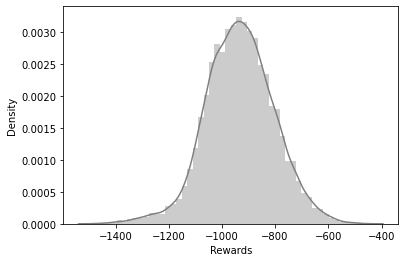

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


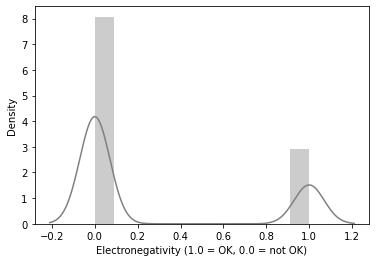

In [3]:
# Plot distribution of final rewards by random policy
plt.figure()
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random, color= 'grey')
plt.xlabel('Rewards')
plt.show()

# Plot distribution of en by random policy
plt.figure()
en_random = en_targets[0::5].reshape(-1) # find final rewards
sns.distplot(en_random, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

### Fix class imbalance 
No significant improvement hence not used anymore

In [6]:
# good = 0
# bad = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good += 1
#     else: 
#         bad += 1
# print('Before balancing: ',good/(good + bad))

Before balancing:  0.2576


In [7]:
# good_idx = []
# bad_idx = []
# idx = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good_idx.append(idx)
#     else:
#         bad_idx.append(idx)
#     idx += 1

# num_datapoints = 25000
# good_idx = good_idx[: num_datapoints]
# bad_idx  = bad_idx[:num_datapoints] # truncate bad compounds to ensure class imbalance
# balanced_idx = bad_idx + good_idx

# s_material_inputs = s_material_inputs[balanced_idx]
# s_step_inputs = s_step_inputs[balanced_idx]
# a_elem_inputs = a_elem_inputs[balanced_idx]
# a_comp_inputs = a_comp_inputs[balanced_idx]
# Q_targets = Q_targets[balanced_idx]
# en_targets = en_targets[balanced_idx]

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
# print('')

# good = 0
# bad = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good += 1
#     else: 
#         bad += 1

# print('After balancing: ',good/(good + bad))

In [4]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

# # Save standard scaler
# joblib.dump(scaler, 'data/std_scaler.bin', compress=True)

# Load standard scaler
scaler = joblib.load('data/std_scaler.bin')

before scaling: tensor([[4.0000, 0.5292, 0.4382,  ..., 0.0000, 0.9176, 0.1895],
        [3.0000, 0.6060, 0.5230,  ..., 0.0000, 0.9176, 0.2225],
        [2.0000, 0.7092, 0.6337,  ..., 0.0000, 0.8946, 0.2223],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 1.6752, -0.1844, -0.3422,  ..., -0.5568,  3.9030,  4.3491],
        [ 0.9207,  0.0340, -0.0994,  ..., -0.5568,  3.9030,  5.2151],
        [ 0.1661,  0.3276,  0.2175,  ..., -0.5568,  3.7885,  5.2108],
        ...,
        [-0.5885,  1.1546,  1.2666,  ...,  1.7961, -0.6612, -0.6233],
        [-1.3430, -1.6892, -1.5972,  ..., -0.5568, -0.6612, -0.6233],
        [-1.3430, -1.6892, -1.5972,  ..., -0.5568, -0.6612, -0.6233]])


In [5]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    en_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    en_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
    en_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]
    en_targets_train         = en_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]
    en_targets_valid         = en_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train,s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
                                    s_step_inputs = s_step_inputs.to('cuda'), 
                                    a_elem_inputs = a_elem_inputs.to('cuda'),
                                    a_comp_inputs = a_comp_inputs.to('cuda'),
                                    Q_targets  = Q_targets.to('cuda'),
                                    en_targets = en_targets.to('cuda'),
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 80])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])
en_targets_train: torch.Size([40000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 80])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])
en_targets_valid: torch.Size([10000, 1])


Here we train DQN using ONLY data generated by random policy.

# DQN

In [28]:
# Initialize Q network
dqn = DQN_pytorch().cuda()
print('CUDA for model: ', next(dqn.parameters()).is_cuda)

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.cpu().data.numpy(), 'Valid_loss = %.4f' % valid_loss.cpu().data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

CUDA for model:  True
Epoch =  0 Train_loss = 763.0855 Valid_loss = 762.9925
Epoch =  1 Train_loss = 761.9996 Valid_loss = 761.1135
Epoch =  2 Train_loss = 760.1211 Valid_loss = 757.9868
Epoch =  3 Train_loss = 756.9940 Valid_loss = 753.2761
Epoch =  4 Train_loss = 752.2822 Valid_loss = 746.6241
Epoch =  5 Train_loss = 745.6273 Valid_loss = 737.6424
Epoch =  6 Train_loss = 736.6397 Valid_loss = 725.8988
Epoch =  7 Train_loss = 724.8873 Valid_loss = 710.9276
Epoch =  8 Train_loss = 709.9038 Valid_loss = 692.2171
Epoch =  9 Train_loss = 691.1767 Valid_loss = 669.2045
Epoch =  10 Train_loss = 668.1424 Valid_loss = 641.2747
Epoch =  11 Train_loss = 640.1854 Valid_loss = 607.7658
Epoch =  12 Train_loss = 606.6420 Valid_loss = 567.9616
Epoch =  13 Train_loss = 566.7955 Valid_loss = 521.1218
Epoch =  14 Train_loss = 519.9230 Valid_loss = 466.9464
Epoch =  15 Train_loss = 465.7196 Valid_loss = 409.3931
Epoch =  16 Train_loss = 408.0021 Valid_loss = 363.2729
Epoch =  17 Train_loss = 361.7742 Va

# DCN

In [38]:
# Initialize constraint network
dcn = DCN_pytorch().cuda()

def train_DCN(dcn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid , Q_targets_valid, en_targets_valid):
    '''
    Trains DCN and prints: 1. training loss 2. validation loss

    Args:
    dcn: DCN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    en_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid
    en_targets_valid

    Returns:
    Updated dcn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dcn.parameters(), lr=1e-2)
    # loss_func = torch.nn.SmoothL1Loss().float()
    loss_func = torch.nn.MSELoss().float() # Works better than L1Loss
    # loss_func = torch.nn.L1Loss().float() # Trained model gives pred close to 0

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dcn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), en_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dcn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), en_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.cpu().numpy(), 'Valid_loss = %.4f' % valid_loss.data.cpu().numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dcn, train_loss_list, valid_loss_list
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 70, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

Epoch =  0 Train_loss = 0.2542 Valid_loss = 0.1954
Epoch =  1 Train_loss = 0.1990 Valid_loss = 0.2033
Epoch =  2 Train_loss = 0.2080 Valid_loss = 0.1930
Epoch =  3 Train_loss = 0.1967 Valid_loss = 0.1870
Epoch =  4 Train_loss = 0.1894 Valid_loss = 0.1884
Epoch =  5 Train_loss = 0.1899 Valid_loss = 0.1883
Epoch =  6 Train_loss = 0.1898 Valid_loss = 0.1864
Epoch =  7 Train_loss = 0.1882 Valid_loss = 0.1846
Epoch =  8 Train_loss = 0.1866 Valid_loss = 0.1837
Epoch =  9 Train_loss = 0.1857 Valid_loss = 0.1834
Epoch =  10 Train_loss = 0.1851 Valid_loss = 0.1828
Epoch =  11 Train_loss = 0.1841 Valid_loss = 0.1816
Epoch =  12 Train_loss = 0.1825 Valid_loss = 0.1804
Epoch =  13 Train_loss = 0.1811 Valid_loss = 0.1797
Epoch =  14 Train_loss = 0.1805 Valid_loss = 0.1790
Epoch =  15 Train_loss = 0.1798 Valid_loss = 0.1776
Epoch =  16 Train_loss = 0.1784 Valid_loss = 0.1762
Epoch =  17 Train_loss = 0.1769 Valid_loss = 0.1755
Epoch =  18 Train_loss = 0.1761 Valid_loss = 0.1752
Epoch =  19 Train_loss

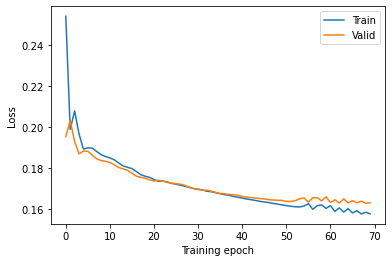

In [39]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [40]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    0th index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions).to('cuda')
    s_step_input = torch.stack([s_step]*n_actions).to('cuda')

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float().to('cuda')
    a_comp_input = torch.stack(a_comp_input).float().to('cuda')
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.cpu().detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Material: {}'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
# print('')
print('')

print('Material: {}'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Material: BaTiO3
Q value of max action:  -628.5897216796875

Material: SrTiO3
Q value of max action:  -597.3125610351562


In [41]:
# Investigate weights of dqn
# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0058, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0185, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0127, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0362, device='cuda:0', grad_fn=<MeanBackward0>))

In [42]:
# For testing the DCN function
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float().to('cuda')
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0]).to('cuda')
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0]).to('cuda')
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0]).to('cuda')
# print(a_comp.shape)

output = dcn(s_material, s_step, a_elem, a_comp)

print(output)
# print(output.shape)

tensor([[0.7559]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [43]:
env = ConstrainedMaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_constrained_max_act(state, dqn, dcn, en_threshold, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    en = 0

    count = 0
    while en <= en_threshold: # Keep iterating until predicted en goes above 0.5
        if stochastic_top_frac != 0: # if stochastic
            act_idx = stochastic_top_frac*tot_num_actions # cut-off index
            rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
        else: # deterministic
            rank = 0 # take top action (index 0)
        max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
        max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max

        # print('state:', state)
        s_material, s_step = state # need to featurize/encode s_material and s_step
        # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
        s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
        s_material_inputs = torch.tensor(scaler.transform(s_material)).float().to('cuda')  # Standardize s_material
        s_step_inputs = torch.tensor(step_to_one_hot([s_step])[0]).reshape(1, -1).float().to('cuda') # Get one-hot rep of s_step
        max_a_elem = max_a_elem.reshape(1, -1).to('cuda')
        max_a_comp = max_a_comp.reshape(1, -1).to('cuda')
        # print('state:', state)
        # print('s_material_inputs:', s_material_inputs)
        # print('s_step_inputs:', s_step_inputs)
        # print('max_a_elem:', max_a_elem)
        # print('max_a_comp:', max_a_comp)
        en = dcn(s_material = s_material_inputs, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                        a_elem      = max_a_elem,     # torch.Size([batch_size,80])
                        a_comp      = max_a_comp,  # torch.Size([batch_size,10])
                        )  # Update en with prediction using DCN
        # print('en pred:', en[0])
        count += 1
        if count >= 100: # Tried more than 100 times
            print('Could not satisfy en constraint after %.0f actions' % count)
            break
    max_a_elem = max_a_elem[0]
    max_a_comp = max_a_comp[0]
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn_dcn(dqn, dcn, en_threshold, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    dcn: Constraint-network for constraint value prediction
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest.
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            # action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
            action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
# ep, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, stochastic_top_frac = 0.2, en_threshold = 0.)

# compounds = []
# for i in tqdm(range(100)):
#     _, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, en_threshold = 0.0, stochastic_top_frac = 0.20)
#     compounds.append(final_compound)

# print(final_compound)
# print(check_electronegativity(final_compound))
# len(compounds)

In [44]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_c_datapoints_and_evaluate_policy(dqn, dcn, num_eps, epsilon, en_threshold = 0.4, stochastic_top_frac = 0.20):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. Default 0.4
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns:
    Q_c_data_trained: List of Q datapoints for training
    en_targets_trained: List of en datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, epsilon = epsilon, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_c_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_c_data = extract_data_from_ep(episode)
        Q_c_data_trained.append(Q_c_data)

    # end = time.time()
    # print('time taken:', end - start)

    # Save Q_data
    # with open('./data/Q_data_trained_RF.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained_RF.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []
    en_targets_trained         = []

    for episode in Q_c_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target, en_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)
            en_target = torch.tensor([en_target])
            en_targets_trained.append(en_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    en_targets_trained = torch.stack(en_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5
    final_en_trained = en_targets_trained[0::5].reshape(-1)

    return Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds

Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = 0, en_threshold = 0.4, stochastic_top_frac = 0.20)
# print(len(Q_c_data_trained))
# print(len(en_targets_trained))
# print(len(final_rewards_trained))
# print(final_compounds)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


In [45]:
count = 0
for target in en_targets_trained[::5]:
    if target[0] == 1.:
        count += 1
print(count)

33


As shown in the plot below, an agent trained based on just data generated by a random policy can improve the distribution of rewards.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


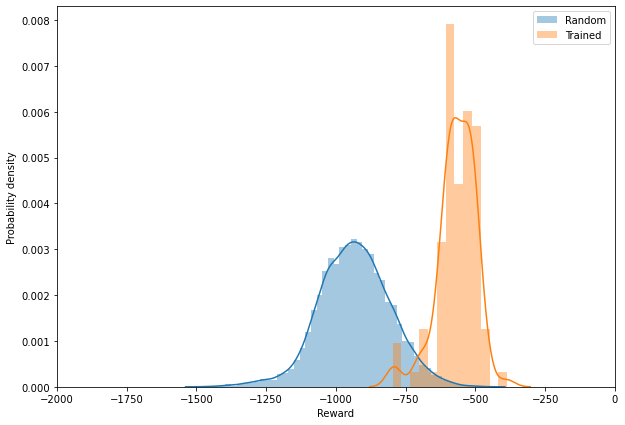

In [46]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
plt.show()

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


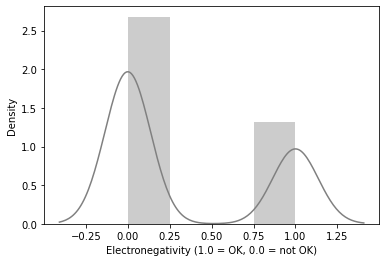

In [47]:
# Plot distribution of en by random policy
sns.distplot(en_targets_trained, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

# Deep Reinforcement Learning
We now close the RL loop by training the agent on data generated by increasingly greedy policies. 

In [48]:
# replay_buffer = collections.deque(maxlen = 50000)
# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, 
#                                                                                                                            dcn = dcn,
#                                                                                                     num_eps = 100, 
#                                                                                                     epsilon = 0, 
#                                                                                                     en_threshold = 0.4,
#                                                                                                     stochastic_top_frac = 0.2)
# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target, en_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
        Q_c_datapoint = [s_material, s_step, a_elem, a_comp, Q_target, en_target]
        replay_buffer.extend([Q_c_datapoint])
    
    return replay_buffer

# replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                             s_step_inputs = s_step_inputs, 
#                                                             a_elem_inputs = a_elem_inputs, 
#                                                             a_comp_inputs = a_comp_inputs, 
#                                                                 Q_targets = Q_targets,
#                                                                 en_targets = en_targets)
# print('Number of Q datapoints in replay buffer (5 per episode):', len(replay_buffer))

In [49]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    em_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for Q_c_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target, en_target = Q_c_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])
        en_target = torch.tensor([en_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)
        en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs).to('cuda')
    s_step_inputs = torch.stack(s_step_inputs).to('cuda')
    a_elem_inputs = torch.stack(a_elem_inputs).to('cuda')
    a_comp_inputs = torch.stack(a_comp_inputs).to('cuda')
    Q_targets = torch.stack(Q_targets).to('cuda')
    en_targets = torch.stack(en_targets).to('cuda')

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
    

### Training the DQN

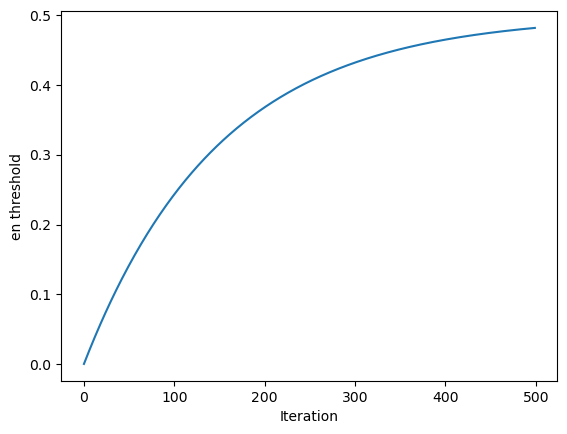

In [23]:
# num_iter = 500
# en_threshold_ub = 0.5 # upper bound for en_threshold
# iteration = np.arange(num_iter)
# en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub
# # for iteration in range(num_iter):
# plt.figure()
# plt.plot(iteration, en_threshold_vs_iter)
# plt.xlabel('Iteration')
# plt.ylabel('en threshold')
# plt.show()

In [104]:
num_iter = 500 # No. of training iterations
epsilon  = 0.99   # Initial epsilon

en_threshold =  0 # Because we don't want to train DCN online
# en_threshold_ub = 0.5 # upper bound for en_threshold
# iteration = np.arange(num_iter)
# en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub

replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
dqn_save_freq = 10 # Save DQN model every n iterations
dqn = DQN_pytorch().cuda() # Initialize DQN
# dcn = DCN_pytorch().cuda() # Initialize DCN
env = ConstrainedMaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# Meta-data to store
final_rewards_vs_iter   = []
en_vs_iter              = []
compounds_vs_iter       = []
train_loss_list_vs_iter = []
valid_loss_list_vs_iter = []
epsilon_vs_iter         = []

for iteration in tqdm(range(num_iter)):
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
#     en_threshold = en_threshold_vs_iter[iteration]
    print('Current epsilon = ', epsilon)
    print('Current en threshold = ', en_threshold)
    epsilon_vs_iter.append(epsilon)
    # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
    print('A) GENERATING DATAPOINTS')
    Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
        generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = epsilon, en_threshold = en_threshold,
                                                                                                    stochastic_top_frac = 0.15) # Generate episodes and score them
    final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
    en_vs_iter.append(en_targets_trained)
    compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
    print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
    print('Compounds generated:', final_compounds)
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained) # Processing to give inputs and targets for DQN
    replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                                s_step_inputs = s_step_inputs, 
                                                                a_elem_inputs = a_elem_inputs, 
                                                                a_comp_inputs = a_comp_inputs, 
                                                                    Q_targets = Q_targets,
                                                                   en_targets = en_targets)
    # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
    print('B) TRAINING Q-NETWORK and C-NETWORK')
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
    s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs.cpu())).float().to('cuda') # Standardize s_material_inputs
    s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
    = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                        s_step_inputs = s_step_inputs, 
                                        a_elem_inputs = a_elem_inputs,
                                        a_comp_inputs = a_comp_inputs,
                                        Q_targets = Q_targets,
                                        en_targets = en_targets,
                                        valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
    dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
    a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
    s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
    a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    
#     dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
#     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
#     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
#     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)
#     train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
#     valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

    if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
        torch.save(dqn, './dqn_models/constrained_DQN_cuda/dqn_test_%.0fiter_RF_constrained' % iteration)

#     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DCN model every n iterations
#         torch.save(dcn, './dcn_models/constrained_DQN_cuda/dcn_test_%.0fiter_RF_constrained' % iteration)

    epsilon *= 0.99 # Decay epsilon

with open('./training_data/constrained_DQN_cuda/final_rewards_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/en_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(en_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/compounds_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/train_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/valid_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/epsilon_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/500 [00:00<?, ?it/s]

=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -921.6461034093793
Compounds generated: ['Sr4Ta1Ce3Ti6Li6', 'Ru1Sm3Al2Tl4Rh5', 'Tm3Lu8Er8Al8', 'Sb7Ag1W1Pb2', 'Bi8Ga1Be4Yb3P6', 'Cr6Te5Cd5Ga1Al1', 'Sb3Si2Na9Ce7Ru7', 'Ta8Dy2Pd4I4Fe7', 'Cs2B9Te4Ge4H7', 'U2Se4Au8C3Pu5', 'I6Sm4Pt2Cr2Cd3', 'O4Br8Na5N2', 'Mg5N3H3Ce4Br2', 'Be4W5As3Tb8', 'Ti8Zr9Ir9Fe1Ge1', 'Ti4P5Ge3', 'Pb6Zn1Cl6Tl9', 'Ir7La9Th1Dy6Dy4', 'V8Zn2Pu5V1Dy2', 'Br9Mo9Te2Fe7Ag4', 'W7Ga5F7Tl1V1', 'Pr6Mo5C8Dy6', 'Cs4Be9Hf2Cr9Li7', 'Rb9Mg9Y2Ir7Y3', 'C2Sr7Sb7Ga2', 'Nd8W2K9Ca4Se2', 'Sc3H5Sr3C1La8', 'Lu9Os7Tl2Te3', 'Hf8Tm3Mn2Mo1Sr1', 'U7C8Pb9H3', 'Pu8P8I8Sc3Mo5', 'Cr6Gd8Ru2Cl8Co4', 'Ni6Pt8Re8As7', 'Be4B7Si8Y6Zn7', 'Al3Pd9Sn4Os5Sn7', 'C4Bi9Th9Pt9Co5', 'N6V7Fe9Au3Ag8', 'Pb5Pt7Sr3Ba3Ce8', 'Pb1Pt9', 'Gd4Pt2As1Mg9', 'Hf4Ti7Ag9Ir8Se5', 'Be2Sm2Ba7', 'Ce2Al6Sc7Te5Ho1', 'Mg6Cs8Li8Pu1Li3', 'Be9Sb6C9Re4Li6', 'Cd2Bi4Au9', 'Tb1Ce7K4Tm8La6', 'C5N9Nd5Co9P7', 'Pt5C

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.1625 Valid_loss = 63.6306
Epoch =  73 Train_loss = 18.2502 Valid_loss = 63.2803
Epoch =  74 Train_loss = 17.8508 Valid_loss = 64.4091
Epoch =  75 Train_loss = 16.4669 Valid_loss = 65.2371
Epoch =  76 Train_loss = 16.1147 Valid_loss = 65.6481
Epoch =  77 Train_loss = 15.9448 Valid_loss = 65.7868
Epoch =  78 Train_loss = 15.1899 Valid_loss = 66.3312
Epoch =  79 Train_loss = 14.2081 Valid_loss = 66.2665
Epoch =  80 Train_loss = 13.1645 Valid_loss = 67.4962
Epoch =  81 Train_loss = 12.6202 Valid_loss = 70.1695
Epoch =  82 Train_loss = 13.3892 Valid_loss = 69.3485
Epoch =  83 Train_loss = 14.6656 Valid_loss = 71.2274
Epoch =  84 Train_loss = 11.8117 Valid_loss = 70.8794
Epoch =  85 Train_loss = 11.4518 Valid_loss = 69.5555
Epoch =  86 Train_loss = 12.8237 Valid_loss = 71.7172
Epoch =  87 Train_loss = 12.9411 Valid_loss = 70.7016
Epoch =  88 Train_loss = 12.3430 Valid_loss = 72.9945
Epoch =  89 Train_loss = 11.0943 Valid_loss = 73.8394
Epoch =  90 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 10.3955 Valid_loss = 85.0961
Epoch =  79 Train_loss = 10.1341 Valid_loss = 85.8609
Epoch =  80 Train_loss = 10.2056 Valid_loss = 86.3347
Epoch =  81 Train_loss = 9.2918 Valid_loss = 85.5886
Epoch =  82 Train_loss = 9.0903 Valid_loss = 85.8891
Epoch =  83 Train_loss = 8.0416 Valid_loss = 85.9489
Epoch =  84 Train_loss = 8.9173 Valid_loss = 85.1501
Epoch =  85 Train_loss = 9.9360 Valid_loss = 85.8549
Epoch =  86 Train_loss = 8.4751 Valid_loss = 87.1415
Epoch =  87 Train_loss = 7.4977 Valid_loss = 86.1122
Epoch =  88 Train_loss = 8.2836 Valid_loss = 85.4847
Epoch =  89 Train_loss = 7.9551 Valid_loss = 86.0743
Epoch =  90 Train_loss = 7.1962 Valid_loss = 86.7548
Epoch =  91 Train_loss = 7.6172 Valid_loss = 88.4855
Epoch =  92 Train_loss = 9.2286 Valid_loss = 88.0376
Epoch =  93 Train_loss = 8.4633 Valid_loss = 86.0527
Epoch =  94 Train_loss = 7.4464 Valid_loss = 86.0235
Epoch =  95 Train_loss = 6.8373 Valid_loss = 86.4615
Epoch =  96 Train_loss = 6.9363 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 14.5154 Valid_loss = 69.5438
Epoch =  68 Train_loss = 14.6144 Valid_loss = 70.6843
Epoch =  69 Train_loss = 12.3665 Valid_loss = 70.7323
Epoch =  70 Train_loss = 11.6318 Valid_loss = 69.8678
Epoch =  71 Train_loss = 13.5604 Valid_loss = 68.5710
Epoch =  72 Train_loss = 12.5852 Valid_loss = 69.7634
Epoch =  73 Train_loss = 12.8582 Valid_loss = 68.4353
Epoch =  74 Train_loss = 11.6804 Valid_loss = 67.1421
Epoch =  75 Train_loss = 11.2085 Valid_loss = 67.5229
Epoch =  76 Train_loss = 8.6753 Valid_loss = 68.1540
Epoch =  77 Train_loss = 11.5850 Valid_loss = 66.8222
Epoch =  78 Train_loss = 7.4263 Valid_loss = 67.0826
Epoch =  79 Train_loss = 10.9666 Valid_loss = 67.1111
Epoch =  80 Train_loss = 8.7809 Valid_loss = 66.9622
Epoch =  81 Train_loss = 6.9086 Valid_loss = 67.7848
Epoch =  82 Train_loss = 9.7026 Valid_loss = 67.8571
Epoch =  83 Train_loss = 8.0725 Valid_loss = 67.7595
Epoch =  84 Train_loss = 6.4246 Valid_loss = 66.6154
Epoch =  85 Train_loss = 6.6452 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 16.1579 Valid_loss = 96.8395
Epoch =  79 Train_loss = 14.1117 Valid_loss = 97.6017
Epoch =  80 Train_loss = 15.8972 Valid_loss = 97.8056
Epoch =  81 Train_loss = 12.4274 Valid_loss = 98.0146
Epoch =  82 Train_loss = 15.3192 Valid_loss = 97.3039
Epoch =  83 Train_loss = 11.8119 Valid_loss = 96.5081
Epoch =  84 Train_loss = 14.8250 Valid_loss = 96.1789
Epoch =  85 Train_loss = 11.9661 Valid_loss = 97.2893
Epoch =  86 Train_loss = 13.8586 Valid_loss = 98.3294
Epoch =  87 Train_loss = 11.5144 Valid_loss = 99.1086
Epoch =  88 Train_loss = 10.8607 Valid_loss = 98.8193
Epoch =  89 Train_loss = 12.9604 Valid_loss = 97.7739
Epoch =  90 Train_loss = 10.4143 Valid_loss = 97.9579
Epoch =  91 Train_loss = 10.7392 Valid_loss = 100.3101
Epoch =  92 Train_loss = 13.8324 Valid_loss = 100.7049
Epoch =  93 Train_loss = 11.0831 Valid_loss = 97.5107
Epoch =  94 Train_loss = 14.7265 Valid_loss = 94.7902
Epoch =  95 Train_loss = 13.1269 Valid_loss = 96.6176
Epoch =  96 Train_loss = 1

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 11.1503 Valid_loss = 89.2350
Epoch =  80 Train_loss = 11.7187 Valid_loss = 91.5313
Epoch =  81 Train_loss = 8.5777 Valid_loss = 92.5485
Epoch =  82 Train_loss = 10.2990 Valid_loss = 90.7104
Epoch =  83 Train_loss = 7.5023 Valid_loss = 90.5654
Epoch =  84 Train_loss = 8.0064 Valid_loss = 92.5604
Epoch =  85 Train_loss = 8.3656 Valid_loss = 91.6332
Epoch =  86 Train_loss = 5.7061 Valid_loss = 89.8243
Epoch =  87 Train_loss = 9.0252 Valid_loss = 90.2262
Epoch =  88 Train_loss = 6.3592 Valid_loss = 92.3613
Epoch =  89 Train_loss = 10.2819 Valid_loss = 91.7436
Epoch =  90 Train_loss = 7.2115 Valid_loss = 90.1659
Epoch =  91 Train_loss = 10.2933 Valid_loss = 90.4732
Epoch =  92 Train_loss = 8.6896 Valid_loss = 92.5916
Epoch =  93 Train_loss = 8.8856 Valid_loss = 92.2162
Epoch =  94 Train_loss = 6.8884 Valid_loss = 90.3630
Epoch =  95 Train_loss = 11.4075 Valid_loss = 90.5217
Epoch =  96 Train_loss = 10.8487 Valid_loss = 92.2458
Epoch =  97 Train_loss = 6.7119 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 9.7369 Valid_loss = 100.2111
Epoch =  74 Train_loss = 9.7214 Valid_loss = 93.4880
Epoch =  75 Train_loss = 12.2537 Valid_loss = 95.8526
Epoch =  76 Train_loss = 10.0091 Valid_loss = 102.3800
Epoch =  77 Train_loss = 13.3647 Valid_loss = 99.5582
Epoch =  78 Train_loss = 8.4841 Valid_loss = 94.9646
Epoch =  79 Train_loss = 14.0016 Valid_loss = 99.8351
Epoch =  80 Train_loss = 10.1021 Valid_loss = 108.4341
Epoch =  81 Train_loss = 15.5174 Valid_loss = 104.1843
Epoch =  82 Train_loss = 9.8866 Valid_loss = 94.1013
Epoch =  83 Train_loss = 16.8088 Valid_loss = 94.4528
Epoch =  84 Train_loss = 15.4679 Valid_loss = 103.4217
Epoch =  85 Train_loss = 11.1552 Valid_loss = 105.8553
Epoch =  86 Train_loss = 13.0683 Valid_loss = 97.8436
Epoch =  87 Train_loss = 9.9343 Valid_loss = 96.8441
Epoch =  88 Train_loss = 11.0143 Valid_loss = 103.0822
Epoch =  89 Train_loss = 7.6945 Valid_loss = 104.4883
Epoch =  90 Train_loss = 9.0285 Valid_loss = 98.8556
Epoch =  91 Train_loss = 7.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 14.6026 Valid_loss = 97.1058
Epoch =  71 Train_loss = 10.5251 Valid_loss = 96.5116
Epoch =  72 Train_loss = 11.4466 Valid_loss = 95.5263
Epoch =  73 Train_loss = 11.6352 Valid_loss = 95.2807
Epoch =  74 Train_loss = 9.7728 Valid_loss = 95.6333
Epoch =  75 Train_loss = 14.4061 Valid_loss = 95.4199
Epoch =  76 Train_loss = 12.7006 Valid_loss = 95.4545
Epoch =  77 Train_loss = 10.4906 Valid_loss = 95.4021
Epoch =  78 Train_loss = 9.5176 Valid_loss = 95.9737
Epoch =  79 Train_loss = 12.9332 Valid_loss = 95.9920
Epoch =  80 Train_loss = 10.9521 Valid_loss = 95.5275
Epoch =  81 Train_loss = 13.5240 Valid_loss = 95.7524
Epoch =  82 Train_loss = 14.6536 Valid_loss = 96.2508
Epoch =  83 Train_loss = 7.9555 Valid_loss = 96.1981
Epoch =  84 Train_loss = 14.0645 Valid_loss = 95.5973
Epoch =  85 Train_loss = 8.3212 Valid_loss = 95.2669
Epoch =  86 Train_loss = 16.0322 Valid_loss = 94.9281
Epoch =  87 Train_loss = 16.4661 Valid_loss = 94.2648
Epoch =  88 Train_loss = 8.0975 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  74 Train_loss = 12.7866 Valid_loss = 87.7354
Epoch =  75 Train_loss = 17.0290 Valid_loss = 88.7163
Epoch =  76 Train_loss = 9.3037 Valid_loss = 89.2014
Epoch =  77 Train_loss = 12.9542 Valid_loss = 88.0522
Epoch =  78 Train_loss = 8.5502 Valid_loss = 87.1931
Epoch =  79 Train_loss = 14.1844 Valid_loss = 86.0500
Epoch =  80 Train_loss = 8.3054 Valid_loss = 88.0571
Epoch =  81 Train_loss = 16.1716 Valid_loss = 88.9183
Epoch =  82 Train_loss = 12.2166 Valid_loss = 89.6268
Epoch =  83 Train_loss = 15.7477 Valid_loss = 88.5317
Epoch =  84 Train_loss = 15.2350 Valid_loss = 86.8942
Epoch =  85 Train_loss = 10.7769 Valid_loss = 86.6394
Epoch =  86 Train_loss = 11.6328 Valid_loss = 85.9522
Epoch =  87 Train_loss = 11.7559 Valid_loss = 86.8411
Epoch =  88 Train_loss = 11.6037 Valid_loss = 88.5785
Epoch =  89 Train_loss = 11.7753 Valid_loss = 89.3147
Epoch =  90 Train_loss = 10.5295 Valid_loss = 90.1678
Epoch =  91 Train_loss = 13.1887 Valid_loss = 90.1934
Epoch =  92 Train_loss = 11.35

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 98.9022
Epoch =  75 Train_loss = 9.9903 Valid_loss = 104.8747
Epoch =  76 Train_loss = 11.1319 Valid_loss = 103.6499
Epoch =  77 Train_loss = 8.5015 Valid_loss = 99.6297
Epoch =  78 Train_loss = 12.2309 Valid_loss = 101.2408
Epoch =  79 Train_loss = 9.1294 Valid_loss = 106.9225
Epoch =  80 Train_loss = 12.8966 Valid_loss = 105.8831
Epoch =  81 Train_loss = 10.7827 Valid_loss = 99.9794
Epoch =  82 Train_loss = 12.3556 Valid_loss = 99.8002
Epoch =  83 Train_loss = 12.5474 Valid_loss = 104.2768
Epoch =  84 Train_loss = 8.4486 Valid_loss = 105.2233
Epoch =  85 Train_loss = 9.6080 Valid_loss = 101.2669
Epoch =  86 Train_loss = 8.4272 Valid_loss = 101.6208
Epoch =  87 Train_loss = 8.2824 Valid_loss = 105.8847
Epoch =  88 Train_loss = 8.6632 Valid_loss = 104.3917
Epoch =  89 Train_loss = 6.3839 Valid_loss = 100.6238
Epoch =  90 Train_loss = 10.6647 Valid_loss = 101.8747
Epoch =  91 Train_loss = 6.6023 Valid_loss = 108.1681
Epoch =  92 Train_loss = 13.3362 Valid_loss = 107.4892
E

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 14.6659 Valid_loss = 76.9448
Epoch =  72 Train_loss = 12.3686 Valid_loss = 77.7940
Epoch =  73 Train_loss = 13.0547 Valid_loss = 75.4542
Epoch =  74 Train_loss = 14.7312 Valid_loss = 77.4350
Epoch =  75 Train_loss = 11.9287 Valid_loss = 78.6720
Epoch =  76 Train_loss = 12.5941 Valid_loss = 76.7075
Epoch =  77 Train_loss = 14.1683 Valid_loss = 79.3502
Epoch =  78 Train_loss = 11.4278 Valid_loss = 79.5252
Epoch =  79 Train_loss = 11.3641 Valid_loss = 78.1362
Epoch =  80 Train_loss = 10.8694 Valid_loss = 79.9144
Epoch =  81 Train_loss = 13.5877 Valid_loss = 77.5052
Epoch =  82 Train_loss = 12.1725 Valid_loss = 77.2646
Epoch =  83 Train_loss = 12.8405 Valid_loss = 80.3260
Epoch =  84 Train_loss = 13.7927 Valid_loss = 79.6120
Epoch =  85 Train_loss = 11.5022 Valid_loss = 77.7611
Epoch =  86 Train_loss = 13.1926 Valid_loss = 79.5345
Epoch =  87 Train_loss = 10.3898 Valid_loss = 80.4812
Epoch =  88 Train_loss = 10.9187 Valid_loss = 78.0964
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 11.9513 Valid_loss = 107.0152
Epoch =  73 Train_loss = 13.0797 Valid_loss = 102.6513
Epoch =  74 Train_loss = 10.4993 Valid_loss = 101.1714
Epoch =  75 Train_loss = 11.2422 Valid_loss = 104.4606
Epoch =  76 Train_loss = 11.0706 Valid_loss = 104.1751
Epoch =  77 Train_loss = 9.1392 Valid_loss = 101.3591
Epoch =  78 Train_loss = 12.6043 Valid_loss = 105.2131
Epoch =  79 Train_loss = 10.3422 Valid_loss = 105.5797
Epoch =  80 Train_loss = 12.4769 Valid_loss = 101.0880
Epoch =  81 Train_loss = 10.0861 Valid_loss = 102.4900
Epoch =  82 Train_loss = 8.4556 Valid_loss = 107.1571
Epoch =  83 Train_loss = 10.7131 Valid_loss = 103.9801
Epoch =  84 Train_loss = 11.2537 Valid_loss = 104.0038
Epoch =  85 Train_loss = 8.7138 Valid_loss = 103.7680
Epoch =  86 Train_loss = 10.3336 Valid_loss = 101.0040
Epoch =  87 Train_loss = 9.5509 Valid_loss = 103.0569
Epoch =  88 Train_loss = 9.5076 Valid_loss = 104.2614
Epoch =  89 Train_loss = 7.9573 Valid_loss = 100.5540
Epoch =  90 Trai

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 13.3270 Valid_loss = 95.6809
Epoch =  72 Train_loss = 11.2369 Valid_loss = 92.9406
Epoch =  73 Train_loss = 12.9212 Valid_loss = 94.2801
Epoch =  74 Train_loss = 15.2341 Valid_loss = 93.3222
Epoch =  75 Train_loss = 14.0186 Valid_loss = 89.2908
Epoch =  76 Train_loss = 15.0113 Valid_loss = 90.6809
Epoch =  77 Train_loss = 14.8158 Valid_loss = 93.9580
Epoch =  78 Train_loss = 11.8260 Valid_loss = 97.4099
Epoch =  79 Train_loss = 12.0281 Valid_loss = 97.9146
Epoch =  80 Train_loss = 14.1100 Valid_loss = 98.3933
Epoch =  81 Train_loss = 14.4667 Valid_loss = 97.2588
Epoch =  82 Train_loss = 13.0943 Valid_loss = 93.7065
Epoch =  83 Train_loss = 10.7885 Valid_loss = 91.0489
Epoch =  84 Train_loss = 13.8782 Valid_loss = 90.8018
Epoch =  85 Train_loss = 15.1302 Valid_loss = 92.0450
Epoch =  86 Train_loss = 10.3282 Valid_loss = 95.8128
Epoch =  87 Train_loss = 11.4126 Valid_loss = 98.2796
Epoch =  88 Train_loss = 12.9533 Valid_loss = 98.3068
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 18.5169 Valid_loss = 89.7639
Epoch =  73 Train_loss = 16.8683 Valid_loss = 92.8320
Epoch =  74 Train_loss = 17.3488 Valid_loss = 90.1350
Epoch =  75 Train_loss = 18.8562 Valid_loss = 92.5491
Epoch =  76 Train_loss = 17.2051 Valid_loss = 92.3267
Epoch =  77 Train_loss = 16.7763 Valid_loss = 88.2737
Epoch =  78 Train_loss = 17.4271 Valid_loss = 91.9513
Epoch =  79 Train_loss = 17.9985 Valid_loss = 88.3458
Epoch =  80 Train_loss = 17.2859 Valid_loss = 89.5767
Epoch =  81 Train_loss = 15.6563 Valid_loss = 92.1859
Epoch =  82 Train_loss = 16.2893 Valid_loss = 87.8310
Epoch =  83 Train_loss = 19.7939 Valid_loss = 92.1513
Epoch =  84 Train_loss = 16.3401 Valid_loss = 94.9944
Epoch =  85 Train_loss = 17.8439 Valid_loss = 92.5788
Epoch =  86 Train_loss = 15.3173 Valid_loss = 91.8597
Epoch =  87 Train_loss = 13.8918 Valid_loss = 93.9737
Epoch =  88 Train_loss = 17.2402 Valid_loss = 88.1080
Epoch =  89 Train_loss = 17.2494 Valid_loss = 87.2997
Epoch =  90 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 8.0276 Valid_loss = 77.2071
Epoch =  75 Train_loss = 12.2159 Valid_loss = 77.1597
Epoch =  76 Train_loss = 9.0997 Valid_loss = 75.8804
Epoch =  77 Train_loss = 13.7029 Valid_loss = 74.3108
Epoch =  78 Train_loss = 9.2293 Valid_loss = 74.2421
Epoch =  79 Train_loss = 14.4186 Valid_loss = 74.6359
Epoch =  80 Train_loss = 11.2358 Valid_loss = 75.6422
Epoch =  81 Train_loss = 14.4849 Valid_loss = 77.1041
Epoch =  82 Train_loss = 15.0869 Valid_loss = 77.9092
Epoch =  83 Train_loss = 7.1766 Valid_loss = 78.2328
Epoch =  84 Train_loss = 12.4039 Valid_loss = 78.1441
Epoch =  85 Train_loss = 6.5734 Valid_loss = 76.9872
Epoch =  86 Train_loss = 12.6982 Valid_loss = 75.3984
Epoch =  87 Train_loss = 9.5904 Valid_loss = 74.7051
Epoch =  88 Train_loss = 13.0092 Valid_loss = 74.3886
Epoch =  89 Train_loss = 11.8901 Valid_loss = 74.6383
Epoch =  90 Train_loss = 9.1062 Valid_loss = 76.1788
Epoch =  91 Train_loss = 13.6642 Valid_loss = 76.6475
Epoch =  92 Train_loss = 6.1502 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 14.2445 Valid_loss = 104.1606
Epoch =  73 Train_loss = 15.6445 Valid_loss = 103.0343
Epoch =  74 Train_loss = 14.6630 Valid_loss = 104.9611
Epoch =  75 Train_loss = 13.2778 Valid_loss = 105.9030
Epoch =  76 Train_loss = 13.9857 Valid_loss = 105.2600
Epoch =  77 Train_loss = 13.2737 Valid_loss = 105.9123
Epoch =  78 Train_loss = 13.6255 Valid_loss = 103.3479
Epoch =  79 Train_loss = 16.5011 Valid_loss = 106.0948
Epoch =  80 Train_loss = 17.0093 Valid_loss = 103.9471
Epoch =  81 Train_loss = 14.1930 Valid_loss = 105.5890
Epoch =  82 Train_loss = 13.7556 Valid_loss = 109.3276
Epoch =  83 Train_loss = 18.8156 Valid_loss = 106.7003
Epoch =  84 Train_loss = 13.5655 Valid_loss = 104.1293
Epoch =  85 Train_loss = 16.4639 Valid_loss = 107.2399
Epoch =  86 Train_loss = 18.8104 Valid_loss = 106.0537
Epoch =  87 Train_loss = 15.8401 Valid_loss = 103.6659
Epoch =  88 Train_loss = 20.1458 Valid_loss = 106.1900
Epoch =  89 Train_loss = 14.8474 Valid_loss = 112.1356
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 10.9409 Valid_loss = 113.6349
Epoch =  73 Train_loss = 9.6110 Valid_loss = 114.1478
Epoch =  74 Train_loss = 14.0925 Valid_loss = 113.4449
Epoch =  75 Train_loss = 11.4097 Valid_loss = 112.4000
Epoch =  76 Train_loss = 11.6385 Valid_loss = 113.0425
Epoch =  77 Train_loss = 12.7075 Valid_loss = 113.5877
Epoch =  78 Train_loss = 11.1148 Valid_loss = 112.7031
Epoch =  79 Train_loss = 6.4710 Valid_loss = 112.2828
Epoch =  80 Train_loss = 11.4383 Valid_loss = 113.8000
Epoch =  81 Train_loss = 8.3814 Valid_loss = 114.0428
Epoch =  82 Train_loss = 10.9717 Valid_loss = 112.2080
Epoch =  83 Train_loss = 9.2861 Valid_loss = 111.6181
Epoch =  84 Train_loss = 9.2173 Valid_loss = 113.0257
Epoch =  85 Train_loss = 10.3111 Valid_loss = 113.9392
Epoch =  86 Train_loss = 8.7725 Valid_loss = 114.0785
Epoch =  87 Train_loss = 13.6781 Valid_loss = 115.1997
Epoch =  88 Train_loss = 11.3301 Valid_loss = 116.2775
Epoch =  89 Train_loss = 9.5860 Valid_loss = 115.6807
Epoch =  90 Train

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 8.6307 Valid_loss = 75.1799
Epoch =  72 Train_loss = 9.7092 Valid_loss = 75.5760
Epoch =  73 Train_loss = 6.8141 Valid_loss = 74.5639
Epoch =  74 Train_loss = 7.1172 Valid_loss = 73.6525
Epoch =  75 Train_loss = 8.3924 Valid_loss = 74.9718
Epoch =  76 Train_loss = 7.3196 Valid_loss = 75.3724
Epoch =  77 Train_loss = 5.7199 Valid_loss = 75.1743
Epoch =  78 Train_loss = 8.7336 Valid_loss = 76.0040
Epoch =  79 Train_loss = 7.1920 Valid_loss = 76.6397
Epoch =  80 Train_loss = 8.1092 Valid_loss = 75.5782
Epoch =  81 Train_loss = 10.3363 Valid_loss = 76.1303
Epoch =  82 Train_loss = 7.1552 Valid_loss = 78.2503
Epoch =  83 Train_loss = 12.3918 Valid_loss = 76.6568
Epoch =  84 Train_loss = 7.5719 Valid_loss = 73.9169
Epoch =  85 Train_loss = 12.8673 Valid_loss = 73.8582
Epoch =  86 Train_loss = 8.9469 Valid_loss = 76.9843
Epoch =  87 Train_loss = 10.8721 Valid_loss = 75.9013
Epoch =  88 Train_loss = 7.5112 Valid_loss = 75.2762
Epoch =  89 Train_loss = 13.0485 Valid_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 13.2646 Valid_loss = 78.3935
Epoch =  72 Train_loss = 19.0080 Valid_loss = 78.5055
Epoch =  73 Train_loss = 17.0710 Valid_loss = 79.0653
Epoch =  74 Train_loss = 14.8365 Valid_loss = 78.5999
Epoch =  75 Train_loss = 14.3664 Valid_loss = 77.5838
Epoch =  76 Train_loss = 16.4450 Valid_loss = 77.1723
Epoch =  77 Train_loss = 15.4116 Valid_loss = 77.8875
Epoch =  78 Train_loss = 15.8078 Valid_loss = 78.4037
Epoch =  79 Train_loss = 16.4702 Valid_loss = 77.9364
Epoch =  80 Train_loss = 11.4770 Valid_loss = 78.3140
Epoch =  81 Train_loss = 12.9293 Valid_loss = 78.9265
Epoch =  82 Train_loss = 12.7890 Valid_loss = 78.7857
Epoch =  83 Train_loss = 10.6301 Valid_loss = 78.6087
Epoch =  84 Train_loss = 14.5264 Valid_loss = 78.8355
Epoch =  85 Train_loss = 10.3999 Valid_loss = 80.2968
Epoch =  86 Train_loss = 16.6114 Valid_loss = 79.6582
Epoch =  87 Train_loss = 12.1746 Valid_loss = 79.2423
Epoch =  88 Train_loss = 16.5126 Valid_loss = 79.5503
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 18.2338 Valid_loss = 82.4844
Epoch =  73 Train_loss = 14.8355 Valid_loss = 82.3325
Epoch =  74 Train_loss = 17.0918 Valid_loss = 82.1025
Epoch =  75 Train_loss = 13.5472 Valid_loss = 81.6817
Epoch =  76 Train_loss = 17.4384 Valid_loss = 81.7507
Epoch =  77 Train_loss = 14.2270 Valid_loss = 82.2951
Epoch =  78 Train_loss = 17.3417 Valid_loss = 81.7614
Epoch =  79 Train_loss = 13.3020 Valid_loss = 81.0452
Epoch =  80 Train_loss = 17.2009 Valid_loss = 80.7470
Epoch =  81 Train_loss = 13.2069 Valid_loss = 81.3239
Epoch =  82 Train_loss = 16.6750 Valid_loss = 81.5825
Epoch =  83 Train_loss = 11.1655 Valid_loss = 82.0573
Epoch =  84 Train_loss = 18.5402 Valid_loss = 82.8115
Epoch =  85 Train_loss = 13.0248 Valid_loss = 85.0810
Epoch =  86 Train_loss = 19.7686 Valid_loss = 84.5714
Epoch =  87 Train_loss = 17.1522 Valid_loss = 82.9021
Epoch =  88 Train_loss = 15.9976 Valid_loss = 82.3029
Epoch =  89 Train_loss = 16.3524 Valid_loss = 82.1486
Epoch =  90 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.3225 Valid_loss = 89.5384
Epoch =  73 Train_loss = 22.7831 Valid_loss = 89.9695
Epoch =  74 Train_loss = 20.2623 Valid_loss = 95.4805
Epoch =  75 Train_loss = 22.3517 Valid_loss = 96.3256
Epoch =  76 Train_loss = 23.0295 Valid_loss = 91.7553
Epoch =  77 Train_loss = 14.3643 Valid_loss = 87.7172
Epoch =  78 Train_loss = 21.0575 Valid_loss = 88.2428
Epoch =  79 Train_loss = 21.6078 Valid_loss = 91.1270
Epoch =  80 Train_loss = 18.2494 Valid_loss = 91.6597
Epoch =  81 Train_loss = 18.4334 Valid_loss = 88.5780
Epoch =  82 Train_loss = 15.7075 Valid_loss = 86.3447
Epoch =  83 Train_loss = 20.9570 Valid_loss = 90.2042
Epoch =  84 Train_loss = 17.0514 Valid_loss = 95.6547
Epoch =  85 Train_loss = 20.6552 Valid_loss = 96.0223
Epoch =  86 Train_loss = 17.4623 Valid_loss = 92.9419
Epoch =  87 Train_loss = 14.6080 Valid_loss = 92.9151
Epoch =  88 Train_loss = 17.5987 Valid_loss = 95.3656
Epoch =  89 Train_loss = 16.1623 Valid_loss = 94.2698
Epoch =  90 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 10.9317 Valid_loss = 117.3261
Epoch =  72 Train_loss = 12.0564 Valid_loss = 116.2593
Epoch =  73 Train_loss = 8.6659 Valid_loss = 114.2308
Epoch =  74 Train_loss = 13.0974 Valid_loss = 114.9244
Epoch =  75 Train_loss = 10.5103 Valid_loss = 114.7896
Epoch =  76 Train_loss = 9.2895 Valid_loss = 114.5790
Epoch =  77 Train_loss = 10.4340 Valid_loss = 115.7522
Epoch =  78 Train_loss = 8.6170 Valid_loss = 116.6865
Epoch =  79 Train_loss = 9.2438 Valid_loss = 116.9066
Epoch =  80 Train_loss = 8.8677 Valid_loss = 116.9302
Epoch =  81 Train_loss = 8.2052 Valid_loss = 117.1028
Epoch =  82 Train_loss = 8.4190 Valid_loss = 117.6445
Epoch =  83 Train_loss = 7.7934 Valid_loss = 116.7316
Epoch =  84 Train_loss = 7.7103 Valid_loss = 116.7918
Epoch =  85 Train_loss = 8.2763 Valid_loss = 115.4628
Epoch =  86 Train_loss = 9.3609 Valid_loss = 116.5685
Epoch =  87 Train_loss = 8.9018 Valid_loss = 117.7541
Epoch =  88 Train_loss = 6.9815 Valid_loss = 117.4101
Epoch =  89 Train_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 9.0005 Valid_loss = 86.8751
Epoch =  73 Train_loss = 7.7012 Valid_loss = 86.8211
Epoch =  74 Train_loss = 8.0105 Valid_loss = 83.3455
Epoch =  75 Train_loss = 10.3458 Valid_loss = 83.2314
Epoch =  76 Train_loss = 8.5263 Valid_loss = 86.0471
Epoch =  77 Train_loss = 9.2374 Valid_loss = 85.3222
Epoch =  78 Train_loss = 7.4983 Valid_loss = 81.7310
Epoch =  79 Train_loss = 8.7057 Valid_loss = 82.2488
Epoch =  80 Train_loss = 7.9994 Valid_loss = 86.0704
Epoch =  81 Train_loss = 9.7129 Valid_loss = 85.4426
Epoch =  82 Train_loss = 7.4591 Valid_loss = 83.9396
Epoch =  83 Train_loss = 9.8659 Valid_loss = 84.2829
Epoch =  84 Train_loss = 7.0148 Valid_loss = 85.7319
Epoch =  85 Train_loss = 8.4767 Valid_loss = 84.2021
Epoch =  86 Train_loss = 6.4789 Valid_loss = 81.5400
Epoch =  87 Train_loss = 8.2558 Valid_loss = 83.6341
Epoch =  88 Train_loss = 6.0926 Valid_loss = 86.2213
Epoch =  89 Train_loss = 6.1396 Valid_loss = 84.6411
Epoch =  90 Train_loss = 4.3628 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 16.5254 Valid_loss = 110.6625
Epoch =  73 Train_loss = 22.6868 Valid_loss = 109.7417
Epoch =  74 Train_loss = 22.5674 Valid_loss = 106.5002
Epoch =  75 Train_loss = 17.0845 Valid_loss = 104.7750
Epoch =  76 Train_loss = 22.0438 Valid_loss = 105.9802
Epoch =  77 Train_loss = 16.1316 Valid_loss = 111.5043
Epoch =  78 Train_loss = 21.8618 Valid_loss = 110.6558
Epoch =  79 Train_loss = 20.8487 Valid_loss = 105.8272
Epoch =  80 Train_loss = 16.9081 Valid_loss = 104.7106
Epoch =  81 Train_loss = 19.6903 Valid_loss = 106.1634
Epoch =  82 Train_loss = 12.9180 Valid_loss = 106.5807
Epoch =  83 Train_loss = 16.2342 Valid_loss = 104.6214
Epoch =  84 Train_loss = 14.5264 Valid_loss = 103.4139
Epoch =  85 Train_loss = 17.0330 Valid_loss = 104.5080
Epoch =  86 Train_loss = 13.2952 Valid_loss = 105.3809
Epoch =  87 Train_loss = 13.9855 Valid_loss = 104.8335
Epoch =  88 Train_loss = 14.0061 Valid_loss = 104.9639
Epoch =  89 Train_loss = 14.1956 Valid_loss = 105.9866
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 11.6022 Valid_loss = 55.0726
Epoch =  75 Train_loss = 14.9910 Valid_loss = 59.3009
Epoch =  76 Train_loss = 11.2778 Valid_loss = 61.0685
Epoch =  77 Train_loss = 14.7875 Valid_loss = 55.8165
Epoch =  78 Train_loss = 10.1712 Valid_loss = 56.1766
Epoch =  79 Train_loss = 11.0251 Valid_loss = 60.8473
Epoch =  80 Train_loss = 13.6441 Valid_loss = 60.1895
Epoch =  81 Train_loss = 11.0029 Valid_loss = 55.2510
Epoch =  82 Train_loss = 12.3815 Valid_loss = 55.3339
Epoch =  83 Train_loss = 13.1093 Valid_loss = 59.0354
Epoch =  84 Train_loss = 10.6051 Valid_loss = 58.1989
Epoch =  85 Train_loss = 10.0448 Valid_loss = 53.9039
Epoch =  86 Train_loss = 11.2775 Valid_loss = 54.9088
Epoch =  87 Train_loss = 9.1192 Valid_loss = 57.5093
Epoch =  88 Train_loss = 11.3601 Valid_loss = 53.9851
Epoch =  89 Train_loss = 10.9329 Valid_loss = 55.4167
Epoch =  90 Train_loss = 10.1613 Valid_loss = 61.1194
Epoch =  91 Train_loss = 11.1877 Valid_loss = 60.7123
Epoch =  92 Train_loss = 10.3

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 8.5654 Valid_loss = 78.1534
Epoch =  73 Train_loss = 11.6787 Valid_loss = 79.1081
Epoch =  74 Train_loss = 6.7514 Valid_loss = 84.1218
Epoch =  75 Train_loss = 15.1740 Valid_loss = 82.1182
Epoch =  76 Train_loss = 13.0057 Valid_loss = 77.7941
Epoch =  77 Train_loss = 11.9569 Valid_loss = 79.4108
Epoch =  78 Train_loss = 8.4402 Valid_loss = 84.0659
Epoch =  79 Train_loss = 14.8491 Valid_loss = 81.9172
Epoch =  80 Train_loss = 10.5057 Valid_loss = 77.8781
Epoch =  81 Train_loss = 14.8596 Valid_loss = 77.3634
Epoch =  82 Train_loss = 15.0354 Valid_loss = 80.7566
Epoch =  83 Train_loss = 7.9827 Valid_loss = 81.7824
Epoch =  84 Train_loss = 10.7151 Valid_loss = 78.0568
Epoch =  85 Train_loss = 8.7933 Valid_loss = 78.4521
Epoch =  86 Train_loss = 7.5952 Valid_loss = 82.1132
Epoch =  87 Train_loss = 11.2441 Valid_loss = 80.4760
Epoch =  88 Train_loss = 6.8796 Valid_loss = 77.9184
Epoch =  89 Train_loss = 12.5621 Valid_loss = 79.3305
Epoch =  90 Train_loss = 6.6198 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.0639 Valid_loss = 91.5786
Epoch =  73 Train_loss = 14.3919 Valid_loss = 93.2588
Epoch =  74 Train_loss = 12.5566 Valid_loss = 90.2244
Epoch =  75 Train_loss = 10.9813 Valid_loss = 85.0763
Epoch =  76 Train_loss = 14.5151 Valid_loss = 83.2067
Epoch =  77 Train_loss = 12.3609 Valid_loss = 83.1331
Epoch =  78 Train_loss = 12.9794 Valid_loss = 82.6523
Epoch =  79 Train_loss = 10.8087 Valid_loss = 81.7558
Epoch =  80 Train_loss = 12.4839 Valid_loss = 84.5072
Epoch =  81 Train_loss = 10.5890 Valid_loss = 91.2145
Epoch =  82 Train_loss = 13.0112 Valid_loss = 93.6542
Epoch =  83 Train_loss = 12.4176 Valid_loss = 89.4266
Epoch =  84 Train_loss = 11.7070 Valid_loss = 86.9323
Epoch =  85 Train_loss = 14.2061 Valid_loss = 86.5643
Epoch =  86 Train_loss = 7.4981 Valid_loss = 85.1311
Epoch =  87 Train_loss = 9.2522 Valid_loss = 82.0427
Epoch =  88 Train_loss = 9.5772 Valid_loss = 83.8075
Epoch =  89 Train_loss = 7.5002 Valid_loss = 88.5350
Epoch =  90 Train_loss = 10.6296

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 8.6297 Valid_loss = 71.9006
Epoch =  73 Train_loss = 6.1415 Valid_loss = 71.8887
Epoch =  74 Train_loss = 7.6441 Valid_loss = 73.6578
Epoch =  75 Train_loss = 9.8327 Valid_loss = 73.0528
Epoch =  76 Train_loss = 8.4364 Valid_loss = 71.4575
Epoch =  77 Train_loss = 5.0899 Valid_loss = 70.1616
Epoch =  78 Train_loss = 8.5268 Valid_loss = 70.0028
Epoch =  79 Train_loss = 8.3608 Valid_loss = 71.2579
Epoch =  80 Train_loss = 6.3344 Valid_loss = 74.1095
Epoch =  81 Train_loss = 11.0261 Valid_loss = 74.4572
Epoch =  82 Train_loss = 10.4306 Valid_loss = 72.8238
Epoch =  83 Train_loss = 9.4699 Valid_loss = 70.8282
Epoch =  84 Train_loss = 8.4714 Valid_loss = 71.4651
Epoch =  85 Train_loss = 12.0739 Valid_loss = 72.5046
Epoch =  86 Train_loss = 13.7704 Valid_loss = 71.0656
Epoch =  87 Train_loss = 7.3334 Valid_loss = 70.4827
Epoch =  88 Train_loss = 12.1823 Valid_loss = 71.1042
Epoch =  89 Train_loss = 14.2770 Valid_loss = 71.6952
Epoch =  90 Train_loss = 7.1164 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 11.3868 Valid_loss = 74.7485
Epoch =  73 Train_loss = 18.6384 Valid_loss = 73.8362
Epoch =  74 Train_loss = 17.2031 Valid_loss = 69.2363
Epoch =  75 Train_loss = 10.5314 Valid_loss = 68.3595
Epoch =  76 Train_loss = 13.0426 Valid_loss = 71.1535
Epoch =  77 Train_loss = 11.2180 Valid_loss = 71.5440
Epoch =  78 Train_loss = 10.4892 Valid_loss = 69.7460
Epoch =  79 Train_loss = 14.8497 Valid_loss = 69.1868
Epoch =  80 Train_loss = 10.6356 Valid_loss = 71.7113
Epoch =  81 Train_loss = 14.7777 Valid_loss = 70.3600
Epoch =  82 Train_loss = 11.5744 Valid_loss = 66.8882
Epoch =  83 Train_loss = 16.2254 Valid_loss = 66.8068
Epoch =  84 Train_loss = 17.3667 Valid_loss = 68.7693
Epoch =  85 Train_loss = 9.1628 Valid_loss = 73.2977
Epoch =  86 Train_loss = 15.3095 Valid_loss = 73.8265
Epoch =  87 Train_loss = 12.7831 Valid_loss = 71.2071
Epoch =  88 Train_loss = 15.3634 Valid_loss = 70.3975
Epoch =  89 Train_loss = 14.0148 Valid_loss = 71.3650
Epoch =  90 Train_loss = 11.2

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 9.9353 Valid_loss = 82.3205
Epoch =  73 Train_loss = 7.6783 Valid_loss = 83.5468
Epoch =  74 Train_loss = 7.7440 Valid_loss = 86.4634
Epoch =  75 Train_loss = 9.8240 Valid_loss = 86.5980
Epoch =  76 Train_loss = 9.9133 Valid_loss = 84.1771
Epoch =  77 Train_loss = 6.1552 Valid_loss = 83.5688
Epoch =  78 Train_loss = 8.6919 Valid_loss = 85.9375
Epoch =  79 Train_loss = 6.5011 Valid_loss = 86.0583
Epoch =  80 Train_loss = 4.5362 Valid_loss = 84.4866
Epoch =  81 Train_loss = 5.9612 Valid_loss = 83.1769
Epoch =  82 Train_loss = 4.2669 Valid_loss = 80.8007
Epoch =  83 Train_loss = 4.6024 Valid_loss = 81.2152
Epoch =  84 Train_loss = 3.5533 Valid_loss = 82.9944
Epoch =  85 Train_loss = 4.2330 Valid_loss = 85.1394
Epoch =  86 Train_loss = 4.9584 Valid_loss = 84.5736
Epoch =  87 Train_loss = 5.2548 Valid_loss = 84.3254
Epoch =  88 Train_loss = 5.3104 Valid_loss = 84.4894
Epoch =  89 Train_loss = 3.8209 Valid_loss = 82.5644
Epoch =  90 Train_loss = 4.1937 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 7.6094 Valid_loss = 94.4388
Epoch =  73 Train_loss = 7.7389 Valid_loss = 95.0423
Epoch =  74 Train_loss = 7.9008 Valid_loss = 94.8197
Epoch =  75 Train_loss = 7.1342 Valid_loss = 94.4486
Epoch =  76 Train_loss = 7.1571 Valid_loss = 94.6695
Epoch =  77 Train_loss = 7.0099 Valid_loss = 96.2221
Epoch =  78 Train_loss = 10.9784 Valid_loss = 94.4652
Epoch =  79 Train_loss = 8.7348 Valid_loss = 95.0433
Epoch =  80 Train_loss = 7.9694 Valid_loss = 94.5437
Epoch =  81 Train_loss = 7.1667 Valid_loss = 95.4390
Epoch =  82 Train_loss = 6.0310 Valid_loss = 94.3911
Epoch =  83 Train_loss = 6.5150 Valid_loss = 95.2965
Epoch =  84 Train_loss = 7.7848 Valid_loss = 94.2570
Epoch =  85 Train_loss = 10.3393 Valid_loss = 95.1331
Epoch =  86 Train_loss = 6.4924 Valid_loss = 94.2028
Epoch =  87 Train_loss = 6.1386 Valid_loss = 95.0443
Epoch =  88 Train_loss = 5.2544 Valid_loss = 96.3752
Epoch =  89 Train_loss = 6.0173 Valid_loss = 95.6520
Epoch =  90 Train_loss = 9.1176 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 4.6309 Valid_loss = 83.5170
Epoch =  73 Train_loss = 8.5664 Valid_loss = 79.3650
Epoch =  74 Train_loss = 5.9145 Valid_loss = 78.1780
Epoch =  75 Train_loss = 6.4061 Valid_loss = 83.2495
Epoch =  76 Train_loss = 6.4350 Valid_loss = 81.6404
Epoch =  77 Train_loss = 3.9911 Valid_loss = 79.7895
Epoch =  78 Train_loss = 4.7419 Valid_loss = 82.8966
Epoch =  79 Train_loss = 7.1414 Valid_loss = 77.3581
Epoch =  80 Train_loss = 5.4937 Valid_loss = 78.4086
Epoch =  81 Train_loss = 4.5559 Valid_loss = 82.4398
Epoch =  82 Train_loss = 6.3137 Valid_loss = 79.4906
Epoch =  83 Train_loss = 6.4245 Valid_loss = 79.9865
Epoch =  84 Train_loss = 4.9209 Valid_loss = 83.8427
Epoch =  85 Train_loss = 7.8694 Valid_loss = 79.6151
Epoch =  86 Train_loss = 5.7000 Valid_loss = 77.6876
Epoch =  87 Train_loss = 4.4641 Valid_loss = 78.2846
Epoch =  88 Train_loss = 6.0586 Valid_loss = 78.8455
Epoch =  89 Train_loss = 3.9720 Valid_loss = 80.9991
Epoch =  90 Train_loss = 5.3105 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.1422 Valid_loss = 79.7134
Epoch =  73 Train_loss = 11.0144 Valid_loss = 82.4718
Epoch =  74 Train_loss = 16.6021 Valid_loss = 83.2265
Epoch =  75 Train_loss = 14.5519 Valid_loss = 82.7101
Epoch =  76 Train_loss = 13.7475 Valid_loss = 81.5765
Epoch =  77 Train_loss = 16.8055 Valid_loss = 81.9392
Epoch =  78 Train_loss = 7.9350 Valid_loss = 81.8096
Epoch =  79 Train_loss = 13.6311 Valid_loss = 80.3593
Epoch =  80 Train_loss = 8.2444 Valid_loss = 81.5486
Epoch =  81 Train_loss = 16.5371 Valid_loss = 83.1454
Epoch =  82 Train_loss = 12.9339 Valid_loss = 85.2366
Epoch =  83 Train_loss = 13.0486 Valid_loss = 85.5001
Epoch =  84 Train_loss = 13.0221 Valid_loss = 84.0200
Epoch =  85 Train_loss = 11.5429 Valid_loss = 81.4394
Epoch =  86 Train_loss = 13.5647 Valid_loss = 79.8952
Epoch =  87 Train_loss = 11.0645 Valid_loss = 79.9999
Epoch =  88 Train_loss = 12.2503 Valid_loss = 82.1667
Epoch =  89 Train_loss = 7.0988 Valid_loss = 84.4898
Epoch =  90 Train_loss = 10.865

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.8745 Valid_loss = 81.8755
Epoch =  74 Train_loss = 12.0607 Valid_loss = 81.6315
Epoch =  75 Train_loss = 13.4365 Valid_loss = 82.7754
Epoch =  76 Train_loss = 10.0136 Valid_loss = 83.9190
Epoch =  77 Train_loss = 11.0782 Valid_loss = 83.5229
Epoch =  78 Train_loss = 9.0038 Valid_loss = 84.0861
Epoch =  79 Train_loss = 7.0503 Valid_loss = 84.1560
Epoch =  80 Train_loss = 10.5966 Valid_loss = 82.4858
Epoch =  81 Train_loss = 7.3150 Valid_loss = 83.8782
Epoch =  82 Train_loss = 8.7017 Valid_loss = 86.0955
Epoch =  83 Train_loss = 8.1782 Valid_loss = 85.0528
Epoch =  84 Train_loss = 6.3362 Valid_loss = 82.7810
Epoch =  85 Train_loss = 8.4631 Valid_loss = 83.7479
Epoch =  86 Train_loss = 6.8248 Valid_loss = 85.4852
Epoch =  87 Train_loss = 6.3911 Valid_loss = 84.7530
Epoch =  88 Train_loss = 9.8117 Valid_loss = 84.6573
Epoch =  89 Train_loss = 5.0683 Valid_loss = 84.5834
Epoch =  90 Train_loss = 9.2707 Valid_loss = 82.9057
Epoch =  91 Train_loss = 6.6353 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 12.6388 Valid_loss = 109.9053
Epoch =  66 Train_loss = 12.2408 Valid_loss = 111.7571
Epoch =  67 Train_loss = 11.7707 Valid_loss = 114.7428
Epoch =  68 Train_loss = 10.4572 Valid_loss = 116.5498
Epoch =  69 Train_loss = 10.8682 Valid_loss = 115.4530
Epoch =  70 Train_loss = 9.6090 Valid_loss = 112.6215
Epoch =  71 Train_loss = 10.6699 Valid_loss = 113.3723
Epoch =  72 Train_loss = 12.0480 Valid_loss = 115.2460
Epoch =  73 Train_loss = 9.4377 Valid_loss = 117.3766
Epoch =  74 Train_loss = 12.0035 Valid_loss = 117.4385
Epoch =  75 Train_loss = 10.6302 Valid_loss = 115.5979
Epoch =  76 Train_loss = 9.9305 Valid_loss = 111.3759
Epoch =  77 Train_loss = 10.0260 Valid_loss = 110.9145
Epoch =  78 Train_loss = 9.4569 Valid_loss = 113.2112
Epoch =  79 Train_loss = 9.1443 Valid_loss = 116.2829
Epoch =  80 Train_loss = 9.2024 Valid_loss = 119.3418
Epoch =  81 Train_loss = 10.6251 Valid_loss = 118.7124
Epoch =  82 Train_loss = 9.7680 Valid_loss = 113.8684
Epoch =  83 Train

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 18.9060 Valid_loss = 63.3402
Epoch =  66 Train_loss = 16.2948 Valid_loss = 63.0393
Epoch =  67 Train_loss = 17.7228 Valid_loss = 61.9676
Epoch =  68 Train_loss = 14.8036 Valid_loss = 62.3171
Epoch =  69 Train_loss = 16.7025 Valid_loss = 62.1382
Epoch =  70 Train_loss = 14.2928 Valid_loss = 62.8636
Epoch =  71 Train_loss = 16.4250 Valid_loss = 63.2093
Epoch =  72 Train_loss = 13.1013 Valid_loss = 63.7494
Epoch =  73 Train_loss = 12.5028 Valid_loss = 64.3017
Epoch =  74 Train_loss = 14.4091 Valid_loss = 65.2580
Epoch =  75 Train_loss = 15.0277 Valid_loss = 64.9661
Epoch =  76 Train_loss = 12.5121 Valid_loss = 65.3362
Epoch =  77 Train_loss = 11.5131 Valid_loss = 65.5372
Epoch =  78 Train_loss = 11.0672 Valid_loss = 65.4340
Epoch =  79 Train_loss = 10.8902 Valid_loss = 65.2548
Epoch =  80 Train_loss = 10.9248 Valid_loss = 64.4636
Epoch =  81 Train_loss = 13.9516 Valid_loss = 65.1672
Epoch =  82 Train_loss = 11.6075 Valid_loss = 65.7597
Epoch =  83 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 8.1155 Valid_loss = 87.7450
Epoch =  67 Train_loss = 7.4076 Valid_loss = 87.2009
Epoch =  68 Train_loss = 7.3208 Valid_loss = 90.2690
Epoch =  69 Train_loss = 10.0687 Valid_loss = 86.4701
Epoch =  70 Train_loss = 10.8561 Valid_loss = 88.3314
Epoch =  71 Train_loss = 7.8252 Valid_loss = 89.8046
Epoch =  72 Train_loss = 9.4159 Valid_loss = 86.5551
Epoch =  73 Train_loss = 9.9763 Valid_loss = 89.3623
Epoch =  74 Train_loss = 7.6523 Valid_loss = 90.1507
Epoch =  75 Train_loss = 8.6180 Valid_loss = 85.4884
Epoch =  76 Train_loss = 13.5063 Valid_loss = 86.7363
Epoch =  77 Train_loss = 9.1445 Valid_loss = 93.7117
Epoch =  78 Train_loss = 16.9439 Valid_loss = 92.9485
Epoch =  79 Train_loss = 15.3637 Valid_loss = 86.3088
Epoch =  80 Train_loss = 10.3361 Valid_loss = 85.0218
Epoch =  81 Train_loss = 14.3245 Valid_loss = 89.3620
Epoch =  82 Train_loss = 8.2437 Valid_loss = 93.0805
Epoch =  83 Train_loss = 11.8687 Valid_loss = 90.2268
Epoch =  84 Train_loss = 6.9971 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 14.0900 Valid_loss = 77.1679
Epoch =  80 Train_loss = 17.1033 Valid_loss = 79.5267
Epoch =  81 Train_loss = 14.7418 Valid_loss = 83.7062
Epoch =  82 Train_loss = 19.5209 Valid_loss = 79.4902
Epoch =  83 Train_loss = 12.7942 Valid_loss = 75.7476
Epoch =  84 Train_loss = 20.2319 Valid_loss = 77.7916
Epoch =  85 Train_loss = 15.6825 Valid_loss = 87.2144
Epoch =  86 Train_loss = 21.7146 Valid_loss = 88.0265
Epoch =  87 Train_loss = 23.0684 Valid_loss = 79.9103
Epoch =  88 Train_loss = 13.1134 Valid_loss = 74.4248
Epoch =  89 Train_loss = 22.9792 Valid_loss = 74.8411
Epoch =  90 Train_loss = 22.0579 Valid_loss = 79.1723
Epoch =  91 Train_loss = 13.1306 Valid_loss = 86.4002
Epoch =  92 Train_loss = 20.8022 Valid_loss = 84.3378
Epoch =  93 Train_loss = 18.3986 Valid_loss = 77.3569
Epoch =  94 Train_loss = 17.3698 Valid_loss = 77.2187
Epoch =  95 Train_loss = 17.4552 Valid_loss = 82.7461
Epoch =  96 Train_loss = 14.9621 Valid_loss = 83.1608
Epoch =  97 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 12.4462 Valid_loss = 82.1967
Epoch =  66 Train_loss = 10.5620 Valid_loss = 79.9499
Epoch =  67 Train_loss = 10.8031 Valid_loss = 82.2974
Epoch =  68 Train_loss = 9.4622 Valid_loss = 82.2788
Epoch =  69 Train_loss = 9.0896 Valid_loss = 79.1123
Epoch =  70 Train_loss = 14.3847 Valid_loss = 83.1884
Epoch =  71 Train_loss = 9.0725 Valid_loss = 87.3954
Epoch =  72 Train_loss = 15.6116 Valid_loss = 83.3662
Epoch =  73 Train_loss = 8.3758 Valid_loss = 82.0244
Epoch =  74 Train_loss = 11.6997 Valid_loss = 86.8551
Epoch =  75 Train_loss = 12.0185 Valid_loss = 84.6363
Epoch =  76 Train_loss = 7.8510 Valid_loss = 82.2679
Epoch =  77 Train_loss = 12.3763 Valid_loss = 86.0862
Epoch =  78 Train_loss = 9.4160 Valid_loss = 84.1829
Epoch =  79 Train_loss = 8.0619 Valid_loss = 84.5131
Epoch =  80 Train_loss = 7.6230 Valid_loss = 88.0590
Epoch =  81 Train_loss = 11.9774 Valid_loss = 84.9520
Epoch =  82 Train_loss = 8.1796 Valid_loss = 85.0730
Epoch =  83 Train_loss = 7.7739 Valid

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  79 Train_loss = 18.3892 Valid_loss = 71.6912
Epoch =  80 Train_loss = 16.1490 Valid_loss = 69.5138
Epoch =  81 Train_loss = 15.2477 Valid_loss = 69.6250
Epoch =  82 Train_loss = 15.9437 Valid_loss = 70.8132
Epoch =  83 Train_loss = 12.6303 Valid_loss = 71.0031
Epoch =  84 Train_loss = 12.7983 Valid_loss = 69.4841
Epoch =  85 Train_loss = 14.3609 Valid_loss = 69.7091
Epoch =  86 Train_loss = 11.2919 Valid_loss = 72.0086
Epoch =  87 Train_loss = 17.1868 Valid_loss = 71.5410
Epoch =  88 Train_loss = 14.2194 Valid_loss = 71.3953
Epoch =  89 Train_loss = 16.1163 Valid_loss = 71.9249
Epoch =  90 Train_loss = 17.7273 Valid_loss = 70.9302
Epoch =  91 Train_loss = 10.5447 Valid_loss = 72.1311
Epoch =  92 Train_loss = 14.8791 Valid_loss = 70.6916
Epoch =  93 Train_loss = 9.7753 Valid_loss = 70.9740
Epoch =  94 Train_loss = 13.8679 Valid_loss = 70.1637
Epoch =  95 Train_loss = 9.6004 Valid_loss = 72.1012
Epoch =  96 Train_loss = 14.8808 Valid_loss = 71.3395
Epoch =  97 Train_loss = 9.48

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 24.3484 Valid_loss = 92.6360
Epoch =  67 Train_loss = 20.6126 Valid_loss = 91.7624
Epoch =  68 Train_loss = 23.6372 Valid_loss = 91.8685
Epoch =  69 Train_loss = 21.3334 Valid_loss = 94.0828
Epoch =  70 Train_loss = 21.7360 Valid_loss = 94.4373
Epoch =  71 Train_loss = 20.6480 Valid_loss = 93.6274
Epoch =  72 Train_loss = 21.7582 Valid_loss = 92.7122
Epoch =  73 Train_loss = 19.5664 Valid_loss = 94.2349
Epoch =  74 Train_loss = 23.1637 Valid_loss = 93.9782
Epoch =  75 Train_loss = 23.1258 Valid_loss = 90.8068
Epoch =  76 Train_loss = 19.5897 Valid_loss = 92.2815
Epoch =  77 Train_loss = 22.6880 Valid_loss = 92.8019
Epoch =  78 Train_loss = 20.8988 Valid_loss = 93.1675
Epoch =  79 Train_loss = 19.4114 Valid_loss = 92.3458
Epoch =  80 Train_loss = 18.3435 Valid_loss = 91.9598
Epoch =  81 Train_loss = 19.0108 Valid_loss = 93.2470
Epoch =  82 Train_loss = 16.6766 Valid_loss = 94.3931
Epoch =  83 Train_loss = 18.5903 Valid_loss = 93.0598
Epoch =  84 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 7.2989 Valid_loss = 99.0281
Epoch =  76 Train_loss = 5.6272 Valid_loss = 97.2612
Epoch =  77 Train_loss = 7.5876 Valid_loss = 101.5605
Epoch =  78 Train_loss = 8.4784 Valid_loss = 98.3721
Epoch =  79 Train_loss = 6.8949 Valid_loss = 98.0753
Epoch =  80 Train_loss = 7.5679 Valid_loss = 103.9281
Epoch =  81 Train_loss = 9.5082 Valid_loss = 102.2279
Epoch =  82 Train_loss = 6.9103 Valid_loss = 99.9414
Epoch =  83 Train_loss = 8.9041 Valid_loss = 101.9471
Epoch =  84 Train_loss = 5.8486 Valid_loss = 98.5654
Epoch =  85 Train_loss = 6.6424 Valid_loss = 101.2250
Epoch =  86 Train_loss = 9.2826 Valid_loss = 98.0150
Epoch =  87 Train_loss = 6.6022 Valid_loss = 96.3723
Epoch =  88 Train_loss = 9.4061 Valid_loss = 102.3709
Epoch =  89 Train_loss = 7.2091 Valid_loss = 102.1623
Epoch =  90 Train_loss = 6.4833 Valid_loss = 98.7520
Epoch =  91 Train_loss = 7.0934 Valid_loss = 102.9085
Epoch =  92 Train_loss = 8.4822 Valid_loss = 101.1264
Epoch =  93 Train_loss = 6.5676 Valid_loss = 96.7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 8.9029 Valid_loss = 92.0859
Epoch =  76 Train_loss = 11.7134 Valid_loss = 92.0138
Epoch =  77 Train_loss = 8.9182 Valid_loss = 89.5010
Epoch =  78 Train_loss = 9.9312 Valid_loss = 90.4506
Epoch =  79 Train_loss = 9.8332 Valid_loss = 93.3272
Epoch =  80 Train_loss = 8.7569 Valid_loss = 92.9421
Epoch =  81 Train_loss = 8.1979 Valid_loss = 90.9577
Epoch =  82 Train_loss = 11.0472 Valid_loss = 91.8549
Epoch =  83 Train_loss = 7.6029 Valid_loss = 92.5969
Epoch =  84 Train_loss = 6.8572 Valid_loss = 90.4702
Epoch =  85 Train_loss = 7.9697 Valid_loss = 91.0079
Epoch =  86 Train_loss = 6.0359 Valid_loss = 92.6896
Epoch =  87 Train_loss = 7.5121 Valid_loss = 91.6746
Epoch =  88 Train_loss = 7.0170 Valid_loss = 90.8786
Epoch =  89 Train_loss = 6.3872 Valid_loss = 92.3543
Epoch =  90 Train_loss = 7.5931 Valid_loss = 91.5318
Epoch =  91 Train_loss = 6.3696 Valid_loss = 91.7069
Epoch =  92 Train_loss = 4.5474 Valid_loss = 93.8804
Epoch =  93 Train_loss = 7.5536 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 6.2650 Valid_loss = 61.5674
Epoch =  78 Train_loss = 7.2060 Valid_loss = 58.9501
Epoch =  79 Train_loss = 7.5313 Valid_loss = 60.4123
Epoch =  80 Train_loss = 5.2793 Valid_loss = 61.1207
Epoch =  81 Train_loss = 5.7158 Valid_loss = 58.7279
Epoch =  82 Train_loss = 6.7057 Valid_loss = 61.2344
Epoch =  83 Train_loss = 5.9539 Valid_loss = 61.9825
Epoch =  84 Train_loss = 5.9496 Valid_loss = 60.6274
Epoch =  85 Train_loss = 5.3856 Valid_loss = 61.0364
Epoch =  86 Train_loss = 8.6891 Valid_loss = 57.9629
Epoch =  87 Train_loss = 6.1568 Valid_loss = 58.5873
Epoch =  88 Train_loss = 7.2369 Valid_loss = 60.7731
Epoch =  89 Train_loss = 7.6595 Valid_loss = 60.0548
Epoch =  90 Train_loss = 5.0776 Valid_loss = 58.6436
Epoch =  91 Train_loss = 5.8036 Valid_loss = 61.3293
Epoch =  92 Train_loss = 9.6861 Valid_loss = 60.4957
Epoch =  93 Train_loss = 7.0612 Valid_loss = 60.3356
Epoch =  94 Train_loss = 8.1897 Valid_loss = 62.9881
Epoch =  95 Train_loss = 8.4752 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 5.8546 Valid_loss = 100.0417
Epoch =  72 Train_loss = 3.8020 Valid_loss = 99.0714
Epoch =  73 Train_loss = 3.6013 Valid_loss = 100.6147
Epoch =  74 Train_loss = 4.6756 Valid_loss = 99.6228
Epoch =  75 Train_loss = 5.9689 Valid_loss = 99.6080
Epoch =  76 Train_loss = 4.9069 Valid_loss = 99.8825
Epoch =  77 Train_loss = 2.5973 Valid_loss = 101.2523
Epoch =  78 Train_loss = 4.1551 Valid_loss = 101.5824
Epoch =  79 Train_loss = 4.2700 Valid_loss = 98.7433
Epoch =  80 Train_loss = 7.3586 Valid_loss = 99.5727
Epoch =  81 Train_loss = 5.2051 Valid_loss = 103.1114
Epoch =  82 Train_loss = 7.2726 Valid_loss = 103.2367
Epoch =  83 Train_loss = 6.4537 Valid_loss = 100.7366
Epoch =  84 Train_loss = 6.9898 Valid_loss = 100.2026
Epoch =  85 Train_loss = 6.3553 Valid_loss = 102.1537
Epoch =  86 Train_loss = 12.8232 Valid_loss = 102.5303
Epoch =  87 Train_loss = 4.9086 Valid_loss = 101.7718
Epoch =  88 Train_loss = 17.0855 Valid_loss = 102.5651
Epoch =  89 Train_loss = 19.8458 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 15.0009 Valid_loss = 77.8213
Epoch =  76 Train_loss = 12.9613 Valid_loss = 76.9688
Epoch =  77 Train_loss = 15.8511 Valid_loss = 77.2238
Epoch =  78 Train_loss = 13.2513 Valid_loss = 78.8242
Epoch =  79 Train_loss = 16.8090 Valid_loss = 77.9407
Epoch =  80 Train_loss = 14.7577 Valid_loss = 75.9430
Epoch =  81 Train_loss = 16.1163 Valid_loss = 77.0213
Epoch =  82 Train_loss = 13.8157 Valid_loss = 80.1044
Epoch =  83 Train_loss = 16.6303 Valid_loss = 80.4080
Epoch =  84 Train_loss = 15.2750 Valid_loss = 79.3262
Epoch =  85 Train_loss = 15.3708 Valid_loss = 77.7306
Epoch =  86 Train_loss = 17.3221 Valid_loss = 77.3924
Epoch =  87 Train_loss = 11.6863 Valid_loss = 79.7620
Epoch =  88 Train_loss = 15.7724 Valid_loss = 79.1016
Epoch =  89 Train_loss = 10.8044 Valid_loss = 78.1885
Epoch =  90 Train_loss = 14.9881 Valid_loss = 77.7947
Epoch =  91 Train_loss = 11.6860 Valid_loss = 80.3844
Epoch =  92 Train_loss = 16.5208 Valid_loss = 80.1026
Epoch =  93 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 17.2561 Valid_loss = 85.5174
Epoch =  78 Train_loss = 10.0951 Valid_loss = 85.4203
Epoch =  79 Train_loss = 14.6536 Valid_loss = 85.5124
Epoch =  80 Train_loss = 7.4652 Valid_loss = 84.8140
Epoch =  81 Train_loss = 11.1568 Valid_loss = 84.1418
Epoch =  82 Train_loss = 12.6213 Valid_loss = 83.2280
Epoch =  83 Train_loss = 11.2229 Valid_loss = 83.0155
Epoch =  84 Train_loss = 9.2265 Valid_loss = 84.1497
Epoch =  85 Train_loss = 10.1033 Valid_loss = 85.5741
Epoch =  86 Train_loss = 10.1776 Valid_loss = 86.6465
Epoch =  87 Train_loss = 7.9049 Valid_loss = 86.1423
Epoch =  88 Train_loss = 9.9202 Valid_loss = 84.8991
Epoch =  89 Train_loss = 7.5964 Valid_loss = 83.9429
Epoch =  90 Train_loss = 7.1904 Valid_loss = 84.5018
Epoch =  91 Train_loss = 8.3671 Valid_loss = 85.3823
Epoch =  92 Train_loss = 8.9366 Valid_loss = 86.1663
Epoch =  93 Train_loss = 7.3929 Valid_loss = 86.0154
Epoch =  94 Train_loss = 6.8806 Valid_loss = 85.5530
Epoch =  95 Train_loss = 8.6833 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 4.5585 Valid_loss = 79.8380
Epoch =  79 Train_loss = 5.6358 Valid_loss = 79.5219
Epoch =  80 Train_loss = 4.6641 Valid_loss = 79.7750
Epoch =  81 Train_loss = 3.9856 Valid_loss = 80.3754
Epoch =  82 Train_loss = 5.7921 Valid_loss = 80.2830
Epoch =  83 Train_loss = 4.8439 Valid_loss = 80.2833
Epoch =  84 Train_loss = 4.2251 Valid_loss = 80.5172
Epoch =  85 Train_loss = 7.3420 Valid_loss = 80.1273
Epoch =  86 Train_loss = 4.2127 Valid_loss = 80.0741
Epoch =  87 Train_loss = 3.8829 Valid_loss = 80.4749
Epoch =  88 Train_loss = 8.6116 Valid_loss = 80.0799
Epoch =  89 Train_loss = 5.5599 Valid_loss = 79.4526
Epoch =  90 Train_loss = 9.2463 Valid_loss = 79.4862
Epoch =  91 Train_loss = 9.0012 Valid_loss = 80.2543
Epoch =  92 Train_loss = 5.9424 Valid_loss = 80.7807
Epoch =  93 Train_loss = 6.0191 Valid_loss = 80.4625
Epoch =  94 Train_loss = 7.3890 Valid_loss = 80.5912
Epoch =  95 Train_loss = 4.8581 Valid_loss = 80.5553
Epoch =  96 Train_loss = 8.0780 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 6.8664 Valid_loss = 80.7314
Epoch =  65 Train_loss = 6.6621 Valid_loss = 78.9090
Epoch =  66 Train_loss = 8.0430 Valid_loss = 80.2001
Epoch =  67 Train_loss = 6.5979 Valid_loss = 79.1329
Epoch =  68 Train_loss = 5.5043 Valid_loss = 80.0325
Epoch =  69 Train_loss = 5.0384 Valid_loss = 79.5575
Epoch =  70 Train_loss = 4.9527 Valid_loss = 80.5909
Epoch =  71 Train_loss = 6.5623 Valid_loss = 78.8655
Epoch =  72 Train_loss = 6.5908 Valid_loss = 80.9632
Epoch =  73 Train_loss = 5.6291 Valid_loss = 79.9579
Epoch =  74 Train_loss = 4.9462 Valid_loss = 79.3033
Epoch =  75 Train_loss = 5.2224 Valid_loss = 78.4105
Epoch =  76 Train_loss = 7.0952 Valid_loss = 79.4889
Epoch =  77 Train_loss = 5.2843 Valid_loss = 80.5537
Epoch =  78 Train_loss = 4.5458 Valid_loss = 79.6334
Epoch =  79 Train_loss = 5.9741 Valid_loss = 80.5038
Epoch =  80 Train_loss = 5.2019 Valid_loss = 79.9833
Epoch =  81 Train_loss = 5.9171 Valid_loss = 80.3326
Epoch =  82 Train_loss = 4.6161 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 12.1246 Valid_loss = 81.0611
Epoch =  77 Train_loss = 9.2179 Valid_loss = 73.0566
Epoch =  78 Train_loss = 15.5425 Valid_loss = 71.8020
Epoch =  79 Train_loss = 14.5064 Valid_loss = 78.1568
Epoch =  80 Train_loss = 8.4789 Valid_loss = 83.1601
Epoch =  81 Train_loss = 12.8935 Valid_loss = 81.5473
Epoch =  82 Train_loss = 8.7026 Valid_loss = 74.1315
Epoch =  83 Train_loss = 15.9522 Valid_loss = 73.0167
Epoch =  84 Train_loss = 11.1265 Valid_loss = 77.5250
Epoch =  85 Train_loss = 14.5429 Valid_loss = 76.2750
Epoch =  86 Train_loss = 16.1181 Valid_loss = 71.2015
Epoch =  87 Train_loss = 13.3016 Valid_loss = 71.3632
Epoch =  88 Train_loss = 12.6659 Valid_loss = 77.2126
Epoch =  89 Train_loss = 10.5994 Valid_loss = 87.4494
Epoch =  90 Train_loss = 15.9744 Valid_loss = 89.0289
Epoch =  91 Train_loss = 17.3223 Valid_loss = 83.0537
Epoch =  92 Train_loss = 12.7309 Valid_loss = 74.3842
Epoch =  93 Train_loss = 11.5889 Valid_loss = 72.1412
Epoch =  94 Train_loss = 15.388

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  59 Train_loss = 10.0942 Valid_loss = 74.6727
Epoch =  60 Train_loss = 12.0537 Valid_loss = 74.5364
Epoch =  61 Train_loss = 9.8908 Valid_loss = 74.7167
Epoch =  62 Train_loss = 10.9427 Valid_loss = 74.5045
Epoch =  63 Train_loss = 9.2384 Valid_loss = 74.3786
Epoch =  64 Train_loss = 11.4566 Valid_loss = 74.5174
Epoch =  65 Train_loss = 12.1454 Valid_loss = 73.6734
Epoch =  66 Train_loss = 11.9789 Valid_loss = 73.8131
Epoch =  67 Train_loss = 11.8686 Valid_loss = 76.1634
Epoch =  68 Train_loss = 16.7297 Valid_loss = 76.7418
Epoch =  69 Train_loss = 13.4178 Valid_loss = 75.4933
Epoch =  70 Train_loss = 12.7814 Valid_loss = 75.7969
Epoch =  71 Train_loss = 13.9467 Valid_loss = 77.2603
Epoch =  72 Train_loss = 10.8241 Valid_loss = 77.5498
Epoch =  73 Train_loss = 12.3036 Valid_loss = 76.1414
Epoch =  74 Train_loss = 9.0317 Valid_loss = 75.2761
Epoch =  75 Train_loss = 12.4603 Valid_loss = 75.0112
Epoch =  76 Train_loss = 10.7180 Valid_loss = 75.0872
Epoch =  77 Train_loss = 11.506

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 71.0790
Epoch =  65 Train_loss = 12.6994 Valid_loss = 75.4191
Epoch =  66 Train_loss = 9.3914 Valid_loss = 75.6637
Epoch =  67 Train_loss = 8.0348 Valid_loss = 72.1258
Epoch =  68 Train_loss = 10.9172 Valid_loss = 74.3431
Epoch =  69 Train_loss = 8.8128 Valid_loss = 79.8520
Epoch =  70 Train_loss = 14.1952 Valid_loss = 76.7407
Epoch =  71 Train_loss = 8.2490 Valid_loss = 70.7885
Epoch =  72 Train_loss = 16.4273 Valid_loss = 71.7115
Epoch =  73 Train_loss = 14.5533 Valid_loss = 78.9337
Epoch =  74 Train_loss = 11.2969 Valid_loss = 80.8422
Epoch =  75 Train_loss = 14.0708 Valid_loss = 75.8139
Epoch =  76 Train_loss = 7.6636 Valid_loss = 72.5789
Epoch =  77 Train_loss = 12.7543 Valid_loss = 74.1444
Epoch =  78 Train_loss = 8.2758 Valid_loss = 80.3744
Epoch =  79 Train_loss = 14.2337 Valid_loss = 79.4069
Epoch =  80 Train_loss = 12.0168 Valid_loss = 72.9412
Epoch =  81 Train_loss = 10.1648 Valid_loss = 72.6626
Epoch =  82 Train_loss = 11.1314 Valid_loss = 78.0159
Epoch =  83 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 10.9858 Valid_loss = 107.1100
Epoch =  67 Train_loss = 10.9148 Valid_loss = 106.5048
Epoch =  68 Train_loss = 12.7318 Valid_loss = 108.1390
Epoch =  69 Train_loss = 10.2460 Valid_loss = 111.0203
Epoch =  70 Train_loss = 13.5577 Valid_loss = 111.2416
Epoch =  71 Train_loss = 10.3837 Valid_loss = 109.4541
Epoch =  72 Train_loss = 14.1917 Valid_loss = 107.3201
Epoch =  73 Train_loss = 13.1771 Valid_loss = 107.5695
Epoch =  74 Train_loss = 12.6153 Valid_loss = 108.4039
Epoch =  75 Train_loss = 13.9082 Valid_loss = 109.0301
Epoch =  76 Train_loss = 8.8560 Valid_loss = 109.5450
Epoch =  77 Train_loss = 12.7914 Valid_loss = 109.2876
Epoch =  78 Train_loss = 8.6995 Valid_loss = 108.7314
Epoch =  79 Train_loss = 13.0190 Valid_loss = 108.2363
Epoch =  80 Train_loss = 12.3088 Valid_loss = 108.2074
Epoch =  81 Train_loss = 9.3136 Valid_loss = 110.0862
Epoch =  82 Train_loss = 9.1746 Valid_loss = 111.1881
Epoch =  83 Train_loss = 11.9357 Valid_loss = 109.9487
Epoch =  84 Tr

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 12.3002 Valid_loss = 78.6488
Epoch =  75 Train_loss = 8.4813 Valid_loss = 78.3544
Epoch =  76 Train_loss = 10.3441 Valid_loss = 78.8671
Epoch =  77 Train_loss = 9.5193 Valid_loss = 78.3595
Epoch =  78 Train_loss = 7.8214 Valid_loss = 77.5588
Epoch =  79 Train_loss = 11.7608 Valid_loss = 77.7890
Epoch =  80 Train_loss = 8.2232 Valid_loss = 79.8064
Epoch =  81 Train_loss = 13.4830 Valid_loss = 80.0018
Epoch =  82 Train_loss = 12.7256 Valid_loss = 78.1148
Epoch =  83 Train_loss = 8.8857 Valid_loss = 77.8633
Epoch =  84 Train_loss = 8.8048 Valid_loss = 78.5892
Epoch =  85 Train_loss = 9.2680 Valid_loss = 78.5026
Epoch =  86 Train_loss = 6.9792 Valid_loss = 78.2953
Epoch =  87 Train_loss = 9.4225 Valid_loss = 79.0092
Epoch =  88 Train_loss = 7.2373 Valid_loss = 78.9531
Epoch =  89 Train_loss = 7.1813 Valid_loss = 78.4636
Epoch =  90 Train_loss = 8.8069 Valid_loss = 78.8199
Epoch =  91 Train_loss = 7.2033 Valid_loss = 80.2979
Epoch =  92 Train_loss = 10.1237 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 10.2074 Valid_loss = 88.9108
Epoch =  66 Train_loss = 9.7890 Valid_loss = 89.2786
Epoch =  67 Train_loss = 9.2959 Valid_loss = 90.1192
Epoch =  68 Train_loss = 10.0121 Valid_loss = 90.0835
Epoch =  69 Train_loss = 8.7322 Valid_loss = 88.8304
Epoch =  70 Train_loss = 9.5174 Valid_loss = 87.6514
Epoch =  71 Train_loss = 9.1556 Valid_loss = 86.8317
Epoch =  72 Train_loss = 7.0733 Valid_loss = 85.6958
Epoch =  73 Train_loss = 6.1428 Valid_loss = 87.8374
Epoch =  74 Train_loss = 9.5950 Valid_loss = 87.7339
Epoch =  75 Train_loss = 8.2071 Valid_loss = 85.9698
Epoch =  76 Train_loss = 8.8481 Valid_loss = 86.5851
Epoch =  77 Train_loss = 7.4697 Valid_loss = 88.7552
Epoch =  78 Train_loss = 7.7717 Valid_loss = 88.7732
Epoch =  79 Train_loss = 5.9545 Valid_loss = 89.6213
Epoch =  80 Train_loss = 7.9479 Valid_loss = 89.5928
Epoch =  81 Train_loss = 6.7661 Valid_loss = 88.9035
Epoch =  82 Train_loss = 6.9010 Valid_loss = 88.6430
Epoch =  83 Train_loss = 6.4105 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 12.5490 Valid_loss = 89.2374
Epoch =  68 Train_loss = 8.7036 Valid_loss = 87.5021
Epoch =  69 Train_loss = 9.1221 Valid_loss = 91.9347
Epoch =  70 Train_loss = 11.1231 Valid_loss = 88.6139
Epoch =  71 Train_loss = 8.9055 Valid_loss = 84.5099
Epoch =  72 Train_loss = 11.7961 Valid_loss = 88.2121
Epoch =  73 Train_loss = 8.3205 Valid_loss = 89.4352
Epoch =  74 Train_loss = 9.0504 Valid_loss = 84.7418
Epoch =  75 Train_loss = 11.2609 Valid_loss = 87.0301
Epoch =  76 Train_loss = 7.7053 Valid_loss = 93.0106
Epoch =  77 Train_loss = 12.9258 Valid_loss = 89.3703
Epoch =  78 Train_loss = 8.0773 Valid_loss = 85.8354
Epoch =  79 Train_loss = 10.4859 Valid_loss = 88.8886
Epoch =  80 Train_loss = 6.9768 Valid_loss = 90.5647
Epoch =  81 Train_loss = 8.5459 Valid_loss = 85.8674
Epoch =  82 Train_loss = 9.2981 Valid_loss = 87.5639
Epoch =  83 Train_loss = 7.5791 Valid_loss = 91.1802
Epoch =  84 Train_loss = 9.4953 Valid_loss = 87.5754
Epoch =  85 Train_loss = 6.6705 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  61 Train_loss = 14.0271 Valid_loss = 87.6638
Epoch =  62 Train_loss = 10.9790 Valid_loss = 90.3157
Epoch =  63 Train_loss = 15.8388 Valid_loss = 90.2444
Epoch =  64 Train_loss = 14.4223 Valid_loss = 88.3703
Epoch =  65 Train_loss = 11.6759 Valid_loss = 88.1536
Epoch =  66 Train_loss = 13.1499 Valid_loss = 89.4900
Epoch =  67 Train_loss = 10.4499 Valid_loss = 89.4655
Epoch =  68 Train_loss = 11.2480 Valid_loss = 87.6337
Epoch =  69 Train_loss = 11.4032 Valid_loss = 87.2426
Epoch =  70 Train_loss = 12.0320 Valid_loss = 88.8740
Epoch =  71 Train_loss = 9.8745 Valid_loss = 89.2651
Epoch =  72 Train_loss = 9.7799 Valid_loss = 87.5749
Epoch =  73 Train_loss = 12.3244 Valid_loss = 88.0997
Epoch =  74 Train_loss = 10.8505 Valid_loss = 90.8367
Epoch =  75 Train_loss = 12.1140 Valid_loss = 91.1942
Epoch =  76 Train_loss = 12.9587 Valid_loss = 89.5804
Epoch =  77 Train_loss = 8.3518 Valid_loss = 89.2064
Epoch =  78 Train_loss = 12.8204 Valid_loss = 88.9988
Epoch =  79 Train_loss = 7.3756

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 10.0888 Valid_loss = 93.2270
Epoch =  71 Train_loss = 13.4782 Valid_loss = 90.9298
Epoch =  72 Train_loss = 10.5138 Valid_loss = 92.4463
Epoch =  73 Train_loss = 9.6533 Valid_loss = 92.8899
Epoch =  74 Train_loss = 9.5978 Valid_loss = 91.7377
Epoch =  75 Train_loss = 11.2315 Valid_loss = 95.3038
Epoch =  76 Train_loss = 13.6950 Valid_loss = 93.6637
Epoch =  77 Train_loss = 10.0419 Valid_loss = 91.3945
Epoch =  78 Train_loss = 13.9433 Valid_loss = 93.0903
Epoch =  79 Train_loss = 10.0165 Valid_loss = 94.0926
Epoch =  80 Train_loss = 9.7439 Valid_loss = 92.0532
Epoch =  81 Train_loss = 15.4365 Valid_loss = 93.3891
Epoch =  82 Train_loss = 11.7658 Valid_loss = 96.8126
Epoch =  83 Train_loss = 14.9661 Valid_loss = 95.2316
Epoch =  84 Train_loss = 12.8608 Valid_loss = 92.6859
Epoch =  85 Train_loss = 14.0830 Valid_loss = 94.2257
Epoch =  86 Train_loss = 12.0323 Valid_loss = 98.7209
Epoch =  87 Train_loss = 13.4990 Valid_loss = 98.6411
Epoch =  88 Train_loss = 12.317

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 18.1519 Valid_loss = 95.9498
Epoch =  68 Train_loss = 18.0074 Valid_loss = 97.7913
Epoch =  69 Train_loss = 12.7807 Valid_loss = 98.6422
Epoch =  70 Train_loss = 14.3908 Valid_loss = 96.6882
Epoch =  71 Train_loss = 12.9080 Valid_loss = 96.7277
Epoch =  72 Train_loss = 11.1337 Valid_loss = 97.7574
Epoch =  73 Train_loss = 13.8752 Valid_loss = 96.4468
Epoch =  74 Train_loss = 10.4199 Valid_loss = 95.9928
Epoch =  75 Train_loss = 15.4432 Valid_loss = 96.1202
Epoch =  76 Train_loss = 12.2345 Valid_loss = 99.0898
Epoch =  77 Train_loss = 16.7069 Valid_loss = 99.7116
Epoch =  78 Train_loss = 16.8269 Valid_loss = 97.5829
Epoch =  79 Train_loss = 12.0034 Valid_loss = 97.6351
Epoch =  80 Train_loss = 14.3553 Valid_loss = 98.5400
Epoch =  81 Train_loss = 10.5663 Valid_loss = 99.1498
Epoch =  82 Train_loss = 11.0573 Valid_loss = 98.3900
Epoch =  83 Train_loss = 14.2118 Valid_loss = 98.6931
Epoch =  84 Train_loss = 11.1317 Valid_loss = 101.2822
Epoch =  85 Train_loss = 13

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 12.1355 Valid_loss = 87.6939
Epoch =  76 Train_loss = 15.6230 Valid_loss = 87.3199
Epoch =  77 Train_loss = 14.7555 Valid_loss = 85.6485
Epoch =  78 Train_loss = 12.2444 Valid_loss = 85.3279
Epoch =  79 Train_loss = 13.4163 Valid_loss = 86.5103
Epoch =  80 Train_loss = 10.9473 Valid_loss = 86.7640
Epoch =  81 Train_loss = 10.9837 Valid_loss = 86.1709
Epoch =  82 Train_loss = 11.7734 Valid_loss = 86.8666
Epoch =  83 Train_loss = 10.4189 Valid_loss = 88.3502
Epoch =  84 Train_loss = 12.5830 Valid_loss = 88.0562
Epoch =  85 Train_loss = 9.8613 Valid_loss = 86.7875
Epoch =  86 Train_loss = 13.5149 Valid_loss = 87.0389
Epoch =  87 Train_loss = 10.8115 Valid_loss = 88.4191
Epoch =  88 Train_loss = 14.6796 Valid_loss = 88.0278
Epoch =  89 Train_loss = 13.3628 Valid_loss = 86.4681
Epoch =  90 Train_loss = 10.5765 Valid_loss = 86.2623
Epoch =  91 Train_loss = 11.0965 Valid_loss = 87.4597
Epoch =  92 Train_loss = 11.4760 Valid_loss = 87.6225
Epoch =  93 Train_loss = 11.9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 12.1163 Valid_loss = 89.9619
Epoch =  66 Train_loss = 12.8917 Valid_loss = 87.8088
Epoch =  67 Train_loss = 12.4530 Valid_loss = 88.8258
Epoch =  68 Train_loss = 11.4957 Valid_loss = 91.1755
Epoch =  69 Train_loss = 13.0369 Valid_loss = 91.6336
Epoch =  70 Train_loss = 10.9464 Valid_loss = 90.5851
Epoch =  71 Train_loss = 12.5041 Valid_loss = 90.4763
Epoch =  72 Train_loss = 12.3975 Valid_loss = 90.3340
Epoch =  73 Train_loss = 9.5571 Valid_loss = 91.3545
Epoch =  74 Train_loss = 11.9111 Valid_loss = 93.0645
Epoch =  75 Train_loss = 11.7365 Valid_loss = 90.9035
Epoch =  76 Train_loss = 9.8636 Valid_loss = 89.9251
Epoch =  77 Train_loss = 14.9639 Valid_loss = 89.2838
Epoch =  78 Train_loss = 10.9833 Valid_loss = 91.3531
Epoch =  79 Train_loss = 16.9386 Valid_loss = 92.4270
Epoch =  80 Train_loss = 13.7698 Valid_loss = 93.5851
Epoch =  81 Train_loss = 15.1303 Valid_loss = 94.6377
Epoch =  82 Train_loss = 17.1311 Valid_loss = 94.8306
Epoch =  83 Train_loss = 13.04

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 16.5483 Valid_loss = 85.3825
Epoch =  80 Train_loss = 7.1954 Valid_loss = 86.6929
Epoch =  81 Train_loss = 13.4881 Valid_loss = 84.6861
Epoch =  82 Train_loss = 9.6787 Valid_loss = 80.1506
Epoch =  83 Train_loss = 11.7291 Valid_loss = 80.3261
Epoch =  84 Train_loss = 14.9239 Valid_loss = 82.9384
Epoch =  85 Train_loss = 7.7181 Valid_loss = 87.6052
Epoch =  86 Train_loss = 14.9543 Valid_loss = 88.0532
Epoch =  87 Train_loss = 15.5237 Valid_loss = 84.7247
Epoch =  88 Train_loss = 6.7428 Valid_loss = 79.6182
Epoch =  89 Train_loss = 15.5171 Valid_loss = 78.5782
Epoch =  90 Train_loss = 15.5376 Valid_loss = 80.5266
Epoch =  91 Train_loss = 10.9083 Valid_loss = 87.0051
Epoch =  92 Train_loss = 18.3439 Valid_loss = 87.7243
Epoch =  93 Train_loss = 19.7941 Valid_loss = 83.8377
Epoch =  94 Train_loss = 7.9067 Valid_loss = 79.6966
Epoch =  95 Train_loss = 17.4812 Valid_loss = 81.3875
Epoch =  96 Train_loss = 23.5264 Valid_loss = 81.6058
Epoch =  97 Train_loss = 14.8553 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 10.2833 Valid_loss = 101.4347
Epoch =  77 Train_loss = 10.7414 Valid_loss = 105.8797
Epoch =  78 Train_loss = 11.0210 Valid_loss = 103.8086
Epoch =  79 Train_loss = 10.3282 Valid_loss = 102.9110
Epoch =  80 Train_loss = 9.8816 Valid_loss = 105.3726
Epoch =  81 Train_loss = 10.0029 Valid_loss = 102.4961
Epoch =  82 Train_loss = 9.6645 Valid_loss = 101.6472
Epoch =  83 Train_loss = 10.2227 Valid_loss = 104.1854
Epoch =  84 Train_loss = 8.9614 Valid_loss = 105.3066
Epoch =  85 Train_loss = 8.8032 Valid_loss = 103.2635
Epoch =  86 Train_loss = 9.7184 Valid_loss = 103.8954
Epoch =  87 Train_loss = 8.4707 Valid_loss = 105.9912
Epoch =  88 Train_loss = 9.1185 Valid_loss = 103.0308
Epoch =  89 Train_loss = 9.0829 Valid_loss = 102.4401
Epoch =  90 Train_loss = 9.3488 Valid_loss = 106.2670
Epoch =  91 Train_loss = 9.1736 Valid_loss = 105.1543
Epoch =  92 Train_loss = 7.7417 Valid_loss = 102.3191
Epoch =  93 Train_loss = 9.0392 Valid_loss = 104.4534
Epoch =  94 Train_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 5.2704 Valid_loss = 65.7326
Epoch =  75 Train_loss = 6.8190 Valid_loss = 64.3836
Epoch =  76 Train_loss = 6.6265 Valid_loss = 67.8013
Epoch =  77 Train_loss = 7.6492 Valid_loss = 64.8246
Epoch =  78 Train_loss = 6.2049 Valid_loss = 64.1897
Epoch =  79 Train_loss = 6.3475 Valid_loss = 68.8989
Epoch =  80 Train_loss = 9.9113 Valid_loss = 67.3246
Epoch =  81 Train_loss = 7.6159 Valid_loss = 63.7585
Epoch =  82 Train_loss = 8.7265 Valid_loss = 66.4403
Epoch =  83 Train_loss = 8.2615 Valid_loss = 70.1815
Epoch =  84 Train_loss = 9.0104 Valid_loss = 67.1646
Epoch =  85 Train_loss = 5.4458 Valid_loss = 64.2419
Epoch =  86 Train_loss = 7.3994 Valid_loss = 66.9764
Epoch =  87 Train_loss = 5.0884 Valid_loss = 67.4415
Epoch =  88 Train_loss = 5.4248 Valid_loss = 64.3568
Epoch =  89 Train_loss = 6.5884 Valid_loss = 66.4159
Epoch =  90 Train_loss = 4.4994 Valid_loss = 67.0670
Epoch =  91 Train_loss = 4.6930 Valid_loss = 65.7136
Epoch =  92 Train_loss = 5.1575 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.2873 Valid_loss = 85.5060
Epoch =  73 Train_loss = 12.8584 Valid_loss = 85.9377
Epoch =  74 Train_loss = 11.9734 Valid_loss = 87.2250
Epoch =  75 Train_loss = 11.8993 Valid_loss = 86.1901
Epoch =  76 Train_loss = 10.0028 Valid_loss = 85.3651
Epoch =  77 Train_loss = 12.2902 Valid_loss = 85.8576
Epoch =  78 Train_loss = 9.1368 Valid_loss = 89.3312
Epoch =  79 Train_loss = 13.5126 Valid_loss = 89.9161
Epoch =  80 Train_loss = 11.4162 Valid_loss = 87.8208
Epoch =  81 Train_loss = 10.1326 Valid_loss = 86.9922
Epoch =  82 Train_loss = 8.3813 Valid_loss = 88.6714
Epoch =  83 Train_loss = 12.6017 Valid_loss = 88.4507
Epoch =  84 Train_loss = 11.8581 Valid_loss = 87.6567
Epoch =  85 Train_loss = 8.8482 Valid_loss = 89.7413
Epoch =  86 Train_loss = 9.4060 Valid_loss = 92.3721
Epoch =  87 Train_loss = 10.3127 Valid_loss = 92.0086
Epoch =  88 Train_loss = 12.3979 Valid_loss = 89.7521
Epoch =  89 Train_loss = 5.3244 Valid_loss = 88.5256
Epoch =  90 Train_loss = 14.2579 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 16.7783 Valid_loss = 75.4936
Epoch =  67 Train_loss = 16.0336 Valid_loss = 76.6628
Epoch =  68 Train_loss = 17.4109 Valid_loss = 76.8249
Epoch =  69 Train_loss = 14.8270 Valid_loss = 76.5574
Epoch =  70 Train_loss = 19.5872 Valid_loss = 76.4119
Epoch =  71 Train_loss = 15.3248 Valid_loss = 78.2248
Epoch =  72 Train_loss = 20.1293 Valid_loss = 78.5082
Epoch =  73 Train_loss = 17.2736 Valid_loss = 77.2725
Epoch =  74 Train_loss = 19.8184 Valid_loss = 77.2485
Epoch =  75 Train_loss = 20.1171 Valid_loss = 78.1174
Epoch =  76 Train_loss = 15.0618 Valid_loss = 76.9500
Epoch =  77 Train_loss = 19.3487 Valid_loss = 74.8886
Epoch =  78 Train_loss = 16.5363 Valid_loss = 74.7082
Epoch =  79 Train_loss = 17.4941 Valid_loss = 76.3483
Epoch =  80 Train_loss = 13.7170 Valid_loss = 78.6423
Epoch =  81 Train_loss = 17.6531 Valid_loss = 78.1579
Epoch =  82 Train_loss = 16.6451 Valid_loss = 75.3988
Epoch =  83 Train_loss = 13.6763 Valid_loss = 73.9084
Epoch =  84 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 9.0049 Valid_loss = 79.3510
Epoch =  69 Train_loss = 11.4273 Valid_loss = 77.9752
Epoch =  70 Train_loss = 8.8534 Valid_loss = 78.0919
Epoch =  71 Train_loss = 8.1236 Valid_loss = 78.5194
Epoch =  72 Train_loss = 7.4032 Valid_loss = 79.0557
Epoch =  73 Train_loss = 7.9422 Valid_loss = 79.6331
Epoch =  74 Train_loss = 8.3677 Valid_loss = 78.0392
Epoch =  75 Train_loss = 9.2986 Valid_loss = 78.6313
Epoch =  76 Train_loss = 7.3712 Valid_loss = 79.0304
Epoch =  77 Train_loss = 7.3586 Valid_loss = 78.3906
Epoch =  78 Train_loss = 9.3233 Valid_loss = 79.3947
Epoch =  79 Train_loss = 9.6319 Valid_loss = 78.4974
Epoch =  80 Train_loss = 7.8176 Valid_loss = 78.4354
Epoch =  81 Train_loss = 8.1371 Valid_loss = 80.3953
Epoch =  82 Train_loss = 10.9815 Valid_loss = 79.1312
Epoch =  83 Train_loss = 7.8954 Valid_loss = 77.4454
Epoch =  84 Train_loss = 10.4647 Valid_loss = 77.7888
Epoch =  85 Train_loss = 7.6554 Valid_loss = 79.9897
Epoch =  86 Train_loss = 12.5287 Valid_loss

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 11.3084 Valid_loss = 63.3025
Epoch =  76 Train_loss = 9.9933 Valid_loss = 62.9552
Epoch =  77 Train_loss = 10.9787 Valid_loss = 65.4666
Epoch =  78 Train_loss = 9.9138 Valid_loss = 64.7939
Epoch =  79 Train_loss = 8.7668 Valid_loss = 63.1840
Epoch =  80 Train_loss = 9.1903 Valid_loss = 64.4349
Epoch =  81 Train_loss = 10.5554 Valid_loss = 63.1397
Epoch =  82 Train_loss = 9.4119 Valid_loss = 63.9691
Epoch =  83 Train_loss = 8.5049 Valid_loss = 65.2110
Epoch =  84 Train_loss = 10.3397 Valid_loss = 63.4029
Epoch =  85 Train_loss = 10.0746 Valid_loss = 64.0314
Epoch =  86 Train_loss = 9.0578 Valid_loss = 65.0018
Epoch =  87 Train_loss = 8.7147 Valid_loss = 64.3737
Epoch =  88 Train_loss = 8.6900 Valid_loss = 65.9697
Epoch =  89 Train_loss = 9.7249 Valid_loss = 63.8845
Epoch =  90 Train_loss = 9.1543 Valid_loss = 62.4292
Epoch =  91 Train_loss = 9.2950 Valid_loss = 63.6027
Epoch =  92 Train_loss = 6.9550 Valid_loss = 64.9362
Epoch =  93 Train_loss = 7.9592 Valid_loss = 64.3157


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 14.3254 Valid_loss = 90.8635
Epoch =  78 Train_loss = 14.3239 Valid_loss = 90.2213
Epoch =  79 Train_loss = 8.9815 Valid_loss = 89.2839
Epoch =  80 Train_loss = 16.9730 Valid_loss = 91.1465
Epoch =  81 Train_loss = 16.9697 Valid_loss = 94.3875
Epoch =  82 Train_loss = 12.3311 Valid_loss = 96.2828
Epoch =  83 Train_loss = 16.4155 Valid_loss = 94.8080
Epoch =  84 Train_loss = 14.3024 Valid_loss = 91.3034
Epoch =  85 Train_loss = 14.0361 Valid_loss = 90.1542
Epoch =  86 Train_loss = 14.9510 Valid_loss = 89.8442
Epoch =  87 Train_loss = 11.5426 Valid_loss = 90.6977
Epoch =  88 Train_loss = 13.0866 Valid_loss = 89.4510
Epoch =  89 Train_loss = 8.2604 Valid_loss = 90.2296
Epoch =  90 Train_loss = 13.2726 Valid_loss = 92.9139
Epoch =  91 Train_loss = 10.8729 Valid_loss = 95.4598
Epoch =  92 Train_loss = 11.5235 Valid_loss = 95.1937
Epoch =  93 Train_loss = 9.5318 Valid_loss = 93.0339
Epoch =  94 Train_loss = 11.3617 Valid_loss = 91.8932
Epoch =  95 Train_loss = 9.2277

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 81.2008
Epoch =  78 Train_loss = 10.5673 Valid_loss = 77.2402
Epoch =  79 Train_loss = 20.2405 Valid_loss = 75.4240
Epoch =  80 Train_loss = 20.4967 Valid_loss = 79.0148
Epoch =  81 Train_loss = 9.1488 Valid_loss = 88.0455
Epoch =  82 Train_loss = 19.1851 Valid_loss = 88.6068
Epoch =  83 Train_loss = 21.0365 Valid_loss = 81.8439
Epoch =  84 Train_loss = 8.1482 Valid_loss = 75.0823
Epoch =  85 Train_loss = 18.5592 Valid_loss = 75.6052
Epoch =  86 Train_loss = 23.1377 Valid_loss = 76.5940
Epoch =  87 Train_loss = 11.8291 Valid_loss = 84.7004
Epoch =  88 Train_loss = 16.2461 Valid_loss = 89.1521
Epoch =  89 Train_loss = 25.1523 Valid_loss = 86.4412
Epoch =  90 Train_loss = 19.0834 Valid_loss = 78.2374
Epoch =  91 Train_loss = 8.8170 Valid_loss = 74.7243
Epoch =  92 Train_loss = 20.1464 Valid_loss = 74.3148
Epoch =  93 Train_loss = 20.6663 Valid_loss = 77.5781
Epoch =  94 Train_loss = 8.1983 Valid_loss = 87.0438
Epoch =  95 Train_loss = 18.3474 Valid_loss = 89.5034
Epoch =  96

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.1315 Valid_loss = 87.4808
Epoch =  76 Train_loss = 17.4875 Valid_loss = 85.9887
Epoch =  77 Train_loss = 12.6352 Valid_loss = 82.1031
Epoch =  78 Train_loss = 18.1399 Valid_loss = 82.3160
Epoch =  79 Train_loss = 17.7344 Valid_loss = 86.0412
Epoch =  80 Train_loss = 12.4533 Valid_loss = 88.7555
Epoch =  81 Train_loss = 14.9786 Valid_loss = 88.6658
Epoch =  82 Train_loss = 11.5333 Valid_loss = 86.3065
Epoch =  83 Train_loss = 15.7087 Valid_loss = 86.6591
Epoch =  84 Train_loss = 12.0714 Valid_loss = 88.2224
Epoch =  85 Train_loss = 14.8574 Valid_loss = 86.6662
Epoch =  86 Train_loss = 12.8225 Valid_loss = 83.5127
Epoch =  87 Train_loss = 13.9602 Valid_loss = 83.4021
Epoch =  88 Train_loss = 14.4257 Valid_loss = 86.3299
Epoch =  89 Train_loss = 10.2933 Valid_loss = 88.2275
Epoch =  90 Train_loss = 11.2102 Valid_loss = 87.3735
Epoch =  91 Train_loss = 10.8964 Valid_loss = 88.4903
Epoch =  92 Train_loss = 9.4946 Valid_loss = 89.7455
Epoch =  93 Train_loss = 12.0

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 5.5026 Valid_loss = 90.8665
Epoch =  76 Train_loss = 8.0325 Valid_loss = 92.2309
Epoch =  77 Train_loss = 6.1599 Valid_loss = 91.7989
Epoch =  78 Train_loss = 7.2772 Valid_loss = 90.3708
Epoch =  79 Train_loss = 7.4967 Valid_loss = 88.4234
Epoch =  80 Train_loss = 5.7592 Valid_loss = 88.2291
Epoch =  81 Train_loss = 9.5267 Valid_loss = 89.0446
Epoch =  82 Train_loss = 5.6705 Valid_loss = 90.9143
Epoch =  83 Train_loss = 9.9341 Valid_loss = 91.8598
Epoch =  84 Train_loss = 10.0247 Valid_loss = 91.7726
Epoch =  85 Train_loss = 7.7578 Valid_loss = 91.4397
Epoch =  86 Train_loss = 6.9829 Valid_loss = 91.7874
Epoch =  87 Train_loss = 10.1321 Valid_loss = 91.6785
Epoch =  88 Train_loss = 8.9121 Valid_loss = 90.1213
Epoch =  89 Train_loss = 10.6559 Valid_loss = 90.4193
Epoch =  90 Train_loss = 8.9181 Valid_loss = 91.3732
Epoch =  91 Train_loss = 6.5637 Valid_loss = 91.3363
Epoch =  92 Train_loss = 9.2690 Valid_loss = 90.5322
Epoch =  93 Train_loss = 6.8660 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 10.3145 Valid_loss = 113.0551
Epoch =  75 Train_loss = 11.2985 Valid_loss = 114.1498
Epoch =  76 Train_loss = 9.2536 Valid_loss = 120.8928
Epoch =  77 Train_loss = 10.8778 Valid_loss = 120.8802
Epoch =  78 Train_loss = 10.8051 Valid_loss = 115.2170
Epoch =  79 Train_loss = 10.2334 Valid_loss = 114.7617
Epoch =  80 Train_loss = 11.0604 Valid_loss = 118.0919
Epoch =  81 Train_loss = 6.4510 Valid_loss = 119.4414
Epoch =  82 Train_loss = 7.4298 Valid_loss = 116.0773
Epoch =  83 Train_loss = 8.6828 Valid_loss = 115.4917
Epoch =  84 Train_loss = 9.3093 Valid_loss = 119.1470
Epoch =  85 Train_loss = 8.2411 Valid_loss = 118.3400
Epoch =  86 Train_loss = 5.9560 Valid_loss = 115.2316
Epoch =  87 Train_loss = 9.0435 Valid_loss = 115.9087
Epoch =  88 Train_loss = 9.1445 Valid_loss = 118.6973
Epoch =  89 Train_loss = 6.8259 Valid_loss = 121.6540
Epoch =  90 Train_loss = 8.0263 Valid_loss = 118.3522
Epoch =  91 Train_loss = 6.9409 Valid_loss = 116.3120
Epoch =  92 Train_loss

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  68 Train_loss = 10.8866 Valid_loss = 86.9785
Epoch =  69 Train_loss = 8.9727 Valid_loss = 88.2742
Epoch =  70 Train_loss = 7.0549 Valid_loss = 87.1546
Epoch =  71 Train_loss = 11.7262 Valid_loss = 87.5777
Epoch =  72 Train_loss = 7.7621 Valid_loss = 88.7541
Epoch =  73 Train_loss = 12.8155 Valid_loss = 86.3440
Epoch =  74 Train_loss = 12.0041 Valid_loss = 83.5357
Epoch =  75 Train_loss = 11.1704 Valid_loss = 84.7161
Epoch =  76 Train_loss = 9.1964 Valid_loss = 88.5515
Epoch =  77 Train_loss = 9.5040 Valid_loss = 89.6214
Epoch =  78 Train_loss = 7.9738 Valid_loss = 87.0658
Epoch =  79 Train_loss = 11.7076 Valid_loss = 87.0417
Epoch =  80 Train_loss = 10.0738 Valid_loss = 89.4391
Epoch =  81 Train_loss = 9.4221 Valid_loss = 87.9355
Epoch =  82 Train_loss = 8.5227 Valid_loss = 85.1650
Epoch =  83 Train_loss = 9.8184 Valid_loss = 85.5469
Epoch =  84 Train_loss = 8.7696 Valid_loss = 88.7169
Epoch =  85 Train_loss = 8.3876 Valid_loss = 88.4046
Epoch =  86 Train_loss = 6.9632 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 5.3002 Valid_loss = 97.2031
Epoch =  68 Train_loss = 7.5806 Valid_loss = 94.6285
Epoch =  69 Train_loss = 4.7347 Valid_loss = 93.2818
Epoch =  70 Train_loss = 4.9460 Valid_loss = 95.9168
Epoch =  71 Train_loss = 8.1776 Valid_loss = 92.7509
Epoch =  72 Train_loss = 6.0263 Valid_loss = 93.7202
Epoch =  73 Train_loss = 4.6763 Valid_loss = 96.3738
Epoch =  74 Train_loss = 6.6569 Valid_loss = 93.9996
Epoch =  75 Train_loss = 6.1978 Valid_loss = 95.9648
Epoch =  76 Train_loss = 5.6608 Valid_loss = 95.5795
Epoch =  77 Train_loss = 5.4623 Valid_loss = 93.6891
Epoch =  78 Train_loss = 5.8203 Valid_loss = 96.1014
Epoch =  79 Train_loss = 5.0894 Valid_loss = 93.5475
Epoch =  80 Train_loss = 5.4778 Valid_loss = 95.4590
Epoch =  81 Train_loss = 4.6777 Valid_loss = 95.9471
Epoch =  82 Train_loss = 4.5879 Valid_loss = 93.2621
Epoch =  83 Train_loss = 7.1230 Valid_loss = 95.5423
Epoch =  84 Train_loss = 4.5842 Valid_loss = 97.6228
Epoch =  85 Train_loss = 6.9092 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 5.4650 Valid_loss = 85.3972
Epoch =  78 Train_loss = 5.4827 Valid_loss = 86.4345
Epoch =  79 Train_loss = 4.7571 Valid_loss = 84.2898
Epoch =  80 Train_loss = 4.4593 Valid_loss = 88.3004
Epoch =  81 Train_loss = 5.5036 Valid_loss = 83.7876
Epoch =  82 Train_loss = 6.8156 Valid_loss = 87.2662
Epoch =  83 Train_loss = 5.2790 Valid_loss = 90.0014
Epoch =  84 Train_loss = 6.4417 Valid_loss = 83.1676
Epoch =  85 Train_loss = 7.1812 Valid_loss = 85.8899
Epoch =  86 Train_loss = 4.4118 Valid_loss = 87.8864
Epoch =  87 Train_loss = 5.0891 Valid_loss = 83.5757
Epoch =  88 Train_loss = 7.4852 Valid_loss = 85.4348
Epoch =  89 Train_loss = 5.0025 Valid_loss = 91.0617
Epoch =  90 Train_loss = 8.4511 Valid_loss = 87.3018
Epoch =  91 Train_loss = 5.4222 Valid_loss = 82.6977
Epoch =  92 Train_loss = 11.0068 Valid_loss = 86.2374
Epoch =  93 Train_loss = 6.2671 Valid_loss = 94.9810
Epoch =  94 Train_loss = 12.7476 Valid_loss = 93.8501
Epoch =  95 Train_loss = 11.4609 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 8.7410 Valid_loss = 67.7413
Epoch =  78 Train_loss = 9.4058 Valid_loss = 66.8295
Epoch =  79 Train_loss = 8.9668 Valid_loss = 66.5565
Epoch =  80 Train_loss = 8.2702 Valid_loss = 66.5550
Epoch =  81 Train_loss = 10.4254 Valid_loss = 68.3526
Epoch =  82 Train_loss = 7.9040 Valid_loss = 71.4102
Epoch =  83 Train_loss = 9.6666 Valid_loss = 71.7830
Epoch =  84 Train_loss = 9.0712 Valid_loss = 69.7039
Epoch =  85 Train_loss = 8.6923 Valid_loss = 67.7481
Epoch =  86 Train_loss = 6.9047 Valid_loss = 67.3180
Epoch =  87 Train_loss = 9.6290 Valid_loss = 66.9083
Epoch =  88 Train_loss = 7.4647 Valid_loss = 68.1513
Epoch =  89 Train_loss = 7.9225 Valid_loss = 69.7695
Epoch =  90 Train_loss = 6.6104 Valid_loss = 71.7236
Epoch =  91 Train_loss = 9.5728 Valid_loss = 71.6253
Epoch =  92 Train_loss = 8.9010 Valid_loss = 70.1104
Epoch =  93 Train_loss = 7.3946 Valid_loss = 68.6239
Epoch =  94 Train_loss = 9.9152 Valid_loss = 68.3701
Epoch =  95 Train_loss = 5.9637 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 8.7222 Valid_loss = 73.7006
Epoch =  69 Train_loss = 9.5778 Valid_loss = 73.8171
Epoch =  70 Train_loss = 12.4166 Valid_loss = 73.3746
Epoch =  71 Train_loss = 9.9397 Valid_loss = 73.1772
Epoch =  72 Train_loss = 13.8470 Valid_loss = 73.8819
Epoch =  73 Train_loss = 7.8897 Valid_loss = 74.7347
Epoch =  74 Train_loss = 13.5338 Valid_loss = 74.7133
Epoch =  75 Train_loss = 8.2102 Valid_loss = 74.3736
Epoch =  76 Train_loss = 16.3990 Valid_loss = 74.8081
Epoch =  77 Train_loss = 11.9872 Valid_loss = 75.4164
Epoch =  78 Train_loss = 14.8032 Valid_loss = 75.2306
Epoch =  79 Train_loss = 14.8909 Valid_loss = 74.2606
Epoch =  80 Train_loss = 9.4357 Valid_loss = 74.1890
Epoch =  81 Train_loss = 12.6241 Valid_loss = 74.6241
Epoch =  82 Train_loss = 8.4941 Valid_loss = 74.1789
Epoch =  83 Train_loss = 9.7066 Valid_loss = 73.0916
Epoch =  84 Train_loss = 8.8462 Valid_loss = 72.8598
Epoch =  85 Train_loss = 7.2421 Valid_loss = 73.3607
Epoch =  86 Train_loss = 9.4327 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.0868 Valid_loss = 69.0854
Epoch =  74 Train_loss = 12.8087 Valid_loss = 73.6125
Epoch =  75 Train_loss = 13.3098 Valid_loss = 74.1574
Epoch =  76 Train_loss = 14.0114 Valid_loss = 71.2197
Epoch =  77 Train_loss = 11.9458 Valid_loss = 69.3436
Epoch =  78 Train_loss = 11.4492 Valid_loss = 70.2578
Epoch =  79 Train_loss = 11.1145 Valid_loss = 69.6868
Epoch =  80 Train_loss = 11.2017 Valid_loss = 66.6160
Epoch =  81 Train_loss = 12.1611 Valid_loss = 67.9733
Epoch =  82 Train_loss = 9.0745 Valid_loss = 70.9637
Epoch =  83 Train_loss = 11.7720 Valid_loss = 70.4922
Epoch =  84 Train_loss = 10.7780 Valid_loss = 67.6361
Epoch =  85 Train_loss = 11.2291 Valid_loss = 68.3219
Epoch =  86 Train_loss = 9.9674 Valid_loss = 72.7078
Epoch =  87 Train_loss = 13.4131 Valid_loss = 70.6780
Epoch =  88 Train_loss = 9.7418 Valid_loss = 66.2911
Epoch =  89 Train_loss = 12.0458 Valid_loss = 67.5098
Epoch =  90 Train_loss = 9.8807 Valid_loss = 71.7998
Epoch =  91 Train_loss = 13.1308

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 9.2404 Valid_loss = 62.9353
Epoch =  68 Train_loss = 9.3547 Valid_loss = 60.4199
Epoch =  69 Train_loss = 8.0619 Valid_loss = 61.8102
Epoch =  70 Train_loss = 9.1918 Valid_loss = 64.6716
Epoch =  71 Train_loss = 7.2309 Valid_loss = 64.4837
Epoch =  72 Train_loss = 8.1320 Valid_loss = 61.5855
Epoch =  73 Train_loss = 4.8992 Valid_loss = 60.2754
Epoch =  74 Train_loss = 5.9156 Valid_loss = 62.2499
Epoch =  75 Train_loss = 5.5971 Valid_loss = 62.1291
Epoch =  76 Train_loss = 3.7432 Valid_loss = 61.8482
Epoch =  77 Train_loss = 3.8957 Valid_loss = 62.6157
Epoch =  78 Train_loss = 5.3917 Valid_loss = 61.0111
Epoch =  79 Train_loss = 4.3045 Valid_loss = 61.4920
Epoch =  80 Train_loss = 3.9023 Valid_loss = 63.4789
Epoch =  81 Train_loss = 5.1435 Valid_loss = 62.8267
Epoch =  82 Train_loss = 3.5002 Valid_loss = 61.7002
Epoch =  83 Train_loss = 3.5801 Valid_loss = 63.0769
Epoch =  84 Train_loss = 6.5049 Valid_loss = 61.3839
Epoch =  85 Train_loss = 3.0887 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 6.5287 Valid_loss = 89.4039
Epoch =  68 Train_loss = 18.0268 Valid_loss = 89.9510
Epoch =  69 Train_loss = 18.3817 Valid_loss = 86.5035
Epoch =  70 Train_loss = 5.4824 Valid_loss = 84.0117
Epoch =  71 Train_loss = 17.4352 Valid_loss = 83.5668
Epoch =  72 Train_loss = 19.2503 Valid_loss = 83.9907
Epoch =  73 Train_loss = 8.1369 Valid_loss = 88.7820
Epoch =  74 Train_loss = 18.0882 Valid_loss = 90.0746
Epoch =  75 Train_loss = 23.3342 Valid_loss = 87.7192
Epoch =  76 Train_loss = 13.1590 Valid_loss = 83.9351
Epoch =  77 Train_loss = 12.0238 Valid_loss = 83.7582
Epoch =  78 Train_loss = 18.5609 Valid_loss = 84.4083
Epoch =  79 Train_loss = 11.9471 Valid_loss = 87.8884
Epoch =  80 Train_loss = 9.5273 Valid_loss = 89.4021
Epoch =  81 Train_loss = 14.3960 Valid_loss = 87.5344
Epoch =  82 Train_loss = 6.5349 Valid_loss = 84.9550
Epoch =  83 Train_loss = 12.5878 Valid_loss = 84.6393
Epoch =  84 Train_loss = 14.7529 Valid_loss = 85.1943
Epoch =  85 Train_loss = 6.8008 V

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 6.2766 Valid_loss = 76.4281
Epoch =  75 Train_loss = 11.4316 Valid_loss = 76.4775
Epoch =  76 Train_loss = 10.1434 Valid_loss = 77.7594
Epoch =  77 Train_loss = 7.8557 Valid_loss = 78.4868
Epoch =  78 Train_loss = 8.9657 Valid_loss = 77.5439
Epoch =  79 Train_loss = 5.5581 Valid_loss = 77.5288
Epoch =  80 Train_loss = 7.4610 Valid_loss = 78.5937
Epoch =  81 Train_loss = 4.8679 Valid_loss = 78.2830
Epoch =  82 Train_loss = 5.7345 Valid_loss = 76.1975
Epoch =  83 Train_loss = 6.3297 Valid_loss = 76.4829
Epoch =  84 Train_loss = 3.8015 Valid_loss = 77.8333
Epoch =  85 Train_loss = 5.8171 Valid_loss = 77.8130
Epoch =  86 Train_loss = 3.5811 Valid_loss = 77.6217
Epoch =  87 Train_loss = 3.4213 Valid_loss = 78.1517
Epoch =  88 Train_loss = 6.6456 Valid_loss = 76.8407
Epoch =  89 Train_loss = 3.1706 Valid_loss = 76.7712
Epoch =  90 Train_loss = 7.8961 Valid_loss = 76.9297
Epoch =  91 Train_loss = 2.7974 Valid_loss = 78.4047
Epoch =  92 Train_loss = 7.5521 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  69 Train_loss = 8.0240 Valid_loss = 87.1489
Epoch =  70 Train_loss = 9.3990 Valid_loss = 91.6006
Epoch =  71 Train_loss = 9.0603 Valid_loss = 90.4642
Epoch =  72 Train_loss = 7.7686 Valid_loss = 87.9990
Epoch =  73 Train_loss = 8.2827 Valid_loss = 90.2564
Epoch =  74 Train_loss = 7.7662 Valid_loss = 88.0683
Epoch =  75 Train_loss = 6.5946 Valid_loss = 87.7115
Epoch =  76 Train_loss = 6.1520 Valid_loss = 90.2505
Epoch =  77 Train_loss = 6.7683 Valid_loss = 87.4172
Epoch =  78 Train_loss = 8.8651 Valid_loss = 90.5472
Epoch =  79 Train_loss = 7.3647 Valid_loss = 90.7620
Epoch =  80 Train_loss = 7.1372 Valid_loss = 86.7898
Epoch =  81 Train_loss = 8.3776 Valid_loss = 88.4930
Epoch =  82 Train_loss = 6.2412 Valid_loss = 90.1294
Epoch =  83 Train_loss = 8.2875 Valid_loss = 87.4205
Epoch =  84 Train_loss = 6.5942 Valid_loss = 88.8970
Epoch =  85 Train_loss = 4.9522 Valid_loss = 91.4784
Epoch =  86 Train_loss = 8.2148 Valid_loss = 88.5285
Epoch =  87 Train_loss = 5.6143 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 5.7765 Valid_loss = 69.3312
Epoch =  68 Train_loss = 7.3054 Valid_loss = 68.2318
Epoch =  69 Train_loss = 7.3616 Valid_loss = 68.0943
Epoch =  70 Train_loss = 6.9735 Valid_loss = 70.4777
Epoch =  71 Train_loss = 9.0447 Valid_loss = 68.3060
Epoch =  72 Train_loss = 6.5388 Valid_loss = 65.7461
Epoch =  73 Train_loss = 9.7089 Valid_loss = 66.5812
Epoch =  74 Train_loss = 6.8487 Valid_loss = 72.0274
Epoch =  75 Train_loss = 11.3090 Valid_loss = 72.7299
Epoch =  76 Train_loss = 10.5113 Valid_loss = 69.0531
Epoch =  77 Train_loss = 8.2026 Valid_loss = 67.0223
Epoch =  78 Train_loss = 10.4041 Valid_loss = 68.5982
Epoch =  79 Train_loss = 4.9621 Valid_loss = 68.1911
Epoch =  80 Train_loss = 6.9688 Valid_loss = 66.1068
Epoch =  81 Train_loss = 7.7268 Valid_loss = 67.3075
Epoch =  82 Train_loss = 5.5989 Valid_loss = 71.9982
Epoch =  83 Train_loss = 8.1345 Valid_loss = 71.9397
Epoch =  84 Train_loss = 7.8666 Valid_loss = 68.1357
Epoch =  85 Train_loss = 6.3796 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 8.1691 Valid_loss = 74.3499
Epoch =  72 Train_loss = 8.4341 Valid_loss = 74.6791
Epoch =  73 Train_loss = 8.3644 Valid_loss = 73.8236
Epoch =  74 Train_loss = 7.7981 Valid_loss = 74.2707
Epoch =  75 Train_loss = 7.6406 Valid_loss = 74.7643
Epoch =  76 Train_loss = 6.5868 Valid_loss = 75.2153
Epoch =  77 Train_loss = 6.7229 Valid_loss = 75.7258
Epoch =  78 Train_loss = 7.4899 Valid_loss = 74.8011
Epoch =  79 Train_loss = 7.8770 Valid_loss = 74.8411
Epoch =  80 Train_loss = 6.2633 Valid_loss = 75.3158
Epoch =  81 Train_loss = 9.0925 Valid_loss = 74.4344
Epoch =  82 Train_loss = 7.3415 Valid_loss = 74.6215
Epoch =  83 Train_loss = 6.1780 Valid_loss = 75.1957
Epoch =  84 Train_loss = 7.6725 Valid_loss = 74.0413
Epoch =  85 Train_loss = 8.4723 Valid_loss = 74.1704
Epoch =  86 Train_loss = 6.9042 Valid_loss = 74.4765
Epoch =  87 Train_loss = 8.5659 Valid_loss = 73.5747
Epoch =  88 Train_loss = 7.2171 Valid_loss = 73.7284
Epoch =  89 Train_loss = 6.6561 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 11.2793 Valid_loss = 50.5216
Epoch =  73 Train_loss = 8.0549 Valid_loss = 51.1851
Epoch =  74 Train_loss = 12.4800 Valid_loss = 52.4697
Epoch =  75 Train_loss = 9.2444 Valid_loss = 52.1891
Epoch =  76 Train_loss = 14.0851 Valid_loss = 50.9247
Epoch =  77 Train_loss = 12.2038 Valid_loss = 48.9539
Epoch =  78 Train_loss = 11.3244 Valid_loss = 48.7000
Epoch =  79 Train_loss = 11.5944 Valid_loss = 49.9096
Epoch =  80 Train_loss = 9.2318 Valid_loss = 50.6374
Epoch =  81 Train_loss = 9.3852 Valid_loss = 50.7802
Epoch =  82 Train_loss = 10.2303 Valid_loss = 50.4620
Epoch =  83 Train_loss = 10.6287 Valid_loss = 49.9920
Epoch =  84 Train_loss = 8.1912 Valid_loss = 49.7287
Epoch =  85 Train_loss = 9.1537 Valid_loss = 49.2241
Epoch =  86 Train_loss = 7.9944 Valid_loss = 49.7527
Epoch =  87 Train_loss = 6.8672 Valid_loss = 50.5296
Epoch =  88 Train_loss = 9.2734 Valid_loss = 50.4138
Epoch =  89 Train_loss = 6.6438 Valid_loss = 49.9680
Epoch =  90 Train_loss = 11.0687 Valid

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 7.0591 Valid_loss = 73.6433
Epoch =  69 Train_loss = 5.4783 Valid_loss = 74.9679
Epoch =  70 Train_loss = 6.0013 Valid_loss = 69.5193
Epoch =  71 Train_loss = 8.0641 Valid_loss = 73.0497
Epoch =  72 Train_loss = 5.4199 Valid_loss = 76.8664
Epoch =  73 Train_loss = 7.9213 Valid_loss = 71.7128
Epoch =  74 Train_loss = 5.2178 Valid_loss = 72.7629
Epoch =  75 Train_loss = 4.1098 Valid_loss = 74.5139
Epoch =  76 Train_loss = 5.6216 Valid_loss = 69.1282
Epoch =  77 Train_loss = 7.7463 Valid_loss = 71.6083
Epoch =  78 Train_loss = 4.3820 Valid_loss = 76.1740
Epoch =  79 Train_loss = 8.4810 Valid_loss = 72.1820
Epoch =  80 Train_loss = 4.1850 Valid_loss = 70.9942
Epoch =  81 Train_loss = 5.2367 Valid_loss = 75.7425
Epoch =  82 Train_loss = 7.9837 Valid_loss = 73.3132
Epoch =  83 Train_loss = 4.9655 Valid_loss = 69.8164
Epoch =  84 Train_loss = 8.5391 Valid_loss = 73.3824
Epoch =  85 Train_loss = 4.4434 Valid_loss = 78.3600
Epoch =  86 Train_loss = 9.8535 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 7.6487 Valid_loss = 120.7881
Epoch =  78 Train_loss = 5.6386 Valid_loss = 115.9417
Epoch =  79 Train_loss = 9.8689 Valid_loss = 115.7380
Epoch =  80 Train_loss = 11.6227 Valid_loss = 119.1483
Epoch =  81 Train_loss = 2.5647 Valid_loss = 123.4310
Epoch =  82 Train_loss = 11.0315 Valid_loss = 122.9755
Epoch =  83 Train_loss = 9.2318 Valid_loss = 118.9413
Epoch =  84 Train_loss = 5.9475 Valid_loss = 118.8314
Epoch =  85 Train_loss = 4.8189 Valid_loss = 122.2869
Epoch =  86 Train_loss = 8.4723 Valid_loss = 121.3085
Epoch =  87 Train_loss = 7.0093 Valid_loss = 116.7730
Epoch =  88 Train_loss = 7.1504 Valid_loss = 116.5213
Epoch =  89 Train_loss = 8.3375 Valid_loss = 120.0802
Epoch =  90 Train_loss = 3.0739 Valid_loss = 120.9153
Epoch =  91 Train_loss = 3.8364 Valid_loss = 118.5022
Epoch =  92 Train_loss = 4.8311 Valid_loss = 120.1399
Epoch =  93 Train_loss = 1.9117 Valid_loss = 120.0599
Epoch =  94 Train_loss = 2.2500 Valid_loss = 117.2679
Epoch =  95 Train_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 5.6634 Valid_loss = 92.3854
Epoch =  69 Train_loss = 4.7425 Valid_loss = 92.4465
Epoch =  70 Train_loss = 4.0241 Valid_loss = 92.5017
Epoch =  71 Train_loss = 4.1957 Valid_loss = 91.9240
Epoch =  72 Train_loss = 5.9020 Valid_loss = 92.5065
Epoch =  73 Train_loss = 3.9469 Valid_loss = 93.0455
Epoch =  74 Train_loss = 4.4054 Valid_loss = 92.2692
Epoch =  75 Train_loss = 5.0500 Valid_loss = 92.3276
Epoch =  76 Train_loss = 3.5779 Valid_loss = 91.8166
Epoch =  77 Train_loss = 2.6819 Valid_loss = 91.8250
Epoch =  78 Train_loss = 2.1818 Valid_loss = 91.6558
Epoch =  79 Train_loss = 2.3748 Valid_loss = 92.6960
Epoch =  80 Train_loss = 5.1295 Valid_loss = 91.9068
Epoch =  81 Train_loss = 4.7151 Valid_loss = 92.4054
Epoch =  82 Train_loss = 2.7991 Valid_loss = 92.8244
Epoch =  83 Train_loss = 5.8913 Valid_loss = 91.5310
Epoch =  84 Train_loss = 5.7328 Valid_loss = 92.3214
Epoch =  85 Train_loss = 4.8838 Valid_loss = 94.1931
Epoch =  86 Train_loss = 7.3416 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 10.3944 Valid_loss = 121.4602
Epoch =  67 Train_loss = 8.3747 Valid_loss = 121.6462
Epoch =  68 Train_loss = 9.1794 Valid_loss = 118.4388
Epoch =  69 Train_loss = 7.7333 Valid_loss = 118.4723
Epoch =  70 Train_loss = 7.3763 Valid_loss = 121.9510
Epoch =  71 Train_loss = 7.8305 Valid_loss = 121.1090
Epoch =  72 Train_loss = 5.8025 Valid_loss = 119.7920
Epoch =  73 Train_loss = 6.4479 Valid_loss = 120.9637
Epoch =  74 Train_loss = 4.3938 Valid_loss = 121.8231
Epoch =  75 Train_loss = 5.5475 Valid_loss = 119.5907
Epoch =  76 Train_loss = 6.4673 Valid_loss = 120.9687
Epoch =  77 Train_loss = 4.8642 Valid_loss = 122.3867
Epoch =  78 Train_loss = 5.4432 Valid_loss = 120.5766
Epoch =  79 Train_loss = 5.4116 Valid_loss = 122.0883
Epoch =  80 Train_loss = 4.1526 Valid_loss = 121.5906
Epoch =  81 Train_loss = 3.5735 Valid_loss = 119.8093
Epoch =  82 Train_loss = 5.1434 Valid_loss = 122.1514
Epoch =  83 Train_loss = 5.3260 Valid_loss = 121.0251
Epoch =  84 Train_loss = 4.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 18.3981 Valid_loss = 80.1825
Epoch =  66 Train_loss = 17.0128 Valid_loss = 81.0640
Epoch =  67 Train_loss = 18.7775 Valid_loss = 79.1295
Epoch =  68 Train_loss = 16.1397 Valid_loss = 78.9162
Epoch =  69 Train_loss = 16.3811 Valid_loss = 81.8915
Epoch =  70 Train_loss = 20.9086 Valid_loss = 81.3878
Epoch =  71 Train_loss = 17.5575 Valid_loss = 78.5222
Epoch =  72 Train_loss = 22.5310 Valid_loss = 79.2416
Epoch =  73 Train_loss = 21.4783 Valid_loss = 82.8671
Epoch =  74 Train_loss = 17.6276 Valid_loss = 84.0711
Epoch =  75 Train_loss = 19.9348 Valid_loss = 82.0466
Epoch =  76 Train_loss = 15.8929 Valid_loss = 80.2729
Epoch =  77 Train_loss = 18.6540 Valid_loss = 81.8278
Epoch =  78 Train_loss = 15.0685 Valid_loss = 82.0727
Epoch =  79 Train_loss = 15.8317 Valid_loss = 80.3395
Epoch =  80 Train_loss = 17.2599 Valid_loss = 81.9212
Epoch =  81 Train_loss = 14.8269 Valid_loss = 84.4798
Epoch =  82 Train_loss = 18.6389 Valid_loss = 83.4112
Epoch =  83 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 11.3578 Valid_loss = 89.9619
Epoch =  66 Train_loss = 13.1807 Valid_loss = 92.0375
Epoch =  67 Train_loss = 11.2999 Valid_loss = 92.6094
Epoch =  68 Train_loss = 11.1023 Valid_loss = 91.5637
Epoch =  69 Train_loss = 12.0051 Valid_loss = 92.0936
Epoch =  70 Train_loss = 9.9971 Valid_loss = 92.8798
Epoch =  71 Train_loss = 12.7850 Valid_loss = 91.1453
Epoch =  72 Train_loss = 9.5108 Valid_loss = 89.3648
Epoch =  73 Train_loss = 13.2964 Valid_loss = 90.0923
Epoch =  74 Train_loss = 9.2596 Valid_loss = 92.1610
Epoch =  75 Train_loss = 13.2281 Valid_loss = 91.8033
Epoch =  76 Train_loss = 9.1097 Valid_loss = 90.2175
Epoch =  77 Train_loss = 14.5341 Valid_loss = 90.1535
Epoch =  78 Train_loss = 11.9688 Valid_loss = 91.8284
Epoch =  79 Train_loss = 13.3942 Valid_loss = 91.1826
Epoch =  80 Train_loss = 12.7644 Valid_loss = 88.9298
Epoch =  81 Train_loss = 11.9666 Valid_loss = 88.9240
Epoch =  82 Train_loss = 13.5123 Valid_loss = 89.9600
Epoch =  83 Train_loss = 8.3313 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 7.3761 Valid_loss = 120.7989
Epoch =  67 Train_loss = 8.2211 Valid_loss = 119.9477
Epoch =  68 Train_loss = 10.2635 Valid_loss = 118.4205
Epoch =  69 Train_loss = 9.1901 Valid_loss = 118.3159
Epoch =  70 Train_loss = 8.7353 Valid_loss = 119.8845
Epoch =  71 Train_loss = 11.0519 Valid_loss = 119.6253
Epoch =  72 Train_loss = 6.8212 Valid_loss = 120.3049
Epoch =  73 Train_loss = 9.2475 Valid_loss = 120.9609
Epoch =  74 Train_loss = 9.7039 Valid_loss = 120.5109
Epoch =  75 Train_loss = 6.8004 Valid_loss = 119.7922
Epoch =  76 Train_loss = 9.4283 Valid_loss = 120.0384
Epoch =  77 Train_loss = 8.3892 Valid_loss = 119.7813
Epoch =  78 Train_loss = 6.2837 Valid_loss = 120.6099
Epoch =  79 Train_loss = 7.8510 Valid_loss = 121.6205
Epoch =  80 Train_loss = 9.7055 Valid_loss = 120.9828
Epoch =  81 Train_loss = 6.3833 Valid_loss = 119.8900
Epoch =  82 Train_loss = 7.6018 Valid_loss = 120.0016
Epoch =  83 Train_loss = 10.3520 Valid_loss = 119.6086
Epoch =  84 Train_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  70 Train_loss = 9.9346 Valid_loss = 89.4338
Epoch =  71 Train_loss = 6.4765 Valid_loss = 89.2831
Epoch =  72 Train_loss = 7.5810 Valid_loss = 87.6212
Epoch =  73 Train_loss = 7.4571 Valid_loss = 88.1415
Epoch =  74 Train_loss = 5.9016 Valid_loss = 90.6165
Epoch =  75 Train_loss = 9.4436 Valid_loss = 90.7400
Epoch =  76 Train_loss = 6.8568 Valid_loss = 88.9657
Epoch =  77 Train_loss = 9.7532 Valid_loss = 89.4835
Epoch =  78 Train_loss = 9.2957 Valid_loss = 91.7515
Epoch =  79 Train_loss = 6.7023 Valid_loss = 92.0163
Epoch =  80 Train_loss = 8.9587 Valid_loss = 90.1655
Epoch =  81 Train_loss = 4.3597 Valid_loss = 88.5640
Epoch =  82 Train_loss = 7.4424 Valid_loss = 89.1999
Epoch =  83 Train_loss = 4.3829 Valid_loss = 89.8690
Epoch =  84 Train_loss = 8.0692 Valid_loss = 88.5198
Epoch =  85 Train_loss = 4.6035 Valid_loss = 87.3191
Epoch =  86 Train_loss = 7.1472 Valid_loss = 88.2792
Epoch =  87 Train_loss = 4.0819 Valid_loss = 90.0807
Epoch =  88 Train_loss = 6.7473 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.2273 Valid_loss = 92.7496
Epoch =  77 Train_loss = 7.5676 Valid_loss = 94.1374
Epoch =  78 Train_loss = 11.1730 Valid_loss = 95.1882
Epoch =  79 Train_loss = 9.0954 Valid_loss = 94.8873
Epoch =  80 Train_loss = 15.8704 Valid_loss = 94.8364
Epoch =  81 Train_loss = 9.1135 Valid_loss = 94.2202
Epoch =  82 Train_loss = 13.8251 Valid_loss = 93.1918
Epoch =  83 Train_loss = 13.5180 Valid_loss = 91.9955
Epoch =  84 Train_loss = 7.6419 Valid_loss = 91.4717
Epoch =  85 Train_loss = 7.7876 Valid_loss = 91.7013
Epoch =  86 Train_loss = 10.6498 Valid_loss = 92.2669
Epoch =  87 Train_loss = 7.9543 Valid_loss = 92.9568
Epoch =  88 Train_loss = 11.8192 Valid_loss = 93.7098
Epoch =  89 Train_loss = 9.9009 Valid_loss = 94.3454
Epoch =  90 Train_loss = 9.5261 Valid_loss = 94.2985
Epoch =  91 Train_loss = 11.1737 Valid_loss = 94.0968
Epoch =  92 Train_loss = 6.3637 Valid_loss = 93.6752
Epoch =  93 Train_loss = 8.8565 Valid_loss = 93.4119
Epoch =  94 Train_loss = 6.1562 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 5.5191 Valid_loss = 101.1662
Epoch =  70 Train_loss = 5.2061 Valid_loss = 102.4380
Epoch =  71 Train_loss = 5.9490 Valid_loss = 99.9258
Epoch =  72 Train_loss = 9.5286 Valid_loss = 102.0758
Epoch =  73 Train_loss = 4.5150 Valid_loss = 105.7592
Epoch =  74 Train_loss = 10.3479 Valid_loss = 103.3202
Epoch =  75 Train_loss = 5.8697 Valid_loss = 98.9963
Epoch =  76 Train_loss = 15.2441 Valid_loss = 99.8129
Epoch =  77 Train_loss = 12.0717 Valid_loss = 104.9235
Epoch =  78 Train_loss = 9.5414 Valid_loss = 105.0698
Epoch =  79 Train_loss = 10.3857 Valid_loss = 101.2186
Epoch =  80 Train_loss = 9.2293 Valid_loss = 100.2328
Epoch =  81 Train_loss = 10.7852 Valid_loss = 103.0909
Epoch =  82 Train_loss = 4.6177 Valid_loss = 105.6312
Epoch =  83 Train_loss = 8.4150 Valid_loss = 103.3160
Epoch =  84 Train_loss = 5.1481 Valid_loss = 101.1990
Epoch =  85 Train_loss = 9.9130 Valid_loss = 103.2977
Epoch =  86 Train_loss = 4.4673 Valid_loss = 107.7044
Epoch =  87 Train_loss = 1

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 10.2819 Valid_loss = 75.7321
Epoch =  68 Train_loss = 12.6269 Valid_loss = 77.0758
Epoch =  69 Train_loss = 9.3190 Valid_loss = 80.3325
Epoch =  70 Train_loss = 13.1781 Valid_loss = 77.4519
Epoch =  71 Train_loss = 9.2792 Valid_loss = 74.0739
Epoch =  72 Train_loss = 13.6168 Valid_loss = 75.2200
Epoch =  73 Train_loss = 11.8495 Valid_loss = 80.4231
Epoch =  74 Train_loss = 10.9757 Valid_loss = 81.2915
Epoch =  75 Train_loss = 9.9419 Valid_loss = 77.2596
Epoch =  76 Train_loss = 11.8588 Valid_loss = 77.6927
Epoch =  77 Train_loss = 9.9180 Valid_loss = 82.5366
Epoch =  78 Train_loss = 13.1080 Valid_loss = 81.6666
Epoch =  79 Train_loss = 12.1220 Valid_loss = 75.8880
Epoch =  80 Train_loss = 10.8747 Valid_loss = 74.6337
Epoch =  81 Train_loss = 11.7250 Valid_loss = 78.1179
Epoch =  82 Train_loss = 9.6775 Valid_loss = 79.5115
Epoch =  83 Train_loss = 10.0976 Valid_loss = 77.5376
Epoch =  84 Train_loss = 6.7829 Valid_loss = 78.6589
Epoch =  85 Train_loss = 7.3739 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 10.3839 Valid_loss = 115.1729
Epoch =  78 Train_loss = 10.4007 Valid_loss = 115.7508
Epoch =  79 Train_loss = 9.6245 Valid_loss = 119.1738
Epoch =  80 Train_loss = 11.2088 Valid_loss = 119.4159
Epoch =  81 Train_loss = 10.1343 Valid_loss = 119.1322
Epoch =  82 Train_loss = 9.4763 Valid_loss = 120.1837
Epoch =  83 Train_loss = 10.3678 Valid_loss = 118.7576
Epoch =  84 Train_loss = 9.0501 Valid_loss = 117.4487
Epoch =  85 Train_loss = 9.5350 Valid_loss = 118.0745
Epoch =  86 Train_loss = 9.0693 Valid_loss = 118.2919
Epoch =  87 Train_loss = 9.7610 Valid_loss = 116.1262
Epoch =  88 Train_loss = 8.2828 Valid_loss = 117.0174
Epoch =  89 Train_loss = 7.5954 Valid_loss = 118.6378
Epoch =  90 Train_loss = 7.2938 Valid_loss = 118.0303
Epoch =  91 Train_loss = 7.7355 Valid_loss = 118.3094
Epoch =  92 Train_loss = 7.0124 Valid_loss = 116.0311
Epoch =  93 Train_loss = 6.7491 Valid_loss = 116.8583
Epoch =  94 Train_loss = 7.9507 Valid_loss = 115.9028
Epoch =  95 Train_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 6.0015 Valid_loss = 56.1429
Epoch =  78 Train_loss = 6.7936 Valid_loss = 55.6766
Epoch =  79 Train_loss = 5.8338 Valid_loss = 55.8640
Epoch =  80 Train_loss = 7.4591 Valid_loss = 55.6882
Epoch =  81 Train_loss = 4.8247 Valid_loss = 55.9988
Epoch =  82 Train_loss = 5.8881 Valid_loss = 56.3606
Epoch =  83 Train_loss = 5.5332 Valid_loss = 56.7629
Epoch =  84 Train_loss = 5.6786 Valid_loss = 57.0688
Epoch =  85 Train_loss = 7.0938 Valid_loss = 56.8195
Epoch =  86 Train_loss = 7.2635 Valid_loss = 56.3561
Epoch =  87 Train_loss = 6.7705 Valid_loss = 55.6010
Epoch =  88 Train_loss = 4.0234 Valid_loss = 55.7321
Epoch =  89 Train_loss = 7.5563 Valid_loss = 55.1301
Epoch =  90 Train_loss = 5.9384 Valid_loss = 55.4616
Epoch =  91 Train_loss = 5.5357 Valid_loss = 55.7258
Epoch =  92 Train_loss = 4.6423 Valid_loss = 56.7927
Epoch =  93 Train_loss = 7.3104 Valid_loss = 56.9883
Epoch =  94 Train_loss = 3.5697 Valid_loss = 57.2410
Epoch =  95 Train_loss = 4.5781 Valid_loss = 57.1972
Epoch

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 69.4419
Epoch =  78 Train_loss = 10.7920 Valid_loss = 69.4895
Epoch =  79 Train_loss = 11.8328 Valid_loss = 69.5804
Epoch =  80 Train_loss = 12.0768 Valid_loss = 68.8894
Epoch =  81 Train_loss = 10.6379 Valid_loss = 68.6487
Epoch =  82 Train_loss = 12.5046 Valid_loss = 68.3904
Epoch =  83 Train_loss = 10.3460 Valid_loss = 69.2538
Epoch =  84 Train_loss = 10.0673 Valid_loss = 69.5112
Epoch =  85 Train_loss = 13.0100 Valid_loss = 69.6018
Epoch =  86 Train_loss = 10.1538 Valid_loss = 70.0509
Epoch =  87 Train_loss = 12.9122 Valid_loss = 68.8957
Epoch =  88 Train_loss = 9.1666 Valid_loss = 69.1769
Epoch =  89 Train_loss = 14.6756 Valid_loss = 68.8440
Epoch =  90 Train_loss = 11.9487 Valid_loss = 70.0104
Epoch =  91 Train_loss = 14.0745 Valid_loss = 70.0858
Epoch =  92 Train_loss = 13.6718 Valid_loss = 69.0328
Epoch =  93 Train_loss = 10.7703 Valid_loss = 69.1892
Epoch =  94 Train_loss = 12.1503 Valid_loss = 69.5166
Epoch =  95 Train_loss = 9.1742 Valid_loss = 69.6028
Epoch =  

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 4.0613 Valid_loss = 68.5196
Epoch =  78 Train_loss = 5.4127 Valid_loss = 71.5346
Epoch =  79 Train_loss = 7.6632 Valid_loss = 70.7711
Epoch =  80 Train_loss = 5.5835 Valid_loss = 68.7253
Epoch =  81 Train_loss = 7.9622 Valid_loss = 70.4436
Epoch =  82 Train_loss = 5.0066 Valid_loss = 72.2864
Epoch =  83 Train_loss = 9.3777 Valid_loss = 70.1189
Epoch =  84 Train_loss = 4.0418 Valid_loss = 67.3354
Epoch =  85 Train_loss = 10.7760 Valid_loss = 67.8456
Epoch =  86 Train_loss = 6.9425 Valid_loss = 72.1978
Epoch =  87 Train_loss = 11.5258 Valid_loss = 72.3661
Epoch =  88 Train_loss = 12.6221 Valid_loss = 68.4209
Epoch =  89 Train_loss = 4.9034 Valid_loss = 65.9715
Epoch =  90 Train_loss = 14.4902 Valid_loss = 66.8773
Epoch =  91 Train_loss = 11.8845 Valid_loss = 70.3127
Epoch =  92 Train_loss = 5.4867 Valid_loss = 72.1341
Epoch =  93 Train_loss = 10.2256 Valid_loss = 70.2636
Epoch =  94 Train_loss = 4.6882 Valid_loss = 68.7649
Epoch =  95 Train_loss = 6.4184 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 7.7380 Valid_loss = 82.7826
Epoch =  77 Train_loss = 9.3860 Valid_loss = 82.5577
Epoch =  78 Train_loss = 8.6543 Valid_loss = 85.0088
Epoch =  79 Train_loss = 8.0888 Valid_loss = 85.3760
Epoch =  80 Train_loss = 7.4153 Valid_loss = 83.5565
Epoch =  81 Train_loss = 8.9232 Valid_loss = 84.1758
Epoch =  82 Train_loss = 7.7024 Valid_loss = 86.5276
Epoch =  83 Train_loss = 7.6377 Valid_loss = 84.9368
Epoch =  84 Train_loss = 6.6810 Valid_loss = 81.0033
Epoch =  85 Train_loss = 8.7139 Valid_loss = 80.3570
Epoch =  86 Train_loss = 8.3921 Valid_loss = 83.1461
Epoch =  87 Train_loss = 6.6229 Valid_loss = 85.3819
Epoch =  88 Train_loss = 6.8840 Valid_loss = 84.0860
Epoch =  89 Train_loss = 6.6241 Valid_loss = 84.9130
Epoch =  90 Train_loss = 5.6888 Valid_loss = 86.4103
Epoch =  91 Train_loss = 7.1801 Valid_loss = 83.7625
Epoch =  92 Train_loss = 4.7427 Valid_loss = 79.7670
Epoch =  93 Train_loss = 9.9158 Valid_loss = 79.0753
Epoch =  94 Train_loss = 10.1115 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.5413 Valid_loss = 78.4240
Epoch =  77 Train_loss = 7.5955 Valid_loss = 77.3269
Epoch =  78 Train_loss = 8.8635 Valid_loss = 75.1135
Epoch =  79 Train_loss = 10.4030 Valid_loss = 74.5154
Epoch =  80 Train_loss = 7.5520 Valid_loss = 76.5226
Epoch =  81 Train_loss = 9.6524 Valid_loss = 78.6571
Epoch =  82 Train_loss = 7.4837 Valid_loss = 78.4605
Epoch =  83 Train_loss = 7.1831 Valid_loss = 76.0089
Epoch =  84 Train_loss = 9.8961 Valid_loss = 73.0952
Epoch =  85 Train_loss = 7.3988 Valid_loss = 73.1917
Epoch =  86 Train_loss = 8.8350 Valid_loss = 74.5406
Epoch =  87 Train_loss = 8.3855 Valid_loss = 77.0553
Epoch =  88 Train_loss = 6.8575 Valid_loss = 77.7155
Epoch =  89 Train_loss = 9.3350 Valid_loss = 77.6712
Epoch =  90 Train_loss = 6.8255 Valid_loss = 75.4846
Epoch =  91 Train_loss = 8.3916 Valid_loss = 73.2477
Epoch =  92 Train_loss = 8.0864 Valid_loss = 72.7704
Epoch =  93 Train_loss = 6.9082 Valid_loss = 74.4962
Epoch =  94 Train_loss = 6.7549 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 9.0158 Valid_loss = 107.9875
Epoch =  78 Train_loss = 8.1144 Valid_loss = 106.1543
Epoch =  79 Train_loss = 7.2003 Valid_loss = 101.1119
Epoch =  80 Train_loss = 10.0463 Valid_loss = 101.5981
Epoch =  81 Train_loss = 8.4460 Valid_loss = 102.6047
Epoch =  82 Train_loss = 7.6678 Valid_loss = 104.0245
Epoch =  83 Train_loss = 9.1146 Valid_loss = 108.4319
Epoch =  84 Train_loss = 7.2758 Valid_loss = 108.9673
Epoch =  85 Train_loss = 8.4740 Valid_loss = 104.2813
Epoch =  86 Train_loss = 8.4946 Valid_loss = 103.5632
Epoch =  87 Train_loss = 6.8538 Valid_loss = 104.9187
Epoch =  88 Train_loss = 7.9009 Valid_loss = 103.5476
Epoch =  89 Train_loss = 8.4042 Valid_loss = 106.8974
Epoch =  90 Train_loss = 7.3267 Valid_loss = 107.1271
Epoch =  91 Train_loss = 8.3799 Valid_loss = 102.6779
Epoch =  92 Train_loss = 7.2886 Valid_loss = 101.9005
Epoch =  93 Train_loss = 6.9367 Valid_loss = 104.3213
Epoch =  94 Train_loss = 7.4720 Valid_loss = 103.9930
Epoch =  95 Train_loss = 7.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 7.6384 Valid_loss = 80.2330
Epoch =  76 Train_loss = 4.4667 Valid_loss = 81.1161
Epoch =  77 Train_loss = 4.9539 Valid_loss = 77.9900
Epoch =  78 Train_loss = 6.8761 Valid_loss = 78.9407
Epoch =  79 Train_loss = 3.5461 Valid_loss = 82.6620
Epoch =  80 Train_loss = 10.3106 Valid_loss = 81.9428
Epoch =  81 Train_loss = 8.8056 Valid_loss = 78.5232
Epoch =  82 Train_loss = 5.5246 Valid_loss = 79.9234
Epoch =  83 Train_loss = 4.3653 Valid_loss = 82.8455
Epoch =  84 Train_loss = 6.9504 Valid_loss = 80.8931
Epoch =  85 Train_loss = 3.1867 Valid_loss = 78.7935
Epoch =  86 Train_loss = 5.9278 Valid_loss = 81.3065
Epoch =  87 Train_loss = 4.3109 Valid_loss = 80.9598
Epoch =  88 Train_loss = 3.0007 Valid_loss = 79.1864
Epoch =  89 Train_loss = 5.8654 Valid_loss = 80.7721
Epoch =  90 Train_loss = 3.3566 Valid_loss = 83.5496
Epoch =  91 Train_loss = 8.3263 Valid_loss = 81.4983
Epoch =  92 Train_loss = 5.1188 Valid_loss = 77.6919
Epoch =  93 Train_loss = 9.8416 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 5.5109 Valid_loss = 87.0372
Epoch =  77 Train_loss = 5.6367 Valid_loss = 86.7410
Epoch =  78 Train_loss = 7.5683 Valid_loss = 87.7136
Epoch =  79 Train_loss = 5.7924 Valid_loss = 87.8471
Epoch =  80 Train_loss = 4.9089 Valid_loss = 87.7553
Epoch =  81 Train_loss = 4.6181 Valid_loss = 87.1763
Epoch =  82 Train_loss = 4.5372 Valid_loss = 87.5110
Epoch =  83 Train_loss = 4.6776 Valid_loss = 87.2251
Epoch =  84 Train_loss = 7.6315 Valid_loss = 87.8935
Epoch =  85 Train_loss = 6.0553 Valid_loss = 88.0359
Epoch =  86 Train_loss = 6.2571 Valid_loss = 86.7013
Epoch =  87 Train_loss = 8.0226 Valid_loss = 86.8303
Epoch =  88 Train_loss = 4.7872 Valid_loss = 88.3900
Epoch =  89 Train_loss = 9.9795 Valid_loss = 87.8508
Epoch =  90 Train_loss = 5.0563 Valid_loss = 88.4398
Epoch =  91 Train_loss = 12.2692 Valid_loss = 89.5752
Epoch =  92 Train_loss = 9.6239 Valid_loss = 90.4744
Epoch =  93 Train_loss = 9.1480 Valid_loss = 90.2886
Epoch =  94 Train_loss = 7.7291 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  72 Train_loss = 8.8851 Valid_loss = 95.7079
Epoch =  73 Train_loss = 12.6222 Valid_loss = 95.4241
Epoch =  74 Train_loss = 10.0000 Valid_loss = 95.3322
Epoch =  75 Train_loss = 12.8867 Valid_loss = 95.3436
Epoch =  76 Train_loss = 12.0890 Valid_loss = 95.5224
Epoch =  77 Train_loss = 9.6091 Valid_loss = 95.7767
Epoch =  78 Train_loss = 12.0332 Valid_loss = 95.8690
Epoch =  79 Train_loss = 8.5121 Valid_loss = 95.7688
Epoch =  80 Train_loss = 9.7016 Valid_loss = 95.5749
Epoch =  81 Train_loss = 7.8817 Valid_loss = 95.2006
Epoch =  82 Train_loss = 7.3953 Valid_loss = 94.9322
Epoch =  83 Train_loss = 8.2532 Valid_loss = 94.6839
Epoch =  84 Train_loss = 6.6569 Valid_loss = 94.9679
Epoch =  85 Train_loss = 6.5778 Valid_loss = 95.6216
Epoch =  86 Train_loss = 7.3214 Valid_loss = 95.9318
Epoch =  87 Train_loss = 6.6182 Valid_loss = 95.9083
Epoch =  88 Train_loss = 6.1141 Valid_loss = 95.5607
Epoch =  89 Train_loss = 5.5023 Valid_loss = 95.2044
Epoch =  90 Train_loss = 6.6167 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 17.0105 Valid_loss = 83.5082
Epoch =  65 Train_loss = 16.9948 Valid_loss = 78.0779
Epoch =  66 Train_loss = 16.5427 Valid_loss = 78.8966
Epoch =  67 Train_loss = 15.7919 Valid_loss = 85.5823
Epoch =  68 Train_loss = 18.0004 Valid_loss = 81.5277
Epoch =  69 Train_loss = 14.3621 Valid_loss = 75.8086
Epoch =  70 Train_loss = 18.5588 Valid_loss = 79.6468
Epoch =  71 Train_loss = 13.5593 Valid_loss = 89.3234
Epoch =  72 Train_loss = 22.1672 Valid_loss = 87.8584
Epoch =  73 Train_loss = 20.0755 Valid_loss = 77.6216
Epoch =  74 Train_loss = 15.8996 Valid_loss = 73.6662
Epoch =  75 Train_loss = 21.0169 Valid_loss = 79.5791
Epoch =  76 Train_loss = 13.6041 Valid_loss = 89.1427
Epoch =  77 Train_loss = 20.6709 Valid_loss = 88.5815
Epoch =  78 Train_loss = 19.5217 Valid_loss = 79.1968
Epoch =  79 Train_loss = 14.4540 Valid_loss = 75.9809
Epoch =  80 Train_loss = 17.4904 Valid_loss = 81.1949
Epoch =  81 Train_loss = 13.1984 Valid_loss = 87.3076
Epoch =  82 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  65 Train_loss = 14.8552 Valid_loss = 81.4279
Epoch =  66 Train_loss = 18.0555 Valid_loss = 81.4947
Epoch =  67 Train_loss = 14.3404 Valid_loss = 83.1470
Epoch =  68 Train_loss = 19.5964 Valid_loss = 83.1153
Epoch =  69 Train_loss = 18.0672 Valid_loss = 82.2960
Epoch =  70 Train_loss = 16.1113 Valid_loss = 82.2491
Epoch =  71 Train_loss = 17.8453 Valid_loss = 82.2206
Epoch =  72 Train_loss = 12.7533 Valid_loss = 82.8344
Epoch =  73 Train_loss = 14.7476 Valid_loss = 82.0155
Epoch =  74 Train_loss = 12.6360 Valid_loss = 82.0714
Epoch =  75 Train_loss = 11.6930 Valid_loss = 82.3404
Epoch =  76 Train_loss = 12.3514 Valid_loss = 81.3053
Epoch =  77 Train_loss = 11.8687 Valid_loss = 81.8541
Epoch =  78 Train_loss = 11.2136 Valid_loss = 81.3734
Epoch =  79 Train_loss = 10.7139 Valid_loss = 81.6732
Epoch =  80 Train_loss = 10.2720 Valid_loss = 81.3633
Epoch =  81 Train_loss = 10.9774 Valid_loss = 82.5953
Epoch =  82 Train_loss = 13.0443 Valid_loss = 81.9445
Epoch =  83 Train_loss = 9.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 85.3577
Epoch =  65 Train_loss = 18.3869 Valid_loss = 90.8639
Epoch =  66 Train_loss = 13.4984 Valid_loss = 93.0335
Epoch =  67 Train_loss = 15.8774 Valid_loss = 89.9673
Epoch =  68 Train_loss = 11.6625 Valid_loss = 88.6712
Epoch =  69 Train_loss = 13.6404 Valid_loss = 92.6845
Epoch =  70 Train_loss = 11.7818 Valid_loss = 92.3061
Epoch =  71 Train_loss = 11.1135 Valid_loss = 89.3949
Epoch =  72 Train_loss = 12.4144 Valid_loss = 91.3243
Epoch =  73 Train_loss = 10.8583 Valid_loss = 90.6884
Epoch =  74 Train_loss = 10.1383 Valid_loss = 89.1616
Epoch =  75 Train_loss = 10.5752 Valid_loss = 92.1111
Epoch =  76 Train_loss = 11.5657 Valid_loss = 90.2204
Epoch =  77 Train_loss = 10.4839 Valid_loss = 90.3785
Epoch =  78 Train_loss = 9.8042 Valid_loss = 91.4789
Epoch =  79 Train_loss = 10.3207 Valid_loss = 88.9289
Epoch =  80 Train_loss = 10.7559 Valid_loss = 91.6174
Epoch =  81 Train_loss = 10.5240 Valid_loss = 91.3519
Epoch =  82 Train_loss = 9.4313 Valid_loss = 90.1894
Epoch = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 14.0281 Valid_loss = 120.0299
Epoch =  65 Train_loss = 13.0539 Valid_loss = 121.6283
Epoch =  66 Train_loss = 14.2496 Valid_loss = 120.7822
Epoch =  67 Train_loss = 12.9407 Valid_loss = 120.5003
Epoch =  68 Train_loss = 13.0487 Valid_loss = 122.0323
Epoch =  69 Train_loss = 14.3587 Valid_loss = 119.1992
Epoch =  70 Train_loss = 13.4152 Valid_loss = 119.5405
Epoch =  71 Train_loss = 12.0160 Valid_loss = 121.5795
Epoch =  72 Train_loss = 14.1652 Valid_loss = 119.0696
Epoch =  73 Train_loss = 12.8409 Valid_loss = 119.4979
Epoch =  74 Train_loss = 12.0841 Valid_loss = 120.1910
Epoch =  75 Train_loss = 12.5449 Valid_loss = 117.8945
Epoch =  76 Train_loss = 12.8002 Valid_loss = 119.1206
Epoch =  77 Train_loss = 11.8148 Valid_loss = 118.5127
Epoch =  78 Train_loss = 11.2733 Valid_loss = 118.4087
Epoch =  79 Train_loss = 11.1799 Valid_loss = 120.1759
Epoch =  80 Train_loss = 11.8300 Valid_loss = 118.4591
Epoch =  81 Train_loss = 12.4503 Valid_loss = 119.8099
Epoch =  82 Train_loss

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 13.4557 Valid_loss = 72.9718
Epoch =  65 Train_loss = 13.8342 Valid_loss = 71.3593
Epoch =  66 Train_loss = 14.7989 Valid_loss = 73.7403
Epoch =  67 Train_loss = 13.3609 Valid_loss = 73.1642
Epoch =  68 Train_loss = 12.5989 Valid_loss = 72.4233
Epoch =  69 Train_loss = 12.2771 Valid_loss = 73.1935
Epoch =  70 Train_loss = 12.2078 Valid_loss = 71.1934
Epoch =  71 Train_loss = 15.1416 Valid_loss = 73.2013
Epoch =  72 Train_loss = 12.6935 Valid_loss = 73.2268
Epoch =  73 Train_loss = 11.7363 Valid_loss = 71.7533
Epoch =  74 Train_loss = 14.4497 Valid_loss = 72.2651
Epoch =  75 Train_loss = 11.7105 Valid_loss = 76.6663
Epoch =  76 Train_loss = 16.0563 Valid_loss = 75.3876
Epoch =  77 Train_loss = 14.3587 Valid_loss = 71.5861
Epoch =  78 Train_loss = 14.1945 Valid_loss = 72.5753
Epoch =  79 Train_loss = 11.1487 Valid_loss = 76.7718
Epoch =  80 Train_loss = 16.0744 Valid_loss = 75.3195
Epoch =  81 Train_loss = 13.3871 Valid_loss = 72.7524
Epoch =  82 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 10.4327 Valid_loss = 74.7365
Epoch =  66 Train_loss = 9.9601 Valid_loss = 69.3385
Epoch =  67 Train_loss = 8.3816 Valid_loss = 69.0045
Epoch =  68 Train_loss = 8.8535 Valid_loss = 72.0676
Epoch =  69 Train_loss = 6.7849 Valid_loss = 72.6184
Epoch =  70 Train_loss = 7.1391 Valid_loss = 69.5579
Epoch =  71 Train_loss = 7.7112 Valid_loss = 70.2383
Epoch =  72 Train_loss = 6.8623 Valid_loss = 72.7714
Epoch =  73 Train_loss = 5.6211 Valid_loss = 71.2502
Epoch =  74 Train_loss = 5.4984 Valid_loss = 71.3305
Epoch =  75 Train_loss = 4.8024 Valid_loss = 73.2564
Epoch =  76 Train_loss = 6.1261 Valid_loss = 71.3563
Epoch =  77 Train_loss = 4.6365 Valid_loss = 70.7623
Epoch =  78 Train_loss = 4.4074 Valid_loss = 74.4615
Epoch =  79 Train_loss = 7.7453 Valid_loss = 71.8648
Epoch =  80 Train_loss = 4.9393 Valid_loss = 69.6759
Epoch =  81 Train_loss = 6.0983 Valid_loss = 72.0192
Epoch =  82 Train_loss = 4.4654 Valid_loss = 71.9195
Epoch =  83 Train_loss = 4.0866 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 10.9186 Valid_loss = 92.3535
Epoch =  66 Train_loss = 8.8712 Valid_loss = 92.4271
Epoch =  67 Train_loss = 9.7976 Valid_loss = 93.3782
Epoch =  68 Train_loss = 10.6395 Valid_loss = 93.6370
Epoch =  69 Train_loss = 8.8738 Valid_loss = 94.1832
Epoch =  70 Train_loss = 12.9054 Valid_loss = 94.4937
Epoch =  71 Train_loss = 9.0923 Valid_loss = 94.9622
Epoch =  72 Train_loss = 13.8516 Valid_loss = 94.6448
Epoch =  73 Train_loss = 9.0979 Valid_loss = 94.4897
Epoch =  74 Train_loss = 16.2016 Valid_loss = 93.5968
Epoch =  75 Train_loss = 16.3952 Valid_loss = 93.1502
Epoch =  76 Train_loss = 7.8978 Valid_loss = 94.0484
Epoch =  77 Train_loss = 13.1695 Valid_loss = 92.0984
Epoch =  78 Train_loss = 7.9864 Valid_loss = 91.8822
Epoch =  79 Train_loss = 16.2553 Valid_loss = 91.9100
Epoch =  80 Train_loss = 16.1442 Valid_loss = 91.0682
Epoch =  81 Train_loss = 7.8970 Valid_loss = 92.1936
Epoch =  82 Train_loss = 14.3087 Valid_loss = 91.2877
Epoch =  83 Train_loss = 10.7505 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.1718 Valid_loss = 71.6408
Epoch =  77 Train_loss = 8.8195 Valid_loss = 71.3217
Epoch =  78 Train_loss = 7.7513 Valid_loss = 70.0323
Epoch =  79 Train_loss = 10.2102 Valid_loss = 70.0275
Epoch =  80 Train_loss = 7.2939 Valid_loss = 72.2942
Epoch =  81 Train_loss = 12.5971 Valid_loss = 72.0332
Epoch =  82 Train_loss = 11.6852 Valid_loss = 69.7817
Epoch =  83 Train_loss = 8.6539 Valid_loss = 69.9308
Epoch =  84 Train_loss = 10.4831 Valid_loss = 70.6167
Epoch =  85 Train_loss = 6.3084 Valid_loss = 71.4164
Epoch =  86 Train_loss = 8.4163 Valid_loss = 70.0351
Epoch =  87 Train_loss = 5.9765 Valid_loss = 69.7171
Epoch =  88 Train_loss = 6.0370 Valid_loss = 71.0388
Epoch =  89 Train_loss = 8.2868 Valid_loss = 69.9711
Epoch =  90 Train_loss = 5.6294 Valid_loss = 69.4845
Epoch =  91 Train_loss = 7.7190 Valid_loss = 70.0878
Epoch =  92 Train_loss = 5.2876 Valid_loss = 70.4697
Epoch =  93 Train_loss = 5.2965 Valid_loss = 69.3185
Epoch =  94 Train_loss = 8.3762 Valid_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 8.6231 Valid_loss = 72.6000
Epoch =  74 Train_loss = 9.5068 Valid_loss = 74.6094
Epoch =  75 Train_loss = 8.4963 Valid_loss = 73.8060
Epoch =  76 Train_loss = 7.3949 Valid_loss = 72.3159
Epoch =  77 Train_loss = 8.6573 Valid_loss = 73.6084
Epoch =  78 Train_loss = 7.0036 Valid_loss = 72.7794
Epoch =  79 Train_loss = 6.3930 Valid_loss = 72.1046
Epoch =  80 Train_loss = 6.3357 Valid_loss = 72.6885
Epoch =  81 Train_loss = 6.5842 Valid_loss = 71.1788
Epoch =  82 Train_loss = 7.7649 Valid_loss = 73.1392
Epoch =  83 Train_loss = 5.9982 Valid_loss = 73.5215
Epoch =  84 Train_loss = 5.3512 Valid_loss = 73.3922
Epoch =  85 Train_loss = 5.8885 Valid_loss = 76.2875
Epoch =  86 Train_loss = 7.7979 Valid_loss = 75.1928
Epoch =  87 Train_loss = 5.4485 Valid_loss = 73.9617
Epoch =  88 Train_loss = 7.8741 Valid_loss = 75.6599
Epoch =  89 Train_loss = 5.8042 Valid_loss = 74.8115
Epoch =  90 Train_loss = 4.6665 Valid_loss = 74.6833
Epoch =  91 Train_loss = 4.4375 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 14.8837 Valid_loss = 90.3411
Epoch =  76 Train_loss = 13.9706 Valid_loss = 83.6138
Epoch =  77 Train_loss = 12.4917 Valid_loss = 83.1864
Epoch =  78 Train_loss = 13.4175 Valid_loss = 87.6017
Epoch =  79 Train_loss = 10.5940 Valid_loss = 88.7933
Epoch =  80 Train_loss = 11.7740 Valid_loss = 83.9870
Epoch =  81 Train_loss = 10.2872 Valid_loss = 84.0399
Epoch =  82 Train_loss = 10.0791 Valid_loss = 88.8322
Epoch =  83 Train_loss = 11.1249 Valid_loss = 86.9892
Epoch =  84 Train_loss = 8.4638 Valid_loss = 83.3045
Epoch =  85 Train_loss = 13.2481 Valid_loss = 84.2115
Epoch =  86 Train_loss = 9.7677 Valid_loss = 90.9753
Epoch =  87 Train_loss = 15.2409 Valid_loss = 90.1516
Epoch =  88 Train_loss = 14.1265 Valid_loss = 82.4976
Epoch =  89 Train_loss = 10.9203 Valid_loss = 81.5841
Epoch =  90 Train_loss = 12.6131 Valid_loss = 85.8192
Epoch =  91 Train_loss = 8.9360 Valid_loss = 87.5863
Epoch =  92 Train_loss = 10.6364 Valid_loss = 84.9891
Epoch =  93 Train_loss = 8.6553

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 8.5499 Valid_loss = 77.9093
Epoch =  66 Train_loss = 13.3363 Valid_loss = 78.0272
Epoch =  67 Train_loss = 10.8371 Valid_loss = 79.9667
Epoch =  68 Train_loss = 11.9278 Valid_loss = 80.0282
Epoch =  69 Train_loss = 13.1475 Valid_loss = 77.7714
Epoch =  70 Train_loss = 9.0999 Valid_loss = 77.1583
Epoch =  71 Train_loss = 12.0052 Valid_loss = 77.9164
Epoch =  72 Train_loss = 7.5403 Valid_loss = 80.5840
Epoch =  73 Train_loss = 14.5358 Valid_loss = 80.4102
Epoch =  74 Train_loss = 13.2826 Valid_loss = 78.2048
Epoch =  75 Train_loss = 8.7514 Valid_loss = 77.6541
Epoch =  76 Train_loss = 11.0905 Valid_loss = 78.4923
Epoch =  77 Train_loss = 6.6406 Valid_loss = 79.0841
Epoch =  78 Train_loss = 8.4034 Valid_loss = 77.3173
Epoch =  79 Train_loss = 8.2860 Valid_loss = 77.9408
Epoch =  80 Train_loss = 7.0024 Valid_loss = 78.9464
Epoch =  81 Train_loss = 7.5953 Valid_loss = 78.1544
Epoch =  82 Train_loss = 6.2652 Valid_loss = 77.3086
Epoch =  83 Train_loss = 7.8300 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 18.9748 Valid_loss = 66.0360
Epoch =  71 Train_loss = 17.7553 Valid_loss = 65.2020
Epoch =  72 Train_loss = 17.2984 Valid_loss = 66.5013
Epoch =  73 Train_loss = 17.2075 Valid_loss = 64.7402
Epoch =  74 Train_loss = 19.1928 Valid_loss = 67.2613
Epoch =  75 Train_loss = 17.3670 Valid_loss = 66.1647
Epoch =  76 Train_loss = 16.8768 Valid_loss = 66.6216
Epoch =  77 Train_loss = 16.6646 Valid_loss = 64.2870
Epoch =  78 Train_loss = 18.9515 Valid_loss = 66.1333
Epoch =  79 Train_loss = 17.1496 Valid_loss = 65.7879
Epoch =  80 Train_loss = 16.4954 Valid_loss = 65.6266
Epoch =  81 Train_loss = 16.5410 Valid_loss = 68.0248
Epoch =  82 Train_loss = 18.5588 Valid_loss = 66.0573
Epoch =  83 Train_loss = 17.5111 Valid_loss = 66.1091
Epoch =  84 Train_loss = 16.9438 Valid_loss = 68.4095
Epoch =  85 Train_loss = 18.8116 Valid_loss = 65.8643
Epoch =  86 Train_loss = 16.4000 Valid_loss = 64.1332
Epoch =  87 Train_loss = 18.3486 Valid_loss = 66.4646
Epoch =  88 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 9.2131 Valid_loss = 70.9088
Epoch =  73 Train_loss = 9.6723 Valid_loss = 72.0653
Epoch =  74 Train_loss = 9.7087 Valid_loss = 72.2261
Epoch =  75 Train_loss = 9.0768 Valid_loss = 72.5463
Epoch =  76 Train_loss = 9.1637 Valid_loss = 74.3272
Epoch =  77 Train_loss = 11.1955 Valid_loss = 73.7342
Epoch =  78 Train_loss = 9.1888 Valid_loss = 73.7882
Epoch =  79 Train_loss = 9.9383 Valid_loss = 74.2080
Epoch =  80 Train_loss = 8.4079 Valid_loss = 73.7481
Epoch =  81 Train_loss = 7.6940 Valid_loss = 73.2776
Epoch =  82 Train_loss = 9.4816 Valid_loss = 73.7782
Epoch =  83 Train_loss = 8.4885 Valid_loss = 73.9586
Epoch =  84 Train_loss = 7.8030 Valid_loss = 73.7197
Epoch =  85 Train_loss = 7.6238 Valid_loss = 74.3045
Epoch =  86 Train_loss = 8.6197 Valid_loss = 73.6466
Epoch =  87 Train_loss = 8.1504 Valid_loss = 73.9009
Epoch =  88 Train_loss = 7.8421 Valid_loss = 74.0328
Epoch =  89 Train_loss = 6.9317 Valid_loss = 74.7982
Epoch =  90 Train_loss = 6.5514 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 10.7320 Valid_loss = 90.7862
Epoch =  75 Train_loss = 15.4881 Valid_loss = 89.0250
Epoch =  76 Train_loss = 11.1477 Valid_loss = 88.1596
Epoch =  77 Train_loss = 13.1316 Valid_loss = 88.3331
Epoch =  78 Train_loss = 13.2140 Valid_loss = 89.0109
Epoch =  79 Train_loss = 10.0078 Valid_loss = 89.9284
Epoch =  80 Train_loss = 12.1306 Valid_loss = 89.2101
Epoch =  81 Train_loss = 9.2684 Valid_loss = 88.7110
Epoch =  82 Train_loss = 10.7468 Valid_loss = 89.5076
Epoch =  83 Train_loss = 8.7609 Valid_loss = 89.1661
Epoch =  84 Train_loss = 9.5392 Valid_loss = 87.5431
Epoch =  85 Train_loss = 8.5777 Valid_loss = 87.1672
Epoch =  86 Train_loss = 8.2113 Valid_loss = 87.6236
Epoch =  87 Train_loss = 9.5601 Valid_loss = 87.4057
Epoch =  88 Train_loss = 8.6335 Valid_loss = 86.6389
Epoch =  89 Train_loss = 8.6040 Valid_loss = 86.1655
Epoch =  90 Train_loss = 7.2692 Valid_loss = 86.5077
Epoch =  91 Train_loss = 9.4733 Valid_loss = 85.9639
Epoch =  92 Train_loss = 7.4309 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 11.3428 Valid_loss = 103.8604
Epoch =  75 Train_loss = 10.2541 Valid_loss = 103.6807
Epoch =  76 Train_loss = 10.4479 Valid_loss = 104.6744
Epoch =  77 Train_loss = 10.7302 Valid_loss = 103.8263
Epoch =  78 Train_loss = 9.7698 Valid_loss = 105.2690
Epoch =  79 Train_loss = 12.3883 Valid_loss = 103.7684
Epoch =  80 Train_loss = 11.5685 Valid_loss = 104.1702
Epoch =  81 Train_loss = 10.7312 Valid_loss = 106.7055
Epoch =  82 Train_loss = 13.3682 Valid_loss = 106.1089
Epoch =  83 Train_loss = 11.4135 Valid_loss = 103.3386
Epoch =  84 Train_loss = 13.8790 Valid_loss = 103.7295
Epoch =  85 Train_loss = 11.2759 Valid_loss = 106.4826
Epoch =  86 Train_loss = 13.6774 Valid_loss = 105.8960
Epoch =  87 Train_loss = 11.0719 Valid_loss = 103.7344
Epoch =  88 Train_loss = 13.8805 Valid_loss = 104.4126
Epoch =  89 Train_loss = 12.1711 Valid_loss = 107.8855
Epoch =  90 Train_loss = 13.2248 Valid_loss = 108.1611
Epoch =  91 Train_loss = 13.0750 Valid_loss = 105.5581
Epoch =  92

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 17.9675 Valid_loss = 106.4473
Epoch =  74 Train_loss = 18.2189 Valid_loss = 106.2430
Epoch =  75 Train_loss = 17.7555 Valid_loss = 106.5840
Epoch =  76 Train_loss = 16.9671 Valid_loss = 107.1441
Epoch =  77 Train_loss = 18.0746 Valid_loss = 107.5719
Epoch =  78 Train_loss = 15.9711 Valid_loss = 108.4401
Epoch =  79 Train_loss = 19.3660 Valid_loss = 108.1848
Epoch =  80 Train_loss = 17.1969 Valid_loss = 107.6023
Epoch =  81 Train_loss = 19.0406 Valid_loss = 107.4137
Epoch =  82 Train_loss = 18.1109 Valid_loss = 107.6724
Epoch =  83 Train_loss = 17.3146 Valid_loss = 107.8009
Epoch =  84 Train_loss = 18.4850 Valid_loss = 106.9101
Epoch =  85 Train_loss = 15.5675 Valid_loss = 107.4389
Epoch =  86 Train_loss = 17.4269 Valid_loss = 107.9745
Epoch =  87 Train_loss = 13.9937 Valid_loss = 108.7874
Epoch =  88 Train_loss = 16.5559 Valid_loss = 107.9333
Epoch =  89 Train_loss = 13.5531 Valid_loss = 107.3307
Epoch =  90 Train_loss = 18.0175 Valid_loss = 106.5043
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 12.3138 Valid_loss = 84.9394
Epoch =  67 Train_loss = 10.8938 Valid_loss = 86.8968
Epoch =  68 Train_loss = 13.2645 Valid_loss = 86.5371
Epoch =  69 Train_loss = 11.2079 Valid_loss = 85.6965
Epoch =  70 Train_loss = 11.6283 Valid_loss = 85.4209
Epoch =  71 Train_loss = 9.9439 Valid_loss = 86.7685
Epoch =  72 Train_loss = 11.7245 Valid_loss = 85.9378
Epoch =  73 Train_loss = 9.5827 Valid_loss = 84.2838
Epoch =  74 Train_loss = 11.6910 Valid_loss = 84.8970
Epoch =  75 Train_loss = 9.2681 Valid_loss = 87.1807
Epoch =  76 Train_loss = 12.6930 Valid_loss = 86.9985
Epoch =  77 Train_loss = 11.4161 Valid_loss = 85.3307
Epoch =  78 Train_loss = 11.0644 Valid_loss = 84.8004
Epoch =  79 Train_loss = 12.9183 Valid_loss = 85.7615
Epoch =  80 Train_loss = 8.5708 Valid_loss = 86.4009
Epoch =  81 Train_loss = 11.7758 Valid_loss = 84.8829
Epoch =  82 Train_loss = 9.7209 Valid_loss = 84.0948
Epoch =  83 Train_loss = 9.9263 Valid_loss = 85.1383
Epoch =  84 Train_loss = 8.1748 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 4.8430 Valid_loss = 55.9078
Epoch =  77 Train_loss = 11.1294 Valid_loss = 54.6520
Epoch =  78 Train_loss = 8.7245 Valid_loss = 50.9900
Epoch =  79 Train_loss = 8.9303 Valid_loss = 50.2364
Epoch =  80 Train_loss = 8.2237 Valid_loss = 52.3371
Epoch =  81 Train_loss = 7.6453 Valid_loss = 52.7075
Epoch =  82 Train_loss = 8.5050 Valid_loss = 50.6522
Epoch =  83 Train_loss = 7.2511 Valid_loss = 51.3932
Epoch =  84 Train_loss = 6.5191 Valid_loss = 54.5957
Epoch =  85 Train_loss = 7.6109 Valid_loss = 54.4531
Epoch =  86 Train_loss = 5.3452 Valid_loss = 52.9964
Epoch =  87 Train_loss = 8.6895 Valid_loss = 53.1049
Epoch =  88 Train_loss = 6.3803 Valid_loss = 55.2254
Epoch =  89 Train_loss = 8.9085 Valid_loss = 54.4095
Epoch =  90 Train_loss = 8.8415 Valid_loss = 50.5695
Epoch =  91 Train_loss = 4.7047 Valid_loss = 49.5908
Epoch =  92 Train_loss = 6.9186 Valid_loss = 51.2286
Epoch =  93 Train_loss = 4.6642 Valid_loss = 51.6269
Epoch =  94 Train_loss = 3.5678 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 101.7194
Epoch =  74 Train_loss = 13.8433 Valid_loss = 102.7316
Epoch =  75 Train_loss = 15.8255 Valid_loss = 101.4795
Epoch =  76 Train_loss = 12.9725 Valid_loss = 100.1506
Epoch =  77 Train_loss = 16.3168 Valid_loss = 101.6251
Epoch =  78 Train_loss = 13.1779 Valid_loss = 102.4343
Epoch =  79 Train_loss = 14.1574 Valid_loss = 101.1228
Epoch =  80 Train_loss = 14.2830 Valid_loss = 102.1394
Epoch =  81 Train_loss = 11.9499 Valid_loss = 103.9034
Epoch =  82 Train_loss = 15.6573 Valid_loss = 103.1086
Epoch =  83 Train_loss = 11.2968 Valid_loss = 101.4297
Epoch =  84 Train_loss = 16.1204 Valid_loss = 102.4869
Epoch =  85 Train_loss = 13.5876 Valid_loss = 105.2206
Epoch =  86 Train_loss = 16.0903 Valid_loss = 104.0350
Epoch =  87 Train_loss = 13.8340 Valid_loss = 101.7873
Epoch =  88 Train_loss = 15.5159 Valid_loss = 102.0624
Epoch =  89 Train_loss = 14.7923 Valid_loss = 104.5075
Epoch =  90 Train_loss = 13.9345 Valid_loss = 106.9337
Epoch =  91 Train_loss = 16.0951 Valid_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 93.1276
Epoch =  74 Train_loss = 13.1914 Valid_loss = 93.5719
Epoch =  75 Train_loss = 13.3357 Valid_loss = 90.8118
Epoch =  76 Train_loss = 10.1153 Valid_loss = 89.7172
Epoch =  77 Train_loss = 11.2863 Valid_loss = 91.2433
Epoch =  78 Train_loss = 7.8711 Valid_loss = 92.5127
Epoch =  79 Train_loss = 9.8226 Valid_loss = 91.0390
Epoch =  80 Train_loss = 6.9541 Valid_loss = 90.2940
Epoch =  81 Train_loss = 8.6309 Valid_loss = 91.6907
Epoch =  82 Train_loss = 7.3244 Valid_loss = 91.7200
Epoch =  83 Train_loss = 7.4108 Valid_loss = 89.4617
Epoch =  84 Train_loss = 9.6252 Valid_loss = 90.1299
Epoch =  85 Train_loss = 7.3270 Valid_loss = 92.4336
Epoch =  86 Train_loss = 10.2594 Valid_loss = 92.4423
Epoch =  87 Train_loss = 8.9582 Valid_loss = 90.1656
Epoch =  88 Train_loss = 10.4519 Valid_loss = 90.0149
Epoch =  89 Train_loss = 11.2190 Valid_loss = 91.6166
Epoch =  90 Train_loss = 7.3562 Valid_loss = 92.6162
Epoch =  91 Train_loss = 10.0380 Valid_loss = 90.7151
Epoch =  92 Train

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 5.0604 Valid_loss = 87.5182
Epoch =  75 Train_loss = 10.1132 Valid_loss = 89.0746
Epoch =  76 Train_loss = 7.3018 Valid_loss = 93.9104
Epoch =  77 Train_loss = 10.9594 Valid_loss = 93.1627
Epoch =  78 Train_loss = 8.4471 Valid_loss = 88.2994
Epoch =  79 Train_loss = 9.5013 Valid_loss = 87.5684
Epoch =  80 Train_loss = 10.7449 Valid_loss = 91.5885
Epoch =  81 Train_loss = 5.7962 Valid_loss = 92.9524
Epoch =  82 Train_loss = 8.8629 Valid_loss = 89.4038
Epoch =  83 Train_loss = 5.9828 Valid_loss = 88.0913
Epoch =  84 Train_loss = 7.4038 Valid_loss = 91.2916
Epoch =  85 Train_loss = 6.1820 Valid_loss = 92.2577
Epoch =  86 Train_loss = 6.4121 Valid_loss = 89.3477
Epoch =  87 Train_loss = 6.2034 Valid_loss = 90.3830
Epoch =  88 Train_loss = 5.6622 Valid_loss = 91.9612
Epoch =  89 Train_loss = 6.4177 Valid_loss = 89.9288
Epoch =  90 Train_loss = 4.6730 Valid_loss = 90.3388
Epoch =  91 Train_loss = 4.6964 Valid_loss = 90.5931
Epoch =  92 Train_loss = 4.4466 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 91.2593
Epoch =  75 Train_loss = 8.8045 Valid_loss = 90.4358
Epoch =  76 Train_loss = 9.2988 Valid_loss = 90.3745
Epoch =  77 Train_loss = 8.0410 Valid_loss = 90.2285
Epoch =  78 Train_loss = 7.4214 Valid_loss = 90.2349
Epoch =  79 Train_loss = 8.5043 Valid_loss = 91.4393
Epoch =  80 Train_loss = 8.2207 Valid_loss = 90.9788
Epoch =  81 Train_loss = 7.7013 Valid_loss = 91.1936
Epoch =  82 Train_loss = 7.8371 Valid_loss = 90.5352
Epoch =  83 Train_loss = 7.3013 Valid_loss = 89.8423
Epoch =  84 Train_loss = 6.6830 Valid_loss = 88.7318
Epoch =  85 Train_loss = 8.0816 Valid_loss = 89.6674
Epoch =  86 Train_loss = 8.5848 Valid_loss = 89.1346
Epoch =  87 Train_loss = 7.3982 Valid_loss = 89.1772
Epoch =  88 Train_loss = 8.1483 Valid_loss = 90.6525
Epoch =  89 Train_loss = 7.6326 Valid_loss = 90.6745
Epoch =  90 Train_loss = 7.0266 Valid_loss = 90.4225
Epoch =  91 Train_loss = 6.4640 Valid_loss = 89.3383
Epoch =  92 Train_loss = 6.0181 Valid_loss = 88.5736
Epoch =  93 Train_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 4.5188 Valid_loss = 80.0018
Epoch =  74 Train_loss = 3.9143 Valid_loss = 78.9797
Epoch =  75 Train_loss = 4.4719 Valid_loss = 81.1846
Epoch =  76 Train_loss = 5.4590 Valid_loss = 79.5713
Epoch =  77 Train_loss = 3.6843 Valid_loss = 79.2211
Epoch =  78 Train_loss = 4.1336 Valid_loss = 82.5830
Epoch =  79 Train_loss = 6.2440 Valid_loss = 80.6322
Epoch =  80 Train_loss = 4.3050 Valid_loss = 77.7711
Epoch =  81 Train_loss = 6.2099 Valid_loss = 79.4648
Epoch =  82 Train_loss = 3.4963 Valid_loss = 82.4536
Epoch =  83 Train_loss = 5.5920 Valid_loss = 80.4645
Epoch =  84 Train_loss = 4.4215 Valid_loss = 79.0165
Epoch =  85 Train_loss = 4.7176 Valid_loss = 80.6850
Epoch =  86 Train_loss = 3.5119 Valid_loss = 78.4296
Epoch =  87 Train_loss = 2.8291 Valid_loss = 78.4501
Epoch =  88 Train_loss = 2.4870 Valid_loss = 81.4293
Epoch =  89 Train_loss = 4.3452 Valid_loss = 79.4161
Epoch =  90 Train_loss = 2.3887 Valid_loss = 78.3129
Epoch =  91 Train_loss = 2.7459 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 16.0328 Valid_loss = 103.1837
Epoch =  77 Train_loss = 15.4713 Valid_loss = 104.5379
Epoch =  78 Train_loss = 12.9512 Valid_loss = 105.3952
Epoch =  79 Train_loss = 15.0872 Valid_loss = 103.4553
Epoch =  80 Train_loss = 11.2624 Valid_loss = 103.0123
Epoch =  81 Train_loss = 12.7637 Valid_loss = 103.1873
Epoch =  82 Train_loss = 10.8755 Valid_loss = 103.6917
Epoch =  83 Train_loss = 11.8112 Valid_loss = 102.8289
Epoch =  84 Train_loss = 11.8616 Valid_loss = 103.3015
Epoch =  85 Train_loss = 11.6002 Valid_loss = 104.4144
Epoch =  86 Train_loss = 11.4043 Valid_loss = 104.8739
Epoch =  87 Train_loss = 10.0737 Valid_loss = 105.2418
Epoch =  88 Train_loss = 11.3848 Valid_loss = 105.9107
Epoch =  89 Train_loss = 11.0868 Valid_loss = 105.4318
Epoch =  90 Train_loss = 10.8339 Valid_loss = 103.9395
Epoch =  91 Train_loss = 11.9842 Valid_loss = 103.7891
Epoch =  92 Train_loss = 10.6476 Valid_loss = 103.6670
Epoch =  93 Train_loss = 10.4680 Valid_loss = 103.2930
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  72 Train_loss = 16.5777 Valid_loss = 99.9791
Epoch =  73 Train_loss = 16.1390 Valid_loss = 101.4177
Epoch =  74 Train_loss = 16.2309 Valid_loss = 100.1620
Epoch =  75 Train_loss = 15.0268 Valid_loss = 98.3692
Epoch =  76 Train_loss = 16.2529 Valid_loss = 99.3908
Epoch =  77 Train_loss = 15.0887 Valid_loss = 101.5146
Epoch =  78 Train_loss = 15.6051 Valid_loss = 100.8084
Epoch =  79 Train_loss = 14.8232 Valid_loss = 100.8910
Epoch =  80 Train_loss = 14.7495 Valid_loss = 101.2730
Epoch =  81 Train_loss = 14.8219 Valid_loss = 99.4953
Epoch =  82 Train_loss = 14.4249 Valid_loss = 100.3174
Epoch =  83 Train_loss = 13.6997 Valid_loss = 99.8451
Epoch =  84 Train_loss = 13.7956 Valid_loss = 99.7926
Epoch =  85 Train_loss = 13.5948 Valid_loss = 100.0155
Epoch =  86 Train_loss = 13.1878 Valid_loss = 99.5118
Epoch =  87 Train_loss = 13.3882 Valid_loss = 101.7505
Epoch =  88 Train_loss = 15.8524 Valid_loss = 99.9748
Epoch =  89 Train_loss = 13.5522 Valid_loss = 98.0664
Epoch =  90 Train_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 58.2917
Epoch =  68 Train_loss = 14.4267 Valid_loss = 57.5752
Epoch =  69 Train_loss = 15.0136 Valid_loss = 58.2962
Epoch =  70 Train_loss = 15.3371 Valid_loss = 57.9913
Epoch =  71 Train_loss = 13.5604 Valid_loss = 59.3063
Epoch =  72 Train_loss = 13.5747 Valid_loss = 59.5685
Epoch =  73 Train_loss = 13.6247 Valid_loss = 58.6362
Epoch =  74 Train_loss = 13.8998 Valid_loss = 58.7636
Epoch =  75 Train_loss = 15.2822 Valid_loss = 57.9111
Epoch =  76 Train_loss = 13.4065 Valid_loss = 58.4672
Epoch =  77 Train_loss = 13.8094 Valid_loss = 60.4819
Epoch =  78 Train_loss = 14.3385 Valid_loss = 60.2338
Epoch =  79 Train_loss = 13.1460 Valid_loss = 59.4707
Epoch =  80 Train_loss = 12.9701 Valid_loss = 59.6575
Epoch =  81 Train_loss = 14.1822 Valid_loss = 59.3132
Epoch =  82 Train_loss = 12.6442 Valid_loss = 58.5564
Epoch =  83 Train_loss = 14.4627 Valid_loss = 59.3824
Epoch =  84 Train_loss = 13.4457 Valid_loss = 60.1940
Epoch =  85 Train_loss = 13.4224 Valid_loss = 59.4146
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 15.4437 Valid_loss = 60.1796
Epoch =  66 Train_loss = 14.5029 Valid_loss = 59.8398
Epoch =  67 Train_loss = 14.2022 Valid_loss = 59.8957
Epoch =  68 Train_loss = 14.0533 Valid_loss = 59.5385
Epoch =  69 Train_loss = 14.5874 Valid_loss = 61.2774
Epoch =  70 Train_loss = 17.2160 Valid_loss = 60.0317
Epoch =  71 Train_loss = 13.5013 Valid_loss = 59.0154
Epoch =  72 Train_loss = 16.4097 Valid_loss = 60.0925
Epoch =  73 Train_loss = 13.9543 Valid_loss = 60.1842
Epoch =  74 Train_loss = 13.0046 Valid_loss = 60.2670
Epoch =  75 Train_loss = 13.3962 Valid_loss = 62.5600
Epoch =  76 Train_loss = 14.5355 Valid_loss = 62.1946
Epoch =  77 Train_loss = 13.0842 Valid_loss = 61.3340
Epoch =  78 Train_loss = 14.2654 Valid_loss = 62.4702
Epoch =  79 Train_loss = 13.3444 Valid_loss = 62.0471
Epoch =  80 Train_loss = 12.2390 Valid_loss = 61.4322
Epoch =  81 Train_loss = 12.6486 Valid_loss = 63.2293
Epoch =  82 Train_loss = 12.9558 Valid_loss = 62.6615
Epoch =  83 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 141.9413
Epoch =  66 Train_loss = 12.5515 Valid_loss = 141.1911
Epoch =  67 Train_loss = 10.9822 Valid_loss = 141.5084
Epoch =  68 Train_loss = 10.2353 Valid_loss = 142.6307
Epoch =  69 Train_loss = 11.9913 Valid_loss = 142.2832
Epoch =  70 Train_loss = 11.6990 Valid_loss = 142.9672
Epoch =  71 Train_loss = 9.7373 Valid_loss = 143.5290
Epoch =  72 Train_loss = 13.1176 Valid_loss = 143.0807
Epoch =  73 Train_loss = 9.4775 Valid_loss = 142.4837
Epoch =  74 Train_loss = 11.4323 Valid_loss = 141.9490
Epoch =  75 Train_loss = 10.2482 Valid_loss = 141.5041
Epoch =  76 Train_loss = 9.0623 Valid_loss = 141.6523
Epoch =  77 Train_loss = 9.3348 Valid_loss = 142.0413
Epoch =  78 Train_loss = 8.9553 Valid_loss = 142.1941
Epoch =  79 Train_loss = 8.4004 Valid_loss = 142.0853
Epoch =  80 Train_loss = 7.9806 Valid_loss = 141.6482
Epoch =  81 Train_loss = 7.0856 Valid_loss = 141.3981
Epoch =  82 Train_loss = 7.1618 Valid_loss = 141.6760
Epoch =  83 Train_loss = 7.8027 Valid_loss = 141.71

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.0591 Valid_loss = 73.8759
Epoch =  74 Train_loss = 14.9795 Valid_loss = 73.4209
Epoch =  75 Train_loss = 13.9369 Valid_loss = 70.0780
Epoch =  76 Train_loss = 14.6320 Valid_loss = 69.9243
Epoch =  77 Train_loss = 14.2895 Valid_loss = 72.8400
Epoch =  78 Train_loss = 12.7575 Valid_loss = 73.7756
Epoch =  79 Train_loss = 13.0516 Valid_loss = 70.9390
Epoch =  80 Train_loss = 13.2862 Valid_loss = 71.7343
Epoch =  81 Train_loss = 12.6671 Valid_loss = 73.8722
Epoch =  82 Train_loss = 13.4061 Valid_loss = 73.2937
Epoch =  83 Train_loss = 12.2946 Valid_loss = 70.1156
Epoch =  84 Train_loss = 13.2446 Valid_loss = 70.4745
Epoch =  85 Train_loss = 11.9494 Valid_loss = 73.2329
Epoch =  86 Train_loss = 12.4670 Valid_loss = 73.7136
Epoch =  87 Train_loss = 11.9028 Valid_loss = 71.2730
Epoch =  88 Train_loss = 13.5426 Valid_loss = 71.5954
Epoch =  89 Train_loss = 12.8554 Valid_loss = 74.2365
Epoch =  90 Train_loss = 11.7783 Valid_loss = 73.9501
Epoch =  91 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 13.0974 Valid_loss = 91.0308
Epoch =  66 Train_loss = 13.6315 Valid_loss = 90.9291
Epoch =  67 Train_loss = 13.0739 Valid_loss = 90.7099
Epoch =  68 Train_loss = 12.9009 Valid_loss = 91.3274
Epoch =  69 Train_loss = 12.5935 Valid_loss = 91.3052
Epoch =  70 Train_loss = 12.0184 Valid_loss = 90.3681
Epoch =  71 Train_loss = 12.6547 Valid_loss = 90.8394
Epoch =  72 Train_loss = 12.4119 Valid_loss = 91.6264
Epoch =  73 Train_loss = 11.3635 Valid_loss = 91.9912
Epoch =  74 Train_loss = 11.5047 Valid_loss = 91.5245
Epoch =  75 Train_loss = 11.6513 Valid_loss = 89.9928
Epoch =  76 Train_loss = 11.5281 Valid_loss = 90.1712
Epoch =  77 Train_loss = 10.8233 Valid_loss = 90.6989
Epoch =  78 Train_loss = 11.1811 Valid_loss = 90.4624
Epoch =  79 Train_loss = 10.4523 Valid_loss = 89.7707
Epoch =  80 Train_loss = 10.9656 Valid_loss = 90.2099
Epoch =  81 Train_loss = 10.6880 Valid_loss = 90.0955
Epoch =  82 Train_loss = 10.8826 Valid_loss = 90.5683
Epoch =  83 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 13.6746 Valid_loss = 63.2694
Epoch =  67 Train_loss = 15.1252 Valid_loss = 62.0339
Epoch =  68 Train_loss = 14.7027 Valid_loss = 62.5633
Epoch =  69 Train_loss = 12.9603 Valid_loss = 65.0691
Epoch =  70 Train_loss = 16.2775 Valid_loss = 63.4026
Epoch =  71 Train_loss = 12.9793 Valid_loss = 60.4404
Epoch =  72 Train_loss = 16.9525 Valid_loss = 60.3152
Epoch =  73 Train_loss = 13.0099 Valid_loss = 62.0724
Epoch =  74 Train_loss = 16.3141 Valid_loss = 61.4615
Epoch =  75 Train_loss = 12.5949 Valid_loss = 60.1052
Epoch =  76 Train_loss = 17.9299 Valid_loss = 61.3863
Epoch =  77 Train_loss = 16.1414 Valid_loss = 63.0939
Epoch =  78 Train_loss = 14.8052 Valid_loss = 61.9471
Epoch =  79 Train_loss = 14.4198 Valid_loss = 58.8629
Epoch =  80 Train_loss = 14.2527 Valid_loss = 58.1415
Epoch =  81 Train_loss = 13.3237 Valid_loss = 59.7734
Epoch =  82 Train_loss = 13.9946 Valid_loss = 62.6993
Epoch =  83 Train_loss = 12.7047 Valid_loss = 62.0875
Epoch =  84 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 20.3821 Valid_loss = 82.0138
Epoch =  65 Train_loss = 19.5818 Valid_loss = 81.6868
Epoch =  66 Train_loss = 19.8617 Valid_loss = 81.5877
Epoch =  67 Train_loss = 20.6960 Valid_loss = 80.7304
Epoch =  68 Train_loss = 21.5555 Valid_loss = 81.2188
Epoch =  69 Train_loss = 19.3068 Valid_loss = 82.5024
Epoch =  70 Train_loss = 21.6587 Valid_loss = 81.4755
Epoch =  71 Train_loss = 19.1797 Valid_loss = 80.8865
Epoch =  72 Train_loss = 20.8513 Valid_loss = 81.4634
Epoch =  73 Train_loss = 21.1163 Valid_loss = 81.0670
Epoch =  74 Train_loss = 20.2009 Valid_loss = 80.6081
Epoch =  75 Train_loss = 20.4813 Valid_loss = 81.1189
Epoch =  76 Train_loss = 18.7239 Valid_loss = 82.0444
Epoch =  77 Train_loss = 22.4548 Valid_loss = 81.0595
Epoch =  78 Train_loss = 19.4408 Valid_loss = 80.1045
Epoch =  79 Train_loss = 23.1780 Valid_loss = 80.4540
Epoch =  80 Train_loss = 22.2573 Valid_loss = 81.7997
Epoch =  81 Train_loss = 18.6906 Valid_loss = 82.0768
Epoch =  82 Train_loss = 18.7414 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.5214 Valid_loss = 97.4144
Epoch =  76 Train_loss = 13.5977 Valid_loss = 98.3141
Epoch =  77 Train_loss = 13.9422 Valid_loss = 98.4994
Epoch =  78 Train_loss = 12.8962 Valid_loss = 98.0045
Epoch =  79 Train_loss = 13.8215 Valid_loss = 98.2691
Epoch =  80 Train_loss = 13.2071 Valid_loss = 99.0898
Epoch =  81 Train_loss = 12.6930 Valid_loss = 98.5459
Epoch =  82 Train_loss = 12.6739 Valid_loss = 97.4388
Epoch =  83 Train_loss = 12.3995 Valid_loss = 97.2766
Epoch =  84 Train_loss = 12.0257 Valid_loss = 98.2770
Epoch =  85 Train_loss = 12.1528 Valid_loss = 98.5472
Epoch =  86 Train_loss = 11.4989 Valid_loss = 97.7616
Epoch =  87 Train_loss = 12.0465 Valid_loss = 97.7732
Epoch =  88 Train_loss = 10.9523 Valid_loss = 98.4910
Epoch =  89 Train_loss = 11.9612 Valid_loss = 98.3893
Epoch =  90 Train_loss = 10.8177 Valid_loss = 97.3410
Epoch =  91 Train_loss = 11.6300 Valid_loss = 96.8967
Epoch =  92 Train_loss = 10.1374 Valid_loss = 97.4150
Epoch =  93 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 19.3628 Valid_loss = 73.8716
Epoch =  75 Train_loss = 17.5568 Valid_loss = 72.3629
Epoch =  76 Train_loss = 17.8630 Valid_loss = 71.3107
Epoch =  77 Train_loss = 17.6313 Valid_loss = 71.9067
Epoch =  78 Train_loss = 16.9580 Valid_loss = 72.6349
Epoch =  79 Train_loss = 18.1324 Valid_loss = 73.0692
Epoch =  80 Train_loss = 17.0732 Valid_loss = 73.3632
Epoch =  81 Train_loss = 17.3279 Valid_loss = 72.2391
Epoch =  82 Train_loss = 15.8555 Valid_loss = 72.7274
Epoch =  83 Train_loss = 17.4753 Valid_loss = 74.0713
Epoch =  84 Train_loss = 15.2739 Valid_loss = 75.7398
Epoch =  85 Train_loss = 16.8132 Valid_loss = 74.6947
Epoch =  86 Train_loss = 15.1086 Valid_loss = 72.6072
Epoch =  87 Train_loss = 14.7843 Valid_loss = 71.8884
Epoch =  88 Train_loss = 16.0514 Valid_loss = 71.9410
Epoch =  89 Train_loss = 14.3837 Valid_loss = 73.1695
Epoch =  90 Train_loss = 16.5985 Valid_loss = 74.1586
Epoch =  91 Train_loss = 15.4248 Valid_loss = 73.8313
Epoch =  92 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 21.5558 Valid_loss = 63.7370
Epoch =  74 Train_loss = 19.7783 Valid_loss = 67.1145
Epoch =  75 Train_loss = 21.8948 Valid_loss = 63.4687
Epoch =  76 Train_loss = 18.7591 Valid_loss = 60.4883
Epoch =  77 Train_loss = 21.1612 Valid_loss = 61.8928
Epoch =  78 Train_loss = 18.4991 Valid_loss = 65.4536
Epoch =  79 Train_loss = 20.6490 Valid_loss = 64.8929
Epoch =  80 Train_loss = 18.7126 Valid_loss = 62.1122
Epoch =  81 Train_loss = 20.7974 Valid_loss = 63.2523
Epoch =  82 Train_loss = 19.4346 Valid_loss = 67.1702
Epoch =  83 Train_loss = 20.1444 Valid_loss = 65.5386
Epoch =  84 Train_loss = 18.5873 Valid_loss = 62.0553
Epoch =  85 Train_loss = 20.1377 Valid_loss = 62.5016
Epoch =  86 Train_loss = 19.3850 Valid_loss = 66.5346
Epoch =  87 Train_loss = 19.0695 Valid_loss = 66.8677
Epoch =  88 Train_loss = 19.0365 Valid_loss = 63.8776
Epoch =  89 Train_loss = 17.6296 Valid_loss = 64.3833
Epoch =  90 Train_loss = 16.8212 Valid_loss = 67.3368
Epoch =  91 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 13.1460 Valid_loss = 76.6680
Epoch =  74 Train_loss = 10.4267 Valid_loss = 75.6564
Epoch =  75 Train_loss = 14.2995 Valid_loss = 76.1739
Epoch =  76 Train_loss = 11.8481 Valid_loss = 77.6553
Epoch =  77 Train_loss = 14.8864 Valid_loss = 77.7276
Epoch =  78 Train_loss = 13.9480 Valid_loss = 76.5531
Epoch =  79 Train_loss = 11.8027 Valid_loss = 76.6368
Epoch =  80 Train_loss = 12.3561 Valid_loss = 77.7638
Epoch =  81 Train_loss = 12.1835 Valid_loss = 77.8415
Epoch =  82 Train_loss = 12.5687 Valid_loss = 76.7939
Epoch =  83 Train_loss = 10.9302 Valid_loss = 76.7711
Epoch =  84 Train_loss = 10.9398 Valid_loss = 77.8917
Epoch =  85 Train_loss = 11.3888 Valid_loss = 77.7769
Epoch =  86 Train_loss = 10.5441 Valid_loss = 76.7845
Epoch =  87 Train_loss = 11.4641 Valid_loss = 76.9573
Epoch =  88 Train_loss = 10.5671 Valid_loss = 78.0599
Epoch =  89 Train_loss = 11.9013 Valid_loss = 77.9125
Epoch =  90 Train_loss = 9.9408 Valid_loss = 77.0592
Epoch =  91 Train_loss = 13.3

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 10.4008 Valid_loss = 71.4116
Epoch =  74 Train_loss = 9.8252 Valid_loss = 71.3337
Epoch =  75 Train_loss = 10.3464 Valid_loss = 71.0747
Epoch =  76 Train_loss = 8.7792 Valid_loss = 71.0212
Epoch =  77 Train_loss = 8.8434 Valid_loss = 71.2476
Epoch =  78 Train_loss = 8.8718 Valid_loss = 71.4726
Epoch =  79 Train_loss = 8.2658 Valid_loss = 71.4663
Epoch =  80 Train_loss = 9.0197 Valid_loss = 71.7019
Epoch =  81 Train_loss = 7.7464 Valid_loss = 71.8733
Epoch =  82 Train_loss = 10.1547 Valid_loss = 71.8459
Epoch =  83 Train_loss = 7.9721 Valid_loss = 71.5995
Epoch =  84 Train_loss = 10.1713 Valid_loss = 71.6406
Epoch =  85 Train_loss = 8.3468 Valid_loss = 71.6763
Epoch =  86 Train_loss = 10.4795 Valid_loss = 71.6855
Epoch =  87 Train_loss = 11.0781 Valid_loss = 71.5578
Epoch =  88 Train_loss = 6.8382 Valid_loss = 71.4573
Epoch =  89 Train_loss = 10.1638 Valid_loss = 71.5069
Epoch =  90 Train_loss = 7.3998 Valid_loss = 71.4165
Epoch =  91 Train_loss = 11.1868 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 14.0200 Valid_loss = 79.5959
Epoch =  75 Train_loss = 12.5127 Valid_loss = 80.2305
Epoch =  76 Train_loss = 14.3325 Valid_loss = 79.9717
Epoch =  77 Train_loss = 13.6316 Valid_loss = 79.5766
Epoch =  78 Train_loss = 13.0254 Valid_loss = 80.5325
Epoch =  79 Train_loss = 12.7243 Valid_loss = 81.0195
Epoch =  80 Train_loss = 12.3388 Valid_loss = 80.4406
Epoch =  81 Train_loss = 12.1110 Valid_loss = 79.3391
Epoch =  82 Train_loss = 13.0936 Valid_loss = 78.7056
Epoch =  83 Train_loss = 12.4098 Valid_loss = 78.8399
Epoch =  84 Train_loss = 12.1710 Valid_loss = 80.4193
Epoch =  85 Train_loss = 13.0620 Valid_loss = 81.0616
Epoch =  86 Train_loss = 10.4204 Valid_loss = 80.3274
Epoch =  87 Train_loss = 11.2514 Valid_loss = 79.6018
Epoch =  88 Train_loss = 10.0608 Valid_loss = 79.9308
Epoch =  89 Train_loss = 9.4025 Valid_loss = 80.2576
Epoch =  90 Train_loss = 11.2087 Valid_loss = 80.8540
Epoch =  91 Train_loss = 9.2316 Valid_loss = 80.3369
Epoch =  92 Train_loss = 12.97

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 12.9783 Valid_loss = 98.6587
Epoch =  74 Train_loss = 10.5765 Valid_loss = 101.3097
Epoch =  75 Train_loss = 13.5211 Valid_loss = 99.3247
Epoch =  76 Train_loss = 9.5061 Valid_loss = 98.2156
Epoch =  77 Train_loss = 12.0725 Valid_loss = 99.9718
Epoch =  78 Train_loss = 10.0213 Valid_loss = 100.0913
Epoch =  79 Train_loss = 10.1250 Valid_loss = 96.3220
Epoch =  80 Train_loss = 12.2381 Valid_loss = 95.5990
Epoch =  81 Train_loss = 11.5466 Valid_loss = 98.2980
Epoch =  82 Train_loss = 11.5688 Valid_loss = 97.6567
Epoch =  83 Train_loss = 10.6964 Valid_loss = 95.7935
Epoch =  84 Train_loss = 12.9195 Valid_loss = 95.7890
Epoch =  85 Train_loss = 12.2522 Valid_loss = 98.7113
Epoch =  86 Train_loss = 10.8890 Valid_loss = 99.8837
Epoch =  87 Train_loss = 11.3366 Valid_loss = 97.3739
Epoch =  88 Train_loss = 10.5361 Valid_loss = 97.8528
Epoch =  89 Train_loss = 10.3292 Valid_loss = 100.6910
Epoch =  90 Train_loss = 9.8769 Valid_loss = 99.7758
Epoch =  91 Train_loss = 8.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 6.7553 Valid_loss = 90.2169
Epoch =  74 Train_loss = 6.6011 Valid_loss = 90.3353
Epoch =  75 Train_loss = 6.1777 Valid_loss = 91.5885
Epoch =  76 Train_loss = 5.7813 Valid_loss = 92.2603
Epoch =  77 Train_loss = 6.6255 Valid_loss = 91.7680
Epoch =  78 Train_loss = 5.1500 Valid_loss = 91.2116
Epoch =  79 Train_loss = 6.3931 Valid_loss = 91.0499
Epoch =  80 Train_loss = 5.0465 Valid_loss = 91.8564
Epoch =  81 Train_loss = 5.5240 Valid_loss = 91.9039
Epoch =  82 Train_loss = 5.9908 Valid_loss = 91.4637
Epoch =  83 Train_loss = 4.7184 Valid_loss = 91.0587
Epoch =  84 Train_loss = 5.3618 Valid_loss = 91.5112
Epoch =  85 Train_loss = 4.2703 Valid_loss = 92.6975
Epoch =  86 Train_loss = 5.6863 Valid_loss = 92.9488
Epoch =  87 Train_loss = 5.1269 Valid_loss = 91.8534
Epoch =  88 Train_loss = 5.1044 Valid_loss = 92.5054
Epoch =  89 Train_loss = 5.8839 Valid_loss = 92.3046
Epoch =  90 Train_loss = 4.7789 Valid_loss = 92.3298
Epoch =  91 Train_loss = 3.1355 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 8.1645 Valid_loss = 73.2770
Epoch =  81 Train_loss = 7.0730 Valid_loss = 71.7392
Epoch =  82 Train_loss = 7.1780 Valid_loss = 71.4058
Epoch =  83 Train_loss = 7.6094 Valid_loss = 72.6097
Epoch =  84 Train_loss = 6.4728 Valid_loss = 74.9342
Epoch =  85 Train_loss = 7.7671 Valid_loss = 75.5469
Epoch =  86 Train_loss = 8.2112 Valid_loss = 74.5231
Epoch =  87 Train_loss = 7.3717 Valid_loss = 73.8307
Epoch =  88 Train_loss = 7.6344 Valid_loss = 74.0170
Epoch =  89 Train_loss = 7.4887 Valid_loss = 74.4485
Epoch =  90 Train_loss = 6.4715 Valid_loss = 74.4489
Epoch =  91 Train_loss = 5.7361 Valid_loss = 73.1755
Epoch =  92 Train_loss = 5.7787 Valid_loss = 73.1659
Epoch =  93 Train_loss = 7.4664 Valid_loss = 72.7573
Epoch =  94 Train_loss = 6.4436 Valid_loss = 73.8319
Epoch =  95 Train_loss = 5.5037 Valid_loss = 74.8669
Epoch =  96 Train_loss = 5.4252 Valid_loss = 74.4130
Epoch =  97 Train_loss = 5.1828 Valid_loss = 74.7389
Epoch =  98 Train_loss = 5.1636 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 17.7321 Valid_loss = 76.6912
Epoch =  74 Train_loss = 18.0009 Valid_loss = 76.8523
Epoch =  75 Train_loss = 16.5342 Valid_loss = 75.3167
Epoch =  76 Train_loss = 17.7814 Valid_loss = 75.4567
Epoch =  77 Train_loss = 16.1482 Valid_loss = 76.7569
Epoch =  78 Train_loss = 16.8700 Valid_loss = 76.0001
Epoch =  79 Train_loss = 15.6197 Valid_loss = 73.3601
Epoch =  80 Train_loss = 17.4105 Valid_loss = 73.7452
Epoch =  81 Train_loss = 17.1345 Valid_loss = 75.7105
Epoch =  82 Train_loss = 14.9034 Valid_loss = 75.7855
Epoch =  83 Train_loss = 15.6263 Valid_loss = 73.9502
Epoch =  84 Train_loss = 14.2330 Valid_loss = 74.0817
Epoch =  85 Train_loss = 13.8827 Valid_loss = 75.8256
Epoch =  86 Train_loss = 14.5541 Valid_loss = 75.5363
Epoch =  87 Train_loss = 13.2823 Valid_loss = 73.8076
Epoch =  88 Train_loss = 14.2101 Valid_loss = 73.9606
Epoch =  89 Train_loss = 12.8641 Valid_loss = 75.8195
Epoch =  90 Train_loss = 14.2416 Valid_loss = 75.6627
Epoch =  91 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 8.6888 Valid_loss = 91.6925
Epoch =  75 Train_loss = 8.6834 Valid_loss = 91.8248
Epoch =  76 Train_loss = 10.8655 Valid_loss = 91.7462
Epoch =  77 Train_loss = 8.6838 Valid_loss = 91.1096
Epoch =  78 Train_loss = 8.0378 Valid_loss = 91.9300
Epoch =  79 Train_loss = 8.3982 Valid_loss = 92.7355
Epoch =  80 Train_loss = 10.9183 Valid_loss = 93.6517
Epoch =  81 Train_loss = 8.7667 Valid_loss = 92.7281
Epoch =  82 Train_loss = 11.0080 Valid_loss = 91.6443
Epoch =  83 Train_loss = 8.3974 Valid_loss = 91.6759
Epoch =  84 Train_loss = 10.3186 Valid_loss = 91.9797
Epoch =  85 Train_loss = 9.0883 Valid_loss = 92.4748
Epoch =  86 Train_loss = 8.1903 Valid_loss = 92.6579
Epoch =  87 Train_loss = 10.4987 Valid_loss = 93.1918
Epoch =  88 Train_loss = 7.7682 Valid_loss = 93.1189
Epoch =  89 Train_loss = 11.2052 Valid_loss = 92.9200
Epoch =  90 Train_loss = 9.1444 Valid_loss = 93.7004
Epoch =  91 Train_loss = 10.1525 Valid_loss = 94.5875
Epoch =  92 Train_loss = 8.3203 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 19.5108 Valid_loss = 68.4851
Epoch =  68 Train_loss = 20.0391 Valid_loss = 71.1996
Epoch =  69 Train_loss = 19.7355 Valid_loss = 70.4014
Epoch =  70 Train_loss = 18.6875 Valid_loss = 68.6419
Epoch =  71 Train_loss = 19.0492 Valid_loss = 69.9367
Epoch =  72 Train_loss = 19.3147 Valid_loss = 69.9786
Epoch =  73 Train_loss = 18.4180 Valid_loss = 68.2233
Epoch =  74 Train_loss = 19.3995 Valid_loss = 69.4594
Epoch =  75 Train_loss = 18.5258 Valid_loss = 68.8126
Epoch =  76 Train_loss = 18.5568 Valid_loss = 67.7556
Epoch =  77 Train_loss = 17.8214 Valid_loss = 68.3350
Epoch =  78 Train_loss = 17.1539 Valid_loss = 71.7195
Epoch =  79 Train_loss = 18.5064 Valid_loss = 71.3055
Epoch =  80 Train_loss = 18.0388 Valid_loss = 70.7331
Epoch =  81 Train_loss = 16.9152 Valid_loss = 69.9487
Epoch =  82 Train_loss = 17.1921 Valid_loss = 68.7523
Epoch =  83 Train_loss = 17.4811 Valid_loss = 69.7840
Epoch =  84 Train_loss = 16.4977 Valid_loss = 69.7474
Epoch =  85 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 7.1660 Valid_loss = 79.1521
Epoch =  73 Train_loss = 7.3269 Valid_loss = 77.0952
Epoch =  74 Train_loss = 7.3937 Valid_loss = 78.1896
Epoch =  75 Train_loss = 7.1374 Valid_loss = 77.7254
Epoch =  76 Train_loss = 6.5971 Valid_loss = 79.3113
Epoch =  77 Train_loss = 7.1101 Valid_loss = 77.9719
Epoch =  78 Train_loss = 6.4181 Valid_loss = 78.7122
Epoch =  79 Train_loss = 6.8648 Valid_loss = 76.5955
Epoch =  80 Train_loss = 7.0715 Valid_loss = 77.1674
Epoch =  81 Train_loss = 6.3791 Valid_loss = 78.8024
Epoch =  82 Train_loss = 7.0912 Valid_loss = 77.1767
Epoch =  83 Train_loss = 7.3307 Valid_loss = 78.9848
Epoch =  84 Train_loss = 6.9505 Valid_loss = 78.4005
Epoch =  85 Train_loss = 6.1447 Valid_loss = 76.1278
Epoch =  86 Train_loss = 7.3886 Valid_loss = 78.2272
Epoch =  87 Train_loss = 7.9317 Valid_loss = 76.9530
Epoch =  88 Train_loss = 6.1072 Valid_loss = 76.6319
Epoch =  89 Train_loss = 7.1712 Valid_loss = 78.6318
Epoch =  90 Train_loss = 5.8953 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 8.1689 Valid_loss = 84.0997
Epoch =  76 Train_loss = 8.9752 Valid_loss = 84.7937
Epoch =  77 Train_loss = 7.9662 Valid_loss = 87.5807
Epoch =  78 Train_loss = 7.9595 Valid_loss = 86.4774
Epoch =  79 Train_loss = 6.5308 Valid_loss = 85.1574
Epoch =  80 Train_loss = 7.8751 Valid_loss = 86.7991
Epoch =  81 Train_loss = 5.1654 Valid_loss = 88.2003
Epoch =  82 Train_loss = 6.5475 Valid_loss = 86.3072
Epoch =  83 Train_loss = 7.2929 Valid_loss = 87.0151
Epoch =  84 Train_loss = 6.0058 Valid_loss = 89.4619
Epoch =  85 Train_loss = 7.8552 Valid_loss = 88.1788
Epoch =  86 Train_loss = 5.3793 Valid_loss = 86.5934
Epoch =  87 Train_loss = 7.6799 Valid_loss = 88.7754
Epoch =  88 Train_loss = 5.3498 Valid_loss = 90.4696
Epoch =  89 Train_loss = 6.6142 Valid_loss = 88.2485
Epoch =  90 Train_loss = 5.6768 Valid_loss = 88.2453
Epoch =  91 Train_loss = 5.8504 Valid_loss = 89.5777
Epoch =  92 Train_loss = 5.0577 Valid_loss = 89.4869
Epoch =  93 Train_loss = 5.4977 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 15.4200 Valid_loss = 93.7718
Epoch =  67 Train_loss = 17.3886 Valid_loss = 93.7643
Epoch =  68 Train_loss = 15.7842 Valid_loss = 94.1941
Epoch =  69 Train_loss = 17.8318 Valid_loss = 94.9536
Epoch =  70 Train_loss = 14.6451 Valid_loss = 95.3059
Epoch =  71 Train_loss = 19.1441 Valid_loss = 95.0474
Epoch =  72 Train_loss = 16.0437 Valid_loss = 94.4963
Epoch =  73 Train_loss = 18.6610 Valid_loss = 94.6757
Epoch =  74 Train_loss = 18.7675 Valid_loss = 94.6073
Epoch =  75 Train_loss = 14.1063 Valid_loss = 95.1145
Epoch =  76 Train_loss = 16.9658 Valid_loss = 94.8709
Epoch =  77 Train_loss = 13.0670 Valid_loss = 95.1068
Epoch =  78 Train_loss = 16.4354 Valid_loss = 95.3570
Epoch =  79 Train_loss = 15.3093 Valid_loss = 95.3087
Epoch =  80 Train_loss = 14.0969 Valid_loss = 95.2661
Epoch =  81 Train_loss = 14.9053 Valid_loss = 95.7353
Epoch =  82 Train_loss = 12.6659 Valid_loss = 96.0118
Epoch =  83 Train_loss = 13.7553 Valid_loss = 95.8757
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 16.8336 Valid_loss = 95.0658
Epoch =  68 Train_loss = 14.9377 Valid_loss = 93.9618
Epoch =  69 Train_loss = 15.3448 Valid_loss = 94.6172
Epoch =  70 Train_loss = 14.2380 Valid_loss = 96.5226
Epoch =  71 Train_loss = 15.2008 Valid_loss = 96.4906
Epoch =  72 Train_loss = 14.5265 Valid_loss = 94.5704
Epoch =  73 Train_loss = 14.0451 Valid_loss = 94.4907
Epoch =  74 Train_loss = 13.5562 Valid_loss = 96.0587
Epoch =  75 Train_loss = 13.8459 Valid_loss = 95.8515
Epoch =  76 Train_loss = 12.8993 Valid_loss = 95.1517
Epoch =  77 Train_loss = 13.3283 Valid_loss = 95.3973
Epoch =  78 Train_loss = 12.9193 Valid_loss = 96.2730
Epoch =  79 Train_loss = 13.0784 Valid_loss = 96.1954
Epoch =  80 Train_loss = 11.9172 Valid_loss = 95.3970
Epoch =  81 Train_loss = 12.8806 Valid_loss = 95.6495
Epoch =  82 Train_loss = 11.3748 Valid_loss = 96.9334
Epoch =  83 Train_loss = 12.9764 Valid_loss = 97.0163
Epoch =  84 Train_loss = 10.9089 Valid_loss = 96.9998
Epoch =  85 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  78 Train_loss = 13.3076 Valid_loss = 77.9659
Epoch =  79 Train_loss = 9.8318 Valid_loss = 78.6456
Epoch =  80 Train_loss = 15.4201 Valid_loss = 78.4107
Epoch =  81 Train_loss = 13.9805 Valid_loss = 77.5766
Epoch =  82 Train_loss = 10.8336 Valid_loss = 77.3175
Epoch =  83 Train_loss = 12.7519 Valid_loss = 77.2084
Epoch =  84 Train_loss = 9.3305 Valid_loss = 77.7015
Epoch =  85 Train_loss = 10.7592 Valid_loss = 77.7841
Epoch =  86 Train_loss = 9.2663 Valid_loss = 78.1835
Epoch =  87 Train_loss = 9.4101 Valid_loss = 78.4189
Epoch =  88 Train_loss = 10.0549 Valid_loss = 78.2377
Epoch =  89 Train_loss = 8.7642 Valid_loss = 77.7671
Epoch =  90 Train_loss = 9.4068 Valid_loss = 77.2396
Epoch =  91 Train_loss = 8.7163 Valid_loss = 77.2840
Epoch =  92 Train_loss = 9.9157 Valid_loss = 76.8043
Epoch =  93 Train_loss = 8.2044 Valid_loss = 77.3380
Epoch =  94 Train_loss = 9.8280 Valid_loss = 78.1880
Epoch =  95 Train_loss = 9.5817 Valid_loss = 78.8853
Epoch =  96 Train_loss = 8.9141 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 117.6751
Epoch =  74 Train_loss = 7.3111 Valid_loss = 118.7704
Epoch =  75 Train_loss = 7.6993 Valid_loss = 118.1342
Epoch =  76 Train_loss = 6.2194 Valid_loss = 118.1525
Epoch =  77 Train_loss = 6.1718 Valid_loss = 118.9456
Epoch =  78 Train_loss = 7.5696 Valid_loss = 119.1285
Epoch =  79 Train_loss = 6.6912 Valid_loss = 118.5234
Epoch =  80 Train_loss = 6.6692 Valid_loss = 118.8501
Epoch =  81 Train_loss = 6.3363 Valid_loss = 118.8184
Epoch =  82 Train_loss = 6.4510 Valid_loss = 118.9243
Epoch =  83 Train_loss = 6.2226 Valid_loss = 119.3656
Epoch =  84 Train_loss = 5.2185 Valid_loss = 119.4195
Epoch =  85 Train_loss = 4.7238 Valid_loss = 119.2084
Epoch =  86 Train_loss = 5.0941 Valid_loss = 118.9286
Epoch =  87 Train_loss = 4.8731 Valid_loss = 118.9588
Epoch =  88 Train_loss = 5.9381 Valid_loss = 118.3928
Epoch =  89 Train_loss = 4.5443 Valid_loss = 118.0192
Epoch =  90 Train_loss = 5.9334 Valid_loss = 118.2332
Epoch =  91 Train_loss = 4.5107 Valid_loss = 118.5483
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 11.1505 Valid_loss = 91.7618
Epoch =  77 Train_loss = 10.7109 Valid_loss = 92.3278
Epoch =  78 Train_loss = 9.6182 Valid_loss = 92.2211
Epoch =  79 Train_loss = 9.2456 Valid_loss = 91.3181
Epoch =  80 Train_loss = 9.6167 Valid_loss = 91.6680
Epoch =  81 Train_loss = 8.6135 Valid_loss = 91.7939
Epoch =  82 Train_loss = 8.1275 Valid_loss = 92.6647
Epoch =  83 Train_loss = 7.6532 Valid_loss = 93.1175
Epoch =  84 Train_loss = 7.4099 Valid_loss = 92.9302
Epoch =  85 Train_loss = 7.7931 Valid_loss = 92.1724
Epoch =  86 Train_loss = 10.7301 Valid_loss = 91.9610
Epoch =  87 Train_loss = 7.9824 Valid_loss = 93.1802
Epoch =  88 Train_loss = 10.3754 Valid_loss = 93.9155
Epoch =  89 Train_loss = 7.3812 Valid_loss = 93.8626
Epoch =  90 Train_loss = 12.2710 Valid_loss = 94.4434
Epoch =  91 Train_loss = 9.9181 Valid_loss = 95.4297
Epoch =  92 Train_loss = 10.5718 Valid_loss = 94.7103
Epoch =  93 Train_loss = 10.5622 Valid_loss = 93.1634
Epoch =  94 Train_loss = 9.4817 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 10.9052 Valid_loss = 105.2721
Epoch =  78 Train_loss = 9.8640 Valid_loss = 107.3194
Epoch =  79 Train_loss = 10.0291 Valid_loss = 108.2622
Epoch =  80 Train_loss = 9.4993 Valid_loss = 108.4364
Epoch =  81 Train_loss = 10.4914 Valid_loss = 109.2938
Epoch =  82 Train_loss = 8.7364 Valid_loss = 109.6095
Epoch =  83 Train_loss = 9.5055 Valid_loss = 108.2752
Epoch =  84 Train_loss = 7.6735 Valid_loss = 106.4289
Epoch =  85 Train_loss = 8.2829 Valid_loss = 106.0071
Epoch =  86 Train_loss = 10.2296 Valid_loss = 105.7295
Epoch =  87 Train_loss = 8.9598 Valid_loss = 105.2709
Epoch =  88 Train_loss = 9.5102 Valid_loss = 105.7664
Epoch =  89 Train_loss = 8.7368 Valid_loss = 106.6887
Epoch =  90 Train_loss = 8.1950 Valid_loss = 107.5409
Epoch =  91 Train_loss = 9.1062 Valid_loss = 107.4326
Epoch =  92 Train_loss = 7.7546 Valid_loss = 106.4293
Epoch =  93 Train_loss = 9.0153 Valid_loss = 106.2559
Epoch =  94 Train_loss = 8.0331 Valid_loss = 106.5684
Epoch =  95 Train_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 10.4383 Valid_loss = 106.4645
Epoch =  74 Train_loss = 10.6616 Valid_loss = 106.5108
Epoch =  75 Train_loss = 10.2122 Valid_loss = 106.4188
Epoch =  76 Train_loss = 9.8309 Valid_loss = 105.8175
Epoch =  77 Train_loss = 10.9104 Valid_loss = 106.4055
Epoch =  78 Train_loss = 9.7310 Valid_loss = 106.3551
Epoch =  79 Train_loss = 9.9878 Valid_loss = 105.7704
Epoch =  80 Train_loss = 9.4351 Valid_loss = 105.7140
Epoch =  81 Train_loss = 10.3066 Valid_loss = 105.3065
Epoch =  82 Train_loss = 9.7179 Valid_loss = 105.3597
Epoch =  83 Train_loss = 9.4185 Valid_loss = 106.0930
Epoch =  84 Train_loss = 10.1181 Valid_loss = 105.7982
Epoch =  85 Train_loss = 9.4199 Valid_loss = 105.5411
Epoch =  86 Train_loss = 8.8282 Valid_loss = 104.7804
Epoch =  87 Train_loss = 8.4059 Valid_loss = 104.7351
Epoch =  88 Train_loss = 9.4930 Valid_loss = 104.1993
Epoch =  89 Train_loss = 10.6253 Valid_loss = 104.9670
Epoch =  90 Train_loss = 8.2293 Valid_loss = 105.5784
Epoch =  91 Train_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 67.4848
Epoch =  63 Train_loss = 12.4147 Valid_loss = 64.1364
Epoch =  64 Train_loss = 11.7074 Valid_loss = 65.3215
Epoch =  65 Train_loss = 10.4648 Valid_loss = 67.7577
Epoch =  66 Train_loss = 11.4492 Valid_loss = 64.7481
Epoch =  67 Train_loss = 11.3609 Valid_loss = 66.6786
Epoch =  68 Train_loss = 10.5842 Valid_loss = 69.1012
Epoch =  69 Train_loss = 9.9492 Valid_loss = 67.3984
Epoch =  70 Train_loss = 10.1652 Valid_loss = 67.0999
Epoch =  71 Train_loss = 9.6981 Valid_loss = 67.6914
Epoch =  72 Train_loss = 9.4029 Valid_loss = 67.4395
Epoch =  73 Train_loss = 9.3677 Valid_loss = 68.0659
Epoch =  74 Train_loss = 9.1124 Valid_loss = 68.8453
Epoch =  75 Train_loss = 8.8807 Valid_loss = 67.2032
Epoch =  76 Train_loss = 8.8485 Valid_loss = 68.4196
Epoch =  77 Train_loss = 8.9612 Valid_loss = 67.2248
Epoch =  78 Train_loss = 8.7723 Valid_loss = 69.3195
Epoch =  79 Train_loss = 8.8940 Valid_loss = 67.7299
Epoch =  80 Train_loss = 9.3257 Valid_loss = 68.5724
Epoch =  81 Train_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 9.7116 Valid_loss = 101.2926
Epoch =  69 Train_loss = 8.1810 Valid_loss = 102.4962
Epoch =  70 Train_loss = 7.3895 Valid_loss = 102.9097
Epoch =  71 Train_loss = 8.2456 Valid_loss = 102.7119
Epoch =  72 Train_loss = 7.5977 Valid_loss = 101.2061
Epoch =  73 Train_loss = 7.1251 Valid_loss = 100.9066
Epoch =  74 Train_loss = 7.5518 Valid_loss = 102.4210
Epoch =  75 Train_loss = 7.7197 Valid_loss = 102.6137
Epoch =  76 Train_loss = 6.9332 Valid_loss = 102.1149
Epoch =  77 Train_loss = 6.6144 Valid_loss = 102.4406
Epoch =  78 Train_loss = 7.9169 Valid_loss = 101.4551
Epoch =  79 Train_loss = 7.4561 Valid_loss = 102.3676
Epoch =  80 Train_loss = 6.3535 Valid_loss = 103.8682
Epoch =  81 Train_loss = 7.2042 Valid_loss = 103.3197
Epoch =  82 Train_loss = 9.6632 Valid_loss = 102.4571
Epoch =  83 Train_loss = 7.9227 Valid_loss = 102.9720
Epoch =  84 Train_loss = 10.2234 Valid_loss = 101.4635
Epoch =  85 Train_loss = 8.4153 Valid_loss = 100.7789
Epoch =  86 Train_loss = 9.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 5.1979 Valid_loss = 119.5852
Epoch =  74 Train_loss = 3.9591 Valid_loss = 120.0472
Epoch =  75 Train_loss = 6.2503 Valid_loss = 120.8102
Epoch =  76 Train_loss = 6.4321 Valid_loss = 120.4695
Epoch =  77 Train_loss = 4.8767 Valid_loss = 119.9896
Epoch =  78 Train_loss = 7.8826 Valid_loss = 120.0669
Epoch =  79 Train_loss = 6.9126 Valid_loss = 120.5189
Epoch =  80 Train_loss = 5.4652 Valid_loss = 120.2224
Epoch =  81 Train_loss = 6.4539 Valid_loss = 118.9492
Epoch =  82 Train_loss = 7.5063 Valid_loss = 118.4035
Epoch =  83 Train_loss = 4.3943 Valid_loss = 118.7598
Epoch =  84 Train_loss = 8.5032 Valid_loss = 119.0102
Epoch =  85 Train_loss = 6.1047 Valid_loss = 119.8558
Epoch =  86 Train_loss = 8.3091 Valid_loss = 121.1625
Epoch =  87 Train_loss = 8.4928 Valid_loss = 121.8552
Epoch =  88 Train_loss = 5.5510 Valid_loss = 121.4010
Epoch =  89 Train_loss = 9.0390 Valid_loss = 120.2696
Epoch =  90 Train_loss = 4.4707 Valid_loss = 118.4051
Epoch =  91 Train_loss = 7.7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 5.0762 Valid_loss = 72.8306
Epoch =  74 Train_loss = 7.2943 Valid_loss = 69.6390
Epoch =  75 Train_loss = 4.4941 Valid_loss = 68.5600
Epoch =  76 Train_loss = 6.4809 Valid_loss = 72.4401
Epoch =  77 Train_loss = 7.5907 Valid_loss = 70.5953
Epoch =  78 Train_loss = 4.3732 Valid_loss = 67.3096
Epoch =  79 Train_loss = 8.9239 Valid_loss = 68.6676
Epoch =  80 Train_loss = 4.7444 Valid_loss = 75.1004
Epoch =  81 Train_loss = 12.4475 Valid_loss = 75.0928
Epoch =  82 Train_loss = 11.9608 Valid_loss = 69.0055
Epoch =  83 Train_loss = 5.3393 Valid_loss = 65.8581
Epoch =  84 Train_loss = 11.7544 Valid_loss = 67.4972
Epoch =  85 Train_loss = 6.5202 Valid_loss = 72.6128
Epoch =  86 Train_loss = 11.1191 Valid_loss = 74.3602
Epoch =  87 Train_loss = 13.3740 Valid_loss = 71.0095
Epoch =  88 Train_loss = 4.9767 Valid_loss = 65.6048
Epoch =  89 Train_loss = 13.2938 Valid_loss = 65.0687
Epoch =  90 Train_loss = 15.1518 Valid_loss = 69.5615
Epoch =  91 Train_loss = 9.4783 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 7.3607 Valid_loss = 52.8323
Epoch =  78 Train_loss = 9.5754 Valid_loss = 52.3137
Epoch =  79 Train_loss = 6.8231 Valid_loss = 53.9446
Epoch =  80 Train_loss = 7.6395 Valid_loss = 54.6211
Epoch =  81 Train_loss = 7.4220 Valid_loss = 53.5954
Epoch =  82 Train_loss = 6.5722 Valid_loss = 53.5703
Epoch =  83 Train_loss = 7.1493 Valid_loss = 53.2211
Epoch =  84 Train_loss = 5.4097 Valid_loss = 55.0963
Epoch =  85 Train_loss = 7.8474 Valid_loss = 54.6218
Epoch =  86 Train_loss = 5.9352 Valid_loss = 53.2030
Epoch =  87 Train_loss = 7.7317 Valid_loss = 50.5184
Epoch =  88 Train_loss = 7.5145 Valid_loss = 52.9650
Epoch =  89 Train_loss = 8.4945 Valid_loss = 55.2809
Epoch =  90 Train_loss = 5.6621 Valid_loss = 55.1090
Epoch =  91 Train_loss = 7.0052 Valid_loss = 53.7892
Epoch =  92 Train_loss = 5.0726 Valid_loss = 51.1873
Epoch =  93 Train_loss = 4.6861 Valid_loss = 50.9628
Epoch =  94 Train_loss = 5.1308 Valid_loss = 53.1506
Epoch =  95 Train_loss = 4.5048 Valid_loss = 5

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 2.8266 Valid_loss = 48.3456
Epoch =  77 Train_loss = 4.2075 Valid_loss = 48.1305
Epoch =  78 Train_loss = 3.3415 Valid_loss = 49.6927
Epoch =  79 Train_loss = 5.4147 Valid_loss = 49.3732
Epoch =  80 Train_loss = 5.2704 Valid_loss = 49.6061
Epoch =  81 Train_loss = 3.7391 Valid_loss = 49.8615
Epoch =  82 Train_loss = 4.8208 Valid_loss = 48.5690
Epoch =  83 Train_loss = 4.8002 Valid_loss = 47.6459
Epoch =  84 Train_loss = 7.0822 Valid_loss = 48.2860
Epoch =  85 Train_loss = 3.8642 Valid_loss = 49.0381
Epoch =  86 Train_loss = 5.0390 Valid_loss = 48.4549
Epoch =  87 Train_loss = 4.9429 Valid_loss = 48.3856
Epoch =  88 Train_loss = 5.1410 Valid_loss = 49.3948
Epoch =  89 Train_loss = 3.4404 Valid_loss = 49.4543
Epoch =  90 Train_loss = 3.7353 Valid_loss = 48.8977
Epoch =  91 Train_loss = 3.4655 Valid_loss = 49.0975
Epoch =  92 Train_loss = 2.8190 Valid_loss = 49.7033
Epoch =  93 Train_loss = 3.8161 Valid_loss = 49.0489
Epoch =  94 Train_loss = 3.0936 Valid_loss = 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 4.3738 Valid_loss = 58.6914
Epoch =  77 Train_loss = 7.4658 Valid_loss = 56.9642
Epoch =  78 Train_loss = 5.2914 Valid_loss = 52.8921
Epoch =  79 Train_loss = 6.6272 Valid_loss = 52.2651
Epoch =  80 Train_loss = 6.4096 Valid_loss = 55.0314
Epoch =  81 Train_loss = 5.4902 Valid_loss = 55.6105
Epoch =  82 Train_loss = 6.4606 Valid_loss = 52.4962
Epoch =  83 Train_loss = 4.1211 Valid_loss = 52.5313
Epoch =  84 Train_loss = 5.4363 Valid_loss = 55.1216
Epoch =  85 Train_loss = 3.4173 Valid_loss = 56.5875
Epoch =  86 Train_loss = 3.8614 Valid_loss = 54.6943
Epoch =  87 Train_loss = 4.8759 Valid_loss = 54.9539
Epoch =  88 Train_loss = 3.7971 Valid_loss = 57.4759
Epoch =  89 Train_loss = 5.5929 Valid_loss = 56.6170
Epoch =  90 Train_loss = 4.1542 Valid_loss = 53.5557
Epoch =  91 Train_loss = 5.6223 Valid_loss = 53.8307
Epoch =  92 Train_loss = 4.4346 Valid_loss = 57.0080
Epoch =  93 Train_loss = 5.4019 Valid_loss = 56.2014
Epoch =  94 Train_loss = 4.8003 Valid_loss = 5

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 7.5215 Valid_loss = 70.1406
Epoch =  78 Train_loss = 9.6371 Valid_loss = 70.5529
Epoch =  79 Train_loss = 9.0907 Valid_loss = 70.7284
Epoch =  80 Train_loss = 8.4296 Valid_loss = 70.2067
Epoch =  81 Train_loss = 7.8641 Valid_loss = 69.6833
Epoch =  82 Train_loss = 7.9753 Valid_loss = 69.5422
Epoch =  83 Train_loss = 7.1785 Valid_loss = 69.9182
Epoch =  84 Train_loss = 8.0406 Valid_loss = 70.3229
Epoch =  85 Train_loss = 6.7025 Valid_loss = 70.5486
Epoch =  86 Train_loss = 8.7263 Valid_loss = 70.7718
Epoch =  87 Train_loss = 5.7767 Valid_loss = 70.6739
Epoch =  88 Train_loss = 9.7167 Valid_loss = 70.5414
Epoch =  89 Train_loss = 8.4963 Valid_loss = 70.5932
Epoch =  90 Train_loss = 7.8036 Valid_loss = 70.5467
Epoch =  91 Train_loss = 8.3347 Valid_loss = 70.4290
Epoch =  92 Train_loss = 7.3737 Valid_loss = 70.3386
Epoch =  93 Train_loss = 10.0692 Valid_loss = 70.7643
Epoch =  94 Train_loss = 7.7279 Valid_loss = 71.4855
Epoch =  95 Train_loss = 7.6535 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 6.1776 Valid_loss = 81.9742
Epoch =  80 Train_loss = 4.4942 Valid_loss = 82.8167
Epoch =  81 Train_loss = 4.3410 Valid_loss = 82.1468
Epoch =  82 Train_loss = 5.5098 Valid_loss = 83.3652
Epoch =  83 Train_loss = 3.4192 Valid_loss = 82.8756
Epoch =  84 Train_loss = 3.3208 Valid_loss = 83.6342
Epoch =  85 Train_loss = 3.7130 Valid_loss = 83.8211
Epoch =  86 Train_loss = 3.6153 Valid_loss = 82.3774
Epoch =  87 Train_loss = 4.7836 Valid_loss = 82.9392
Epoch =  88 Train_loss = 3.1749 Valid_loss = 84.6312
Epoch =  89 Train_loss = 4.5885 Valid_loss = 84.2513
Epoch =  90 Train_loss = 4.0726 Valid_loss = 82.3810
Epoch =  91 Train_loss = 4.2047 Valid_loss = 82.3568
Epoch =  92 Train_loss = 3.3572 Valid_loss = 84.3376
Epoch =  93 Train_loss = 4.7958 Valid_loss = 84.6158
Epoch =  94 Train_loss = 4.2961 Valid_loss = 82.9728
Epoch =  95 Train_loss = 3.5161 Valid_loss = 83.0760
Epoch =  96 Train_loss = 4.0889 Valid_loss = 83.5508
Epoch =  97 Train_loss = 2.9520 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 5.8248 Valid_loss = 96.1640
Epoch =  78 Train_loss = 3.7973 Valid_loss = 96.1146
Epoch =  79 Train_loss = 5.7467 Valid_loss = 96.0339
Epoch =  80 Train_loss = 2.8647 Valid_loss = 96.6384
Epoch =  81 Train_loss = 3.2823 Valid_loss = 97.4616
Epoch =  82 Train_loss = 3.7693 Valid_loss = 97.8377
Epoch =  83 Train_loss = 3.4754 Valid_loss = 97.3566
Epoch =  84 Train_loss = 3.4599 Valid_loss = 96.9805
Epoch =  85 Train_loss = 2.3434 Valid_loss = 96.9029
Epoch =  86 Train_loss = 2.2139 Valid_loss = 97.2680
Epoch =  87 Train_loss = 2.7891 Valid_loss = 97.6676
Epoch =  88 Train_loss = 2.4975 Valid_loss = 98.0391
Epoch =  89 Train_loss = 2.6858 Valid_loss = 97.6445
Epoch =  90 Train_loss = 1.7690 Valid_loss = 96.8499
Epoch =  91 Train_loss = 1.5438 Valid_loss = 96.5491
Epoch =  92 Train_loss = 2.8419 Valid_loss = 96.7940
Epoch =  93 Train_loss = 2.1279 Valid_loss = 96.9484
Epoch =  94 Train_loss = 2.3702 Valid_loss = 97.2952
Epoch =  95 Train_loss = 1.7846 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 73.8187
Epoch =  77 Train_loss = 9.1157 Valid_loss = 73.2005
Epoch =  78 Train_loss = 10.6176 Valid_loss = 72.3148
Epoch =  79 Train_loss = 8.0838 Valid_loss = 73.4119
Epoch =  80 Train_loss = 13.1538 Valid_loss = 73.1047
Epoch =  81 Train_loss = 12.7363 Valid_loss = 72.8447
Epoch =  82 Train_loss = 8.2985 Valid_loss = 74.2414
Epoch =  83 Train_loss = 10.7941 Valid_loss = 74.5237
Epoch =  84 Train_loss = 10.0323 Valid_loss = 74.4338
Epoch =  85 Train_loss = 9.4829 Valid_loss = 72.4497
Epoch =  86 Train_loss = 9.0675 Valid_loss = 73.0396
Epoch =  87 Train_loss = 11.7500 Valid_loss = 72.3251
Epoch =  88 Train_loss = 7.9206 Valid_loss = 74.9817
Epoch =  89 Train_loss = 10.3327 Valid_loss = 75.2030
Epoch =  90 Train_loss = 7.7446 Valid_loss = 75.0040
Epoch =  91 Train_loss = 9.4054 Valid_loss = 75.4694
Epoch =  92 Train_loss = 7.9130 Valid_loss = 75.9030
Epoch =  93 Train_loss = 9.6613 Valid_loss = 75.4515
Epoch =  94 Train_loss = 9.9691 Valid_loss = 74.4798
Epoch =  95 Train_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 5.9302 Valid_loss = 80.6772
Epoch =  78 Train_loss = 5.6674 Valid_loss = 82.0639
Epoch =  79 Train_loss = 4.8637 Valid_loss = 82.4083
Epoch =  80 Train_loss = 5.0452 Valid_loss = 81.2312
Epoch =  81 Train_loss = 4.5790 Valid_loss = 81.2985
Epoch =  82 Train_loss = 4.0663 Valid_loss = 82.7463
Epoch =  83 Train_loss = 5.1611 Valid_loss = 82.0435
Epoch =  84 Train_loss = 5.0920 Valid_loss = 80.3053
Epoch =  85 Train_loss = 5.0508 Valid_loss = 80.6616
Epoch =  86 Train_loss = 4.4956 Valid_loss = 81.9065
Epoch =  87 Train_loss = 6.1274 Valid_loss = 82.7508
Epoch =  88 Train_loss = 5.1762 Valid_loss = 81.5364
Epoch =  89 Train_loss = 6.4865 Valid_loss = 81.4842
Epoch =  90 Train_loss = 4.6548 Valid_loss = 81.3385
Epoch =  91 Train_loss = 3.7562 Valid_loss = 81.7261
Epoch =  92 Train_loss = 5.6995 Valid_loss = 83.0008
Epoch =  93 Train_loss = 4.9193 Valid_loss = 82.3466
Epoch =  94 Train_loss = 5.5895 Valid_loss = 80.6556
Epoch =  95 Train_loss = 5.4474 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.2978 Valid_loss = 87.3991
Epoch =  76 Train_loss = 12.4785 Valid_loss = 88.5820
Epoch =  77 Train_loss = 12.3190 Valid_loss = 87.7423
Epoch =  78 Train_loss = 12.9249 Valid_loss = 86.9360
Epoch =  79 Train_loss = 12.6486 Valid_loss = 87.1448
Epoch =  80 Train_loss = 12.2791 Valid_loss = 86.1485
Epoch =  81 Train_loss = 12.0721 Valid_loss = 86.0101
Epoch =  82 Train_loss = 11.2144 Valid_loss = 86.1022
Epoch =  83 Train_loss = 11.9506 Valid_loss = 85.3727
Epoch =  84 Train_loss = 12.1871 Valid_loss = 87.3404
Epoch =  85 Train_loss = 11.9710 Valid_loss = 86.7549
Epoch =  86 Train_loss = 11.1924 Valid_loss = 86.7747
Epoch =  87 Train_loss = 10.4243 Valid_loss = 87.2486
Epoch =  88 Train_loss = 11.2774 Valid_loss = 85.7580
Epoch =  89 Train_loss = 11.4722 Valid_loss = 86.6421
Epoch =  90 Train_loss = 10.1451 Valid_loss = 86.8374
Epoch =  91 Train_loss = 10.3430 Valid_loss = 86.2496
Epoch =  92 Train_loss = 10.8364 Valid_loss = 87.6998
Epoch =  93 Train_loss = 11.0073 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 86.9857
Epoch =  71 Train_loss = 8.5557 Valid_loss = 87.8693
Epoch =  72 Train_loss = 6.3932 Valid_loss = 88.7666
Epoch =  73 Train_loss = 6.8958 Valid_loss = 90.5907
Epoch =  74 Train_loss = 8.3685 Valid_loss = 91.4039
Epoch =  75 Train_loss = 5.8127 Valid_loss = 89.7625
Epoch =  76 Train_loss = 5.4081 Valid_loss = 87.2010
Epoch =  77 Train_loss = 6.5670 Valid_loss = 86.9466
Epoch =  78 Train_loss = 6.2728 Valid_loss = 90.9191
Epoch =  79 Train_loss = 4.9472 Valid_loss = 91.1876
Epoch =  80 Train_loss = 5.0248 Valid_loss = 89.5680
Epoch =  81 Train_loss = 4.1080 Valid_loss = 89.5590
Epoch =  82 Train_loss = 4.5532 Valid_loss = 89.9455
Epoch =  83 Train_loss = 3.5814 Valid_loss = 91.3073
Epoch =  84 Train_loss = 4.5132 Valid_loss = 92.0022
Epoch =  85 Train_loss = 4.2726 Valid_loss = 89.6741
Epoch =  86 Train_loss = 3.5209 Valid_loss = 90.3224
Epoch =  87 Train_loss = 3.8311 Valid_loss = 90.8904
Epoch =  88 Train_loss = 3.1062 Valid_loss = 91.5179
Epoch =  89 Train_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 16.6918 Valid_loss = 80.9128
Epoch =  75 Train_loss = 15.0296 Valid_loss = 78.9673
Epoch =  76 Train_loss = 14.1384 Valid_loss = 75.1307
Epoch =  77 Train_loss = 14.5408 Valid_loss = 71.7435
Epoch =  78 Train_loss = 14.9752 Valid_loss = 73.0904
Epoch =  79 Train_loss = 16.0225 Valid_loss = 75.8716
Epoch =  80 Train_loss = 12.8243 Valid_loss = 77.9151
Epoch =  81 Train_loss = 16.0693 Valid_loss = 78.0173
Epoch =  82 Train_loss = 14.1728 Valid_loss = 78.2145
Epoch =  83 Train_loss = 17.0680 Valid_loss = 76.1578
Epoch =  84 Train_loss = 17.3959 Valid_loss = 73.6283
Epoch =  85 Train_loss = 13.1690 Valid_loss = 74.1499
Epoch =  86 Train_loss = 16.8385 Valid_loss = 74.4579
Epoch =  87 Train_loss = 16.9073 Valid_loss = 74.7204
Epoch =  88 Train_loss = 12.8643 Valid_loss = 79.1190
Epoch =  89 Train_loss = 16.7402 Valid_loss = 80.9511
Epoch =  90 Train_loss = 18.0749 Valid_loss = 80.3369
Epoch =  91 Train_loss = 14.5380 Valid_loss = 77.9682
Epoch =  92 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 8.6408 Valid_loss = 75.6006
Epoch =  76 Train_loss = 9.5692 Valid_loss = 75.6905
Epoch =  77 Train_loss = 9.4939 Valid_loss = 76.4249
Epoch =  78 Train_loss = 7.8477 Valid_loss = 76.7157
Epoch =  79 Train_loss = 9.2419 Valid_loss = 76.3948
Epoch =  80 Train_loss = 8.5020 Valid_loss = 75.8686
Epoch =  81 Train_loss = 8.3948 Valid_loss = 75.0716
Epoch =  82 Train_loss = 9.0567 Valid_loss = 75.5755
Epoch =  83 Train_loss = 7.6728 Valid_loss = 76.0571
Epoch =  84 Train_loss = 7.4238 Valid_loss = 75.8979
Epoch =  85 Train_loss = 7.1982 Valid_loss = 75.6352
Epoch =  86 Train_loss = 7.6109 Valid_loss = 75.2257
Epoch =  87 Train_loss = 7.3727 Valid_loss = 75.7028
Epoch =  88 Train_loss = 7.0394 Valid_loss = 75.6778
Epoch =  89 Train_loss = 6.8444 Valid_loss = 75.0437
Epoch =  90 Train_loss = 7.0172 Valid_loss = 75.2268
Epoch =  91 Train_loss = 7.1868 Valid_loss = 74.9106
Epoch =  92 Train_loss = 6.7572 Valid_loss = 75.0648
Epoch =  93 Train_loss = 6.5120 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 10.6150 Valid_loss = 70.2046
Epoch =  75 Train_loss = 10.8882 Valid_loss = 71.5703
Epoch =  76 Train_loss = 9.1968 Valid_loss = 72.2273
Epoch =  77 Train_loss = 10.5029 Valid_loss = 71.5045
Epoch =  78 Train_loss = 8.3735 Valid_loss = 71.4272
Epoch =  79 Train_loss = 8.8858 Valid_loss = 72.5676
Epoch =  80 Train_loss = 8.3216 Valid_loss = 72.7026
Epoch =  81 Train_loss = 7.6425 Valid_loss = 72.3883
Epoch =  82 Train_loss = 8.2208 Valid_loss = 73.0685
Epoch =  83 Train_loss = 6.9533 Valid_loss = 74.1793
Epoch =  84 Train_loss = 8.6823 Valid_loss = 74.1721
Epoch =  85 Train_loss = 6.5348 Valid_loss = 73.7638
Epoch =  86 Train_loss = 9.0647 Valid_loss = 74.5517
Epoch =  87 Train_loss = 7.7490 Valid_loss = 75.5420
Epoch =  88 Train_loss = 7.5503 Valid_loss = 75.3656
Epoch =  89 Train_loss = 6.9937 Valid_loss = 75.2257
Epoch =  90 Train_loss = 6.9251 Valid_loss = 76.3288
Epoch =  91 Train_loss = 6.7168 Valid_loss = 77.3997
Epoch =  92 Train_loss = 6.7252 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 8.9487 Valid_loss = 94.8614
Epoch =  75 Train_loss = 9.1272 Valid_loss = 93.8643
Epoch =  76 Train_loss = 8.6720 Valid_loss = 94.5458
Epoch =  77 Train_loss = 9.3163 Valid_loss = 94.3450
Epoch =  78 Train_loss = 9.2134 Valid_loss = 94.9216
Epoch =  79 Train_loss = 7.8796 Valid_loss = 95.4054
Epoch =  80 Train_loss = 8.6652 Valid_loss = 95.2393
Epoch =  81 Train_loss = 7.4503 Valid_loss = 94.5248
Epoch =  82 Train_loss = 9.0699 Valid_loss = 95.1405
Epoch =  83 Train_loss = 7.8108 Valid_loss = 96.1359
Epoch =  84 Train_loss = 8.8989 Valid_loss = 95.9509
Epoch =  85 Train_loss = 8.2354 Valid_loss = 95.8058
Epoch =  86 Train_loss = 9.2660 Valid_loss = 96.6436
Epoch =  87 Train_loss = 7.8826 Valid_loss = 96.1401
Epoch =  88 Train_loss = 7.5011 Valid_loss = 94.7352
Epoch =  89 Train_loss = 7.7134 Valid_loss = 94.2750
Epoch =  90 Train_loss = 6.9528 Valid_loss = 94.3951
Epoch =  91 Train_loss = 7.3837 Valid_loss = 94.0083
Epoch =  92 Train_loss = 7.3913 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 12.3162 Valid_loss = 73.3941
Epoch =  75 Train_loss = 12.2625 Valid_loss = 74.8471
Epoch =  76 Train_loss = 12.4448 Valid_loss = 72.9320
Epoch =  77 Train_loss = 11.9506 Valid_loss = 73.3920
Epoch =  78 Train_loss = 11.9135 Valid_loss = 73.6802
Epoch =  79 Train_loss = 11.3165 Valid_loss = 73.5022
Epoch =  80 Train_loss = 11.2777 Valid_loss = 74.8724
Epoch =  81 Train_loss = 11.2547 Valid_loss = 73.8722
Epoch =  82 Train_loss = 11.2820 Valid_loss = 76.1071
Epoch =  83 Train_loss = 11.2829 Valid_loss = 74.8673
Epoch =  84 Train_loss = 10.9731 Valid_loss = 75.9117
Epoch =  85 Train_loss = 10.4642 Valid_loss = 75.3873
Epoch =  86 Train_loss = 9.8739 Valid_loss = 75.2935
Epoch =  87 Train_loss = 9.9924 Valid_loss = 77.4014
Epoch =  88 Train_loss = 11.2816 Valid_loss = 75.6799
Epoch =  89 Train_loss = 10.1709 Valid_loss = 75.2184
Epoch =  90 Train_loss = 11.2709 Valid_loss = 79.1703
Epoch =  91 Train_loss = 11.0790 Valid_loss = 78.7468
Epoch =  92 Train_loss = 10.17

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 7.6627 Valid_loss = 84.8739
Epoch =  75 Train_loss = 8.2379 Valid_loss = 84.2681
Epoch =  76 Train_loss = 6.7386 Valid_loss = 84.0177
Epoch =  77 Train_loss = 6.4640 Valid_loss = 84.7386
Epoch =  78 Train_loss = 7.7875 Valid_loss = 83.4865
Epoch =  79 Train_loss = 6.8135 Valid_loss = 84.0335
Epoch =  80 Train_loss = 6.2030 Valid_loss = 84.2121
Epoch =  81 Train_loss = 5.6092 Valid_loss = 84.2551
Epoch =  82 Train_loss = 5.7500 Valid_loss = 86.0080
Epoch =  83 Train_loss = 7.7752 Valid_loss = 85.2314
Epoch =  84 Train_loss = 5.9188 Valid_loss = 84.5988
Epoch =  85 Train_loss = 6.1389 Valid_loss = 84.6483
Epoch =  86 Train_loss = 5.5166 Valid_loss = 83.1379
Epoch =  87 Train_loss = 5.1878 Valid_loss = 83.4197
Epoch =  88 Train_loss = 5.6538 Valid_loss = 82.8204
Epoch =  89 Train_loss = 5.4799 Valid_loss = 83.8834
Epoch =  90 Train_loss = 5.4500 Valid_loss = 83.9236
Epoch =  91 Train_loss = 4.6416 Valid_loss = 84.9563
Epoch =  92 Train_loss = 4.2178 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 14.1768 Valid_loss = 72.4485
Epoch =  75 Train_loss = 13.8701 Valid_loss = 74.7821
Epoch =  76 Train_loss = 11.1299 Valid_loss = 75.1524
Epoch =  77 Train_loss = 12.3186 Valid_loss = 73.5081
Epoch =  78 Train_loss = 10.2072 Valid_loss = 73.0125
Epoch =  79 Train_loss = 10.8233 Valid_loss = 74.7439
Epoch =  80 Train_loss = 10.3260 Valid_loss = 74.8900
Epoch =  81 Train_loss = 9.7637 Valid_loss = 74.8139
Epoch =  82 Train_loss = 10.3332 Valid_loss = 76.0845
Epoch =  83 Train_loss = 9.4494 Valid_loss = 75.7315
Epoch =  84 Train_loss = 9.5193 Valid_loss = 73.9263
Epoch =  85 Train_loss = 10.8420 Valid_loss = 74.4476
Epoch =  86 Train_loss = 9.2992 Valid_loss = 76.5936
Epoch =  87 Train_loss = 11.7470 Valid_loss = 76.7014
Epoch =  88 Train_loss = 9.5515 Valid_loss = 74.9508
Epoch =  89 Train_loss = 13.1299 Valid_loss = 75.4038
Epoch =  90 Train_loss = 12.4093 Valid_loss = 77.6068
Epoch =  91 Train_loss = 9.9700 Valid_loss = 77.6866
Epoch =  92 Train_loss = 11.2119 V

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 14.8707 Valid_loss = 97.4837
Epoch =  75 Train_loss = 14.7736 Valid_loss = 96.7968
Epoch =  76 Train_loss = 14.9831 Valid_loss = 99.5107
Epoch =  77 Train_loss = 16.0932 Valid_loss = 98.2626
Epoch =  78 Train_loss = 14.3749 Valid_loss = 96.4373
Epoch =  79 Train_loss = 16.4403 Valid_loss = 98.9505
Epoch =  80 Train_loss = 14.0439 Valid_loss = 100.6240
Epoch =  81 Train_loss = 15.8948 Valid_loss = 98.0483
Epoch =  82 Train_loss = 14.0226 Valid_loss = 98.4311
Epoch =  83 Train_loss = 13.4665 Valid_loss = 100.5177
Epoch =  84 Train_loss = 14.8048 Valid_loss = 98.7404
Epoch =  85 Train_loss = 13.2067 Valid_loss = 98.3500
Epoch =  86 Train_loss = 13.4135 Valid_loss = 100.7352
Epoch =  87 Train_loss = 13.7894 Valid_loss = 99.0097
Epoch =  88 Train_loss = 12.9426 Valid_loss = 99.9923
Epoch =  89 Train_loss = 12.4800 Valid_loss = 99.7249
Epoch =  90 Train_loss = 11.9594 Valid_loss = 99.5385
Epoch =  91 Train_loss = 12.0486 Valid_loss = 100.0470
Epoch =  92 Train_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 20.6002 Valid_loss = 91.9908
Epoch =  75 Train_loss = 20.5650 Valid_loss = 93.2738
Epoch =  76 Train_loss = 20.8183 Valid_loss = 92.6698
Epoch =  77 Train_loss = 20.0774 Valid_loss = 93.1755
Epoch =  78 Train_loss = 19.4775 Valid_loss = 93.8694
Epoch =  79 Train_loss = 19.6770 Valid_loss = 92.8813
Epoch =  80 Train_loss = 20.3619 Valid_loss = 93.4855
Epoch =  81 Train_loss = 19.5701 Valid_loss = 93.9784
Epoch =  82 Train_loss = 19.6482 Valid_loss = 93.1583
Epoch =  83 Train_loss = 18.6715 Valid_loss = 93.1264
Epoch =  84 Train_loss = 18.5632 Valid_loss = 93.5651
Epoch =  85 Train_loss = 18.4462 Valid_loss = 93.4707
Epoch =  86 Train_loss = 18.0171 Valid_loss = 94.2576
Epoch =  87 Train_loss = 17.8384 Valid_loss = 94.0135
Epoch =  88 Train_loss = 17.7859 Valid_loss = 94.1247
Epoch =  89 Train_loss = 17.2566 Valid_loss = 93.4726
Epoch =  90 Train_loss = 17.1789 Valid_loss = 94.3112
Epoch =  91 Train_loss = 17.5816 Valid_loss = 93.6103
Epoch =  92 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 12.6722 Valid_loss = 95.5085
Epoch =  76 Train_loss = 14.6260 Valid_loss = 96.3105
Epoch =  77 Train_loss = 14.8564 Valid_loss = 97.4207
Epoch =  78 Train_loss = 13.1970 Valid_loss = 96.5737
Epoch =  79 Train_loss = 12.1490 Valid_loss = 95.8921
Epoch =  80 Train_loss = 13.0794 Valid_loss = 97.3210
Epoch =  81 Train_loss = 11.5857 Valid_loss = 97.1415
Epoch =  82 Train_loss = 11.4649 Valid_loss = 96.7130
Epoch =  83 Train_loss = 11.0866 Valid_loss = 96.7757
Epoch =  84 Train_loss = 11.6066 Valid_loss = 96.9213
Epoch =  85 Train_loss = 10.7382 Valid_loss = 97.1770
Epoch =  86 Train_loss = 11.2015 Valid_loss = 97.8273
Epoch =  87 Train_loss = 11.7967 Valid_loss = 96.3908
Epoch =  88 Train_loss = 11.9608 Valid_loss = 97.0568
Epoch =  89 Train_loss = 10.8659 Valid_loss = 97.6224
Epoch =  90 Train_loss = 10.5056 Valid_loss = 97.1592
Epoch =  91 Train_loss = 11.2730 Valid_loss = 97.6163
Epoch =  92 Train_loss = 10.4799 Valid_loss = 97.0419
Epoch =  93 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 20.5615 Valid_loss = 70.8498
Epoch =  76 Train_loss = 19.5001 Valid_loss = 71.2123
Epoch =  77 Train_loss = 18.9877 Valid_loss = 72.1910
Epoch =  78 Train_loss = 19.4917 Valid_loss = 71.6965
Epoch =  79 Train_loss = 19.2071 Valid_loss = 71.5896
Epoch =  80 Train_loss = 19.1370 Valid_loss = 71.9820
Epoch =  81 Train_loss = 19.3237 Valid_loss = 71.2054
Epoch =  82 Train_loss = 18.7133 Valid_loss = 70.8348
Epoch =  83 Train_loss = 18.4900 Valid_loss = 71.7560
Epoch =  84 Train_loss = 19.3727 Valid_loss = 71.0312
Epoch =  85 Train_loss = 18.4419 Valid_loss = 71.1059
Epoch =  86 Train_loss = 18.2911 Valid_loss = 72.2366
Epoch =  87 Train_loss = 18.7547 Valid_loss = 71.8882
Epoch =  88 Train_loss = 18.2294 Valid_loss = 70.8249
Epoch =  89 Train_loss = 18.8187 Valid_loss = 71.4336
Epoch =  90 Train_loss = 17.7767 Valid_loss = 71.7703
Epoch =  91 Train_loss = 18.7081 Valid_loss = 70.6112
Epoch =  92 Train_loss = 18.0832 Valid_loss = 70.4965
Epoch =  93 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 16.7256 Valid_loss = 80.6068
Epoch =  77 Train_loss = 16.1425 Valid_loss = 80.5510
Epoch =  78 Train_loss = 15.6667 Valid_loss = 80.0101
Epoch =  79 Train_loss = 15.6704 Valid_loss = 80.3298
Epoch =  80 Train_loss = 15.5305 Valid_loss = 79.7471
Epoch =  81 Train_loss = 15.4153 Valid_loss = 80.5443
Epoch =  82 Train_loss = 15.3166 Valid_loss = 79.5246
Epoch =  83 Train_loss = 15.4641 Valid_loss = 80.9660
Epoch =  84 Train_loss = 15.4806 Valid_loss = 80.1031
Epoch =  85 Train_loss = 14.5452 Valid_loss = 79.8501
Epoch =  86 Train_loss = 14.5613 Valid_loss = 80.9208
Epoch =  87 Train_loss = 14.9457 Valid_loss = 79.4036
Epoch =  88 Train_loss = 15.3119 Valid_loss = 79.7294
Epoch =  89 Train_loss = 14.3275 Valid_loss = 81.5861
Epoch =  90 Train_loss = 15.6210 Valid_loss = 79.7623
Epoch =  91 Train_loss = 14.4828 Valid_loss = 78.8299
Epoch =  92 Train_loss = 15.4912 Valid_loss = 80.6351
Epoch =  93 Train_loss = 15.0940 Valid_loss = 81.1103
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 16.3763 Valid_loss = 96.2897
Epoch =  77 Train_loss = 16.2498 Valid_loss = 95.9115
Epoch =  78 Train_loss = 16.2145 Valid_loss = 96.3491
Epoch =  79 Train_loss = 15.8223 Valid_loss = 96.9677
Epoch =  80 Train_loss = 15.9189 Valid_loss = 96.7165
Epoch =  81 Train_loss = 15.3323 Valid_loss = 95.9176
Epoch =  82 Train_loss = 15.6486 Valid_loss = 95.5579
Epoch =  83 Train_loss = 14.8901 Valid_loss = 95.7145
Epoch =  84 Train_loss = 15.5977 Valid_loss = 95.2073
Epoch =  85 Train_loss = 14.9802 Valid_loss = 94.9886
Epoch =  86 Train_loss = 15.4486 Valid_loss = 95.4604
Epoch =  87 Train_loss = 14.5395 Valid_loss = 96.0858
Epoch =  88 Train_loss = 15.3195 Valid_loss = 95.9106
Epoch =  89 Train_loss = 14.2419 Valid_loss = 95.4384
Epoch =  90 Train_loss = 14.8865 Valid_loss = 95.4375
Epoch =  91 Train_loss = 13.9036 Valid_loss = 95.4457
Epoch =  92 Train_loss = 14.2213 Valid_loss = 95.2485
Epoch =  93 Train_loss = 14.2552 Valid_loss = 95.4515
Epoch =  94 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 14.8403 Valid_loss = 79.8278
Epoch =  76 Train_loss = 16.9025 Valid_loss = 79.8816
Epoch =  77 Train_loss = 15.7491 Valid_loss = 82.1172
Epoch =  78 Train_loss = 16.2665 Valid_loss = 82.1634
Epoch =  79 Train_loss = 15.0341 Valid_loss = 80.7195
Epoch =  80 Train_loss = 16.6743 Valid_loss = 81.0800
Epoch =  81 Train_loss = 15.7541 Valid_loss = 82.2852
Epoch =  82 Train_loss = 15.7671 Valid_loss = 81.8870
Epoch =  83 Train_loss = 15.6779 Valid_loss = 80.5722
Epoch =  84 Train_loss = 14.7192 Valid_loss = 80.6922
Epoch =  85 Train_loss = 14.9351 Valid_loss = 81.7884
Epoch =  86 Train_loss = 14.2914 Valid_loss = 81.8135
Epoch =  87 Train_loss = 14.1338 Valid_loss = 80.5985
Epoch =  88 Train_loss = 14.4394 Valid_loss = 80.5340
Epoch =  89 Train_loss = 13.6824 Valid_loss = 81.8976
Epoch =  90 Train_loss = 14.5288 Valid_loss = 81.1396
Epoch =  91 Train_loss = 13.2480 Valid_loss = 79.6110
Epoch =  92 Train_loss = 15.3343 Valid_loss = 79.8450
Epoch =  93 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.2562 Valid_loss = 55.8778
Epoch =  74 Train_loss = 14.2714 Valid_loss = 55.5605
Epoch =  75 Train_loss = 14.2281 Valid_loss = 55.3445
Epoch =  76 Train_loss = 14.7635 Valid_loss = 55.1356
Epoch =  77 Train_loss = 13.7504 Valid_loss = 55.2155
Epoch =  78 Train_loss = 15.2603 Valid_loss = 55.2415
Epoch =  79 Train_loss = 14.5129 Valid_loss = 55.0638
Epoch =  80 Train_loss = 14.8203 Valid_loss = 55.1632
Epoch =  81 Train_loss = 14.6550 Valid_loss = 55.3842
Epoch =  82 Train_loss = 13.9239 Valid_loss = 55.4752
Epoch =  83 Train_loss = 13.3860 Valid_loss = 55.6947
Epoch =  84 Train_loss = 14.2858 Valid_loss = 55.5513
Epoch =  85 Train_loss = 13.3577 Valid_loss = 55.5811
Epoch =  86 Train_loss = 13.7588 Valid_loss = 55.3412
Epoch =  87 Train_loss = 12.9295 Valid_loss = 54.9791
Epoch =  88 Train_loss = 13.9709 Valid_loss = 54.7615
Epoch =  89 Train_loss = 13.3469 Valid_loss = 55.6332
Epoch =  90 Train_loss = 14.0599 Valid_loss = 55.5626
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 18.6698 Valid_loss = 103.1694
Epoch =  67 Train_loss = 17.8009 Valid_loss = 103.3058
Epoch =  68 Train_loss = 18.2964 Valid_loss = 102.1316
Epoch =  69 Train_loss = 17.6140 Valid_loss = 101.9970
Epoch =  70 Train_loss = 17.3738 Valid_loss = 102.5300
Epoch =  71 Train_loss = 17.4737 Valid_loss = 102.0879
Epoch =  72 Train_loss = 16.7966 Valid_loss = 101.5127
Epoch =  73 Train_loss = 16.7151 Valid_loss = 101.9325
Epoch =  74 Train_loss = 16.5588 Valid_loss = 102.1568
Epoch =  75 Train_loss = 16.2634 Valid_loss = 102.3772
Epoch =  76 Train_loss = 16.1779 Valid_loss = 103.3300
Epoch =  77 Train_loss = 16.0516 Valid_loss = 102.9832
Epoch =  78 Train_loss = 15.7767 Valid_loss = 101.5338
Epoch =  79 Train_loss = 16.1702 Valid_loss = 101.7744
Epoch =  80 Train_loss = 15.6881 Valid_loss = 102.2005
Epoch =  81 Train_loss = 15.4242 Valid_loss = 102.6326
Epoch =  82 Train_loss = 15.2768 Valid_loss = 104.3081
Epoch =  83 Train_loss = 14.7636 Valid_loss = 104.5303
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 7.9382 Valid_loss = 77.3453
Epoch =  78 Train_loss = 8.9620 Valid_loss = 77.8729
Epoch =  79 Train_loss = 7.8460 Valid_loss = 78.1533
Epoch =  80 Train_loss = 7.5120 Valid_loss = 78.0674
Epoch =  81 Train_loss = 8.3587 Valid_loss = 79.1793
Epoch =  82 Train_loss = 7.7913 Valid_loss = 79.3790
Epoch =  83 Train_loss = 7.4723 Valid_loss = 78.6540
Epoch =  84 Train_loss = 7.7365 Valid_loss = 78.7869
Epoch =  85 Train_loss = 7.5257 Valid_loss = 78.8988
Epoch =  86 Train_loss = 7.8098 Valid_loss = 77.9098
Epoch =  87 Train_loss = 8.3906 Valid_loss = 78.5449
Epoch =  88 Train_loss = 6.9469 Valid_loss = 79.9619
Epoch =  89 Train_loss = 8.2817 Valid_loss = 79.3094
Epoch =  90 Train_loss = 6.5432 Valid_loss = 78.7566
Epoch =  91 Train_loss = 7.5575 Valid_loss = 79.5825
Epoch =  92 Train_loss = 7.1862 Valid_loss = 79.2894
Epoch =  93 Train_loss = 6.6695 Valid_loss = 78.4866
Epoch =  94 Train_loss = 7.3223 Valid_loss = 79.2624
Epoch =  95 Train_loss = 6.5623 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 12.2219 Valid_loss = 97.7911
Epoch =  73 Train_loss = 14.2820 Valid_loss = 95.3047
Epoch =  74 Train_loss = 12.1789 Valid_loss = 93.7552
Epoch =  75 Train_loss = 14.5971 Valid_loss = 96.3238
Epoch =  76 Train_loss = 12.5665 Valid_loss = 99.5618
Epoch =  77 Train_loss = 15.5686 Valid_loss = 98.1599
Epoch =  78 Train_loss = 13.8688 Valid_loss = 94.6594
Epoch =  79 Train_loss = 12.7824 Valid_loss = 94.3160
Epoch =  80 Train_loss = 13.2982 Valid_loss = 97.6916
Epoch =  81 Train_loss = 12.3822 Valid_loss = 98.6688
Epoch =  82 Train_loss = 12.6890 Valid_loss = 95.7263
Epoch =  83 Train_loss = 12.1445 Valid_loss = 94.7924
Epoch =  84 Train_loss = 11.4935 Valid_loss = 96.6541
Epoch =  85 Train_loss = 11.9765 Valid_loss = 96.1221
Epoch =  86 Train_loss = 11.3174 Valid_loss = 94.5852
Epoch =  87 Train_loss = 12.1110 Valid_loss = 95.8392
Epoch =  88 Train_loss = 11.9097 Valid_loss = 97.5950
Epoch =  89 Train_loss = 11.0980 Valid_loss = 96.2458
Epoch =  90 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 20.4879 Valid_loss = 63.4968
Epoch =  66 Train_loss = 20.0983 Valid_loss = 61.3407
Epoch =  67 Train_loss = 20.4986 Valid_loss = 61.7169
Epoch =  68 Train_loss = 19.5537 Valid_loss = 63.7189
Epoch =  69 Train_loss = 19.9400 Valid_loss = 63.7672
Epoch =  70 Train_loss = 19.3196 Valid_loss = 62.0563
Epoch =  71 Train_loss = 19.7926 Valid_loss = 62.5207
Epoch =  72 Train_loss = 19.1286 Valid_loss = 64.0661
Epoch =  73 Train_loss = 18.9909 Valid_loss = 63.6280
Epoch =  74 Train_loss = 18.0004 Valid_loss = 61.9620
Epoch =  75 Train_loss = 19.2113 Valid_loss = 62.4623
Epoch =  76 Train_loss = 18.0586 Valid_loss = 64.3195
Epoch =  77 Train_loss = 19.6000 Valid_loss = 64.0908
Epoch =  78 Train_loss = 18.4784 Valid_loss = 61.9608
Epoch =  79 Train_loss = 19.5130 Valid_loss = 61.9020
Epoch =  80 Train_loss = 19.7301 Valid_loss = 63.7585
Epoch =  81 Train_loss = 17.4232 Valid_loss = 64.6092
Epoch =  82 Train_loss = 18.7805 Valid_loss = 63.6545
Epoch =  83 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 16.1818 Valid_loss = 86.4876
Epoch =  67 Train_loss = 16.5394 Valid_loss = 85.8878
Epoch =  68 Train_loss = 14.9773 Valid_loss = 84.8881
Epoch =  69 Train_loss = 15.7938 Valid_loss = 85.6734
Epoch =  70 Train_loss = 16.0040 Valid_loss = 84.9050
Epoch =  71 Train_loss = 14.8965 Valid_loss = 84.9855
Epoch =  72 Train_loss = 14.5676 Valid_loss = 85.9237
Epoch =  73 Train_loss = 15.5858 Valid_loss = 84.8238
Epoch =  74 Train_loss = 14.8621 Valid_loss = 83.7234
Epoch =  75 Train_loss = 15.4181 Valid_loss = 84.6058
Epoch =  76 Train_loss = 14.5515 Valid_loss = 84.1678
Epoch =  77 Train_loss = 14.5075 Valid_loss = 84.5245
Epoch =  78 Train_loss = 13.7184 Valid_loss = 84.3877
Epoch =  79 Train_loss = 13.8744 Valid_loss = 85.4104
Epoch =  80 Train_loss = 15.2966 Valid_loss = 84.8776
Epoch =  81 Train_loss = 13.8456 Valid_loss = 83.2077
Epoch =  82 Train_loss = 15.5251 Valid_loss = 83.5233
Epoch =  83 Train_loss = 14.4965 Valid_loss = 84.7919
Epoch =  84 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 15.9598 Valid_loss = 67.7432
Epoch =  75 Train_loss = 15.4875 Valid_loss = 66.7144
Epoch =  76 Train_loss = 14.9154 Valid_loss = 66.5090
Epoch =  77 Train_loss = 14.7058 Valid_loss = 66.2148
Epoch =  78 Train_loss = 14.6165 Valid_loss = 67.2310
Epoch =  79 Train_loss = 15.0940 Valid_loss = 66.4751
Epoch =  80 Train_loss = 15.4245 Valid_loss = 67.4904
Epoch =  81 Train_loss = 14.9400 Valid_loss = 66.8462
Epoch =  82 Train_loss = 14.2415 Valid_loss = 65.9902
Epoch =  83 Train_loss = 14.5794 Valid_loss = 66.9887
Epoch =  84 Train_loss = 15.3893 Valid_loss = 66.2491
Epoch =  85 Train_loss = 14.5087 Valid_loss = 66.1497
Epoch =  86 Train_loss = 14.9660 Valid_loss = 67.3198
Epoch =  87 Train_loss = 15.1318 Valid_loss = 66.5474
Epoch =  88 Train_loss = 14.3907 Valid_loss = 65.7623
Epoch =  89 Train_loss = 14.6023 Valid_loss = 65.8866
Epoch =  90 Train_loss = 14.5056 Valid_loss = 65.2374
Epoch =  91 Train_loss = 14.0010 Valid_loss = 65.4618
Epoch =  92 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 12.6452 Valid_loss = 56.2184
Epoch =  76 Train_loss = 11.5172 Valid_loss = 55.6287
Epoch =  77 Train_loss = 11.3524 Valid_loss = 57.7134
Epoch =  78 Train_loss = 12.4303 Valid_loss = 56.4091
Epoch =  79 Train_loss = 11.2061 Valid_loss = 55.4705
Epoch =  80 Train_loss = 11.9851 Valid_loss = 58.8823
Epoch =  81 Train_loss = 11.5864 Valid_loss = 58.3572
Epoch =  82 Train_loss = 10.6531 Valid_loss = 55.7500
Epoch =  83 Train_loss = 11.7129 Valid_loss = 56.9117
Epoch =  84 Train_loss = 10.5152 Valid_loss = 58.2040
Epoch =  85 Train_loss = 11.5526 Valid_loss = 55.3512
Epoch =  86 Train_loss = 10.3325 Valid_loss = 55.0337
Epoch =  87 Train_loss = 10.3973 Valid_loss = 57.8280
Epoch =  88 Train_loss = 11.6156 Valid_loss = 57.3226
Epoch =  89 Train_loss = 9.9240 Valid_loss = 54.9078
Epoch =  90 Train_loss = 12.1019 Valid_loss = 57.3600
Epoch =  91 Train_loss = 10.8558 Valid_loss = 61.1695
Epoch =  92 Train_loss = 12.1186 Valid_loss = 60.6930
Epoch =  93 Train_loss = 10.9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 11.4144 Valid_loss = 98.1084
Epoch =  75 Train_loss = 12.7636 Valid_loss = 99.6420
Epoch =  76 Train_loss = 10.9991 Valid_loss = 99.3281
Epoch =  77 Train_loss = 10.8264 Valid_loss = 97.5711
Epoch =  78 Train_loss = 11.7431 Valid_loss = 99.1332
Epoch =  79 Train_loss = 10.6634 Valid_loss = 100.5930
Epoch =  80 Train_loss = 11.6604 Valid_loss = 99.0176
Epoch =  81 Train_loss = 11.4830 Valid_loss = 99.7209
Epoch =  82 Train_loss = 10.6491 Valid_loss = 100.6540
Epoch =  83 Train_loss = 11.4713 Valid_loss = 98.5739
Epoch =  84 Train_loss = 10.0810 Valid_loss = 97.7077
Epoch =  85 Train_loss = 10.5070 Valid_loss = 99.2822
Epoch =  86 Train_loss = 11.1414 Valid_loss = 98.4626
Epoch =  87 Train_loss = 9.7421 Valid_loss = 98.4052
Epoch =  88 Train_loss = 10.1705 Valid_loss = 100.2525
Epoch =  89 Train_loss = 10.7048 Valid_loss = 99.3355
Epoch =  90 Train_loss = 9.7694 Valid_loss = 97.4500
Epoch =  91 Train_loss = 10.4008 Valid_loss = 98.0817
Epoch =  92 Train_loss = 9.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 16.7512 Valid_loss = 70.1521
Epoch =  67 Train_loss = 17.4005 Valid_loss = 69.9633
Epoch =  68 Train_loss = 16.4619 Valid_loss = 69.8697
Epoch =  69 Train_loss = 16.1818 Valid_loss = 70.4856
Epoch =  70 Train_loss = 16.5662 Valid_loss = 70.2168
Epoch =  71 Train_loss = 15.8185 Valid_loss = 69.7544
Epoch =  72 Train_loss = 15.4066 Valid_loss = 69.8501
Epoch =  73 Train_loss = 15.7725 Valid_loss = 69.5857
Epoch =  74 Train_loss = 15.2849 Valid_loss = 69.9213
Epoch =  75 Train_loss = 14.9244 Valid_loss = 70.4896
Epoch =  76 Train_loss = 15.0257 Valid_loss = 70.7422
Epoch =  77 Train_loss = 14.9553 Valid_loss = 71.4674
Epoch =  78 Train_loss = 14.3679 Valid_loss = 71.5239
Epoch =  79 Train_loss = 14.0928 Valid_loss = 71.1300
Epoch =  80 Train_loss = 14.1709 Valid_loss = 71.2227
Epoch =  81 Train_loss = 15.1447 Valid_loss = 70.7114
Epoch =  82 Train_loss = 14.1269 Valid_loss = 70.6396
Epoch =  83 Train_loss = 14.4690 Valid_loss = 71.2890
Epoch =  84 Train_loss = 14.6152 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 18.6417 Valid_loss = 87.7909
Epoch =  78 Train_loss = 18.7832 Valid_loss = 87.7679
Epoch =  79 Train_loss = 18.3560 Valid_loss = 86.8118
Epoch =  80 Train_loss = 18.9690 Valid_loss = 88.8570
Epoch =  81 Train_loss = 19.0547 Valid_loss = 87.8616
Epoch =  82 Train_loss = 18.5537 Valid_loss = 87.2963
Epoch =  83 Train_loss = 17.9973 Valid_loss = 88.8276
Epoch =  84 Train_loss = 20.0485 Valid_loss = 87.6539
Epoch =  85 Train_loss = 18.9073 Valid_loss = 86.0195
Epoch =  86 Train_loss = 19.1837 Valid_loss = 87.3982
Epoch =  87 Train_loss = 17.9579 Valid_loss = 90.2952
Epoch =  88 Train_loss = 19.8678 Valid_loss = 89.3330
Epoch =  89 Train_loss = 17.8469 Valid_loss = 86.7699
Epoch =  90 Train_loss = 21.0732 Valid_loss = 85.8659
Epoch =  91 Train_loss = 22.0373 Valid_loss = 86.6759
Epoch =  92 Train_loss = 18.4176 Valid_loss = 90.1458
Epoch =  93 Train_loss = 19.8946 Valid_loss = 90.1672
Epoch =  94 Train_loss = 20.5799 Valid_loss = 87.0083
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 17.6617 Valid_loss = 88.9293
Epoch =  74 Train_loss = 16.7940 Valid_loss = 89.5286
Epoch =  75 Train_loss = 17.1779 Valid_loss = 89.6490
Epoch =  76 Train_loss = 17.0238 Valid_loss = 90.0276
Epoch =  77 Train_loss = 16.2087 Valid_loss = 89.7521
Epoch =  78 Train_loss = 16.2438 Valid_loss = 89.1761
Epoch =  79 Train_loss = 16.1815 Valid_loss = 89.3267
Epoch =  80 Train_loss = 16.0367 Valid_loss = 89.7610
Epoch =  81 Train_loss = 15.7876 Valid_loss = 90.1336
Epoch =  82 Train_loss = 15.4597 Valid_loss = 89.8549
Epoch =  83 Train_loss = 15.9520 Valid_loss = 89.8588
Epoch =  84 Train_loss = 14.6771 Valid_loss = 89.9120
Epoch =  85 Train_loss = 15.0282 Valid_loss = 89.6931
Epoch =  86 Train_loss = 14.4073 Valid_loss = 89.5503
Epoch =  87 Train_loss = 14.3578 Valid_loss = 89.6674
Epoch =  88 Train_loss = 14.8631 Valid_loss = 89.4161
Epoch =  89 Train_loss = 13.8931 Valid_loss = 89.5255
Epoch =  90 Train_loss = 13.8338 Valid_loss = 89.5265
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 11.7356 Valid_loss = 78.6946
Epoch =  78 Train_loss = 12.1699 Valid_loss = 77.7064
Epoch =  79 Train_loss = 12.5788 Valid_loss = 78.8821
Epoch =  80 Train_loss = 11.7400 Valid_loss = 78.5712
Epoch =  81 Train_loss = 11.6713 Valid_loss = 76.6720
Epoch =  82 Train_loss = 12.6693 Valid_loss = 77.8726
Epoch =  83 Train_loss = 11.4836 Valid_loss = 79.0658
Epoch =  84 Train_loss = 11.8023 Valid_loss = 77.1996
Epoch =  85 Train_loss = 11.9208 Valid_loss = 77.5275
Epoch =  86 Train_loss = 11.1764 Valid_loss = 79.4119
Epoch =  87 Train_loss = 12.0781 Valid_loss = 78.7451
Epoch =  88 Train_loss = 10.6796 Valid_loss = 77.7360
Epoch =  89 Train_loss = 11.1966 Valid_loss = 79.0452
Epoch =  90 Train_loss = 11.5339 Valid_loss = 78.0752
Epoch =  91 Train_loss = 10.4802 Valid_loss = 76.0183
Epoch =  92 Train_loss = 11.9451 Valid_loss = 76.7267
Epoch =  93 Train_loss = 10.3536 Valid_loss = 79.3825
Epoch =  94 Train_loss = 11.9080 Valid_loss = 79.1553
Epoch =  95 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  78 Train_loss = 12.2485 Valid_loss = 95.6556
Epoch =  79 Train_loss = 12.2603 Valid_loss = 97.1703
Epoch =  80 Train_loss = 12.0741 Valid_loss = 97.0949
Epoch =  81 Train_loss = 11.7522 Valid_loss = 95.4199
Epoch =  82 Train_loss = 11.9477 Valid_loss = 95.8647
Epoch =  83 Train_loss = 10.9622 Valid_loss = 97.2950
Epoch =  84 Train_loss = 12.2610 Valid_loss = 96.8486
Epoch =  85 Train_loss = 10.9108 Valid_loss = 95.5977
Epoch =  86 Train_loss = 12.2961 Valid_loss = 96.5526
Epoch =  87 Train_loss = 10.9094 Valid_loss = 98.6558
Epoch =  88 Train_loss = 12.7367 Valid_loss = 98.2405
Epoch =  89 Train_loss = 11.9127 Valid_loss = 96.2401
Epoch =  90 Train_loss = 11.6873 Valid_loss = 95.7416
Epoch =  91 Train_loss = 11.9180 Valid_loss = 97.0875
Epoch =  92 Train_loss = 10.4142 Valid_loss = 97.3684
Epoch =  93 Train_loss = 11.0039 Valid_loss = 95.9695
Epoch =  94 Train_loss = 10.6821 Valid_loss = 95.9769
Epoch =  95 Train_loss = 10.4331 Valid_loss = 97.1593
Epoch =  96 Train_loss = 10

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 14.3910 Valid_loss = 97.5472
Epoch =  78 Train_loss = 14.0067 Valid_loss = 97.3937
Epoch =  79 Train_loss = 13.5843 Valid_loss = 97.0820
Epoch =  80 Train_loss = 14.1821 Valid_loss = 97.4836
Epoch =  81 Train_loss = 13.4937 Valid_loss = 97.5092
Epoch =  82 Train_loss = 13.3599 Valid_loss = 97.2587
Epoch =  83 Train_loss = 13.6275 Valid_loss = 97.7666
Epoch =  84 Train_loss = 12.7869 Valid_loss = 97.4823
Epoch =  85 Train_loss = 12.5967 Valid_loss = 96.3889
Epoch =  86 Train_loss = 13.0736 Valid_loss = 96.3979
Epoch =  87 Train_loss = 12.5439 Valid_loss = 96.4255
Epoch =  88 Train_loss = 12.5072 Valid_loss = 96.3363
Epoch =  89 Train_loss = 12.1424 Valid_loss = 96.8191
Epoch =  90 Train_loss = 12.1827 Valid_loss = 96.9051
Epoch =  91 Train_loss = 12.3887 Valid_loss = 97.5644
Epoch =  92 Train_loss = 12.2310 Valid_loss = 97.4962
Epoch =  93 Train_loss = 11.6717 Valid_loss = 97.4017
Epoch =  94 Train_loss = 11.7720 Valid_loss = 97.5160
Epoch =  95 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 11.8658 Valid_loss = 88.0111
Epoch =  77 Train_loss = 12.2213 Valid_loss = 89.0971
Epoch =  78 Train_loss = 12.9483 Valid_loss = 87.8476
Epoch =  79 Train_loss = 11.1913 Valid_loss = 86.9070
Epoch =  80 Train_loss = 12.5090 Valid_loss = 87.9149
Epoch =  81 Train_loss = 11.0850 Valid_loss = 88.6058
Epoch =  82 Train_loss = 11.1140 Valid_loss = 88.0660
Epoch =  83 Train_loss = 11.8105 Valid_loss = 89.1360
Epoch =  84 Train_loss = 10.6566 Valid_loss = 89.6845
Epoch =  85 Train_loss = 11.3033 Valid_loss = 87.8798
Epoch =  86 Train_loss = 10.9381 Valid_loss = 87.5280
Epoch =  87 Train_loss = 10.5933 Valid_loss = 86.7238
Epoch =  88 Train_loss = 10.4968 Valid_loss = 86.9664
Epoch =  89 Train_loss = 10.2001 Valid_loss = 87.4665
Epoch =  90 Train_loss = 9.9322 Valid_loss = 87.8407
Epoch =  91 Train_loss = 10.1473 Valid_loss = 89.6687
Epoch =  92 Train_loss = 11.1652 Valid_loss = 89.0880
Epoch =  93 Train_loss = 10.1386 Valid_loss = 89.1224
Epoch =  94 Train_loss = 9.71

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 12.7915 Valid_loss = 57.5764
Epoch =  77 Train_loss = 12.1250 Valid_loss = 57.9723
Epoch =  78 Train_loss = 12.0186 Valid_loss = 58.5707
Epoch =  79 Train_loss = 12.2076 Valid_loss = 60.4747
Epoch =  80 Train_loss = 12.1708 Valid_loss = 60.1223
Epoch =  81 Train_loss = 11.6111 Valid_loss = 59.1606
Epoch =  82 Train_loss = 11.7139 Valid_loss = 60.3442
Epoch =  83 Train_loss = 12.4727 Valid_loss = 58.5301
Epoch =  84 Train_loss = 11.5441 Valid_loss = 58.4625
Epoch =  85 Train_loss = 11.5464 Valid_loss = 60.6692
Epoch =  86 Train_loss = 12.9571 Valid_loss = 59.2599
Epoch =  87 Train_loss = 11.4616 Valid_loss = 57.5419
Epoch =  88 Train_loss = 12.7551 Valid_loss = 59.2644
Epoch =  89 Train_loss = 11.8205 Valid_loss = 60.2511
Epoch =  90 Train_loss = 11.9625 Valid_loss = 59.5422
Epoch =  91 Train_loss = 11.8458 Valid_loss = 59.9336
Epoch =  92 Train_loss = 11.6875 Valid_loss = 60.3924
Epoch =  93 Train_loss = 11.2694 Valid_loss = 59.0526
Epoch =  94 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 14.2902 Valid_loss = 105.3185
Epoch =  77 Train_loss = 13.0578 Valid_loss = 106.9484
Epoch =  78 Train_loss = 14.2376 Valid_loss = 106.5720
Epoch =  79 Train_loss = 14.1762 Valid_loss = 104.2716
Epoch =  80 Train_loss = 12.3441 Valid_loss = 103.6701
Epoch =  81 Train_loss = 13.7355 Valid_loss = 105.4841
Epoch =  82 Train_loss = 11.9955 Valid_loss = 107.3019
Epoch =  83 Train_loss = 13.4530 Valid_loss = 107.0284
Epoch =  84 Train_loss = 11.6875 Valid_loss = 105.5104
Epoch =  85 Train_loss = 13.3945 Valid_loss = 106.3277
Epoch =  86 Train_loss = 12.1046 Valid_loss = 108.6976
Epoch =  87 Train_loss = 13.2848 Valid_loss = 108.6208
Epoch =  88 Train_loss = 13.1685 Valid_loss = 106.3102
Epoch =  89 Train_loss = 11.6216 Valid_loss = 106.0851
Epoch =  90 Train_loss = 12.2156 Valid_loss = 108.0062
Epoch =  91 Train_loss = 10.9248 Valid_loss = 108.7001
Epoch =  92 Train_loss = 11.1163 Valid_loss = 107.5663
Epoch =  93 Train_loss = 10.8455 Valid_loss = 107.4503
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 85.5139
Epoch =  72 Train_loss = 17.2942 Valid_loss = 83.3521
Epoch =  73 Train_loss = 17.1563 Valid_loss = 83.7797
Epoch =  74 Train_loss = 16.6796 Valid_loss = 85.4930
Epoch =  75 Train_loss = 16.8613 Valid_loss = 83.8176
Epoch =  76 Train_loss = 16.7610 Valid_loss = 84.1163
Epoch =  77 Train_loss = 16.5718 Valid_loss = 85.9650
Epoch =  78 Train_loss = 16.9335 Valid_loss = 83.7069
Epoch =  79 Train_loss = 16.2711 Valid_loss = 84.4388
Epoch =  80 Train_loss = 16.1589 Valid_loss = 84.8328
Epoch =  81 Train_loss = 16.0635 Valid_loss = 84.4472
Epoch =  82 Train_loss = 16.1722 Valid_loss = 85.4653
Epoch =  83 Train_loss = 16.1850 Valid_loss = 84.3228
Epoch =  84 Train_loss = 15.3766 Valid_loss = 84.0665
Epoch =  85 Train_loss = 15.3401 Valid_loss = 85.0959
Epoch =  86 Train_loss = 15.5329 Valid_loss = 84.6969
Epoch =  87 Train_loss = 15.4245 Valid_loss = 86.2501
Epoch =  88 Train_loss = 15.3831 Valid_loss = 85.1748
Epoch =  89 Train_loss = 15.1196 Valid_loss = 85.1447
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 12.8214 Valid_loss = 92.3340
Epoch =  66 Train_loss = 13.3404 Valid_loss = 92.3385
Epoch =  67 Train_loss = 12.2024 Valid_loss = 92.3377
Epoch =  68 Train_loss = 12.6333 Valid_loss = 92.3199
Epoch =  69 Train_loss = 12.8281 Valid_loss = 92.6167
Epoch =  70 Train_loss = 11.9457 Valid_loss = 93.1476
Epoch =  71 Train_loss = 13.1492 Valid_loss = 93.1461
Epoch =  72 Train_loss = 12.0154 Valid_loss = 92.4184
Epoch =  73 Train_loss = 12.4554 Valid_loss = 91.7356
Epoch =  74 Train_loss = 13.6177 Valid_loss = 90.8904
Epoch =  75 Train_loss = 12.3178 Valid_loss = 90.3289
Epoch =  76 Train_loss = 14.5755 Valid_loss = 90.2418
Epoch =  77 Train_loss = 13.6857 Valid_loss = 90.8763
Epoch =  78 Train_loss = 12.9930 Valid_loss = 91.5016
Epoch =  79 Train_loss = 12.7175 Valid_loss = 92.1806
Epoch =  80 Train_loss = 13.4687 Valid_loss = 92.9050
Epoch =  81 Train_loss = 13.1967 Valid_loss = 93.6612
Epoch =  82 Train_loss = 12.3740 Valid_loss = 93.4726
Epoch =  83 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 12.0534 Valid_loss = 77.4513
Epoch =  68 Train_loss = 11.2580 Valid_loss = 76.9923
Epoch =  69 Train_loss = 11.0457 Valid_loss = 78.3224
Epoch =  70 Train_loss = 12.1841 Valid_loss = 78.8352
Epoch =  71 Train_loss = 11.8210 Valid_loss = 78.4352
Epoch =  72 Train_loss = 10.2298 Valid_loss = 78.8898
Epoch =  73 Train_loss = 10.3843 Valid_loss = 80.1439
Epoch =  74 Train_loss = 10.4923 Valid_loss = 79.5043
Epoch =  75 Train_loss = 9.4152 Valid_loss = 78.0345
Epoch =  76 Train_loss = 10.5980 Valid_loss = 78.2577
Epoch =  77 Train_loss = 10.0130 Valid_loss = 79.8551
Epoch =  78 Train_loss = 9.4516 Valid_loss = 80.1856
Epoch =  79 Train_loss = 9.3135 Valid_loss = 79.0404
Epoch =  80 Train_loss = 8.9122 Valid_loss = 78.4583
Epoch =  81 Train_loss = 8.4852 Valid_loss = 79.1578
Epoch =  82 Train_loss = 9.3614 Valid_loss = 78.8581
Epoch =  83 Train_loss = 7.9671 Valid_loss = 78.8202
Epoch =  84 Train_loss = 8.7227 Valid_loss = 80.1534
Epoch =  85 Train_loss = 7.4318 Vali

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 19.5610 Valid_loss = 67.9285
Epoch =  66 Train_loss = 17.3415 Valid_loss = 67.8204
Epoch =  67 Train_loss = 20.0965 Valid_loss = 67.9719
Epoch =  68 Train_loss = 18.9291 Valid_loss = 68.7882
Epoch =  69 Train_loss = 17.4614 Valid_loss = 69.1884
Epoch =  70 Train_loss = 17.8478 Valid_loss = 68.7495
Epoch =  71 Train_loss = 17.3733 Valid_loss = 68.7958
Epoch =  72 Train_loss = 17.8097 Valid_loss = 68.7845
Epoch =  73 Train_loss = 16.4087 Valid_loss = 68.8093
Epoch =  74 Train_loss = 17.1912 Valid_loss = 67.6575
Epoch =  75 Train_loss = 16.0483 Valid_loss = 67.3946
Epoch =  76 Train_loss = 16.4961 Valid_loss = 68.3635
Epoch =  77 Train_loss = 16.4919 Valid_loss = 68.4964
Epoch =  78 Train_loss = 15.4049 Valid_loss = 68.3271
Epoch =  79 Train_loss = 16.6210 Valid_loss = 68.7675
Epoch =  80 Train_loss = 15.2660 Valid_loss = 69.5853
Epoch =  81 Train_loss = 17.2020 Valid_loss = 69.0122
Epoch =  82 Train_loss = 15.5121 Valid_loss = 69.1351
Epoch =  83 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 13.9745 Valid_loss = 89.3642
Epoch =  67 Train_loss = 15.0182 Valid_loss = 88.4419
Epoch =  68 Train_loss = 13.6309 Valid_loss = 88.4519
Epoch =  69 Train_loss = 13.4939 Valid_loss = 89.4072
Epoch =  70 Train_loss = 14.1918 Valid_loss = 88.7520
Epoch =  71 Train_loss = 13.1537 Valid_loss = 89.1161
Epoch =  72 Train_loss = 12.7225 Valid_loss = 89.6528
Epoch =  73 Train_loss = 12.7647 Valid_loss = 89.0826
Epoch =  74 Train_loss = 13.9518 Valid_loss = 90.0583
Epoch =  75 Train_loss = 12.3274 Valid_loss = 90.4176
Epoch =  76 Train_loss = 13.2797 Valid_loss = 89.0000
Epoch =  77 Train_loss = 12.8067 Valid_loss = 89.2021
Epoch =  78 Train_loss = 12.1090 Valid_loss = 89.2928
Epoch =  79 Train_loss = 11.8125 Valid_loss = 88.6738
Epoch =  80 Train_loss = 12.9310 Valid_loss = 89.6401
Epoch =  81 Train_loss = 12.0307 Valid_loss = 89.4451
Epoch =  82 Train_loss = 11.4752 Valid_loss = 88.7458
Epoch =  83 Train_loss = 11.7429 Valid_loss = 89.3288
Epoch =  84 Train_loss = 11

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 9.3787 Valid_loss = 77.6429
Epoch =  66 Train_loss = 8.5499 Valid_loss = 77.6325
Epoch =  67 Train_loss = 8.4851 Valid_loss = 77.3536
Epoch =  68 Train_loss = 8.7584 Valid_loss = 76.3010
Epoch =  69 Train_loss = 8.4313 Valid_loss = 76.3317
Epoch =  70 Train_loss = 8.0211 Valid_loss = 77.0450
Epoch =  71 Train_loss = 7.3594 Valid_loss = 77.6355
Epoch =  72 Train_loss = 8.1651 Valid_loss = 78.3645
Epoch =  73 Train_loss = 7.4926 Valid_loss = 77.2207
Epoch =  74 Train_loss = 7.3942 Valid_loss = 76.6896
Epoch =  75 Train_loss = 7.1751 Valid_loss = 77.2865
Epoch =  76 Train_loss = 6.6678 Valid_loss = 78.0153
Epoch =  77 Train_loss = 6.9077 Valid_loss = 77.8451
Epoch =  78 Train_loss = 6.4347 Valid_loss = 76.5391
Epoch =  79 Train_loss = 6.4891 Valid_loss = 76.8310
Epoch =  80 Train_loss = 7.7834 Valid_loss = 76.9258
Epoch =  81 Train_loss = 6.4338 Valid_loss = 77.5651
Epoch =  82 Train_loss = 7.4194 Valid_loss = 79.1930
Epoch =  83 Train_loss = 6.7192 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 65.7450
Epoch =  65 Train_loss = 10.1344 Valid_loss = 65.2747
Epoch =  66 Train_loss = 10.3449 Valid_loss = 65.4010
Epoch =  67 Train_loss = 9.1243 Valid_loss = 66.2992
Epoch =  68 Train_loss = 8.9001 Valid_loss = 66.1981
Epoch =  69 Train_loss = 10.3110 Valid_loss = 66.4788
Epoch =  70 Train_loss = 9.1023 Valid_loss = 66.3036
Epoch =  71 Train_loss = 8.4960 Valid_loss = 66.1956
Epoch =  72 Train_loss = 10.5718 Valid_loss = 65.8690
Epoch =  73 Train_loss = 8.1412 Valid_loss = 66.1300
Epoch =  74 Train_loss = 11.1998 Valid_loss = 65.9581
Epoch =  75 Train_loss = 7.8280 Valid_loss = 66.0871
Epoch =  76 Train_loss = 10.7405 Valid_loss = 66.0533
Epoch =  77 Train_loss = 8.4227 Valid_loss = 66.5033
Epoch =  78 Train_loss = 11.2556 Valid_loss = 66.5965
Epoch =  79 Train_loss = 10.4805 Valid_loss = 66.6122
Epoch =  80 Train_loss = 8.6014 Valid_loss = 66.7249
Epoch =  81 Train_loss = 9.2365 Valid_loss = 66.6617
Epoch =  82 Train_loss = 7.2414 Valid_loss = 66.6132
Epoch =  83 Trai

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 8.7602 Valid_loss = 106.1714
Epoch =  66 Train_loss = 8.9953 Valid_loss = 109.0922
Epoch =  67 Train_loss = 10.1833 Valid_loss = 107.2966
Epoch =  68 Train_loss = 9.1095 Valid_loss = 106.9498
Epoch =  69 Train_loss = 8.7686 Valid_loss = 109.0346
Epoch =  70 Train_loss = 9.6690 Valid_loss = 106.7653
Epoch =  71 Train_loss = 7.6882 Valid_loss = 106.0135
Epoch =  72 Train_loss = 8.1340 Valid_loss = 108.6908
Epoch =  73 Train_loss = 8.4936 Valid_loss = 107.8290
Epoch =  74 Train_loss = 7.3116 Valid_loss = 108.3770
Epoch =  75 Train_loss = 7.1920 Valid_loss = 110.7426
Epoch =  76 Train_loss = 8.6888 Valid_loss = 109.1321
Epoch =  77 Train_loss = 6.9667 Valid_loss = 108.2044
Epoch =  78 Train_loss = 7.4348 Valid_loss = 109.1764
Epoch =  79 Train_loss = 7.4658 Valid_loss = 108.2255
Epoch =  80 Train_loss = 6.2571 Valid_loss = 106.6434
Epoch =  81 Train_loss = 7.7253 Valid_loss = 107.9842
Epoch =  82 Train_loss = 6.4968 Valid_loss = 109.8319
Epoch =  83 Train_loss = 7.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 9.0127 Valid_loss = 77.0432
Epoch =  66 Train_loss = 9.5810 Valid_loss = 76.8598
Epoch =  67 Train_loss = 8.7284 Valid_loss = 76.2761
Epoch =  68 Train_loss = 8.3231 Valid_loss = 76.6594
Epoch =  69 Train_loss = 7.9936 Valid_loss = 78.1651
Epoch =  70 Train_loss = 9.2475 Valid_loss = 76.9794
Epoch =  71 Train_loss = 9.3421 Valid_loss = 77.9671
Epoch =  72 Train_loss = 8.1920 Valid_loss = 78.0001
Epoch =  73 Train_loss = 8.4548 Valid_loss = 77.1945
Epoch =  74 Train_loss = 9.0622 Valid_loss = 78.1515
Epoch =  75 Train_loss = 8.1389 Valid_loss = 78.3174
Epoch =  76 Train_loss = 8.8453 Valid_loss = 75.9014
Epoch =  77 Train_loss = 9.1954 Valid_loss = 75.8158
Epoch =  78 Train_loss = 8.1600 Valid_loss = 76.6496
Epoch =  79 Train_loss = 8.9222 Valid_loss = 76.3297
Epoch =  80 Train_loss = 7.8885 Valid_loss = 77.1208
Epoch =  81 Train_loss = 7.4840 Valid_loss = 78.0002
Epoch =  82 Train_loss = 8.1682 Valid_loss = 76.4804
Epoch =  83 Train_loss = 7.4901 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 13.0194 Valid_loss = 82.7388
Epoch =  66 Train_loss = 12.0338 Valid_loss = 83.0792
Epoch =  67 Train_loss = 11.9226 Valid_loss = 83.8325
Epoch =  68 Train_loss = 11.7233 Valid_loss = 83.5480
Epoch =  69 Train_loss = 10.8897 Valid_loss = 83.7524
Epoch =  70 Train_loss = 11.5531 Valid_loss = 83.4313
Epoch =  71 Train_loss = 10.9157 Valid_loss = 83.8552
Epoch =  72 Train_loss = 10.3996 Valid_loss = 83.5538
Epoch =  73 Train_loss = 10.2639 Valid_loss = 82.9559
Epoch =  74 Train_loss = 10.2105 Valid_loss = 83.4591
Epoch =  75 Train_loss = 10.5910 Valid_loss = 83.4425
Epoch =  76 Train_loss = 10.2792 Valid_loss = 83.5139
Epoch =  77 Train_loss = 9.6559 Valid_loss = 83.1395
Epoch =  78 Train_loss = 9.6731 Valid_loss = 83.4769
Epoch =  79 Train_loss = 9.2104 Valid_loss = 83.7924
Epoch =  80 Train_loss = 9.4066 Valid_loss = 84.3361
Epoch =  81 Train_loss = 9.2429 Valid_loss = 83.1814
Epoch =  82 Train_loss = 8.6975 Valid_loss = 82.9352
Epoch =  83 Train_loss = 8.6918 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 5.7935 Valid_loss = 96.5967
Epoch =  66 Train_loss = 6.1918 Valid_loss = 98.5087
Epoch =  67 Train_loss = 6.5442 Valid_loss = 97.4123
Epoch =  68 Train_loss = 5.1064 Valid_loss = 96.9840
Epoch =  69 Train_loss = 5.4764 Valid_loss = 98.8844
Epoch =  70 Train_loss = 5.9640 Valid_loss = 97.7950
Epoch =  71 Train_loss = 5.2519 Valid_loss = 97.8997
Epoch =  72 Train_loss = 5.0998 Valid_loss = 99.4433
Epoch =  73 Train_loss = 5.8723 Valid_loss = 98.1967
Epoch =  74 Train_loss = 4.2779 Valid_loss = 98.4387
Epoch =  75 Train_loss = 3.8181 Valid_loss = 98.7128
Epoch =  76 Train_loss = 3.7523 Valid_loss = 98.0890
Epoch =  77 Train_loss = 4.6888 Valid_loss = 99.7920
Epoch =  78 Train_loss = 5.2188 Valid_loss = 99.8038
Epoch =  79 Train_loss = 4.0629 Valid_loss = 99.5013
Epoch =  80 Train_loss = 4.6291 Valid_loss = 100.0596
Epoch =  81 Train_loss = 4.1464 Valid_loss = 99.1720
Epoch =  82 Train_loss = 3.5055 Valid_loss = 97.6907
Epoch =  83 Train_loss = 5.1004 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.0536 Valid_loss = 66.3572
Epoch =  66 Train_loss = 11.9606 Valid_loss = 65.2065
Epoch =  67 Train_loss = 13.0439 Valid_loss = 64.6319
Epoch =  68 Train_loss = 11.9940 Valid_loss = 63.2518
Epoch =  69 Train_loss = 11.2353 Valid_loss = 62.8500
Epoch =  70 Train_loss = 11.8821 Valid_loss = 64.6517
Epoch =  71 Train_loss = 10.5006 Valid_loss = 65.4142
Epoch =  72 Train_loss = 10.7762 Valid_loss = 64.1074
Epoch =  73 Train_loss = 11.4007 Valid_loss = 64.1042
Epoch =  74 Train_loss = 10.6819 Valid_loss = 63.9021
Epoch =  75 Train_loss = 9.9629 Valid_loss = 63.7374
Epoch =  76 Train_loss = 12.1102 Valid_loss = 64.4797
Epoch =  77 Train_loss = 11.0823 Valid_loss = 63.5546
Epoch =  78 Train_loss = 10.4707 Valid_loss = 62.3410
Epoch =  79 Train_loss = 11.9052 Valid_loss = 63.3613
Epoch =  80 Train_loss = 10.4877 Valid_loss = 64.9362
Epoch =  81 Train_loss = 11.5239 Valid_loss = 65.3299
Epoch =  82 Train_loss = 10.9567 Valid_loss = 65.1077
Epoch =  83 Train_loss = 11.0662 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 7.3334 Valid_loss = 89.0360
Epoch =  68 Train_loss = 8.2050 Valid_loss = 87.8776
Epoch =  69 Train_loss = 7.1924 Valid_loss = 88.8199
Epoch =  70 Train_loss = 6.8286 Valid_loss = 90.7068
Epoch =  71 Train_loss = 7.4880 Valid_loss = 89.8333
Epoch =  72 Train_loss = 7.5600 Valid_loss = 90.3005
Epoch =  73 Train_loss = 6.9471 Valid_loss = 90.2543
Epoch =  74 Train_loss = 6.9323 Valid_loss = 88.3730
Epoch =  75 Train_loss = 7.2412 Valid_loss = 89.2207
Epoch =  76 Train_loss = 6.8538 Valid_loss = 88.7264
Epoch =  77 Train_loss = 6.2851 Valid_loss = 89.9291
Epoch =  78 Train_loss = 6.7014 Valid_loss = 89.1359
Epoch =  79 Train_loss = 7.2011 Valid_loss = 90.7789
Epoch =  80 Train_loss = 6.3886 Valid_loss = 90.3791
Epoch =  81 Train_loss = 5.7296 Valid_loss = 90.6317
Epoch =  82 Train_loss = 6.1380 Valid_loss = 89.6216
Epoch =  83 Train_loss = 6.2154 Valid_loss = 90.4794
Epoch =  84 Train_loss = 6.4402 Valid_loss = 88.8027
Epoch =  85 Train_loss = 6.3365 Valid_loss = 9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 9.9889 Valid_loss = 96.6927
Epoch =  75 Train_loss = 7.2322 Valid_loss = 96.4688
Epoch =  76 Train_loss = 9.0026 Valid_loss = 94.6863
Epoch =  77 Train_loss = 8.4632 Valid_loss = 94.2855
Epoch =  78 Train_loss = 9.8729 Valid_loss = 95.1195
Epoch =  79 Train_loss = 6.5373 Valid_loss = 97.0277
Epoch =  80 Train_loss = 10.3429 Valid_loss = 97.0819
Epoch =  81 Train_loss = 10.5968 Valid_loss = 96.1283
Epoch =  82 Train_loss = 7.7638 Valid_loss = 94.8445
Epoch =  83 Train_loss = 8.5592 Valid_loss = 95.3137
Epoch =  84 Train_loss = 7.0545 Valid_loss = 96.5755
Epoch =  85 Train_loss = 7.8293 Valid_loss = 97.0549
Epoch =  86 Train_loss = 5.9207 Valid_loss = 96.5007
Epoch =  87 Train_loss = 7.1504 Valid_loss = 95.7330
Epoch =  88 Train_loss = 5.9946 Valid_loss = 95.1247
Epoch =  89 Train_loss = 7.3450 Valid_loss = 94.4160
Epoch =  90 Train_loss = 6.4285 Valid_loss = 94.6609
Epoch =  91 Train_loss = 6.7132 Valid_loss = 95.9912
Epoch =  92 Train_loss = 6.4044 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 11.6832 Valid_loss = 79.1500
Epoch =  68 Train_loss = 10.7691 Valid_loss = 79.4283
Epoch =  69 Train_loss = 10.4216 Valid_loss = 78.5787
Epoch =  70 Train_loss = 11.6790 Valid_loss = 79.7490
Epoch =  71 Train_loss = 11.1123 Valid_loss = 79.5114
Epoch =  72 Train_loss = 10.5432 Valid_loss = 79.0688
Epoch =  73 Train_loss = 10.5608 Valid_loss = 80.3647
Epoch =  74 Train_loss = 10.6716 Valid_loss = 79.5341
Epoch =  75 Train_loss = 10.2070 Valid_loss = 79.8578
Epoch =  76 Train_loss = 9.9169 Valid_loss = 80.3044
Epoch =  77 Train_loss = 10.1399 Valid_loss = 79.7825
Epoch =  78 Train_loss = 10.2765 Valid_loss = 80.5253
Epoch =  79 Train_loss = 9.3917 Valid_loss = 80.4259
Epoch =  80 Train_loss = 9.8856 Valid_loss = 80.4594
Epoch =  81 Train_loss = 9.4323 Valid_loss = 80.9262
Epoch =  82 Train_loss = 9.6485 Valid_loss = 80.6294
Epoch =  83 Train_loss = 9.3085 Valid_loss = 81.2253
Epoch =  84 Train_loss = 9.6222 Valid_loss = 80.5935
Epoch =  85 Train_loss = 9.7488 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 19.3072 Valid_loss = 85.1126
Epoch =  67 Train_loss = 17.8279 Valid_loss = 85.4249
Epoch =  68 Train_loss = 19.2276 Valid_loss = 85.6779
Epoch =  69 Train_loss = 18.1150 Valid_loss = 86.0547
Epoch =  70 Train_loss = 17.8637 Valid_loss = 86.5664
Epoch =  71 Train_loss = 18.7059 Valid_loss = 86.8080
Epoch =  72 Train_loss = 17.4041 Valid_loss = 87.2470
Epoch =  73 Train_loss = 19.0620 Valid_loss = 87.1593
Epoch =  74 Train_loss = 17.1018 Valid_loss = 87.2189
Epoch =  75 Train_loss = 18.1998 Valid_loss = 87.1736
Epoch =  76 Train_loss = 16.2083 Valid_loss = 87.7204
Epoch =  77 Train_loss = 17.8551 Valid_loss = 87.7812
Epoch =  78 Train_loss = 15.9934 Valid_loss = 87.8292
Epoch =  79 Train_loss = 17.1021 Valid_loss = 87.5381
Epoch =  80 Train_loss = 16.1364 Valid_loss = 87.4833
Epoch =  81 Train_loss = 15.8136 Valid_loss = 87.2414
Epoch =  82 Train_loss = 16.0783 Valid_loss = 87.3084
Epoch =  83 Train_loss = 15.2975 Valid_loss = 87.5688
Epoch =  84 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.1366 Valid_loss = 74.4876
Epoch =  67 Train_loss = 13.8637 Valid_loss = 74.1961
Epoch =  68 Train_loss = 12.9360 Valid_loss = 72.8579
Epoch =  69 Train_loss = 14.1946 Valid_loss = 74.0861
Epoch =  70 Train_loss = 12.2038 Valid_loss = 75.4908
Epoch =  71 Train_loss = 14.5937 Valid_loss = 74.3459
Epoch =  72 Train_loss = 11.6697 Valid_loss = 73.1986
Epoch =  73 Train_loss = 13.2126 Valid_loss = 74.8658
Epoch =  74 Train_loss = 11.2206 Valid_loss = 75.8314
Epoch =  75 Train_loss = 11.6278 Valid_loss = 74.9361
Epoch =  76 Train_loss = 11.6639 Valid_loss = 76.8182
Epoch =  77 Train_loss = 11.0151 Valid_loss = 76.9024
Epoch =  78 Train_loss = 10.1861 Valid_loss = 75.8048
Epoch =  79 Train_loss = 10.9293 Valid_loss = 76.7924
Epoch =  80 Train_loss = 10.3292 Valid_loss = 76.8342
Epoch =  81 Train_loss = 10.0027 Valid_loss = 76.5866
Epoch =  82 Train_loss = 10.1765 Valid_loss = 77.6562
Epoch =  83 Train_loss = 9.6788 Valid_loss = 77.2819
Epoch =  84 Train_loss = 9.36

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 14.2127 Valid_loss = 52.0340
Epoch =  65 Train_loss = 12.7111 Valid_loss = 52.1599
Epoch =  66 Train_loss = 13.9295 Valid_loss = 51.4809
Epoch =  67 Train_loss = 12.3101 Valid_loss = 51.4433
Epoch =  68 Train_loss = 12.9563 Valid_loss = 51.5422
Epoch =  69 Train_loss = 13.2321 Valid_loss = 51.6985
Epoch =  70 Train_loss = 12.1353 Valid_loss = 52.0704
Epoch =  71 Train_loss = 13.2202 Valid_loss = 51.4513
Epoch =  72 Train_loss = 11.9896 Valid_loss = 51.2724
Epoch =  73 Train_loss = 12.3658 Valid_loss = 52.0747
Epoch =  74 Train_loss = 12.3165 Valid_loss = 51.8902
Epoch =  75 Train_loss = 10.8790 Valid_loss = 52.1771
Epoch =  76 Train_loss = 11.9177 Valid_loss = 51.9602
Epoch =  77 Train_loss = 10.2862 Valid_loss = 51.5742
Epoch =  78 Train_loss = 11.0096 Valid_loss = 51.1606
Epoch =  79 Train_loss = 10.6576 Valid_loss = 51.2289
Epoch =  80 Train_loss = 9.7458 Valid_loss = 51.2952
Epoch =  81 Train_loss = 9.6878 Valid_loss = 51.4278
Epoch =  82 Train_loss = 9.876

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 8.0219 Valid_loss = 85.5631
Epoch =  66 Train_loss = 6.9240 Valid_loss = 85.0039
Epoch =  67 Train_loss = 8.1666 Valid_loss = 86.1374
Epoch =  68 Train_loss = 7.3683 Valid_loss = 85.4662
Epoch =  69 Train_loss = 6.6205 Valid_loss = 85.0023
Epoch =  70 Train_loss = 6.9942 Valid_loss = 86.0681
Epoch =  71 Train_loss = 6.3532 Valid_loss = 86.0430
Epoch =  72 Train_loss = 6.2331 Valid_loss = 85.8856
Epoch =  73 Train_loss = 6.0811 Valid_loss = 86.7452
Epoch =  74 Train_loss = 6.6590 Valid_loss = 85.8321
Epoch =  75 Train_loss = 6.9065 Valid_loss = 86.6242
Epoch =  76 Train_loss = 5.6244 Valid_loss = 87.7350
Epoch =  77 Train_loss = 7.3415 Valid_loss = 86.7820
Epoch =  78 Train_loss = 6.0110 Valid_loss = 86.0503
Epoch =  79 Train_loss = 5.7023 Valid_loss = 87.2149
Epoch =  80 Train_loss = 6.9720 Valid_loss = 86.2660
Epoch =  81 Train_loss = 6.3120 Valid_loss = 86.4080
Epoch =  82 Train_loss = 6.0306 Valid_loss = 87.9221
Epoch =  83 Train_loss = 6.4617 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 5.3425 Valid_loss = 83.8830
Epoch =  67 Train_loss = 5.0126 Valid_loss = 84.3841
Epoch =  68 Train_loss = 5.8274 Valid_loss = 83.7454
Epoch =  69 Train_loss = 4.2049 Valid_loss = 83.1014
Epoch =  70 Train_loss = 5.6658 Valid_loss = 83.5386
Epoch =  71 Train_loss = 4.4941 Valid_loss = 83.8876
Epoch =  72 Train_loss = 4.3450 Valid_loss = 83.3792
Epoch =  73 Train_loss = 5.8433 Valid_loss = 83.5416
Epoch =  74 Train_loss = 4.6819 Valid_loss = 83.3601
Epoch =  75 Train_loss = 4.8833 Valid_loss = 83.0319
Epoch =  76 Train_loss = 4.9802 Valid_loss = 83.8339
Epoch =  77 Train_loss = 3.9833 Valid_loss = 84.6503
Epoch =  78 Train_loss = 5.0425 Valid_loss = 84.4932
Epoch =  79 Train_loss = 4.1271 Valid_loss = 83.5542
Epoch =  80 Train_loss = 4.7793 Valid_loss = 83.1920
Epoch =  81 Train_loss = 4.6476 Valid_loss = 83.1084
Epoch =  82 Train_loss = 5.1735 Valid_loss = 82.6606
Epoch =  83 Train_loss = 5.5464 Valid_loss = 83.2568
Epoch =  84 Train_loss = 4.5993 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 12.0754 Valid_loss = 80.1344
Epoch =  76 Train_loss = 12.2019 Valid_loss = 80.2084
Epoch =  77 Train_loss = 12.3234 Valid_loss = 80.0349
Epoch =  78 Train_loss = 12.1997 Valid_loss = 80.1323
Epoch =  79 Train_loss = 11.2785 Valid_loss = 80.3711
Epoch =  80 Train_loss = 11.4858 Valid_loss = 80.3248
Epoch =  81 Train_loss = 12.0697 Valid_loss = 80.3377
Epoch =  82 Train_loss = 10.8213 Valid_loss = 80.1612
Epoch =  83 Train_loss = 11.0730 Valid_loss = 80.0069
Epoch =  84 Train_loss = 11.5052 Valid_loss = 80.1562
Epoch =  85 Train_loss = 11.9463 Valid_loss = 80.3044
Epoch =  86 Train_loss = 11.9194 Valid_loss = 80.3842
Epoch =  87 Train_loss = 10.8679 Valid_loss = 80.4469
Epoch =  88 Train_loss = 11.2063 Valid_loss = 80.4376
Epoch =  89 Train_loss = 11.3970 Valid_loss = 80.2946
Epoch =  90 Train_loss = 9.8656 Valid_loss = 80.1213
Epoch =  91 Train_loss = 10.6683 Valid_loss = 80.0344
Epoch =  92 Train_loss = 10.6201 Valid_loss = 79.7245
Epoch =  93 Train_loss = 9.70

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 14.0930 Valid_loss = 54.6805
Epoch =  72 Train_loss = 13.1706 Valid_loss = 55.0183
Epoch =  73 Train_loss = 13.4318 Valid_loss = 55.0732
Epoch =  74 Train_loss = 13.0315 Valid_loss = 54.9830
Epoch =  75 Train_loss = 12.4817 Valid_loss = 55.2370
Epoch =  76 Train_loss = 12.6680 Valid_loss = 55.0529
Epoch =  77 Train_loss = 12.3668 Valid_loss = 54.8825
Epoch =  78 Train_loss = 12.0013 Valid_loss = 55.3689
Epoch =  79 Train_loss = 12.2289 Valid_loss = 54.3560
Epoch =  80 Train_loss = 12.6217 Valid_loss = 55.9583
Epoch =  81 Train_loss = 12.7287 Valid_loss = 54.9466
Epoch =  82 Train_loss = 11.8717 Valid_loss = 55.1348
Epoch =  83 Train_loss = 11.8497 Valid_loss = 56.4456
Epoch =  84 Train_loss = 12.1858 Valid_loss = 55.6281
Epoch =  85 Train_loss = 11.1332 Valid_loss = 55.5688
Epoch =  86 Train_loss = 11.0681 Valid_loss = 57.0803
Epoch =  87 Train_loss = 12.1554 Valid_loss = 55.8314
Epoch =  88 Train_loss = 10.9954 Valid_loss = 55.5277
Epoch =  89 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 10.2350 Valid_loss = 88.2488
Epoch =  67 Train_loss = 9.6934 Valid_loss = 88.7675
Epoch =  68 Train_loss = 10.2124 Valid_loss = 88.1508
Epoch =  69 Train_loss = 9.5607 Valid_loss = 88.5092
Epoch =  70 Train_loss = 9.1403 Valid_loss = 87.7110
Epoch =  71 Train_loss = 8.7050 Valid_loss = 87.2278
Epoch =  72 Train_loss = 8.9377 Valid_loss = 87.7392
Epoch =  73 Train_loss = 9.0595 Valid_loss = 87.0908
Epoch =  74 Train_loss = 8.6979 Valid_loss = 87.5608
Epoch =  75 Train_loss = 8.2289 Valid_loss = 87.6832
Epoch =  76 Train_loss = 8.2833 Valid_loss = 86.9091
Epoch =  77 Train_loss = 9.8346 Valid_loss = 87.8142
Epoch =  78 Train_loss = 8.2499 Valid_loss = 87.7741
Epoch =  79 Train_loss = 8.1865 Valid_loss = 86.4272
Epoch =  80 Train_loss = 10.5729 Valid_loss = 86.9278
Epoch =  81 Train_loss = 8.6806 Valid_loss = 88.3041
Epoch =  82 Train_loss = 11.3579 Valid_loss = 87.0145
Epoch =  83 Train_loss = 8.7864 Valid_loss = 84.3121
Epoch =  84 Train_loss = 12.8714 Valid_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 11.0584 Valid_loss = 50.6549
Epoch =  72 Train_loss = 12.0545 Valid_loss = 49.8137
Epoch =  73 Train_loss = 11.5348 Valid_loss = 49.8478
Epoch =  74 Train_loss = 10.7955 Valid_loss = 49.7878
Epoch =  75 Train_loss = 11.2342 Valid_loss = 48.1063
Epoch =  76 Train_loss = 12.1501 Valid_loss = 48.9821
Epoch =  77 Train_loss = 10.7508 Valid_loss = 49.0560
Epoch =  78 Train_loss = 10.7240 Valid_loss = 47.9845
Epoch =  79 Train_loss = 12.7939 Valid_loss = 48.7235
Epoch =  80 Train_loss = 10.8940 Valid_loss = 51.2260
Epoch =  81 Train_loss = 12.9070 Valid_loss = 50.9073
Epoch =  82 Train_loss = 11.9907 Valid_loss = 48.8119
Epoch =  83 Train_loss = 12.3050 Valid_loss = 48.3220
Epoch =  84 Train_loss = 11.1708 Valid_loss = 50.1023
Epoch =  85 Train_loss = 13.3877 Valid_loss = 49.4673
Epoch =  86 Train_loss = 12.7578 Valid_loss = 47.6655
Epoch =  87 Train_loss = 12.4068 Valid_loss = 47.9171
Epoch =  88 Train_loss = 12.8013 Valid_loss = 49.1836
Epoch =  89 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 17.5649 Valid_loss = 58.2616
Epoch =  67 Train_loss = 17.3548 Valid_loss = 58.3627
Epoch =  68 Train_loss = 17.4835 Valid_loss = 58.3911
Epoch =  69 Train_loss = 18.3877 Valid_loss = 58.6930
Epoch =  70 Train_loss = 17.1225 Valid_loss = 58.2180
Epoch =  71 Train_loss = 16.7696 Valid_loss = 58.4087
Epoch =  72 Train_loss = 16.8277 Valid_loss = 59.5252
Epoch =  73 Train_loss = 17.3766 Valid_loss = 59.2850
Epoch =  74 Train_loss = 16.5448 Valid_loss = 59.0153
Epoch =  75 Train_loss = 16.5376 Valid_loss = 59.4621
Epoch =  76 Train_loss = 17.6064 Valid_loss = 59.5127
Epoch =  77 Train_loss = 16.1589 Valid_loss = 59.2241
Epoch =  78 Train_loss = 16.5304 Valid_loss = 59.1774
Epoch =  79 Train_loss = 17.3858 Valid_loss = 58.9833
Epoch =  80 Train_loss = 15.9558 Valid_loss = 58.9144
Epoch =  81 Train_loss = 17.8515 Valid_loss = 58.9637
Epoch =  82 Train_loss = 16.2657 Valid_loss = 60.1251
Epoch =  83 Train_loss = 18.7115 Valid_loss = 60.5888
Epoch =  84 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 5.6085 Valid_loss = 75.5754
Epoch =  67 Train_loss = 7.4439 Valid_loss = 75.3739
Epoch =  68 Train_loss = 6.0007 Valid_loss = 75.6516
Epoch =  69 Train_loss = 5.1594 Valid_loss = 75.8339
Epoch =  70 Train_loss = 6.2219 Valid_loss = 75.2197
Epoch =  71 Train_loss = 5.8041 Valid_loss = 75.0718
Epoch =  72 Train_loss = 4.7736 Valid_loss = 74.8578
Epoch =  73 Train_loss = 4.8477 Valid_loss = 74.1585
Epoch =  74 Train_loss = 6.2014 Valid_loss = 74.3563
Epoch =  75 Train_loss = 4.9848 Valid_loss = 74.8473
Epoch =  76 Train_loss = 4.9692 Valid_loss = 75.0104
Epoch =  77 Train_loss = 5.8276 Valid_loss = 75.3470
Epoch =  78 Train_loss = 4.6677 Valid_loss = 75.2868
Epoch =  79 Train_loss = 5.1847 Valid_loss = 74.8681
Epoch =  80 Train_loss = 5.9418 Valid_loss = 74.9974
Epoch =  81 Train_loss = 4.9656 Valid_loss = 75.5117
Epoch =  82 Train_loss = 6.2037 Valid_loss = 76.1423
Epoch =  83 Train_loss = 4.2479 Valid_loss = 76.3009
Epoch =  84 Train_loss = 6.5236 Valid_loss = 76.3194
Epoch

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 16.0615 Valid_loss = 66.2386
Epoch =  68 Train_loss = 15.5919 Valid_loss = 66.0398
Epoch =  69 Train_loss = 15.3424 Valid_loss = 66.0588
Epoch =  70 Train_loss = 15.8534 Valid_loss = 66.3474
Epoch =  71 Train_loss = 14.9123 Valid_loss = 66.6591
Epoch =  72 Train_loss = 15.5642 Valid_loss = 66.7126
Epoch =  73 Train_loss = 14.6737 Valid_loss = 66.4438
Epoch =  74 Train_loss = 16.1368 Valid_loss = 65.4830
Epoch =  75 Train_loss = 13.5587 Valid_loss = 65.2338
Epoch =  76 Train_loss = 16.1991 Valid_loss = 65.6814
Epoch =  77 Train_loss = 13.9820 Valid_loss = 66.5102
Epoch =  78 Train_loss = 16.4498 Valid_loss = 66.6140
Epoch =  79 Train_loss = 15.7344 Valid_loss = 65.9880
Epoch =  80 Train_loss = 14.3106 Valid_loss = 65.5059
Epoch =  81 Train_loss = 14.7698 Valid_loss = 65.5701
Epoch =  82 Train_loss = 13.6144 Valid_loss = 65.9930
Epoch =  83 Train_loss = 14.1410 Valid_loss = 66.3771
Epoch =  84 Train_loss = 13.0524 Valid_loss = 66.4279
Epoch =  85 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 20.1069 Valid_loss = 69.2545
Epoch =  67 Train_loss = 18.1690 Valid_loss = 69.1793
Epoch =  68 Train_loss = 19.9491 Valid_loss = 68.6358
Epoch =  69 Train_loss = 17.7289 Valid_loss = 68.0808
Epoch =  70 Train_loss = 18.9404 Valid_loss = 68.0492
Epoch =  71 Train_loss = 18.4222 Valid_loss = 68.3082
Epoch =  72 Train_loss = 16.8064 Valid_loss = 68.6225
Epoch =  73 Train_loss = 16.9662 Valid_loss = 68.5446
Epoch =  74 Train_loss = 16.3750 Valid_loss = 68.1916
Epoch =  75 Train_loss = 16.0734 Valid_loss = 67.9450
Epoch =  76 Train_loss = 16.0221 Valid_loss = 67.6413
Epoch =  77 Train_loss = 15.6950 Valid_loss = 67.0767
Epoch =  78 Train_loss = 15.7700 Valid_loss = 67.2388
Epoch =  79 Train_loss = 15.0799 Valid_loss = 67.8990
Epoch =  80 Train_loss = 15.1338 Valid_loss = 67.8344
Epoch =  81 Train_loss = 14.3248 Valid_loss = 67.8843
Epoch =  82 Train_loss = 14.2653 Valid_loss = 68.0480
Epoch =  83 Train_loss = 14.0921 Valid_loss = 67.5714
Epoch =  84 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 11.5011 Valid_loss = 84.8263
Epoch =  68 Train_loss = 11.5699 Valid_loss = 84.6319
Epoch =  69 Train_loss = 11.4735 Valid_loss = 85.1071
Epoch =  70 Train_loss = 11.6914 Valid_loss = 84.2700
Epoch =  71 Train_loss = 11.5749 Valid_loss = 84.7534
Epoch =  72 Train_loss = 10.9709 Valid_loss = 84.9632
Epoch =  73 Train_loss = 10.9635 Valid_loss = 84.0342
Epoch =  74 Train_loss = 11.6672 Valid_loss = 84.4596
Epoch =  75 Train_loss = 11.0999 Valid_loss = 83.8180
Epoch =  76 Train_loss = 10.4847 Valid_loss = 84.3642
Epoch =  77 Train_loss = 10.1518 Valid_loss = 84.5591
Epoch =  78 Train_loss = 10.0835 Valid_loss = 84.9943
Epoch =  79 Train_loss = 10.3308 Valid_loss = 84.2840
Epoch =  80 Train_loss = 10.9397 Valid_loss = 85.3586
Epoch =  81 Train_loss = 10.4745 Valid_loss = 85.1278
Epoch =  82 Train_loss = 10.1800 Valid_loss = 85.4078
Epoch =  83 Train_loss = 10.0249 Valid_loss = 84.9528
Epoch =  84 Train_loss = 9.6617 Valid_loss = 84.8178
Epoch =  85 Train_loss = 9.85

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 11.6855 Valid_loss = 54.6179
Epoch =  69 Train_loss = 12.2088 Valid_loss = 57.0156
Epoch =  70 Train_loss = 12.7970 Valid_loss = 55.8789
Epoch =  71 Train_loss = 11.3830 Valid_loss = 54.6664
Epoch =  72 Train_loss = 12.0168 Valid_loss = 56.4330
Epoch =  73 Train_loss = 12.4117 Valid_loss = 55.5416
Epoch =  74 Train_loss = 11.2263 Valid_loss = 53.6975
Epoch =  75 Train_loss = 12.9392 Valid_loss = 54.8973
Epoch =  76 Train_loss = 11.3739 Valid_loss = 57.3346
Epoch =  77 Train_loss = 12.8449 Valid_loss = 55.8748
Epoch =  78 Train_loss = 11.2911 Valid_loss = 53.7387
Epoch =  79 Train_loss = 12.8992 Valid_loss = 54.7793
Epoch =  80 Train_loss = 11.0259 Valid_loss = 57.7257
Epoch =  81 Train_loss = 12.9847 Valid_loss = 56.9879
Epoch =  82 Train_loss = 11.9899 Valid_loss = 54.0127
Epoch =  83 Train_loss = 12.3082 Valid_loss = 53.7663
Epoch =  84 Train_loss = 12.7877 Valid_loss = 55.6825
Epoch =  85 Train_loss = 10.5403 Valid_loss = 57.3239
Epoch =  86 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 12.2606 Valid_loss = 88.1771
Epoch =  68 Train_loss = 11.5742 Valid_loss = 86.6830
Epoch =  69 Train_loss = 11.9167 Valid_loss = 86.1911
Epoch =  70 Train_loss = 11.9212 Valid_loss = 85.5906
Epoch =  71 Train_loss = 11.4744 Valid_loss = 85.8739
Epoch =  72 Train_loss = 11.7756 Valid_loss = 87.0070
Epoch =  73 Train_loss = 11.7954 Valid_loss = 87.0443
Epoch =  74 Train_loss = 11.2145 Valid_loss = 86.0728
Epoch =  75 Train_loss = 11.9914 Valid_loss = 86.1617
Epoch =  76 Train_loss = 10.7301 Valid_loss = 86.3917
Epoch =  77 Train_loss = 11.2413 Valid_loss = 85.9089
Epoch =  78 Train_loss = 11.0673 Valid_loss = 86.5763
Epoch =  79 Train_loss = 10.3383 Valid_loss = 87.1273
Epoch =  80 Train_loss = 10.9135 Valid_loss = 86.3221
Epoch =  81 Train_loss = 10.1535 Valid_loss = 85.2194
Epoch =  82 Train_loss = 10.6315 Valid_loss = 85.0528
Epoch =  83 Train_loss = 10.7789 Valid_loss = 84.6572
Epoch =  84 Train_loss = 10.0255 Valid_loss = 84.9086
Epoch =  85 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 12.4729 Valid_loss = 69.6896
Epoch =  67 Train_loss = 12.4034 Valid_loss = 70.3119
Epoch =  68 Train_loss = 11.6046 Valid_loss = 69.8685
Epoch =  69 Train_loss = 11.3087 Valid_loss = 71.1300
Epoch =  70 Train_loss = 12.4236 Valid_loss = 69.4883
Epoch =  71 Train_loss = 11.8909 Valid_loss = 70.2708
Epoch =  72 Train_loss = 10.9913 Valid_loss = 70.4618
Epoch =  73 Train_loss = 10.7527 Valid_loss = 69.1788
Epoch =  74 Train_loss = 11.7054 Valid_loss = 70.7916
Epoch =  75 Train_loss = 11.1799 Valid_loss = 69.9482
Epoch =  76 Train_loss = 10.7096 Valid_loss = 69.7629
Epoch =  77 Train_loss = 10.3241 Valid_loss = 70.3889
Epoch =  78 Train_loss = 11.0777 Valid_loss = 68.8324
Epoch =  79 Train_loss = 11.0534 Valid_loss = 69.7553
Epoch =  80 Train_loss = 10.2252 Valid_loss = 70.3350
Epoch =  81 Train_loss = 9.9978 Valid_loss = 69.0996
Epoch =  82 Train_loss = 11.6617 Valid_loss = 70.4334
Epoch =  83 Train_loss = 10.0412 Valid_loss = 71.4363
Epoch =  84 Train_loss = 11.8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 12.0581 Valid_loss = 64.5244
Epoch =  67 Train_loss = 12.4512 Valid_loss = 63.0666
Epoch =  68 Train_loss = 11.5633 Valid_loss = 62.7904
Epoch =  69 Train_loss = 11.6264 Valid_loss = 63.9765
Epoch =  70 Train_loss = 11.9911 Valid_loss = 63.9501
Epoch =  71 Train_loss = 11.0591 Valid_loss = 64.1192
Epoch =  72 Train_loss = 10.7535 Valid_loss = 64.9916
Epoch =  73 Train_loss = 11.7684 Valid_loss = 63.9340
Epoch =  74 Train_loss = 10.8471 Valid_loss = 64.5288
Epoch =  75 Train_loss = 10.6860 Valid_loss = 65.9049
Epoch =  76 Train_loss = 11.5789 Valid_loss = 65.3338
Epoch =  77 Train_loss = 10.1515 Valid_loss = 64.1371
Epoch =  78 Train_loss = 10.9131 Valid_loss = 64.2691
Epoch =  79 Train_loss = 10.6416 Valid_loss = 63.5038
Epoch =  80 Train_loss = 10.2129 Valid_loss = 63.4684
Epoch =  81 Train_loss = 10.6000 Valid_loss = 64.9205
Epoch =  82 Train_loss = 9.7441 Valid_loss = 65.2815
Epoch =  83 Train_loss = 9.7747 Valid_loss = 64.1238
Epoch =  84 Train_loss = 9.854

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.2673 Valid_loss = 59.9011
Epoch =  67 Train_loss = 14.0866 Valid_loss = 59.8380
Epoch =  68 Train_loss = 13.7306 Valid_loss = 59.1078
Epoch =  69 Train_loss = 13.6906 Valid_loss = 58.9263
Epoch =  70 Train_loss = 13.3695 Valid_loss = 58.7483
Epoch =  71 Train_loss = 13.3578 Valid_loss = 58.3344
Epoch =  72 Train_loss = 12.8776 Valid_loss = 58.8782
Epoch =  73 Train_loss = 12.5700 Valid_loss = 59.3854
Epoch =  74 Train_loss = 12.5028 Valid_loss = 59.4724
Epoch =  75 Train_loss = 12.3269 Valid_loss = 59.0852
Epoch =  76 Train_loss = 12.2402 Valid_loss = 59.3964
Epoch =  77 Train_loss = 12.4195 Valid_loss = 58.6129
Epoch =  78 Train_loss = 12.4617 Valid_loss = 58.5806
Epoch =  79 Train_loss = 11.8112 Valid_loss = 58.7161
Epoch =  80 Train_loss = 12.5085 Valid_loss = 57.7352
Epoch =  81 Train_loss = 12.8242 Valid_loss = 58.2572
Epoch =  82 Train_loss = 11.5341 Valid_loss = 59.6354
Epoch =  83 Train_loss = 13.3642 Valid_loss = 59.4095
Epoch =  84 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 15.9290 Valid_loss = 66.1145
Epoch =  68 Train_loss = 15.0342 Valid_loss = 66.5329
Epoch =  69 Train_loss = 15.5448 Valid_loss = 66.0158
Epoch =  70 Train_loss = 15.6270 Valid_loss = 66.6348
Epoch =  71 Train_loss = 14.6670 Valid_loss = 66.9526
Epoch =  72 Train_loss = 14.6970 Valid_loss = 66.4825
Epoch =  73 Train_loss = 15.1692 Valid_loss = 66.8081
Epoch =  74 Train_loss = 14.6480 Valid_loss = 66.2226
Epoch =  75 Train_loss = 14.5455 Valid_loss = 66.0538
Epoch =  76 Train_loss = 14.3683 Valid_loss = 66.8371
Epoch =  77 Train_loss = 14.9157 Valid_loss = 66.0512
Epoch =  78 Train_loss = 14.5805 Valid_loss = 65.9890
Epoch =  79 Train_loss = 14.3091 Valid_loss = 66.6493
Epoch =  80 Train_loss = 14.7851 Valid_loss = 65.3850
Epoch =  81 Train_loss = 13.9024 Valid_loss = 65.4857
Epoch =  82 Train_loss = 13.7678 Valid_loss = 66.0678
Epoch =  83 Train_loss = 13.9092 Valid_loss = 65.8751
Epoch =  84 Train_loss = 13.8591 Valid_loss = 66.3744
Epoch =  85 Train_loss = 13.4380 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  67 Train_loss = 26.4166 Valid_loss = 68.2100
Epoch =  68 Train_loss = 25.3185 Valid_loss = 66.0010
Epoch =  69 Train_loss = 26.2048 Valid_loss = 66.1760
Epoch =  70 Train_loss = 24.9500 Valid_loss = 67.9350
Epoch =  71 Train_loss = 25.3252 Valid_loss = 67.2953
Epoch =  72 Train_loss = 24.2259 Valid_loss = 65.7346
Epoch =  73 Train_loss = 25.1798 Valid_loss = 67.0641
Epoch =  74 Train_loss = 23.8425 Valid_loss = 70.2360
Epoch =  75 Train_loss = 24.9855 Valid_loss = 70.2992
Epoch =  76 Train_loss = 24.1197 Valid_loss = 67.9260
Epoch =  77 Train_loss = 23.7801 Valid_loss = 67.9697
Epoch =  78 Train_loss = 23.7967 Valid_loss = 70.3296
Epoch =  79 Train_loss = 22.8214 Valid_loss = 71.7099
Epoch =  80 Train_loss = 23.4380 Valid_loss = 70.5829
Epoch =  81 Train_loss = 22.6664 Valid_loss = 69.1775
Epoch =  82 Train_loss = 23.1276 Valid_loss = 70.2498
Epoch =  83 Train_loss = 22.1153 Valid_loss = 71.0754
Epoch =  84 Train_loss = 22.5288 Valid_loss = 69.9852
Epoch =  85 Train_loss = 21

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 27.2617 Valid_loss = 63.5732
Epoch =  67 Train_loss = 27.0708 Valid_loss = 63.5837
Epoch =  68 Train_loss = 26.9884 Valid_loss = 63.5137
Epoch =  69 Train_loss = 26.7250 Valid_loss = 63.6246
Epoch =  70 Train_loss = 26.4177 Valid_loss = 63.8190
Epoch =  71 Train_loss = 26.0125 Valid_loss = 63.7715
Epoch =  72 Train_loss = 25.7270 Valid_loss = 63.6295
Epoch =  73 Train_loss = 25.9251 Valid_loss = 63.5692
Epoch =  74 Train_loss = 26.2198 Valid_loss = 63.7836
Epoch =  75 Train_loss = 25.6615 Valid_loss = 63.6528
Epoch =  76 Train_loss = 25.2240 Valid_loss = 63.5537
Epoch =  77 Train_loss = 24.9135 Valid_loss = 63.4680
Epoch =  78 Train_loss = 24.6620 Valid_loss = 63.5805
Epoch =  79 Train_loss = 24.9513 Valid_loss = 63.4240
Epoch =  80 Train_loss = 25.1944 Valid_loss = 63.3871
Epoch =  81 Train_loss = 24.1230 Valid_loss = 63.3765
Epoch =  82 Train_loss = 24.6197 Valid_loss = 62.9232
Epoch =  83 Train_loss = 25.2294 Valid_loss = 62.6690
Epoch =  84 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 21.5932 Valid_loss = 78.9004
Epoch =  67 Train_loss = 21.1558 Valid_loss = 78.4752
Epoch =  68 Train_loss = 20.7710 Valid_loss = 76.7523
Epoch =  69 Train_loss = 21.2458 Valid_loss = 76.5848
Epoch =  70 Train_loss = 20.9458 Valid_loss = 76.9154
Epoch =  71 Train_loss = 20.4972 Valid_loss = 77.6564
Epoch =  72 Train_loss = 20.5729 Valid_loss = 78.3890
Epoch =  73 Train_loss = 20.2724 Valid_loss = 77.8640
Epoch =  74 Train_loss = 20.1213 Valid_loss = 77.1365
Epoch =  75 Train_loss = 19.6673 Valid_loss = 76.5350
Epoch =  76 Train_loss = 19.5570 Valid_loss = 77.0205
Epoch =  77 Train_loss = 19.8049 Valid_loss = 77.4630
Epoch =  78 Train_loss = 19.6085 Valid_loss = 78.4667
Epoch =  79 Train_loss = 19.1744 Valid_loss = 78.3183
Epoch =  80 Train_loss = 19.0139 Valid_loss = 77.9981
Epoch =  81 Train_loss = 18.9729 Valid_loss = 76.7508
Epoch =  82 Train_loss = 19.5114 Valid_loss = 77.0193
Epoch =  83 Train_loss = 18.9703 Valid_loss = 77.2919
Epoch =  84 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 23.5239 Valid_loss = 60.3823
Epoch =  67 Train_loss = 23.5806 Valid_loss = 60.6935
Epoch =  68 Train_loss = 23.4022 Valid_loss = 60.6327
Epoch =  69 Train_loss = 23.0736 Valid_loss = 61.5628
Epoch =  70 Train_loss = 22.8042 Valid_loss = 61.9554
Epoch =  71 Train_loss = 22.7703 Valid_loss = 61.0912
Epoch =  72 Train_loss = 23.1911 Valid_loss = 61.4067
Epoch =  73 Train_loss = 22.5986 Valid_loss = 61.4457
Epoch =  74 Train_loss = 22.2541 Valid_loss = 60.8523
Epoch =  75 Train_loss = 22.8421 Valid_loss = 61.7378
Epoch =  76 Train_loss = 22.0972 Valid_loss = 61.5939
Epoch =  77 Train_loss = 21.9610 Valid_loss = 60.4317
Epoch =  78 Train_loss = 22.1493 Valid_loss = 60.7446
Epoch =  79 Train_loss = 21.5493 Valid_loss = 61.4667
Epoch =  80 Train_loss = 21.6803 Valid_loss = 61.2251
Epoch =  81 Train_loss = 21.9133 Valid_loss = 62.0833
Epoch =  82 Train_loss = 21.3267 Valid_loss = 61.9853
Epoch =  83 Train_loss = 20.7954 Valid_loss = 60.7394
Epoch =  84 Train_loss = 21

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 18.5541 Valid_loss = 50.4212
Epoch =  67 Train_loss = 18.0865 Valid_loss = 50.2253
Epoch =  68 Train_loss = 18.1895 Valid_loss = 51.8079
Epoch =  69 Train_loss = 18.0269 Valid_loss = 50.5255
Epoch =  70 Train_loss = 17.4533 Valid_loss = 50.7090
Epoch =  71 Train_loss = 17.5958 Valid_loss = 51.5384
Epoch =  72 Train_loss = 17.2446 Valid_loss = 49.6209
Epoch =  73 Train_loss = 18.1155 Valid_loss = 52.0355
Epoch =  74 Train_loss = 17.5711 Valid_loss = 51.6406
Epoch =  75 Train_loss = 16.7578 Valid_loss = 49.6365
Epoch =  76 Train_loss = 17.8212 Valid_loss = 52.6687
Epoch =  77 Train_loss = 17.1903 Valid_loss = 51.2117
Epoch =  78 Train_loss = 16.4319 Valid_loss = 51.1284
Epoch =  79 Train_loss = 16.6028 Valid_loss = 52.5277
Epoch =  80 Train_loss = 16.5802 Valid_loss = 50.6047
Epoch =  81 Train_loss = 17.0162 Valid_loss = 53.1152
Epoch =  82 Train_loss = 16.7800 Valid_loss = 52.5556
Epoch =  83 Train_loss = 16.2689 Valid_loss = 49.9608
Epoch =  84 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 15.7771 Valid_loss = 104.0618
Epoch =  66 Train_loss = 15.2198 Valid_loss = 104.2696
Epoch =  67 Train_loss = 14.6898 Valid_loss = 103.8214
Epoch =  68 Train_loss = 14.8042 Valid_loss = 103.3026
Epoch =  69 Train_loss = 14.8471 Valid_loss = 103.0729
Epoch =  70 Train_loss = 14.4320 Valid_loss = 102.8656
Epoch =  71 Train_loss = 14.5347 Valid_loss = 103.3479
Epoch =  72 Train_loss = 14.3969 Valid_loss = 103.2711
Epoch =  73 Train_loss = 13.9662 Valid_loss = 103.1614
Epoch =  74 Train_loss = 13.9112 Valid_loss = 103.5555
Epoch =  75 Train_loss = 14.4209 Valid_loss = 102.9524
Epoch =  76 Train_loss = 14.1323 Valid_loss = 102.9864
Epoch =  77 Train_loss = 13.0953 Valid_loss = 103.3839
Epoch =  78 Train_loss = 14.0043 Valid_loss = 103.0471
Epoch =  79 Train_loss = 13.9842 Valid_loss = 103.1405
Epoch =  80 Train_loss = 13.7598 Valid_loss = 104.0660
Epoch =  81 Train_loss = 14.9434 Valid_loss = 103.3467
Epoch =  82 Train_loss = 13.3875 Valid_loss = 102.6807
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.3035 Valid_loss = 74.4750
Epoch =  66 Train_loss = 13.5345 Valid_loss = 75.1627
Epoch =  67 Train_loss = 12.5405 Valid_loss = 75.8102
Epoch =  68 Train_loss = 12.3835 Valid_loss = 75.4758
Epoch =  69 Train_loss = 12.9589 Valid_loss = 76.4283
Epoch =  70 Train_loss = 11.5323 Valid_loss = 78.0583
Epoch =  71 Train_loss = 12.8574 Valid_loss = 77.5261
Epoch =  72 Train_loss = 11.0634 Valid_loss = 77.0351
Epoch =  73 Train_loss = 13.0135 Valid_loss = 78.0210
Epoch =  74 Train_loss = 10.8930 Valid_loss = 79.0909
Epoch =  75 Train_loss = 12.5565 Valid_loss = 77.6472
Epoch =  76 Train_loss = 10.6530 Valid_loss = 76.7900
Epoch =  77 Train_loss = 10.7924 Valid_loss = 77.1425
Epoch =  78 Train_loss = 11.6841 Valid_loss = 75.9088
Epoch =  79 Train_loss = 10.8582 Valid_loss = 75.1040
Epoch =  80 Train_loss = 12.2636 Valid_loss = 75.2324
Epoch =  81 Train_loss = 10.9704 Valid_loss = 76.0757
Epoch =  82 Train_loss = 12.3617 Valid_loss = 75.7035
Epoch =  83 Train_loss = 11.4720 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 15.6597 Valid_loss = 65.2134
Epoch =  71 Train_loss = 13.5833 Valid_loss = 65.8799
Epoch =  72 Train_loss = 14.4494 Valid_loss = 63.9842
Epoch =  73 Train_loss = 14.5587 Valid_loss = 64.6385
Epoch =  74 Train_loss = 13.6644 Valid_loss = 67.1580
Epoch =  75 Train_loss = 15.4178 Valid_loss = 66.4170
Epoch =  76 Train_loss = 13.4622 Valid_loss = 63.7345
Epoch =  77 Train_loss = 15.6012 Valid_loss = 64.2636
Epoch =  78 Train_loss = 13.8638 Valid_loss = 66.7962
Epoch =  79 Train_loss = 15.3756 Valid_loss = 66.4331
Epoch =  80 Train_loss = 15.1319 Valid_loss = 63.9834
Epoch =  81 Train_loss = 13.3260 Valid_loss = 63.2731
Epoch =  82 Train_loss = 14.9985 Valid_loss = 64.6020
Epoch =  83 Train_loss = 12.3522 Valid_loss = 66.7146
Epoch =  84 Train_loss = 13.9593 Valid_loss = 66.2754
Epoch =  85 Train_loss = 12.4380 Valid_loss = 64.1616
Epoch =  86 Train_loss = 14.4005 Valid_loss = 64.7243
Epoch =  87 Train_loss = 13.1944 Valid_loss = 67.4164
Epoch =  88 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 9.2052 Valid_loss = 75.2771
Epoch =  66 Train_loss = 9.2693 Valid_loss = 76.5454
Epoch =  67 Train_loss = 9.9048 Valid_loss = 75.5687
Epoch =  68 Train_loss = 9.4177 Valid_loss = 75.9288
Epoch =  69 Train_loss = 9.1090 Valid_loss = 76.5313
Epoch =  70 Train_loss = 9.2541 Valid_loss = 75.6524
Epoch =  71 Train_loss = 8.8831 Valid_loss = 75.9445
Epoch =  72 Train_loss = 8.8520 Valid_loss = 75.6497
Epoch =  73 Train_loss = 8.5803 Valid_loss = 75.8536
Epoch =  74 Train_loss = 8.2567 Valid_loss = 76.3586
Epoch =  75 Train_loss = 8.5725 Valid_loss = 75.3880
Epoch =  76 Train_loss = 9.6562 Valid_loss = 76.0452
Epoch =  77 Train_loss = 8.3798 Valid_loss = 76.1620
Epoch =  78 Train_loss = 8.4920 Valid_loss = 74.9987
Epoch =  79 Train_loss = 10.2495 Valid_loss = 75.6368
Epoch =  80 Train_loss = 8.3507 Valid_loss = 77.9218
Epoch =  81 Train_loss = 11.5847 Valid_loss = 77.3165
Epoch =  82 Train_loss = 9.9443 Valid_loss = 75.4183
Epoch =  83 Train_loss = 11.3324 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 19.2502 Valid_loss = 79.7177
Epoch =  67 Train_loss = 17.8369 Valid_loss = 79.2207
Epoch =  68 Train_loss = 17.9945 Valid_loss = 80.7063
Epoch =  69 Train_loss = 18.6366 Valid_loss = 79.7929
Epoch =  70 Train_loss = 17.2543 Valid_loss = 79.0024
Epoch =  71 Train_loss = 18.5297 Valid_loss = 80.4377
Epoch =  72 Train_loss = 17.2650 Valid_loss = 80.0639
Epoch =  73 Train_loss = 16.6803 Valid_loss = 79.0557
Epoch =  74 Train_loss = 17.4180 Valid_loss = 80.1898
Epoch =  75 Train_loss = 17.1008 Valid_loss = 79.9221
Epoch =  76 Train_loss = 16.6092 Valid_loss = 79.0691
Epoch =  77 Train_loss = 16.6384 Valid_loss = 80.1868
Epoch =  78 Train_loss = 15.9289 Valid_loss = 80.2175
Epoch =  79 Train_loss = 15.6838 Valid_loss = 79.9383
Epoch =  80 Train_loss = 15.4235 Valid_loss = 80.4731
Epoch =  81 Train_loss = 15.7599 Valid_loss = 79.7196
Epoch =  82 Train_loss = 15.3837 Valid_loss = 79.7565
Epoch =  83 Train_loss = 14.8918 Valid_loss = 81.4687
Epoch =  84 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 19.7644 Valid_loss = 60.8010
Epoch =  74 Train_loss = 18.6409 Valid_loss = 58.4282
Epoch =  75 Train_loss = 19.2857 Valid_loss = 58.5461
Epoch =  76 Train_loss = 18.5654 Valid_loss = 60.7331
Epoch =  77 Train_loss = 18.5697 Valid_loss = 60.5423
Epoch =  78 Train_loss = 18.0016 Valid_loss = 58.4743
Epoch =  79 Train_loss = 18.6185 Valid_loss = 58.6996
Epoch =  80 Train_loss = 18.1435 Valid_loss = 60.9375
Epoch =  81 Train_loss = 17.7934 Valid_loss = 61.5382
Epoch =  82 Train_loss = 17.7369 Valid_loss = 60.0538
Epoch =  83 Train_loss = 17.1121 Valid_loss = 59.9255
Epoch =  84 Train_loss = 17.4257 Valid_loss = 61.5218
Epoch =  85 Train_loss = 16.7542 Valid_loss = 61.7097
Epoch =  86 Train_loss = 16.9079 Valid_loss = 60.3599
Epoch =  87 Train_loss = 16.9280 Valid_loss = 60.5133
Epoch =  88 Train_loss = 16.2908 Valid_loss = 62.3683
Epoch =  89 Train_loss = 16.5472 Valid_loss = 62.2329
Epoch =  90 Train_loss = 16.0981 Valid_loss = 60.6792
Epoch =  91 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 21.1957 Valid_loss = 79.4584
Epoch =  67 Train_loss = 20.0884 Valid_loss = 78.1030
Epoch =  68 Train_loss = 21.5450 Valid_loss = 77.8654
Epoch =  69 Train_loss = 20.6523 Valid_loss = 79.2609
Epoch =  70 Train_loss = 20.9075 Valid_loss = 79.3705
Epoch =  71 Train_loss = 20.8645 Valid_loss = 78.3226
Epoch =  72 Train_loss = 19.9859 Valid_loss = 78.4934
Epoch =  73 Train_loss = 20.7564 Valid_loss = 78.8629
Epoch =  74 Train_loss = 18.9089 Valid_loss = 79.9015
Epoch =  75 Train_loss = 20.0850 Valid_loss = 78.8649
Epoch =  76 Train_loss = 18.3543 Valid_loss = 78.0257
Epoch =  77 Train_loss = 19.8808 Valid_loss = 78.0191
Epoch =  78 Train_loss = 18.2802 Valid_loss = 79.4683
Epoch =  79 Train_loss = 20.7581 Valid_loss = 79.1449
Epoch =  80 Train_loss = 19.3647 Valid_loss = 78.1097
Epoch =  81 Train_loss = 20.3836 Valid_loss = 78.4272
Epoch =  82 Train_loss = 20.5194 Valid_loss = 79.3544
Epoch =  83 Train_loss = 18.5078 Valid_loss = 80.4366
Epoch =  84 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 16.4448 Valid_loss = 92.8878
Epoch =  67 Train_loss = 14.0843 Valid_loss = 94.7221
Epoch =  68 Train_loss = 16.6304 Valid_loss = 94.6500
Epoch =  69 Train_loss = 16.2709 Valid_loss = 93.3854
Epoch =  70 Train_loss = 13.7757 Valid_loss = 93.8882
Epoch =  71 Train_loss = 15.8371 Valid_loss = 94.4805
Epoch =  72 Train_loss = 13.0611 Valid_loss = 95.5678
Epoch =  73 Train_loss = 14.8935 Valid_loss = 94.8971
Epoch =  74 Train_loss = 13.4240 Valid_loss = 93.5536
Epoch =  75 Train_loss = 13.9913 Valid_loss = 93.4210
Epoch =  76 Train_loss = 13.0908 Valid_loss = 94.4562
Epoch =  77 Train_loss = 13.1447 Valid_loss = 94.3619
Epoch =  78 Train_loss = 12.6210 Valid_loss = 93.5376
Epoch =  79 Train_loss = 12.9329 Valid_loss = 93.7758
Epoch =  80 Train_loss = 12.2990 Valid_loss = 94.5365
Epoch =  81 Train_loss = 12.7224 Valid_loss = 94.5306
Epoch =  82 Train_loss = 11.7472 Valid_loss = 94.1328
Epoch =  83 Train_loss = 12.5145 Valid_loss = 94.3543
Epoch =  84 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.9106 Valid_loss = 60.5581
Epoch =  77 Train_loss = 19.3069 Valid_loss = 60.7929
Epoch =  78 Train_loss = 18.6476 Valid_loss = 60.9777
Epoch =  79 Train_loss = 18.6345 Valid_loss = 61.3337
Epoch =  80 Train_loss = 18.6477 Valid_loss = 61.3877
Epoch =  81 Train_loss = 17.6174 Valid_loss = 61.2059
Epoch =  82 Train_loss = 18.3503 Valid_loss = 60.8131
Epoch =  83 Train_loss = 17.2883 Valid_loss = 60.5900
Epoch =  84 Train_loss = 17.6708 Valid_loss = 60.6078
Epoch =  85 Train_loss = 16.7344 Valid_loss = 60.8283
Epoch =  86 Train_loss = 16.5477 Valid_loss = 61.0778
Epoch =  87 Train_loss = 16.8680 Valid_loss = 61.4196
Epoch =  88 Train_loss = 16.0484 Valid_loss = 61.3582
Epoch =  89 Train_loss = 16.6621 Valid_loss = 61.1409
Epoch =  90 Train_loss = 15.6958 Valid_loss = 60.9082
Epoch =  91 Train_loss = 15.5601 Valid_loss = 60.8528
Epoch =  92 Train_loss = 16.1827 Valid_loss = 60.6872
Epoch =  93 Train_loss = 15.0907 Valid_loss = 60.9009
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 12.7886 Valid_loss = 61.5720
Epoch =  77 Train_loss = 13.6202 Valid_loss = 60.4899
Epoch =  78 Train_loss = 12.5323 Valid_loss = 60.0544
Epoch =  79 Train_loss = 12.5554 Valid_loss = 60.7587
Epoch =  80 Train_loss = 12.9787 Valid_loss = 59.9479
Epoch =  81 Train_loss = 11.8739 Valid_loss = 59.8921
Epoch =  82 Train_loss = 12.0183 Valid_loss = 60.8801
Epoch =  83 Train_loss = 12.7175 Valid_loss = 60.1448
Epoch =  84 Train_loss = 11.5359 Valid_loss = 60.5074
Epoch =  85 Train_loss = 11.5221 Valid_loss = 60.6945
Epoch =  86 Train_loss = 12.0343 Valid_loss = 59.2683
Epoch =  87 Train_loss = 11.4368 Valid_loss = 59.4092
Epoch =  88 Train_loss = 11.2860 Valid_loss = 59.1629
Epoch =  89 Train_loss = 10.9020 Valid_loss = 60.1510
Epoch =  90 Train_loss = 11.2125 Valid_loss = 59.3173
Epoch =  91 Train_loss = 11.3271 Valid_loss = 59.9584
Epoch =  92 Train_loss = 11.3275 Valid_loss = 59.0574
Epoch =  93 Train_loss = 11.0333 Valid_loss = 59.7649
Epoch =  94 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 18.7820 Valid_loss = 44.6737
Epoch =  78 Train_loss = 18.6859 Valid_loss = 44.8652
Epoch =  79 Train_loss = 18.3754 Valid_loss = 45.0714
Epoch =  80 Train_loss = 18.0741 Valid_loss = 45.3999
Epoch =  81 Train_loss = 18.6365 Valid_loss = 45.1917
Epoch =  82 Train_loss = 18.8126 Valid_loss = 44.9986
Epoch =  83 Train_loss = 18.1936 Valid_loss = 44.8769
Epoch =  84 Train_loss = 18.2950 Valid_loss = 44.8981
Epoch =  85 Train_loss = 18.9599 Valid_loss = 44.8182
Epoch =  86 Train_loss = 18.1180 Valid_loss = 45.0065
Epoch =  87 Train_loss = 18.5022 Valid_loss = 45.1845
Epoch =  88 Train_loss = 18.5258 Valid_loss = 45.4222
Epoch =  89 Train_loss = 17.6892 Valid_loss = 45.6477
Epoch =  90 Train_loss = 18.1788 Valid_loss = 45.4614
Epoch =  91 Train_loss = 17.9894 Valid_loss = 45.3216
Epoch =  92 Train_loss = 17.4506 Valid_loss = 45.4127
Epoch =  93 Train_loss = 17.3489 Valid_loss = 45.7226
Epoch =  94 Train_loss = 17.0853 Valid_loss = 46.0891
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 15.3501 Valid_loss = 64.3794
Epoch =  78 Train_loss = 14.6211 Valid_loss = 64.5371
Epoch =  79 Train_loss = 14.5676 Valid_loss = 64.7765
Epoch =  80 Train_loss = 14.5098 Valid_loss = 64.3191
Epoch =  81 Train_loss = 14.6103 Valid_loss = 64.6823
Epoch =  82 Train_loss = 14.7904 Valid_loss = 64.4065
Epoch =  83 Train_loss = 14.1001 Valid_loss = 64.4242
Epoch =  84 Train_loss = 14.3068 Valid_loss = 65.2075
Epoch =  85 Train_loss = 14.4993 Valid_loss = 65.1053
Epoch =  86 Train_loss = 14.0565 Valid_loss = 65.0425
Epoch =  87 Train_loss = 13.8861 Valid_loss = 65.4306
Epoch =  88 Train_loss = 14.3662 Valid_loss = 65.1086
Epoch =  89 Train_loss = 13.5394 Valid_loss = 64.9920
Epoch =  90 Train_loss = 14.0018 Valid_loss = 65.4864
Epoch =  91 Train_loss = 13.7938 Valid_loss = 65.3816
Epoch =  92 Train_loss = 13.3953 Valid_loss = 65.3220
Epoch =  93 Train_loss = 13.5196 Valid_loss = 65.6924
Epoch =  94 Train_loss = 13.3947 Valid_loss = 65.7191
Epoch =  95 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.4811 Valid_loss = 77.7054
Epoch =  76 Train_loss = 13.3224 Valid_loss = 78.1963
Epoch =  77 Train_loss = 13.1850 Valid_loss = 78.4090
Epoch =  78 Train_loss = 12.8601 Valid_loss = 78.5706
Epoch =  79 Train_loss = 12.5772 Valid_loss = 78.4650
Epoch =  80 Train_loss = 12.6729 Valid_loss = 78.0963
Epoch =  81 Train_loss = 12.6543 Valid_loss = 78.2225
Epoch =  82 Train_loss = 12.2881 Valid_loss = 78.2844
Epoch =  83 Train_loss = 11.8557 Valid_loss = 78.3332
Epoch =  84 Train_loss = 12.0164 Valid_loss = 78.3271
Epoch =  85 Train_loss = 11.9270 Valid_loss = 78.0484
Epoch =  86 Train_loss = 11.8996 Valid_loss = 78.5174
Epoch =  87 Train_loss = 11.8912 Valid_loss = 78.4370
Epoch =  88 Train_loss = 11.9252 Valid_loss = 78.7579
Epoch =  89 Train_loss = 11.5919 Valid_loss = 78.5626
Epoch =  90 Train_loss = 11.4575 Valid_loss = 78.1405
Epoch =  91 Train_loss = 11.2560 Valid_loss = 78.4335
Epoch =  92 Train_loss = 11.6600 Valid_loss = 78.1486
Epoch =  93 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 16.0579 Valid_loss = 75.8324
Epoch =  76 Train_loss = 16.9634 Valid_loss = 78.3444
Epoch =  77 Train_loss = 16.8700 Valid_loss = 77.6817
Epoch =  78 Train_loss = 16.0724 Valid_loss = 75.6992
Epoch =  79 Train_loss = 16.6951 Valid_loss = 76.8174
Epoch =  80 Train_loss = 15.7225 Valid_loss = 76.6998
Epoch =  81 Train_loss = 15.5499 Valid_loss = 75.3460
Epoch =  82 Train_loss = 16.3792 Valid_loss = 77.2279
Epoch =  83 Train_loss = 15.6293 Valid_loss = 77.4951
Epoch =  84 Train_loss = 15.8012 Valid_loss = 75.5556
Epoch =  85 Train_loss = 16.0490 Valid_loss = 76.4047
Epoch =  86 Train_loss = 15.0142 Valid_loss = 77.6197
Epoch =  87 Train_loss = 15.7329 Valid_loss = 75.7601
Epoch =  88 Train_loss = 15.7501 Valid_loss = 75.5725
Epoch =  89 Train_loss = 15.3115 Valid_loss = 76.9417
Epoch =  90 Train_loss = 16.1697 Valid_loss = 76.0213
Epoch =  91 Train_loss = 15.3565 Valid_loss = 74.7821
Epoch =  92 Train_loss = 15.6437 Valid_loss = 76.3769
Epoch =  93 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 64.9606
Epoch =  75 Train_loss = 13.4207 Valid_loss = 65.7157
Epoch =  76 Train_loss = 13.3131 Valid_loss = 64.9054
Epoch =  77 Train_loss = 13.2393 Valid_loss = 64.6888
Epoch =  78 Train_loss = 12.4754 Valid_loss = 65.2008
Epoch =  79 Train_loss = 13.1448 Valid_loss = 64.5010
Epoch =  80 Train_loss = 12.2977 Valid_loss = 65.1990
Epoch =  81 Train_loss = 11.9861 Valid_loss = 66.0126
Epoch =  82 Train_loss = 12.5945 Valid_loss = 65.2641
Epoch =  83 Train_loss = 12.3947 Valid_loss = 65.2012
Epoch =  84 Train_loss = 11.6674 Valid_loss = 65.1474
Epoch =  85 Train_loss = 11.6981 Valid_loss = 64.8090
Epoch =  86 Train_loss = 11.6185 Valid_loss = 65.8586
Epoch =  87 Train_loss = 11.1935 Valid_loss = 65.7056
Epoch =  88 Train_loss = 11.0929 Valid_loss = 66.0335
Epoch =  89 Train_loss = 11.1412 Valid_loss = 64.9411
Epoch =  90 Train_loss = 11.6666 Valid_loss = 65.4945
Epoch =  91 Train_loss = 11.0656 Valid_loss = 66.1901
Epoch =  92 Train_loss = 10.7108 Valid_loss = 65.8016
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 17.2878 Valid_loss = 43.8572
Epoch =  75 Train_loss = 16.4674 Valid_loss = 43.9787
Epoch =  76 Train_loss = 16.4052 Valid_loss = 43.7728
Epoch =  77 Train_loss = 16.7768 Valid_loss = 44.1321
Epoch =  78 Train_loss = 16.2670 Valid_loss = 43.9094
Epoch =  79 Train_loss = 15.8335 Valid_loss = 43.7113
Epoch =  80 Train_loss = 15.8325 Valid_loss = 43.9814
Epoch =  81 Train_loss = 16.1507 Valid_loss = 43.9380
Epoch =  82 Train_loss = 15.8853 Valid_loss = 43.8693
Epoch =  83 Train_loss = 15.5581 Valid_loss = 44.0873
Epoch =  84 Train_loss = 15.9113 Valid_loss = 43.8952
Epoch =  85 Train_loss = 15.4392 Valid_loss = 44.0396
Epoch =  86 Train_loss = 15.0816 Valid_loss = 44.4253
Epoch =  87 Train_loss = 15.0265 Valid_loss = 44.3982
Epoch =  88 Train_loss = 15.5240 Valid_loss = 44.5055
Epoch =  89 Train_loss = 14.4710 Valid_loss = 44.3398
Epoch =  90 Train_loss = 14.3583 Valid_loss = 44.1677
Epoch =  91 Train_loss = 14.4417 Valid_loss = 44.6005
Epoch =  92 Train_loss = 15.0013 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 20.6591 Valid_loss = 50.9118
Epoch =  76 Train_loss = 21.0233 Valid_loss = 51.9856
Epoch =  77 Train_loss = 20.8027 Valid_loss = 51.6255
Epoch =  78 Train_loss = 20.1878 Valid_loss = 51.0876
Epoch =  79 Train_loss = 19.9178 Valid_loss = 51.3713
Epoch =  80 Train_loss = 20.0076 Valid_loss = 50.5368
Epoch =  81 Train_loss = 20.0220 Valid_loss = 51.2557
Epoch =  82 Train_loss = 19.1884 Valid_loss = 51.8435
Epoch =  83 Train_loss = 19.1124 Valid_loss = 51.3908
Epoch =  84 Train_loss = 19.6080 Valid_loss = 52.5569
Epoch =  85 Train_loss = 19.0115 Valid_loss = 52.5182
Epoch =  86 Train_loss = 18.5888 Valid_loss = 52.3748
Epoch =  87 Train_loss = 18.6222 Valid_loss = 52.6021
Epoch =  88 Train_loss = 18.9857 Valid_loss = 51.6001
Epoch =  89 Train_loss = 18.4559 Valid_loss = 51.9015
Epoch =  90 Train_loss = 17.9974 Valid_loss = 52.0786
Epoch =  91 Train_loss = 17.8369 Valid_loss = 52.1783
Epoch =  92 Train_loss = 17.6082 Valid_loss = 52.2545
Epoch =  93 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.7316 Valid_loss = 82.5748
Epoch =  77 Train_loss = 17.8316 Valid_loss = 81.3237
Epoch =  78 Train_loss = 18.0700 Valid_loss = 81.6192
Epoch =  79 Train_loss = 17.9455 Valid_loss = 81.1990
Epoch =  80 Train_loss = 17.4898 Valid_loss = 80.8240
Epoch =  81 Train_loss = 17.8972 Valid_loss = 83.0886
Epoch =  82 Train_loss = 17.0780 Valid_loss = 84.1205
Epoch =  83 Train_loss = 17.6158 Valid_loss = 82.8050
Epoch =  84 Train_loss = 17.5087 Valid_loss = 82.4013
Epoch =  85 Train_loss = 16.6275 Valid_loss = 82.0104
Epoch =  86 Train_loss = 17.2596 Valid_loss = 80.9909
Epoch =  87 Train_loss = 16.6440 Valid_loss = 81.8063
Epoch =  88 Train_loss = 16.1955 Valid_loss = 84.0166
Epoch =  89 Train_loss = 17.0112 Valid_loss = 83.7001
Epoch =  90 Train_loss = 16.3043 Valid_loss = 83.0328
Epoch =  91 Train_loss = 16.3754 Valid_loss = 83.3060
Epoch =  92 Train_loss = 16.4489 Valid_loss = 82.7884
Epoch =  93 Train_loss = 16.0656 Valid_loss = 82.3385
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  77 Train_loss = 17.9864 Valid_loss = 75.1789
Epoch =  78 Train_loss = 17.7784 Valid_loss = 75.2595
Epoch =  79 Train_loss = 17.2973 Valid_loss = 75.7575
Epoch =  80 Train_loss = 17.1011 Valid_loss = 76.4982
Epoch =  81 Train_loss = 16.9062 Valid_loss = 77.1283
Epoch =  82 Train_loss = 17.8312 Valid_loss = 77.3782
Epoch =  83 Train_loss = 17.5608 Valid_loss = 77.1950
Epoch =  84 Train_loss = 16.9848 Valid_loss = 76.6105
Epoch =  85 Train_loss = 17.7415 Valid_loss = 76.1281
Epoch =  86 Train_loss = 16.6931 Valid_loss = 75.8605
Epoch =  87 Train_loss = 16.7057 Valid_loss = 76.0019
Epoch =  88 Train_loss = 16.9959 Valid_loss = 76.3093
Epoch =  89 Train_loss = 16.0397 Valid_loss = 76.8273
Epoch =  90 Train_loss = 16.5708 Valid_loss = 77.2100
Epoch =  91 Train_loss = 16.5301 Valid_loss = 77.3355
Epoch =  92 Train_loss = 15.9961 Valid_loss = 77.3599
Epoch =  93 Train_loss = 15.8919 Valid_loss = 77.2894
Epoch =  94 Train_loss = 15.7152 Valid_loss = 77.1058
Epoch =  95 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 18.8634 Valid_loss = 67.5428
Epoch =  75 Train_loss = 19.3721 Valid_loss = 67.7360
Epoch =  76 Train_loss = 18.5566 Valid_loss = 67.4946
Epoch =  77 Train_loss = 18.3995 Valid_loss = 67.2154
Epoch =  78 Train_loss = 18.7242 Valid_loss = 67.4237
Epoch =  79 Train_loss = 18.1157 Valid_loss = 67.8692
Epoch =  80 Train_loss = 18.6524 Valid_loss = 67.6629
Epoch =  81 Train_loss = 17.7343 Valid_loss = 67.6302
Epoch =  82 Train_loss = 17.8190 Valid_loss = 67.9417
Epoch =  83 Train_loss = 18.0611 Valid_loss = 67.4165
Epoch =  84 Train_loss = 17.5617 Valid_loss = 67.1437
Epoch =  85 Train_loss = 17.4663 Valid_loss = 67.1743
Epoch =  86 Train_loss = 17.7140 Valid_loss = 66.5984
Epoch =  87 Train_loss = 17.0764 Valid_loss = 66.7898
Epoch =  88 Train_loss = 17.0694 Valid_loss = 67.3500
Epoch =  89 Train_loss = 17.2132 Valid_loss = 67.2305
Epoch =  90 Train_loss = 16.8985 Valid_loss = 67.1488
Epoch =  91 Train_loss = 16.6400 Valid_loss = 66.8350
Epoch =  92 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 16.1583 Valid_loss = 59.8370
Epoch =  70 Train_loss = 16.8083 Valid_loss = 60.3174
Epoch =  71 Train_loss = 16.6912 Valid_loss = 60.1258
Epoch =  72 Train_loss = 15.7462 Valid_loss = 59.9745
Epoch =  73 Train_loss = 16.6997 Valid_loss = 59.7552
Epoch =  74 Train_loss = 15.5441 Valid_loss = 59.5825
Epoch =  75 Train_loss = 15.3540 Valid_loss = 59.6512
Epoch =  76 Train_loss = 15.4500 Valid_loss = 60.2422
Epoch =  77 Train_loss = 15.5065 Valid_loss = 60.0792
Epoch =  78 Train_loss = 15.2986 Valid_loss = 59.7876
Epoch =  79 Train_loss = 14.7018 Valid_loss = 59.6765
Epoch =  80 Train_loss = 15.1487 Valid_loss = 59.3232
Epoch =  81 Train_loss = 15.4019 Valid_loss = 59.5278
Epoch =  82 Train_loss = 14.6448 Valid_loss = 60.0195
Epoch =  83 Train_loss = 14.5277 Valid_loss = 60.3436
Epoch =  84 Train_loss = 15.3220 Valid_loss = 60.7270
Epoch =  85 Train_loss = 14.2915 Valid_loss = 61.0851
Epoch =  86 Train_loss = 15.4903 Valid_loss = 60.1143
Epoch =  87 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.0092 Valid_loss = 46.4492
Epoch =  67 Train_loss = 13.5493 Valid_loss = 46.5708
Epoch =  68 Train_loss = 13.4811 Valid_loss = 46.7151
Epoch =  69 Train_loss = 13.3606 Valid_loss = 46.4965
Epoch =  70 Train_loss = 13.0822 Valid_loss = 46.4445
Epoch =  71 Train_loss = 12.9472 Valid_loss = 46.4657
Epoch =  72 Train_loss = 12.7354 Valid_loss = 46.8048
Epoch =  73 Train_loss = 12.7479 Valid_loss = 46.7644
Epoch =  74 Train_loss = 13.0104 Valid_loss = 47.2593
Epoch =  75 Train_loss = 13.4062 Valid_loss = 46.7933
Epoch =  76 Train_loss = 12.6598 Valid_loss = 46.7915
Epoch =  77 Train_loss = 12.0788 Valid_loss = 46.6562
Epoch =  78 Train_loss = 12.0830 Valid_loss = 46.4760
Epoch =  79 Train_loss = 12.0415 Valid_loss = 46.7281
Epoch =  80 Train_loss = 12.6785 Valid_loss = 46.4274
Epoch =  81 Train_loss = 12.3491 Valid_loss = 46.5664
Epoch =  82 Train_loss = 11.6427 Valid_loss = 46.5732
Epoch =  83 Train_loss = 11.7252 Valid_loss = 46.2189
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 70.2662
Epoch =  67 Train_loss = 24.1902 Valid_loss = 69.9594
Epoch =  68 Train_loss = 23.9863 Valid_loss = 69.1381
Epoch =  69 Train_loss = 24.0875 Valid_loss = 69.8816
Epoch =  70 Train_loss = 23.4946 Valid_loss = 70.0540
Epoch =  71 Train_loss = 23.4068 Valid_loss = 69.1747
Epoch =  72 Train_loss = 23.3011 Valid_loss = 69.7064
Epoch =  73 Train_loss = 23.0229 Valid_loss = 69.6252
Epoch =  74 Train_loss = 22.5719 Valid_loss = 69.5872
Epoch =  75 Train_loss = 22.7534 Valid_loss = 70.9498
Epoch =  76 Train_loss = 22.8004 Valid_loss = 70.5705
Epoch =  77 Train_loss = 22.0420 Valid_loss = 69.1534
Epoch =  78 Train_loss = 22.7270 Valid_loss = 69.8942
Epoch =  79 Train_loss = 22.3341 Valid_loss = 70.8286
Epoch =  80 Train_loss = 22.7135 Valid_loss = 70.2114
Epoch =  81 Train_loss = 21.2668 Valid_loss = 70.2747
Epoch =  82 Train_loss = 21.3597 Valid_loss = 71.3764
Epoch =  83 Train_loss = 22.1842 Valid_loss = 70.3498
Epoch =  84 Train_loss = 20.9141 Valid_loss = 68.1674
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 19.4391 Valid_loss = 64.5475
Epoch =  67 Train_loss = 18.8817 Valid_loss = 64.3756
Epoch =  68 Train_loss = 18.8115 Valid_loss = 65.1362
Epoch =  69 Train_loss = 18.9093 Valid_loss = 64.6238
Epoch =  70 Train_loss = 18.4397 Valid_loss = 65.0319
Epoch =  71 Train_loss = 18.1550 Valid_loss = 65.3571
Epoch =  72 Train_loss = 18.1010 Valid_loss = 64.6681
Epoch =  73 Train_loss = 18.3169 Valid_loss = 65.4083
Epoch =  74 Train_loss = 17.9620 Valid_loss = 64.9628
Epoch =  75 Train_loss = 17.6940 Valid_loss = 65.6083
Epoch =  76 Train_loss = 17.7732 Valid_loss = 64.8881
Epoch =  77 Train_loss = 18.1800 Valid_loss = 65.7249
Epoch =  78 Train_loss = 17.5800 Valid_loss = 65.4625
Epoch =  79 Train_loss = 17.3046 Valid_loss = 65.2663
Epoch =  80 Train_loss = 17.3167 Valid_loss = 65.2964
Epoch =  81 Train_loss = 17.1095 Valid_loss = 65.4519
Epoch =  82 Train_loss = 16.8740 Valid_loss = 65.4050
Epoch =  83 Train_loss = 17.1214 Valid_loss = 65.8050
Epoch =  84 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 14.6673 Valid_loss = 75.8067
Epoch =  69 Train_loss = 14.1651 Valid_loss = 75.8564
Epoch =  70 Train_loss = 14.0705 Valid_loss = 75.8258
Epoch =  71 Train_loss = 14.0858 Valid_loss = 75.4811
Epoch =  72 Train_loss = 14.0388 Valid_loss = 75.2829
Epoch =  73 Train_loss = 13.9625 Valid_loss = 75.4399
Epoch =  74 Train_loss = 13.7589 Valid_loss = 75.8568
Epoch =  75 Train_loss = 13.2412 Valid_loss = 76.3504
Epoch =  76 Train_loss = 13.1609 Valid_loss = 76.3489
Epoch =  77 Train_loss = 13.2139 Valid_loss = 76.2139
Epoch =  78 Train_loss = 13.4913 Valid_loss = 75.9798
Epoch =  79 Train_loss = 13.6409 Valid_loss = 75.8482
Epoch =  80 Train_loss = 12.9065 Valid_loss = 76.3497
Epoch =  81 Train_loss = 12.4634 Valid_loss = 77.0369
Epoch =  82 Train_loss = 12.5652 Valid_loss = 77.0527
Epoch =  83 Train_loss = 12.5266 Valid_loss = 77.0253
Epoch =  84 Train_loss = 13.2634 Valid_loss = 76.7078
Epoch =  85 Train_loss = 12.6541 Valid_loss = 76.7002
Epoch =  86 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 16.6998 Valid_loss = 67.5119
Epoch =  70 Train_loss = 17.8258 Valid_loss = 67.6366
Epoch =  71 Train_loss = 16.3787 Valid_loss = 68.2563
Epoch =  72 Train_loss = 19.2101 Valid_loss = 67.8217
Epoch =  73 Train_loss = 18.7726 Valid_loss = 66.9664
Epoch =  74 Train_loss = 16.3235 Valid_loss = 66.6284
Epoch =  75 Train_loss = 18.6395 Valid_loss = 67.0615
Epoch =  76 Train_loss = 16.0628 Valid_loss = 68.6868
Epoch =  77 Train_loss = 18.4985 Valid_loss = 68.5968
Epoch =  78 Train_loss = 18.1836 Valid_loss = 67.6869
Epoch =  79 Train_loss = 15.8788 Valid_loss = 67.3893
Epoch =  80 Train_loss = 17.9825 Valid_loss = 67.6212
Epoch =  81 Train_loss = 15.6463 Valid_loss = 68.3290
Epoch =  82 Train_loss = 16.6421 Valid_loss = 68.2838
Epoch =  83 Train_loss = 16.5487 Valid_loss = 67.2178
Epoch =  84 Train_loss = 14.8627 Valid_loss = 66.8465
Epoch =  85 Train_loss = 16.1347 Valid_loss = 67.2563
Epoch =  86 Train_loss = 14.1294 Valid_loss = 67.9897
Epoch =  87 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 20.2970 Valid_loss = 77.9646
Epoch =  68 Train_loss = 17.2725 Valid_loss = 78.8646
Epoch =  69 Train_loss = 18.8311 Valid_loss = 78.3402
Epoch =  70 Train_loss = 16.7288 Valid_loss = 78.0630
Epoch =  71 Train_loss = 18.2898 Valid_loss = 78.5683
Epoch =  72 Train_loss = 16.5680 Valid_loss = 80.2461
Epoch =  73 Train_loss = 18.3108 Valid_loss = 80.5542
Epoch =  74 Train_loss = 17.8352 Valid_loss = 79.6802
Epoch =  75 Train_loss = 16.0941 Valid_loss = 78.9480
Epoch =  76 Train_loss = 16.7889 Valid_loss = 79.3699
Epoch =  77 Train_loss = 16.5429 Valid_loss = 80.2005
Epoch =  78 Train_loss = 17.3317 Valid_loss = 79.8449
Epoch =  79 Train_loss = 15.1196 Valid_loss = 79.3590
Epoch =  80 Train_loss = 17.8001 Valid_loss = 80.1316
Epoch =  81 Train_loss = 15.3055 Valid_loss = 81.0317
Epoch =  82 Train_loss = 16.2696 Valid_loss = 81.0569
Epoch =  83 Train_loss = 15.2525 Valid_loss = 80.6296
Epoch =  84 Train_loss = 16.4509 Valid_loss = 81.3651
Epoch =  85 Train_loss = 15.8273 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 19.7954 Valid_loss = 70.4207
Epoch =  66 Train_loss = 19.0545 Valid_loss = 72.2407
Epoch =  67 Train_loss = 18.8723 Valid_loss = 72.2918
Epoch =  68 Train_loss = 18.3896 Valid_loss = 70.9905
Epoch =  69 Train_loss = 18.3399 Valid_loss = 71.3120
Epoch =  70 Train_loss = 17.7222 Valid_loss = 72.5452
Epoch =  71 Train_loss = 18.0691 Valid_loss = 72.4013
Epoch =  72 Train_loss = 17.6374 Valid_loss = 71.0375
Epoch =  73 Train_loss = 17.5138 Valid_loss = 71.4665
Epoch =  74 Train_loss = 16.7398 Valid_loss = 72.5084
Epoch =  75 Train_loss = 17.3748 Valid_loss = 72.0839
Epoch =  76 Train_loss = 16.3364 Valid_loss = 70.8878
Epoch =  77 Train_loss = 17.8461 Valid_loss = 71.8129
Epoch =  78 Train_loss = 16.2557 Valid_loss = 73.6307
Epoch =  79 Train_loss = 17.8662 Valid_loss = 73.4686
Epoch =  80 Train_loss = 16.9622 Valid_loss = 71.8320
Epoch =  81 Train_loss = 16.6145 Valid_loss = 72.0581
Epoch =  82 Train_loss = 16.1254 Valid_loss = 73.7104
Epoch =  83 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 20.6990 Valid_loss = 40.9001
Epoch =  67 Train_loss = 20.0826 Valid_loss = 40.7458
Epoch =  68 Train_loss = 19.6048 Valid_loss = 41.2867
Epoch =  69 Train_loss = 19.5227 Valid_loss = 41.3382
Epoch =  70 Train_loss = 19.0389 Valid_loss = 42.3889
Epoch =  71 Train_loss = 19.0358 Valid_loss = 41.4033
Epoch =  72 Train_loss = 19.0998 Valid_loss = 43.1120
Epoch =  73 Train_loss = 19.4026 Valid_loss = 41.7229
Epoch =  74 Train_loss = 18.5051 Valid_loss = 41.7785
Epoch =  75 Train_loss = 18.8438 Valid_loss = 44.7118
Epoch =  76 Train_loss = 19.2576 Valid_loss = 44.1822
Epoch =  77 Train_loss = 17.8139 Valid_loss = 43.2689
Epoch =  78 Train_loss = 19.0086 Valid_loss = 44.7071
Epoch =  79 Train_loss = 17.9962 Valid_loss = 44.2413
Epoch =  80 Train_loss = 17.5163 Valid_loss = 42.7902
Epoch =  81 Train_loss = 18.2236 Valid_loss = 44.1690
Epoch =  82 Train_loss = 17.2298 Valid_loss = 44.2840
Epoch =  83 Train_loss = 17.0058 Valid_loss = 43.4943
Epoch =  84 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 13.4818 Valid_loss = 74.4653
Epoch =  66 Train_loss = 12.0654 Valid_loss = 74.6824
Epoch =  67 Train_loss = 12.1291 Valid_loss = 74.0105
Epoch =  68 Train_loss = 12.1639 Valid_loss = 74.4992
Epoch =  69 Train_loss = 11.2832 Valid_loss = 74.7104
Epoch =  70 Train_loss = 11.0733 Valid_loss = 74.1536
Epoch =  71 Train_loss = 11.5246 Valid_loss = 74.6838
Epoch =  72 Train_loss = 10.7664 Valid_loss = 74.8004
Epoch =  73 Train_loss = 10.9231 Valid_loss = 73.8199
Epoch =  74 Train_loss = 10.9111 Valid_loss = 74.0005
Epoch =  75 Train_loss = 10.2227 Valid_loss = 74.8824
Epoch =  76 Train_loss = 11.2226 Valid_loss = 74.2867
Epoch =  77 Train_loss = 9.6585 Valid_loss = 74.5641
Epoch =  78 Train_loss = 10.3086 Valid_loss = 76.3721
Epoch =  79 Train_loss = 10.2990 Valid_loss = 76.5430
Epoch =  80 Train_loss = 9.6202 Valid_loss = 75.2222
Epoch =  81 Train_loss = 10.9323 Valid_loss = 74.9064
Epoch =  82 Train_loss = 9.7139 Valid_loss = 75.8187
Epoch =  83 Train_loss = 10.998

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 16.3120 Valid_loss = 74.1789
Epoch =  68 Train_loss = 16.6499 Valid_loss = 74.6803
Epoch =  69 Train_loss = 16.1214 Valid_loss = 76.2275
Epoch =  70 Train_loss = 16.6350 Valid_loss = 75.4773
Epoch =  71 Train_loss = 15.6533 Valid_loss = 74.0355
Epoch =  72 Train_loss = 16.3598 Valid_loss = 75.1377
Epoch =  73 Train_loss = 15.0548 Valid_loss = 76.7992
Epoch =  74 Train_loss = 16.5530 Valid_loss = 76.0463
Epoch =  75 Train_loss = 15.2440 Valid_loss = 74.2188
Epoch =  76 Train_loss = 16.9597 Valid_loss = 75.1207
Epoch =  77 Train_loss = 15.6836 Valid_loss = 78.3168
Epoch =  78 Train_loss = 16.7116 Valid_loss = 78.5221
Epoch =  79 Train_loss = 16.8485 Valid_loss = 76.5505
Epoch =  80 Train_loss = 14.3785 Valid_loss = 75.1912
Epoch =  81 Train_loss = 15.9184 Valid_loss = 76.4718
Epoch =  82 Train_loss = 13.9856 Valid_loss = 78.8201
Epoch =  83 Train_loss = 16.1028 Valid_loss = 77.8204
Epoch =  84 Train_loss = 15.1328 Valid_loss = 75.0053
Epoch =  85 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 15.3391 Valid_loss = 74.5217
Epoch =  71 Train_loss = 16.3221 Valid_loss = 72.3021
Epoch =  72 Train_loss = 15.5899 Valid_loss = 72.8767
Epoch =  73 Train_loss = 14.8624 Valid_loss = 75.0670
Epoch =  74 Train_loss = 16.6226 Valid_loss = 73.8903
Epoch =  75 Train_loss = 14.8803 Valid_loss = 71.8288
Epoch =  76 Train_loss = 17.0785 Valid_loss = 72.0618
Epoch =  77 Train_loss = 15.6277 Valid_loss = 74.5197
Epoch =  78 Train_loss = 16.2713 Valid_loss = 74.1329
Epoch =  79 Train_loss = 15.5485 Valid_loss = 71.9355
Epoch =  80 Train_loss = 16.2720 Valid_loss = 72.1053
Epoch =  81 Train_loss = 16.5493 Valid_loss = 73.7774
Epoch =  82 Train_loss = 14.1616 Valid_loss = 75.4435
Epoch =  83 Train_loss = 15.9772 Valid_loss = 74.1526
Epoch =  84 Train_loss = 13.4508 Valid_loss = 72.5880
Epoch =  85 Train_loss = 15.3843 Valid_loss = 73.0421
Epoch =  86 Train_loss = 13.5950 Valid_loss = 75.0932
Epoch =  87 Train_loss = 15.9752 Valid_loss = 74.4861
Epoch =  88 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 18.9313 Valid_loss = 34.0976
Epoch =  69 Train_loss = 18.3496 Valid_loss = 33.6707
Epoch =  70 Train_loss = 18.9098 Valid_loss = 33.6722
Epoch =  71 Train_loss = 17.8324 Valid_loss = 34.2377
Epoch =  72 Train_loss = 18.5830 Valid_loss = 33.4480
Epoch =  73 Train_loss = 17.6859 Valid_loss = 32.9856
Epoch =  74 Train_loss = 17.6689 Valid_loss = 33.5510
Epoch =  75 Train_loss = 17.8206 Valid_loss = 33.6278
Epoch =  76 Train_loss = 17.5314 Valid_loss = 33.8058
Epoch =  77 Train_loss = 17.6591 Valid_loss = 33.8854
Epoch =  78 Train_loss = 17.7492 Valid_loss = 33.6178
Epoch =  79 Train_loss = 16.7886 Valid_loss = 33.1976
Epoch =  80 Train_loss = 17.9781 Valid_loss = 33.7905
Epoch =  81 Train_loss = 17.1247 Valid_loss = 34.5734
Epoch =  82 Train_loss = 18.4686 Valid_loss = 33.8896
Epoch =  83 Train_loss = 16.7865 Valid_loss = 33.2432
Epoch =  84 Train_loss = 17.5329 Valid_loss = 33.7243
Epoch =  85 Train_loss = 16.3151 Valid_loss = 34.1724
Epoch =  86 Train_loss = 17.3365 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 23.9829 Valid_loss = 56.1829
Epoch =  66 Train_loss = 23.8682 Valid_loss = 56.1880
Epoch =  67 Train_loss = 24.1648 Valid_loss = 55.9739
Epoch =  68 Train_loss = 23.5528 Valid_loss = 55.7786
Epoch =  69 Train_loss = 22.9972 Valid_loss = 55.6050
Epoch =  70 Train_loss = 22.9590 Valid_loss = 55.9259
Epoch =  71 Train_loss = 22.7713 Valid_loss = 55.7094
Epoch =  72 Train_loss = 22.4061 Valid_loss = 56.1781
Epoch =  73 Train_loss = 21.6544 Valid_loss = 56.6557
Epoch =  74 Train_loss = 21.7001 Valid_loss = 56.4189
Epoch =  75 Train_loss = 22.4492 Valid_loss = 57.0012
Epoch =  76 Train_loss = 21.6194 Valid_loss = 57.0829
Epoch =  77 Train_loss = 21.3921 Valid_loss = 56.8098
Epoch =  78 Train_loss = 21.9995 Valid_loss = 57.2969
Epoch =  79 Train_loss = 21.0572 Valid_loss = 57.2766
Epoch =  80 Train_loss = 20.6332 Valid_loss = 56.9570
Epoch =  81 Train_loss = 21.0135 Valid_loss = 57.3190
Epoch =  82 Train_loss = 21.0751 Valid_loss = 56.8108
Epoch =  83 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 19.4546 Valid_loss = 59.5355
Epoch =  75 Train_loss = 19.0922 Valid_loss = 59.6070
Epoch =  76 Train_loss = 18.8445 Valid_loss = 59.8504
Epoch =  77 Train_loss = 18.9567 Valid_loss = 59.4948
Epoch =  78 Train_loss = 19.0447 Valid_loss = 60.0874
Epoch =  79 Train_loss = 19.1727 Valid_loss = 59.2986
Epoch =  80 Train_loss = 19.4314 Valid_loss = 59.9167
Epoch =  81 Train_loss = 18.7024 Valid_loss = 60.2421
Epoch =  82 Train_loss = 18.5528 Valid_loss = 59.9027
Epoch =  83 Train_loss = 18.8253 Valid_loss = 60.7419
Epoch =  84 Train_loss = 18.9280 Valid_loss = 60.4179
Epoch =  85 Train_loss = 18.4604 Valid_loss = 59.7865
Epoch =  86 Train_loss = 18.6491 Valid_loss = 60.6129
Epoch =  87 Train_loss = 19.1719 Valid_loss = 60.2099
Epoch =  88 Train_loss = 18.4989 Valid_loss = 59.7229
Epoch =  89 Train_loss = 19.2993 Valid_loss = 60.9486
Epoch =  90 Train_loss = 17.6224 Valid_loss = 61.8191
Epoch =  91 Train_loss = 17.9517 Valid_loss = 61.3348
Epoch =  92 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 17.8021 Valid_loss = 65.4853
Epoch =  66 Train_loss = 17.3606 Valid_loss = 65.7767
Epoch =  67 Train_loss = 16.6733 Valid_loss = 65.8376
Epoch =  68 Train_loss = 16.6324 Valid_loss = 65.1572
Epoch =  69 Train_loss = 17.6779 Valid_loss = 65.7846
Epoch =  70 Train_loss = 16.0455 Valid_loss = 66.4570
Epoch =  71 Train_loss = 17.5470 Valid_loss = 65.8726
Epoch =  72 Train_loss = 15.9020 Valid_loss = 65.7429
Epoch =  73 Train_loss = 16.2212 Valid_loss = 66.5713
Epoch =  74 Train_loss = 16.7379 Valid_loss = 66.4497
Epoch =  75 Train_loss = 15.4854 Valid_loss = 65.5781
Epoch =  76 Train_loss = 17.7632 Valid_loss = 65.9230
Epoch =  77 Train_loss = 16.5447 Valid_loss = 67.0559
Epoch =  78 Train_loss = 16.6170 Valid_loss = 67.0474
Epoch =  79 Train_loss = 15.8246 Valid_loss = 66.1298
Epoch =  80 Train_loss = 16.7621 Valid_loss = 66.1319
Epoch =  81 Train_loss = 16.4964 Valid_loss = 67.0343
Epoch =  82 Train_loss = 15.4712 Valid_loss = 67.0711
Epoch =  83 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 24.6351 Valid_loss = 56.1287
Epoch =  67 Train_loss = 24.6752 Valid_loss = 56.9985
Epoch =  68 Train_loss = 24.6788 Valid_loss = 56.2589
Epoch =  69 Train_loss = 24.4574 Valid_loss = 57.0295
Epoch =  70 Train_loss = 24.3055 Valid_loss = 56.2162
Epoch =  71 Train_loss = 24.0871 Valid_loss = 55.7675
Epoch =  72 Train_loss = 23.9569 Valid_loss = 55.7850
Epoch =  73 Train_loss = 23.8541 Valid_loss = 55.1648
Epoch =  74 Train_loss = 23.8566 Valid_loss = 56.3119
Epoch =  75 Train_loss = 24.0151 Valid_loss = 55.7963
Epoch =  76 Train_loss = 24.0181 Valid_loss = 56.0387
Epoch =  77 Train_loss = 23.4932 Valid_loss = 56.0988
Epoch =  78 Train_loss = 23.4032 Valid_loss = 55.5618
Epoch =  79 Train_loss = 23.9868 Valid_loss = 56.9347
Epoch =  80 Train_loss = 24.3667 Valid_loss = 56.2360
Epoch =  81 Train_loss = 23.3606 Valid_loss = 54.6652
Epoch =  82 Train_loss = 24.1079 Valid_loss = 55.3385
Epoch =  83 Train_loss = 23.4929 Valid_loss = 54.6727
Epoch =  84 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 39.4909
Epoch =  66 Train_loss = 19.3690 Valid_loss = 39.9210
Epoch =  67 Train_loss = 19.1949 Valid_loss = 39.8728
Epoch =  68 Train_loss = 18.6546 Valid_loss = 39.6734
Epoch =  69 Train_loss = 18.4738 Valid_loss = 40.0593
Epoch =  70 Train_loss = 18.9560 Valid_loss = 40.0603
Epoch =  71 Train_loss = 18.3851 Valid_loss = 40.6495
Epoch =  72 Train_loss = 17.9605 Valid_loss = 41.2264
Epoch =  73 Train_loss = 17.8666 Valid_loss = 41.5003
Epoch =  74 Train_loss = 17.9556 Valid_loss = 41.7541
Epoch =  75 Train_loss = 17.8650 Valid_loss = 41.6985
Epoch =  76 Train_loss = 17.2228 Valid_loss = 41.6513
Epoch =  77 Train_loss = 16.7793 Valid_loss = 41.7868
Epoch =  78 Train_loss = 17.2073 Valid_loss = 41.4471
Epoch =  79 Train_loss = 17.2192 Valid_loss = 41.5181
Epoch =  80 Train_loss = 16.2845 Valid_loss = 41.6660
Epoch =  81 Train_loss = 17.2012 Valid_loss = 41.1839
Epoch =  82 Train_loss = 15.8796 Valid_loss = 41.2341
Epoch =  83 Train_loss = 16.2993 Valid_loss = 42.0582
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 23.7926 Valid_loss = 33.5881
Epoch =  66 Train_loss = 22.0606 Valid_loss = 36.7518
Epoch =  67 Train_loss = 23.6384 Valid_loss = 36.5606
Epoch =  68 Train_loss = 22.9562 Valid_loss = 33.1773
Epoch =  69 Train_loss = 22.5881 Valid_loss = 32.3818
Epoch =  70 Train_loss = 23.0985 Valid_loss = 34.1618
Epoch =  71 Train_loss = 21.1330 Valid_loss = 35.8770
Epoch =  72 Train_loss = 22.7239 Valid_loss = 34.7030
Epoch =  73 Train_loss = 21.5637 Valid_loss = 32.3953
Epoch =  74 Train_loss = 21.8994 Valid_loss = 32.8343
Epoch =  75 Train_loss = 21.4098 Valid_loss = 35.5699
Epoch =  76 Train_loss = 21.3086 Valid_loss = 35.4004
Epoch =  77 Train_loss = 20.8468 Valid_loss = 33.2506
Epoch =  78 Train_loss = 21.2850 Valid_loss = 33.2550
Epoch =  79 Train_loss = 21.0053 Valid_loss = 35.1107
Epoch =  80 Train_loss = 20.7471 Valid_loss = 34.9584
Epoch =  81 Train_loss = 20.5324 Valid_loss = 33.2785
Epoch =  82 Train_loss = 20.4249 Valid_loss = 33.3891
Epoch =  83 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  61 Train_loss = 15.8985 Valid_loss = 40.9809
Epoch =  62 Train_loss = 15.0066 Valid_loss = 41.3773
Epoch =  63 Train_loss = 14.6598 Valid_loss = 42.1838
Epoch =  64 Train_loss = 15.3540 Valid_loss = 42.5032
Epoch =  65 Train_loss = 15.0856 Valid_loss = 42.4293
Epoch =  66 Train_loss = 14.8156 Valid_loss = 41.8825
Epoch =  67 Train_loss = 14.4901 Valid_loss = 41.0834
Epoch =  68 Train_loss = 14.5664 Valid_loss = 40.5697
Epoch =  69 Train_loss = 14.9662 Valid_loss = 40.5798
Epoch =  70 Train_loss = 14.5220 Valid_loss = 41.4070
Epoch =  71 Train_loss = 14.8599 Valid_loss = 42.4338
Epoch =  72 Train_loss = 13.9916 Valid_loss = 43.1591
Epoch =  73 Train_loss = 14.1530 Valid_loss = 43.0476
Epoch =  74 Train_loss = 14.3377 Valid_loss = 42.5808
Epoch =  75 Train_loss = 13.9549 Valid_loss = 41.7772
Epoch =  76 Train_loss = 13.6970 Valid_loss = 41.2641
Epoch =  77 Train_loss = 14.1096 Valid_loss = 40.9420
Epoch =  78 Train_loss = 14.0550 Valid_loss = 41.1801
Epoch =  79 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.3921 Valid_loss = 43.5124
Epoch =  74 Train_loss = 14.4884 Valid_loss = 43.8225
Epoch =  75 Train_loss = 14.4545 Valid_loss = 43.8583
Epoch =  76 Train_loss = 14.4474 Valid_loss = 44.0646
Epoch =  77 Train_loss = 13.6047 Valid_loss = 44.4592
Epoch =  78 Train_loss = 15.1320 Valid_loss = 44.6568
Epoch =  79 Train_loss = 14.3146 Valid_loss = 44.6348
Epoch =  80 Train_loss = 14.2669 Valid_loss = 44.9058
Epoch =  81 Train_loss = 13.6699 Valid_loss = 45.2353
Epoch =  82 Train_loss = 14.2387 Valid_loss = 45.1736
Epoch =  83 Train_loss = 13.5577 Valid_loss = 44.9122
Epoch =  84 Train_loss = 13.6928 Valid_loss = 44.9363
Epoch =  85 Train_loss = 13.1807 Valid_loss = 45.1164
Epoch =  86 Train_loss = 13.8378 Valid_loss = 45.2749
Epoch =  87 Train_loss = 13.0822 Valid_loss = 45.2496
Epoch =  88 Train_loss = 13.7754 Valid_loss = 45.5111
Epoch =  89 Train_loss = 13.4149 Valid_loss = 45.7949
Epoch =  90 Train_loss = 12.6526 Valid_loss = 45.8180
Epoch =  91 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 16.2899 Valid_loss = 44.0902
Epoch =  73 Train_loss = 16.7432 Valid_loss = 43.9086
Epoch =  74 Train_loss = 15.7793 Valid_loss = 44.4478
Epoch =  75 Train_loss = 17.5805 Valid_loss = 43.8179
Epoch =  76 Train_loss = 16.0652 Valid_loss = 43.0732
Epoch =  77 Train_loss = 17.6636 Valid_loss = 43.2835
Epoch =  78 Train_loss = 16.9079 Valid_loss = 44.6649
Epoch =  79 Train_loss = 16.8378 Valid_loss = 44.8515
Epoch =  80 Train_loss = 16.9765 Valid_loss = 43.9867
Epoch =  81 Train_loss = 15.4771 Valid_loss = 44.0064
Epoch =  82 Train_loss = 15.8087 Valid_loss = 44.4691
Epoch =  83 Train_loss = 15.9894 Valid_loss = 44.2559
Epoch =  84 Train_loss = 15.4190 Valid_loss = 43.4192
Epoch =  85 Train_loss = 16.1299 Valid_loss = 43.3371
Epoch =  86 Train_loss = 15.3994 Valid_loss = 44.3042
Epoch =  87 Train_loss = 15.9144 Valid_loss = 44.2016
Epoch =  88 Train_loss = 15.3942 Valid_loss = 43.5832
Epoch =  89 Train_loss = 15.5548 Valid_loss = 43.9437
Epoch =  90 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 22.8451 Valid_loss = 62.1490
Epoch =  77 Train_loss = 20.8339 Valid_loss = 60.6439
Epoch =  78 Train_loss = 22.1119 Valid_loss = 61.7401
Epoch =  79 Train_loss = 20.7126 Valid_loss = 63.8061
Epoch =  80 Train_loss = 21.7936 Valid_loss = 63.3727
Epoch =  81 Train_loss = 20.9099 Valid_loss = 61.0640
Epoch =  82 Train_loss = 21.5441 Valid_loss = 61.4775
Epoch =  83 Train_loss = 20.8823 Valid_loss = 63.9716
Epoch =  84 Train_loss = 21.6854 Valid_loss = 63.9341
Epoch =  85 Train_loss = 21.8090 Valid_loss = 61.5450
Epoch =  86 Train_loss = 20.1477 Valid_loss = 60.0939
Epoch =  87 Train_loss = 21.4889 Valid_loss = 61.3351
Epoch =  88 Train_loss = 19.7365 Valid_loss = 62.9175
Epoch =  89 Train_loss = 20.7465 Valid_loss = 62.3592
Epoch =  90 Train_loss = 19.6888 Valid_loss = 60.3103
Epoch =  91 Train_loss = 20.9335 Valid_loss = 60.8430
Epoch =  92 Train_loss = 20.3852 Valid_loss = 62.9902
Epoch =  93 Train_loss = 20.2208 Valid_loss = 63.0208
Epoch =  94 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 22.4739 Valid_loss = 46.7211
Epoch =  75 Train_loss = 21.4145 Valid_loss = 47.8114
Epoch =  76 Train_loss = 22.7704 Valid_loss = 47.2769
Epoch =  77 Train_loss = 21.5767 Valid_loss = 46.5063
Epoch =  78 Train_loss = 22.6244 Valid_loss = 46.7040
Epoch =  79 Train_loss = 21.8729 Valid_loss = 48.0176
Epoch =  80 Train_loss = 22.0798 Valid_loss = 48.1533
Epoch =  81 Train_loss = 22.0042 Valid_loss = 47.1352
Epoch =  82 Train_loss = 21.2092 Valid_loss = 47.1119
Epoch =  83 Train_loss = 21.4052 Valid_loss = 48.0130
Epoch =  84 Train_loss = 20.8078 Valid_loss = 48.3189
Epoch =  85 Train_loss = 20.9281 Valid_loss = 47.8721
Epoch =  86 Train_loss = 20.5526 Valid_loss = 48.1176
Epoch =  87 Train_loss = 20.1733 Valid_loss = 48.5966
Epoch =  88 Train_loss = 20.5872 Valid_loss = 48.1956
Epoch =  89 Train_loss = 19.7939 Valid_loss = 47.6957
Epoch =  90 Train_loss = 20.6341 Valid_loss = 48.0444
Epoch =  91 Train_loss = 19.7373 Valid_loss = 48.7720
Epoch =  92 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 23.8322 Valid_loss = 54.7643
Epoch =  74 Train_loss = 23.4426 Valid_loss = 54.8052
Epoch =  75 Train_loss = 23.2326 Valid_loss = 54.7642
Epoch =  76 Train_loss = 23.3620 Valid_loss = 55.6227
Epoch =  77 Train_loss = 24.5012 Valid_loss = 55.0022
Epoch =  78 Train_loss = 22.9496 Valid_loss = 55.2327
Epoch =  79 Train_loss = 22.6218 Valid_loss = 55.9553
Epoch =  80 Train_loss = 23.1788 Valid_loss = 55.3810
Epoch =  81 Train_loss = 23.7549 Valid_loss = 56.2504
Epoch =  82 Train_loss = 22.5970 Valid_loss = 56.4490
Epoch =  83 Train_loss = 22.6796 Valid_loss = 55.5310
Epoch =  84 Train_loss = 23.3409 Valid_loss = 56.0551
Epoch =  85 Train_loss = 22.2809 Valid_loss = 56.3512
Epoch =  86 Train_loss = 22.4715 Valid_loss = 55.6424
Epoch =  87 Train_loss = 22.9961 Valid_loss = 56.2207
Epoch =  88 Train_loss = 21.9749 Valid_loss = 56.7207
Epoch =  89 Train_loss = 22.7252 Valid_loss = 55.7610
Epoch =  90 Train_loss = 22.1620 Valid_loss = 55.9350
Epoch =  91 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 15.7571 Valid_loss = 66.1745
Epoch =  72 Train_loss = 16.0396 Valid_loss = 66.1483
Epoch =  73 Train_loss = 15.8268 Valid_loss = 66.4386
Epoch =  74 Train_loss = 15.4228 Valid_loss = 66.6261
Epoch =  75 Train_loss = 16.2086 Valid_loss = 67.7559
Epoch =  76 Train_loss = 15.3070 Valid_loss = 68.0398
Epoch =  77 Train_loss = 15.7228 Valid_loss = 67.2675
Epoch =  78 Train_loss = 15.2461 Valid_loss = 66.9748
Epoch =  79 Train_loss = 14.8300 Valid_loss = 67.4492
Epoch =  80 Train_loss = 15.6393 Valid_loss = 67.2493
Epoch =  81 Train_loss = 14.6846 Valid_loss = 67.6993
Epoch =  82 Train_loss = 14.5751 Valid_loss = 68.1938
Epoch =  83 Train_loss = 14.9947 Valid_loss = 68.0503
Epoch =  84 Train_loss = 14.1690 Valid_loss = 67.5221
Epoch =  85 Train_loss = 14.6378 Valid_loss = 67.8160
Epoch =  86 Train_loss = 14.4468 Valid_loss = 67.6041
Epoch =  87 Train_loss = 13.8288 Valid_loss = 67.8818
Epoch =  88 Train_loss = 13.9853 Valid_loss = 68.8397
Epoch =  89 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 16.5815 Valid_loss = 51.5834
Epoch =  74 Train_loss = 17.1091 Valid_loss = 50.9229
Epoch =  75 Train_loss = 16.2254 Valid_loss = 50.8553
Epoch =  76 Train_loss = 16.6331 Valid_loss = 51.7677
Epoch =  77 Train_loss = 16.2830 Valid_loss = 51.8426
Epoch =  78 Train_loss = 16.1143 Valid_loss = 51.2183
Epoch =  79 Train_loss = 15.9883 Valid_loss = 51.3264
Epoch =  80 Train_loss = 15.8826 Valid_loss = 51.8682
Epoch =  81 Train_loss = 15.9282 Valid_loss = 51.4451
Epoch =  82 Train_loss = 15.3841 Valid_loss = 51.3193
Epoch =  83 Train_loss = 15.3388 Valid_loss = 51.8564
Epoch =  84 Train_loss = 15.7269 Valid_loss = 51.3396
Epoch =  85 Train_loss = 15.1763 Valid_loss = 51.1465
Epoch =  86 Train_loss = 15.1605 Valid_loss = 51.7721
Epoch =  87 Train_loss = 15.4153 Valid_loss = 51.3336
Epoch =  88 Train_loss = 15.0801 Valid_loss = 51.6549
Epoch =  89 Train_loss = 14.5720 Valid_loss = 52.0309
Epoch =  90 Train_loss = 14.8683 Valid_loss = 51.4929
Epoch =  91 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 26.3527 Valid_loss = 53.8396
Epoch =  75 Train_loss = 26.4537 Valid_loss = 55.2652
Epoch =  76 Train_loss = 25.9303 Valid_loss = 54.9841
Epoch =  77 Train_loss = 25.6207 Valid_loss = 55.0081
Epoch =  78 Train_loss = 25.3838 Valid_loss = 55.3558
Epoch =  79 Train_loss = 25.4759 Valid_loss = 53.7991
Epoch =  80 Train_loss = 26.2237 Valid_loss = 54.9145
Epoch =  81 Train_loss = 25.1066 Valid_loss = 55.7278
Epoch =  82 Train_loss = 25.6126 Valid_loss = 54.5007
Epoch =  83 Train_loss = 25.3733 Valid_loss = 55.5633
Epoch =  84 Train_loss = 24.6843 Valid_loss = 56.3674
Epoch =  85 Train_loss = 24.7824 Valid_loss = 55.4477
Epoch =  86 Train_loss = 25.1285 Valid_loss = 56.7243
Epoch =  87 Train_loss = 24.4945 Valid_loss = 57.0466
Epoch =  88 Train_loss = 24.4633 Valid_loss = 55.6487
Epoch =  89 Train_loss = 24.8797 Valid_loss = 56.5991
Epoch =  90 Train_loss = 23.9123 Valid_loss = 57.2993
Epoch =  91 Train_loss = 24.2983 Valid_loss = 56.1058
Epoch =  92 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 26.8591 Valid_loss = 49.7477
Epoch =  71 Train_loss = 26.2566 Valid_loss = 49.0298
Epoch =  72 Train_loss = 25.1208 Valid_loss = 49.0310
Epoch =  73 Train_loss = 25.7490 Valid_loss = 49.3544
Epoch =  74 Train_loss = 24.5012 Valid_loss = 49.7282
Epoch =  75 Train_loss = 24.6203 Valid_loss = 49.4613
Epoch =  76 Train_loss = 23.8167 Valid_loss = 48.5985
Epoch =  77 Train_loss = 24.7149 Valid_loss = 48.8268
Epoch =  78 Train_loss = 23.6734 Valid_loss = 49.5383
Epoch =  79 Train_loss = 24.4154 Valid_loss = 49.3543
Epoch =  80 Train_loss = 23.9465 Valid_loss = 48.8088
Epoch =  81 Train_loss = 23.7234 Valid_loss = 48.7667
Epoch =  82 Train_loss = 23.2326 Valid_loss = 49.8647
Epoch =  83 Train_loss = 23.4651 Valid_loss = 49.9984
Epoch =  84 Train_loss = 23.1527 Valid_loss = 49.4586
Epoch =  85 Train_loss = 23.2070 Valid_loss = 49.6033
Epoch =  86 Train_loss = 22.9200 Valid_loss = 50.2450
Epoch =  87 Train_loss = 22.5709 Valid_loss = 50.4028
Epoch =  88 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 22.1923 Valid_loss = 64.7420
Epoch =  76 Train_loss = 21.9050 Valid_loss = 65.2726
Epoch =  77 Train_loss = 21.6741 Valid_loss = 65.8785
Epoch =  78 Train_loss = 21.6223 Valid_loss = 64.4108
Epoch =  79 Train_loss = 22.1425 Valid_loss = 66.3643
Epoch =  80 Train_loss = 21.9921 Valid_loss = 65.4283
Epoch =  81 Train_loss = 21.3349 Valid_loss = 63.9396
Epoch =  82 Train_loss = 21.8564 Valid_loss = 65.8047
Epoch =  83 Train_loss = 21.4902 Valid_loss = 65.3234
Epoch =  84 Train_loss = 21.2256 Valid_loss = 64.9090
Epoch =  85 Train_loss = 21.3038 Valid_loss = 66.2940
Epoch =  86 Train_loss = 20.8894 Valid_loss = 66.0667
Epoch =  87 Train_loss = 20.6088 Valid_loss = 66.0434
Epoch =  88 Train_loss = 20.6265 Valid_loss = 65.0592
Epoch =  89 Train_loss = 20.5930 Valid_loss = 65.6381
Epoch =  90 Train_loss = 20.5820 Valid_loss = 64.5369
Epoch =  91 Train_loss = 20.6234 Valid_loss = 66.1961
Epoch =  92 Train_loss = 20.5543 Valid_loss = 65.8752
Epoch =  93 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 14.9790 Valid_loss = 60.5997
Epoch =  69 Train_loss = 15.3370 Valid_loss = 60.2708
Epoch =  70 Train_loss = 15.6615 Valid_loss = 60.5144
Epoch =  71 Train_loss = 15.0010 Valid_loss = 60.4611
Epoch =  72 Train_loss = 14.9467 Valid_loss = 59.9402
Epoch =  73 Train_loss = 15.5738 Valid_loss = 60.0397
Epoch =  74 Train_loss = 14.6674 Valid_loss = 60.2333
Epoch =  75 Train_loss = 14.9752 Valid_loss = 59.9403
Epoch =  76 Train_loss = 14.8763 Valid_loss = 60.0836
Epoch =  77 Train_loss = 14.7420 Valid_loss = 60.5049
Epoch =  78 Train_loss = 15.2625 Valid_loss = 60.4010
Epoch =  79 Train_loss = 14.3755 Valid_loss = 60.3894
Epoch =  80 Train_loss = 14.5165 Valid_loss = 60.5500
Epoch =  81 Train_loss = 14.5892 Valid_loss = 60.2286
Epoch =  82 Train_loss = 14.3689 Valid_loss = 60.1775
Epoch =  83 Train_loss = 13.9785 Valid_loss = 60.1351
Epoch =  84 Train_loss = 13.9038 Valid_loss = 60.0012
Epoch =  85 Train_loss = 14.3015 Valid_loss = 60.3269
Epoch =  86 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.2042 Valid_loss = 77.3742
Epoch =  67 Train_loss = 13.9907 Valid_loss = 77.1626
Epoch =  68 Train_loss = 14.2372 Valid_loss = 77.8677
Epoch =  69 Train_loss = 13.8738 Valid_loss = 77.6083
Epoch =  70 Train_loss = 13.2747 Valid_loss = 77.8113
Epoch =  71 Train_loss = 13.0650 Valid_loss = 78.3232
Epoch =  72 Train_loss = 13.4463 Valid_loss = 77.7095
Epoch =  73 Train_loss = 14.2473 Valid_loss = 77.8617
Epoch =  74 Train_loss = 13.0298 Valid_loss = 78.3827
Epoch =  75 Train_loss = 14.7541 Valid_loss = 77.5970
Epoch =  76 Train_loss = 13.0054 Valid_loss = 76.7084
Epoch =  77 Train_loss = 15.3095 Valid_loss = 77.0465
Epoch =  78 Train_loss = 14.1416 Valid_loss = 78.3738
Epoch =  79 Train_loss = 14.0323 Valid_loss = 78.5515
Epoch =  80 Train_loss = 13.9163 Valid_loss = 77.6885
Epoch =  81 Train_loss = 13.1803 Valid_loss = 77.5710
Epoch =  82 Train_loss = 13.3970 Valid_loss = 78.4910
Epoch =  83 Train_loss = 12.8238 Valid_loss = 78.4703
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  67 Train_loss = 18.0948 Valid_loss = 73.1602
Epoch =  68 Train_loss = 18.2445 Valid_loss = 71.3111
Epoch =  69 Train_loss = 17.7005 Valid_loss = 71.0729
Epoch =  70 Train_loss = 17.6371 Valid_loss = 72.8402
Epoch =  71 Train_loss = 18.1266 Valid_loss = 72.2397
Epoch =  72 Train_loss = 17.4843 Valid_loss = 72.2996
Epoch =  73 Train_loss = 17.6935 Valid_loss = 73.8479
Epoch =  74 Train_loss = 18.3048 Valid_loss = 72.4309
Epoch =  75 Train_loss = 17.0306 Valid_loss = 70.9342
Epoch =  76 Train_loss = 17.9901 Valid_loss = 72.3942
Epoch =  77 Train_loss = 16.9565 Valid_loss = 72.2639
Epoch =  78 Train_loss = 16.7010 Valid_loss = 71.5252
Epoch =  79 Train_loss = 17.2191 Valid_loss = 73.0717
Epoch =  80 Train_loss = 16.9678 Valid_loss = 71.9036
Epoch =  81 Train_loss = 16.4528 Valid_loss = 71.7945
Epoch =  82 Train_loss = 16.2151 Valid_loss = 72.1813
Epoch =  83 Train_loss = 16.3756 Valid_loss = 70.8461
Epoch =  84 Train_loss = 17.0883 Valid_loss = 72.5496
Epoch =  85 Train_loss = 16

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 15.4834 Valid_loss = 74.3662
Epoch =  68 Train_loss = 14.9854 Valid_loss = 74.3499
Epoch =  69 Train_loss = 14.8448 Valid_loss = 74.8658
Epoch =  70 Train_loss = 14.8628 Valid_loss = 74.2237
Epoch =  71 Train_loss = 14.5967 Valid_loss = 74.5608
Epoch =  72 Train_loss = 14.3396 Valid_loss = 74.4428
Epoch =  73 Train_loss = 14.3301 Valid_loss = 74.0453
Epoch =  74 Train_loss = 14.2282 Valid_loss = 74.5542
Epoch =  75 Train_loss = 14.4401 Valid_loss = 73.4514
Epoch =  76 Train_loss = 14.9614 Valid_loss = 74.1799
Epoch =  77 Train_loss = 14.1064 Valid_loss = 75.0902
Epoch =  78 Train_loss = 14.6430 Valid_loss = 73.8904
Epoch =  79 Train_loss = 14.3238 Valid_loss = 74.4914
Epoch =  80 Train_loss = 13.8198 Valid_loss = 74.8836
Epoch =  81 Train_loss = 14.0648 Valid_loss = 73.7122
Epoch =  82 Train_loss = 14.2772 Valid_loss = 74.3536
Epoch =  83 Train_loss = 13.4951 Valid_loss = 74.6038
Epoch =  84 Train_loss = 13.7417 Valid_loss = 73.5343
Epoch =  85 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 21.8193 Valid_loss = 57.0066
Epoch =  68 Train_loss = 24.4821 Valid_loss = 56.8501
Epoch =  69 Train_loss = 23.8251 Valid_loss = 55.4657
Epoch =  70 Train_loss = 21.6000 Valid_loss = 55.5267
Epoch =  71 Train_loss = 22.4054 Valid_loss = 56.0103
Epoch =  72 Train_loss = 21.1217 Valid_loss = 56.5289
Epoch =  73 Train_loss = 21.5748 Valid_loss = 56.1741
Epoch =  74 Train_loss = 20.7025 Valid_loss = 56.1294
Epoch =  75 Train_loss = 21.0959 Valid_loss = 56.4320
Epoch =  76 Train_loss = 20.3439 Valid_loss = 56.6630
Epoch =  77 Train_loss = 20.4022 Valid_loss = 56.3191
Epoch =  78 Train_loss = 20.4415 Valid_loss = 56.5201
Epoch =  79 Train_loss = 19.8474 Valid_loss = 57.4835
Epoch =  80 Train_loss = 20.5140 Valid_loss = 57.6298
Epoch =  81 Train_loss = 19.4018 Valid_loss = 57.2895
Epoch =  82 Train_loss = 20.2649 Valid_loss = 57.4072
Epoch =  83 Train_loss = 19.0432 Valid_loss = 58.1375
Epoch =  84 Train_loss = 20.5926 Valid_loss = 57.8338
Epoch =  85 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.9621 Valid_loss = 59.9778
Epoch =  73 Train_loss = 16.6280 Valid_loss = 58.6613
Epoch =  74 Train_loss = 17.3690 Valid_loss = 58.6105
Epoch =  75 Train_loss = 17.4353 Valid_loss = 59.2727
Epoch =  76 Train_loss = 15.4390 Valid_loss = 59.8819
Epoch =  77 Train_loss = 17.0977 Valid_loss = 59.3279
Epoch =  78 Train_loss = 15.3039 Valid_loss = 58.4521
Epoch =  79 Train_loss = 16.5747 Valid_loss = 58.4187
Epoch =  80 Train_loss = 16.3713 Valid_loss = 59.2350
Epoch =  81 Train_loss = 14.7297 Valid_loss = 59.6517
Epoch =  82 Train_loss = 15.8070 Valid_loss = 59.0115
Epoch =  83 Train_loss = 14.0852 Valid_loss = 58.2933
Epoch =  84 Train_loss = 15.2569 Valid_loss = 58.5385
Epoch =  85 Train_loss = 14.0281 Valid_loss = 59.1704
Epoch =  86 Train_loss = 15.4002 Valid_loss = 58.6776
Epoch =  87 Train_loss = 14.2088 Valid_loss = 57.6203
Epoch =  88 Train_loss = 15.2841 Valid_loss = 57.6118
Epoch =  89 Train_loss = 14.5963 Valid_loss = 58.4897
Epoch =  90 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 19.2029 Valid_loss = 57.3123
Epoch =  68 Train_loss = 18.0864 Valid_loss = 59.0959
Epoch =  69 Train_loss = 19.3027 Valid_loss = 57.1278
Epoch =  70 Train_loss = 17.7306 Valid_loss = 56.6990
Epoch =  71 Train_loss = 17.8163 Valid_loss = 58.3416
Epoch =  72 Train_loss = 18.3178 Valid_loss = 56.7910
Epoch =  73 Train_loss = 17.1431 Valid_loss = 56.5697
Epoch =  74 Train_loss = 17.0470 Valid_loss = 57.9713
Epoch =  75 Train_loss = 17.7199 Valid_loss = 56.6337
Epoch =  76 Train_loss = 16.6193 Valid_loss = 55.9142
Epoch =  77 Train_loss = 16.8654 Valid_loss = 57.5499
Epoch =  78 Train_loss = 17.2816 Valid_loss = 56.1393
Epoch =  79 Train_loss = 16.2491 Valid_loss = 55.6083
Epoch =  80 Train_loss = 16.6004 Valid_loss = 57.2607
Epoch =  81 Train_loss = 16.6910 Valid_loss = 56.0917
Epoch =  82 Train_loss = 15.6401 Valid_loss = 55.4076
Epoch =  83 Train_loss = 15.9361 Valid_loss = 56.5258
Epoch =  84 Train_loss = 16.2267 Valid_loss = 55.1885
Epoch =  85 Train_loss = 15.6305 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 20.3882 Valid_loss = 45.5836
Epoch =  66 Train_loss = 21.9863 Valid_loss = 46.5892
Epoch =  67 Train_loss = 19.8087 Valid_loss = 47.9420
Epoch =  68 Train_loss = 21.2350 Valid_loss = 47.7922
Epoch =  69 Train_loss = 20.3866 Valid_loss = 46.3856
Epoch =  70 Train_loss = 20.4680 Valid_loss = 46.5910
Epoch =  71 Train_loss = 19.6476 Valid_loss = 47.8902
Epoch =  72 Train_loss = 20.3714 Valid_loss = 47.7340
Epoch =  73 Train_loss = 19.9887 Valid_loss = 46.3733
Epoch =  74 Train_loss = 19.6166 Valid_loss = 46.3694
Epoch =  75 Train_loss = 19.6737 Valid_loss = 47.7573
Epoch =  76 Train_loss = 18.7669 Valid_loss = 48.1170
Epoch =  77 Train_loss = 19.0196 Valid_loss = 47.2681
Epoch =  78 Train_loss = 18.6005 Valid_loss = 47.1576
Epoch =  79 Train_loss = 18.3236 Valid_loss = 47.8556
Epoch =  80 Train_loss = 18.4710 Valid_loss = 47.4062
Epoch =  81 Train_loss = 17.7823 Valid_loss = 46.9530
Epoch =  82 Train_loss = 18.3036 Valid_loss = 47.8079
Epoch =  83 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  63 Train_loss = 18.0894 Valid_loss = 79.6580
Epoch =  64 Train_loss = 17.2140 Valid_loss = 79.7418
Epoch =  65 Train_loss = 16.9565 Valid_loss = 79.6497
Epoch =  66 Train_loss = 17.3774 Valid_loss = 79.8617
Epoch =  67 Train_loss = 17.8872 Valid_loss = 79.5458
Epoch =  68 Train_loss = 16.8047 Valid_loss = 79.3429
Epoch =  69 Train_loss = 18.3330 Valid_loss = 79.2423
Epoch =  70 Train_loss = 16.5918 Valid_loss = 79.6870
Epoch =  71 Train_loss = 18.6313 Valid_loss = 79.6322
Epoch =  72 Train_loss = 17.9467 Valid_loss = 79.3038
Epoch =  73 Train_loss = 16.6575 Valid_loss = 79.2510
Epoch =  74 Train_loss = 16.8906 Valid_loss = 79.5115
Epoch =  75 Train_loss = 16.5043 Valid_loss = 79.6219
Epoch =  76 Train_loss = 16.5077 Valid_loss = 79.3522
Epoch =  77 Train_loss = 15.5402 Valid_loss = 79.3309
Epoch =  78 Train_loss = 15.7984 Valid_loss = 79.5612
Epoch =  79 Train_loss = 15.3502 Valid_loss = 79.6300
Epoch =  80 Train_loss = 15.1163 Valid_loss = 79.4740
Epoch =  81 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 21.1692 Valid_loss = 47.8756
Epoch =  65 Train_loss = 20.2567 Valid_loss = 47.8730
Epoch =  66 Train_loss = 19.8995 Valid_loss = 47.9066
Epoch =  67 Train_loss = 19.7155 Valid_loss = 48.2867
Epoch =  68 Train_loss = 20.6093 Valid_loss = 48.0739
Epoch =  69 Train_loss = 19.9003 Valid_loss = 48.0632
Epoch =  70 Train_loss = 19.8580 Valid_loss = 48.3528
Epoch =  71 Train_loss = 20.0878 Valid_loss = 48.1358
Epoch =  72 Train_loss = 19.2628 Valid_loss = 48.0657
Epoch =  73 Train_loss = 20.2745 Valid_loss = 48.4154
Epoch =  74 Train_loss = 19.3546 Valid_loss = 48.4100
Epoch =  75 Train_loss = 18.9570 Valid_loss = 48.3217
Epoch =  76 Train_loss = 19.3699 Valid_loss = 48.7036
Epoch =  77 Train_loss = 19.2931 Valid_loss = 48.6699
Epoch =  78 Train_loss = 18.5468 Valid_loss = 48.7654
Epoch =  79 Train_loss = 18.6718 Valid_loss = 49.1309
Epoch =  80 Train_loss = 18.9632 Valid_loss = 48.8858
Epoch =  81 Train_loss = 18.7141 Valid_loss = 49.0823
Epoch =  82 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 22.7672 Valid_loss = 44.9532
Epoch =  66 Train_loss = 22.2412 Valid_loss = 44.0331
Epoch =  67 Train_loss = 21.5198 Valid_loss = 43.4681
Epoch =  68 Train_loss = 21.2897 Valid_loss = 44.0886
Epoch =  69 Train_loss = 21.6115 Valid_loss = 43.4100
Epoch =  70 Train_loss = 21.4373 Valid_loss = 43.5793
Epoch =  71 Train_loss = 21.0977 Valid_loss = 44.1737
Epoch =  72 Train_loss = 21.3038 Valid_loss = 43.4145
Epoch =  73 Train_loss = 21.3320 Valid_loss = 44.2636
Epoch =  74 Train_loss = 20.7845 Valid_loss = 44.5442
Epoch =  75 Train_loss = 20.5800 Valid_loss = 43.6663
Epoch =  76 Train_loss = 20.7294 Valid_loss = 44.2457
Epoch =  77 Train_loss = 20.6628 Valid_loss = 43.6673
Epoch =  78 Train_loss = 20.3364 Valid_loss = 43.4394
Epoch =  79 Train_loss = 20.3784 Valid_loss = 44.2235
Epoch =  80 Train_loss = 20.1659 Valid_loss = 44.1368
Epoch =  81 Train_loss = 19.7729 Valid_loss = 44.4461
Epoch =  82 Train_loss = 19.6528 Valid_loss = 44.6616
Epoch =  83 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 20.6416 Valid_loss = 51.0380
Epoch =  65 Train_loss = 20.4649 Valid_loss = 50.8256
Epoch =  66 Train_loss = 20.5066 Valid_loss = 50.6379
Epoch =  67 Train_loss = 19.7972 Valid_loss = 50.8066
Epoch =  68 Train_loss = 20.3088 Valid_loss = 50.8801
Epoch =  69 Train_loss = 19.4052 Valid_loss = 51.0936
Epoch =  70 Train_loss = 20.0312 Valid_loss = 51.7639
Epoch =  71 Train_loss = 19.4319 Valid_loss = 51.8377
Epoch =  72 Train_loss = 19.2264 Valid_loss = 51.3825
Epoch =  73 Train_loss = 18.9808 Valid_loss = 51.1422
Epoch =  74 Train_loss = 18.3923 Valid_loss = 51.2961
Epoch =  75 Train_loss = 19.1443 Valid_loss = 51.3825
Epoch =  76 Train_loss = 18.3382 Valid_loss = 51.6204
Epoch =  77 Train_loss = 18.8273 Valid_loss = 52.1779
Epoch =  78 Train_loss = 18.0634 Valid_loss = 52.4117
Epoch =  79 Train_loss = 17.9112 Valid_loss = 52.2515
Epoch =  80 Train_loss = 18.2792 Valid_loss = 52.2915
Epoch =  81 Train_loss = 17.4307 Valid_loss = 52.6945
Epoch =  82 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 19.4434 Valid_loss = 41.1380
Epoch =  65 Train_loss = 19.1393 Valid_loss = 41.2413
Epoch =  66 Train_loss = 18.8427 Valid_loss = 41.4092
Epoch =  67 Train_loss = 18.6379 Valid_loss = 41.4683
Epoch =  68 Train_loss = 18.3764 Valid_loss = 41.2466
Epoch =  69 Train_loss = 18.4289 Valid_loss = 43.3537
Epoch =  70 Train_loss = 19.6956 Valid_loss = 42.0828
Epoch =  71 Train_loss = 17.9721 Valid_loss = 39.4107
Epoch =  72 Train_loss = 20.9555 Valid_loss = 40.5277
Epoch =  73 Train_loss = 18.5298 Valid_loss = 44.5054
Epoch =  74 Train_loss = 21.1268 Valid_loss = 44.9675
Epoch =  75 Train_loss = 22.0564 Valid_loss = 42.4057
Epoch =  76 Train_loss = 18.7591 Valid_loss = 39.4110
Epoch =  77 Train_loss = 20.0219 Valid_loss = 39.2581
Epoch =  78 Train_loss = 20.2553 Valid_loss = 40.9942
Epoch =  79 Train_loss = 17.6757 Valid_loss = 42.9892
Epoch =  80 Train_loss = 18.9338 Valid_loss = 42.7221
Epoch =  81 Train_loss = 17.8880 Valid_loss = 40.6003
Epoch =  82 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 16.2374 Valid_loss = 43.8796
Epoch =  65 Train_loss = 15.8585 Valid_loss = 44.4033
Epoch =  66 Train_loss = 16.1667 Valid_loss = 44.0978
Epoch =  67 Train_loss = 15.7133 Valid_loss = 44.3388
Epoch =  68 Train_loss = 15.1806 Valid_loss = 44.5003
Epoch =  69 Train_loss = 14.9458 Valid_loss = 44.7306
Epoch =  70 Train_loss = 14.8044 Valid_loss = 45.1019
Epoch =  71 Train_loss = 14.8604 Valid_loss = 44.6573
Epoch =  72 Train_loss = 15.8301 Valid_loss = 45.3761
Epoch =  73 Train_loss = 15.3535 Valid_loss = 45.0692
Epoch =  74 Train_loss = 14.4665 Valid_loss = 44.9329
Epoch =  75 Train_loss = 14.8917 Valid_loss = 45.9360
Epoch =  76 Train_loss = 15.7456 Valid_loss = 45.4738
Epoch =  77 Train_loss = 14.5634 Valid_loss = 45.2359
Epoch =  78 Train_loss = 15.1901 Valid_loss = 45.5789
Epoch =  79 Train_loss = 14.1794 Valid_loss = 45.1779
Epoch =  80 Train_loss = 13.7246 Valid_loss = 44.6273
Epoch =  81 Train_loss = 14.1713 Valid_loss = 45.1043
Epoch =  82 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 19.8249 Valid_loss = 46.9890
Epoch =  66 Train_loss = 20.2534 Valid_loss = 45.8523
Epoch =  67 Train_loss = 19.3855 Valid_loss = 45.1801
Epoch =  68 Train_loss = 19.6720 Valid_loss = 46.2413
Epoch =  69 Train_loss = 19.5838 Valid_loss = 45.7760
Epoch =  70 Train_loss = 18.9106 Valid_loss = 45.3418
Epoch =  71 Train_loss = 19.1275 Valid_loss = 46.5242
Epoch =  72 Train_loss = 18.8112 Valid_loss = 46.0772
Epoch =  73 Train_loss = 18.6202 Valid_loss = 46.5934
Epoch =  74 Train_loss = 18.5103 Valid_loss = 45.8867
Epoch =  75 Train_loss = 18.6143 Valid_loss = 46.8975
Epoch =  76 Train_loss = 18.6325 Valid_loss = 45.8089
Epoch =  77 Train_loss = 18.2482 Valid_loss = 46.7232
Epoch =  78 Train_loss = 18.0540 Valid_loss = 46.3289
Epoch =  79 Train_loss = 17.7593 Valid_loss = 46.7797
Epoch =  80 Train_loss = 17.5137 Valid_loss = 46.3366
Epoch =  81 Train_loss = 17.7192 Valid_loss = 47.4235
Epoch =  82 Train_loss = 17.9234 Valid_loss = 46.4422
Epoch =  83 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  63 Train_loss = 17.2027 Valid_loss = 57.7962
Epoch =  64 Train_loss = 17.3787 Valid_loss = 57.7820
Epoch =  65 Train_loss = 16.6846 Valid_loss = 57.7271
Epoch =  66 Train_loss = 16.4139 Valid_loss = 58.1225
Epoch =  67 Train_loss = 17.4186 Valid_loss = 57.5063
Epoch =  68 Train_loss = 16.3006 Valid_loss = 57.1632
Epoch =  69 Train_loss = 16.6843 Valid_loss = 57.7277
Epoch =  70 Train_loss = 17.1481 Valid_loss = 57.5869
Epoch =  71 Train_loss = 16.1646 Valid_loss = 57.3779
Epoch =  72 Train_loss = 17.2559 Valid_loss = 57.8026
Epoch =  73 Train_loss = 15.5204 Valid_loss = 58.5190
Epoch =  74 Train_loss = 17.6211 Valid_loss = 58.1069
Epoch =  75 Train_loss = 15.6630 Valid_loss = 57.8379
Epoch =  76 Train_loss = 17.2201 Valid_loss = 57.8938
Epoch =  77 Train_loss = 15.3901 Valid_loss = 58.4816
Epoch =  78 Train_loss = 17.3542 Valid_loss = 57.9993
Epoch =  79 Train_loss = 16.0561 Valid_loss = 56.9614
Epoch =  80 Train_loss = 17.2342 Valid_loss = 56.9120
Epoch =  81 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 17.5276 Valid_loss = 63.7454
Epoch =  66 Train_loss = 17.9509 Valid_loss = 63.9713
Epoch =  67 Train_loss = 16.9283 Valid_loss = 64.2589
Epoch =  68 Train_loss = 17.3161 Valid_loss = 64.8374
Epoch =  69 Train_loss = 17.2520 Valid_loss = 64.9673
Epoch =  70 Train_loss = 16.3115 Valid_loss = 64.8263
Epoch =  71 Train_loss = 16.9565 Valid_loss = 65.3042
Epoch =  72 Train_loss = 16.0111 Valid_loss = 65.6338
Epoch =  73 Train_loss = 15.6687 Valid_loss = 66.0031
Epoch =  74 Train_loss = 16.2498 Valid_loss = 66.7341
Epoch =  75 Train_loss = 15.1918 Valid_loss = 67.0209
Epoch =  76 Train_loss = 15.3243 Valid_loss = 66.8580
Epoch =  77 Train_loss = 15.9646 Valid_loss = 67.1262
Epoch =  78 Train_loss = 14.6694 Valid_loss = 67.4725
Epoch =  79 Train_loss = 15.8070 Valid_loss = 67.6584
Epoch =  80 Train_loss = 14.3196 Valid_loss = 68.0126
Epoch =  81 Train_loss = 14.3293 Valid_loss = 68.0105
Epoch =  82 Train_loss = 15.0144 Valid_loss = 68.3344
Epoch =  83 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 13.8586 Valid_loss = 36.3381
Epoch =  75 Train_loss = 15.9006 Valid_loss = 36.1770
Epoch =  76 Train_loss = 14.3053 Valid_loss = 37.0775
Epoch =  77 Train_loss = 15.8468 Valid_loss = 37.0694
Epoch =  78 Train_loss = 15.5303 Valid_loss = 36.4011
Epoch =  79 Train_loss = 14.1183 Valid_loss = 36.3164
Epoch =  80 Train_loss = 14.8523 Valid_loss = 36.7984
Epoch =  81 Train_loss = 14.0224 Valid_loss = 36.9825
Epoch =  82 Train_loss = 14.4074 Valid_loss = 36.3606
Epoch =  83 Train_loss = 12.6522 Valid_loss = 36.8375
Epoch =  84 Train_loss = 12.7301 Valid_loss = 37.5518
Epoch =  85 Train_loss = 13.6278 Valid_loss = 37.7522
Epoch =  86 Train_loss = 12.7856 Valid_loss = 37.9009
Epoch =  87 Train_loss = 13.7819 Valid_loss = 37.5421
Epoch =  88 Train_loss = 12.7919 Valid_loss = 38.1773
Epoch =  89 Train_loss = 13.9556 Valid_loss = 37.6273
Epoch =  90 Train_loss = 12.8982 Valid_loss = 37.0817
Epoch =  91 Train_loss = 13.4986 Valid_loss = 37.1602
Epoch =  92 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 10.9062 Valid_loss = 53.2132
Epoch =  75 Train_loss = 10.3609 Valid_loss = 53.3586
Epoch =  76 Train_loss = 10.7763 Valid_loss = 53.7841
Epoch =  77 Train_loss = 10.9137 Valid_loss = 53.4380
Epoch =  78 Train_loss = 10.2790 Valid_loss = 52.9641
Epoch =  79 Train_loss = 10.1494 Valid_loss = 52.9866
Epoch =  80 Train_loss = 10.6900 Valid_loss = 52.7097
Epoch =  81 Train_loss = 10.1828 Valid_loss = 52.9834
Epoch =  82 Train_loss = 10.1952 Valid_loss = 53.3916
Epoch =  83 Train_loss = 10.4074 Valid_loss = 53.5134
Epoch =  84 Train_loss = 9.6665 Valid_loss = 53.2875
Epoch =  85 Train_loss = 9.8178 Valid_loss = 52.9979
Epoch =  86 Train_loss = 9.5070 Valid_loss = 52.8608
Epoch =  87 Train_loss = 8.8871 Valid_loss = 52.9067
Epoch =  88 Train_loss = 9.5644 Valid_loss = 53.1880
Epoch =  89 Train_loss = 9.7867 Valid_loss = 52.9707
Epoch =  90 Train_loss = 8.9897 Valid_loss = 52.9952
Epoch =  91 Train_loss = 9.3500 Valid_loss = 53.2120
Epoch =  92 Train_loss = 10.2080 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 7.4932 Valid_loss = 66.9725
Epoch =  75 Train_loss = 8.2643 Valid_loss = 67.5456
Epoch =  76 Train_loss = 7.5163 Valid_loss = 68.0533
Epoch =  77 Train_loss = 7.1525 Valid_loss = 67.8746
Epoch =  78 Train_loss = 8.5109 Valid_loss = 68.8522
Epoch =  79 Train_loss = 6.8945 Valid_loss = 69.3923
Epoch =  80 Train_loss = 7.7715 Valid_loss = 68.6271
Epoch =  81 Train_loss = 7.4911 Valid_loss = 68.9699
Epoch =  82 Train_loss = 6.9016 Valid_loss = 69.8506
Epoch =  83 Train_loss = 7.5199 Valid_loss = 69.3590
Epoch =  84 Train_loss = 6.0088 Valid_loss = 69.7117
Epoch =  85 Train_loss = 5.7522 Valid_loss = 70.0279
Epoch =  86 Train_loss = 5.9180 Valid_loss = 69.3797
Epoch =  87 Train_loss = 6.3348 Valid_loss = 70.1363
Epoch =  88 Train_loss = 5.6742 Valid_loss = 69.9085
Epoch =  89 Train_loss = 5.8723 Valid_loss = 70.9863
Epoch =  90 Train_loss = 5.9880 Valid_loss = 70.7753
Epoch =  91 Train_loss = 5.5683 Valid_loss = 71.4215
Epoch =  92 Train_loss = 5.0754 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 8.5176 Valid_loss = 59.7324
Epoch =  75 Train_loss = 7.2863 Valid_loss = 60.3340
Epoch =  76 Train_loss = 7.8134 Valid_loss = 59.1830
Epoch =  77 Train_loss = 7.3541 Valid_loss = 59.4867
Epoch =  78 Train_loss = 6.9761 Valid_loss = 60.1589
Epoch =  79 Train_loss = 7.1242 Valid_loss = 59.5772
Epoch =  80 Train_loss = 6.3307 Valid_loss = 59.7858
Epoch =  81 Train_loss = 6.1809 Valid_loss = 60.5698
Epoch =  82 Train_loss = 6.4945 Valid_loss = 60.0631
Epoch =  83 Train_loss = 6.1512 Valid_loss = 60.4206
Epoch =  84 Train_loss = 5.9906 Valid_loss = 60.0033
Epoch =  85 Train_loss = 5.9126 Valid_loss = 61.0935
Epoch =  86 Train_loss = 6.8462 Valid_loss = 60.1780
Epoch =  87 Train_loss = 6.2258 Valid_loss = 60.1687
Epoch =  88 Train_loss = 5.8511 Valid_loss = 61.1148
Epoch =  89 Train_loss = 6.5365 Valid_loss = 60.4210
Epoch =  90 Train_loss = 6.0570 Valid_loss = 61.2707
Epoch =  91 Train_loss = 5.5030 Valid_loss = 61.6709
Epoch =  92 Train_loss = 5.7544 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 14.0167 Valid_loss = 71.4073
Epoch =  67 Train_loss = 13.5135 Valid_loss = 71.1350
Epoch =  68 Train_loss = 13.3644 Valid_loss = 70.4664
Epoch =  69 Train_loss = 13.7167 Valid_loss = 70.3825
Epoch =  70 Train_loss = 14.4689 Valid_loss = 69.9020
Epoch =  71 Train_loss = 12.8738 Valid_loss = 69.9691
Epoch =  72 Train_loss = 12.8293 Valid_loss = 70.4180
Epoch =  73 Train_loss = 14.1947 Valid_loss = 70.2725
Epoch =  74 Train_loss = 12.7024 Valid_loss = 70.3195
Epoch =  75 Train_loss = 12.1756 Valid_loss = 70.4697
Epoch =  76 Train_loss = 12.5182 Valid_loss = 70.2720
Epoch =  77 Train_loss = 13.4373 Valid_loss = 70.6193
Epoch =  78 Train_loss = 11.7451 Valid_loss = 70.8628
Epoch =  79 Train_loss = 12.6264 Valid_loss = 70.5000
Epoch =  80 Train_loss = 12.8185 Valid_loss = 70.4923
Epoch =  81 Train_loss = 11.5288 Valid_loss = 70.8915
Epoch =  82 Train_loss = 12.6519 Valid_loss = 69.9441
Epoch =  83 Train_loss = 11.9559 Valid_loss = 70.0357
Epoch =  84 Train_loss = 11

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 12.1149 Valid_loss = 34.2630
Epoch =  75 Train_loss = 11.5911 Valid_loss = 33.7997
Epoch =  76 Train_loss = 12.8785 Valid_loss = 33.6516
Epoch =  77 Train_loss = 11.6858 Valid_loss = 33.7720
Epoch =  78 Train_loss = 13.0375 Valid_loss = 33.5104
Epoch =  79 Train_loss = 12.1680 Valid_loss = 33.2014
Epoch =  80 Train_loss = 12.4302 Valid_loss = 33.3327
Epoch =  81 Train_loss = 11.8810 Valid_loss = 33.8629
Epoch =  82 Train_loss = 12.5878 Valid_loss = 34.0958
Epoch =  83 Train_loss = 12.7505 Valid_loss = 34.0169
Epoch =  84 Train_loss = 10.8591 Valid_loss = 34.1477
Epoch =  85 Train_loss = 11.2216 Valid_loss = 34.4113
Epoch =  86 Train_loss = 11.7618 Valid_loss = 34.3625
Epoch =  87 Train_loss = 10.9232 Valid_loss = 33.9955
Epoch =  88 Train_loss = 12.3923 Valid_loss = 33.9822
Epoch =  89 Train_loss = 11.2976 Valid_loss = 34.2722
Epoch =  90 Train_loss = 12.6295 Valid_loss = 34.1956
Epoch =  91 Train_loss = 12.1963 Valid_loss = 33.8013
Epoch =  92 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 35.7988
Epoch =  75 Train_loss = 11.5291 Valid_loss = 35.5868
Epoch =  76 Train_loss = 11.5087 Valid_loss = 36.1419
Epoch =  77 Train_loss = 11.8083 Valid_loss = 35.4354
Epoch =  78 Train_loss = 11.9293 Valid_loss = 35.8472
Epoch =  79 Train_loss = 11.0204 Valid_loss = 36.4387
Epoch =  80 Train_loss = 11.7309 Valid_loss = 35.7592
Epoch =  81 Train_loss = 11.5834 Valid_loss = 35.9820
Epoch =  82 Train_loss = 10.6768 Valid_loss = 36.1138
Epoch =  83 Train_loss = 11.0089 Valid_loss = 35.2920
Epoch =  84 Train_loss = 11.4529 Valid_loss = 35.8462
Epoch =  85 Train_loss = 10.6972 Valid_loss = 35.7392
Epoch =  86 Train_loss = 10.4548 Valid_loss = 36.0363
Epoch =  87 Train_loss = 10.5496 Valid_loss = 35.8013
Epoch =  88 Train_loss = 10.4144 Valid_loss = 35.8147
Epoch =  89 Train_loss = 10.5539 Valid_loss = 35.1809
Epoch =  90 Train_loss = 10.9456 Valid_loss = 35.9691
Epoch =  91 Train_loss = 11.1099 Valid_loss = 35.6359
Epoch =  92 Train_loss = 10.4749 Valid_loss = 35.9045
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 14.6904 Valid_loss = 48.7591
Epoch =  70 Train_loss = 14.6280 Valid_loss = 47.9174
Epoch =  71 Train_loss = 14.2223 Valid_loss = 47.5357
Epoch =  72 Train_loss = 14.2346 Valid_loss = 48.6851
Epoch =  73 Train_loss = 15.0327 Valid_loss = 47.3499
Epoch =  74 Train_loss = 14.2852 Valid_loss = 47.6707
Epoch =  75 Train_loss = 13.9254 Valid_loss = 49.3670
Epoch =  76 Train_loss = 14.9184 Valid_loss = 48.3753
Epoch =  77 Train_loss = 14.0861 Valid_loss = 47.8077
Epoch =  78 Train_loss = 14.4553 Valid_loss = 49.0758
Epoch =  79 Train_loss = 14.3108 Valid_loss = 48.3718
Epoch =  80 Train_loss = 13.5994 Valid_loss = 47.2106
Epoch =  81 Train_loss = 14.2933 Valid_loss = 48.4378
Epoch =  82 Train_loss = 13.7516 Valid_loss = 48.6235
Epoch =  83 Train_loss = 13.7935 Valid_loss = 47.6832
Epoch =  84 Train_loss = 14.1861 Valid_loss = 48.7622
Epoch =  85 Train_loss = 13.1664 Valid_loss = 49.5663
Epoch =  86 Train_loss = 13.8829 Valid_loss = 47.8481
Epoch =  87 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 22.3485 Valid_loss = 47.1058
Epoch =  67 Train_loss = 23.6293 Valid_loss = 47.2208
Epoch =  68 Train_loss = 21.9715 Valid_loss = 48.2506
Epoch =  69 Train_loss = 23.5015 Valid_loss = 48.1141
Epoch =  70 Train_loss = 22.7055 Valid_loss = 46.9784
Epoch =  71 Train_loss = 22.0162 Valid_loss = 47.0018
Epoch =  72 Train_loss = 22.5621 Valid_loss = 48.1356
Epoch =  73 Train_loss = 20.8788 Valid_loss = 49.0514
Epoch =  74 Train_loss = 22.1928 Valid_loss = 48.6546
Epoch =  75 Train_loss = 20.7333 Valid_loss = 48.3607
Epoch =  76 Train_loss = 21.5013 Valid_loss = 48.2577
Epoch =  77 Train_loss = 20.9649 Valid_loss = 48.2752
Epoch =  78 Train_loss = 20.4766 Valid_loss = 48.1308
Epoch =  79 Train_loss = 20.2079 Valid_loss = 47.5711
Epoch =  80 Train_loss = 19.9882 Valid_loss = 47.4048
Epoch =  81 Train_loss = 19.9136 Valid_loss = 47.5605
Epoch =  82 Train_loss = 19.7695 Valid_loss = 47.7622
Epoch =  83 Train_loss = 19.8535 Valid_loss = 47.8734
Epoch =  84 Train_loss = 19

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 19.1290 Valid_loss = 59.0172
Epoch =  68 Train_loss = 20.0781 Valid_loss = 59.5024
Epoch =  69 Train_loss = 20.4295 Valid_loss = 59.1471
Epoch =  70 Train_loss = 17.9711 Valid_loss = 58.6218
Epoch =  71 Train_loss = 19.3461 Valid_loss = 58.5794
Epoch =  72 Train_loss = 18.7616 Valid_loss = 59.5645
Epoch =  73 Train_loss = 17.5773 Valid_loss = 59.9127
Epoch =  74 Train_loss = 17.9156 Valid_loss = 59.8494
Epoch =  75 Train_loss = 16.7600 Valid_loss = 60.3573
Epoch =  76 Train_loss = 17.2992 Valid_loss = 61.7783
Epoch =  77 Train_loss = 16.2258 Valid_loss = 62.6354
Epoch =  78 Train_loss = 17.5432 Valid_loss = 62.1520
Epoch =  79 Train_loss = 15.5932 Valid_loss = 61.3479
Epoch =  80 Train_loss = 16.3488 Valid_loss = 61.4405
Epoch =  81 Train_loss = 15.7875 Valid_loss = 61.8288
Epoch =  82 Train_loss = 15.4470 Valid_loss = 62.4663
Epoch =  83 Train_loss = 15.4914 Valid_loss = 63.1176
Epoch =  84 Train_loss = 15.3169 Valid_loss = 63.3447
Epoch =  85 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 13.8665 Valid_loss = 55.9897
Epoch =  77 Train_loss = 15.1810 Valid_loss = 57.1108
Epoch =  78 Train_loss = 13.5651 Valid_loss = 57.8674
Epoch =  79 Train_loss = 14.3331 Valid_loss = 55.9035
Epoch =  80 Train_loss = 14.1909 Valid_loss = 56.5148
Epoch =  81 Train_loss = 12.7396 Valid_loss = 58.7704
Epoch =  82 Train_loss = 15.3430 Valid_loss = 57.2758
Epoch =  83 Train_loss = 13.0471 Valid_loss = 56.2207
Epoch =  84 Train_loss = 15.3558 Valid_loss = 56.6328
Epoch =  85 Train_loss = 12.8278 Valid_loss = 59.1927
Epoch =  86 Train_loss = 16.3618 Valid_loss = 58.1709
Epoch =  87 Train_loss = 13.9312 Valid_loss = 56.2567
Epoch =  88 Train_loss = 16.6221 Valid_loss = 56.2976
Epoch =  89 Train_loss = 17.1498 Valid_loss = 57.1994
Epoch =  90 Train_loss = 12.2166 Valid_loss = 60.4392
Epoch =  91 Train_loss = 16.2053 Valid_loss = 59.8166
Epoch =  92 Train_loss = 14.8111 Valid_loss = 56.7192
Epoch =  93 Train_loss = 13.9140 Valid_loss = 56.5421
Epoch =  94 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 9.6726 Valid_loss = 64.6437
Epoch =  68 Train_loss = 9.6885 Valid_loss = 64.6367
Epoch =  69 Train_loss = 9.3790 Valid_loss = 64.9609
Epoch =  70 Train_loss = 9.1094 Valid_loss = 65.4461
Epoch =  71 Train_loss = 9.1069 Valid_loss = 65.5449
Epoch =  72 Train_loss = 8.9640 Valid_loss = 65.2949
Epoch =  73 Train_loss = 8.8563 Valid_loss = 65.1388
Epoch =  74 Train_loss = 8.6654 Valid_loss = 65.8457
Epoch =  75 Train_loss = 8.7816 Valid_loss = 64.3784
Epoch =  76 Train_loss = 9.1876 Valid_loss = 66.6456
Epoch =  77 Train_loss = 10.3783 Valid_loss = 64.5464
Epoch =  78 Train_loss = 8.6558 Valid_loss = 63.0655
Epoch =  79 Train_loss = 10.4474 Valid_loss = 65.2151
Epoch =  80 Train_loss = 8.6689 Valid_loss = 65.7539
Epoch =  81 Train_loss = 8.8368 Valid_loss = 63.5370
Epoch =  82 Train_loss = 9.8285 Valid_loss = 64.8200
Epoch =  83 Train_loss = 8.4015 Valid_loss = 66.7429
Epoch =  84 Train_loss = 9.6028 Valid_loss = 64.6102
Epoch =  85 Train_loss = 8.3823 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 14.0466 Valid_loss = 53.5309
Epoch =  65 Train_loss = 13.8338 Valid_loss = 54.2551
Epoch =  66 Train_loss = 13.4228 Valid_loss = 54.4759
Epoch =  67 Train_loss = 13.3953 Valid_loss = 53.4239
Epoch =  68 Train_loss = 14.1869 Valid_loss = 54.2666
Epoch =  69 Train_loss = 13.0322 Valid_loss = 55.2580
Epoch =  70 Train_loss = 13.5368 Valid_loss = 53.9983
Epoch =  71 Train_loss = 14.5672 Valid_loss = 54.4966
Epoch =  72 Train_loss = 13.4406 Valid_loss = 56.4123
Epoch =  73 Train_loss = 14.8204 Valid_loss = 55.3345
Epoch =  74 Train_loss = 12.9283 Valid_loss = 53.7802
Epoch =  75 Train_loss = 15.2189 Valid_loss = 53.8721
Epoch =  76 Train_loss = 14.4028 Valid_loss = 56.0418
Epoch =  77 Train_loss = 14.1178 Valid_loss = 56.4293
Epoch =  78 Train_loss = 14.3710 Valid_loss = 54.2561
Epoch =  79 Train_loss = 13.3627 Valid_loss = 54.2773
Epoch =  80 Train_loss = 13.4215 Valid_loss = 56.2122
Epoch =  81 Train_loss = 13.2652 Valid_loss = 55.8342
Epoch =  82 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 20.6654 Valid_loss = 59.5210
Epoch =  75 Train_loss = 21.8691 Valid_loss = 59.8846
Epoch =  76 Train_loss = 20.8217 Valid_loss = 60.5457
Epoch =  77 Train_loss = 21.8037 Valid_loss = 60.4365
Epoch =  78 Train_loss = 21.1855 Valid_loss = 59.7829
Epoch =  79 Train_loss = 20.7666 Valid_loss = 59.5244
Epoch =  80 Train_loss = 20.8746 Valid_loss = 59.8657
Epoch =  81 Train_loss = 20.0430 Valid_loss = 59.9279
Epoch =  82 Train_loss = 20.0514 Valid_loss = 59.7606
Epoch =  83 Train_loss = 19.8840 Valid_loss = 59.8639
Epoch =  84 Train_loss = 19.5860 Valid_loss = 60.1435
Epoch =  85 Train_loss = 19.6064 Valid_loss = 59.8208
Epoch =  86 Train_loss = 18.9631 Valid_loss = 59.2564
Epoch =  87 Train_loss = 19.2865 Valid_loss = 59.0609
Epoch =  88 Train_loss = 18.5120 Valid_loss = 59.1907
Epoch =  89 Train_loss = 18.7576 Valid_loss = 59.1834
Epoch =  90 Train_loss = 18.3835 Valid_loss = 59.4084
Epoch =  91 Train_loss = 18.1272 Valid_loss = 59.6077
Epoch =  92 Train_loss = 17.9446 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 15.6816 Valid_loss = 66.9455
Epoch =  67 Train_loss = 15.0584 Valid_loss = 66.9557
Epoch =  68 Train_loss = 14.8812 Valid_loss = 66.7864
Epoch =  69 Train_loss = 15.1460 Valid_loss = 66.9529
Epoch =  70 Train_loss = 14.8138 Valid_loss = 66.6353
Epoch =  71 Train_loss = 14.3251 Valid_loss = 66.2414
Epoch =  72 Train_loss = 14.7104 Valid_loss = 66.2125
Epoch =  73 Train_loss = 14.2157 Valid_loss = 66.0231
Epoch =  74 Train_loss = 13.8979 Valid_loss = 65.8039
Epoch =  75 Train_loss = 13.9941 Valid_loss = 66.0200
Epoch =  76 Train_loss = 13.9012 Valid_loss = 65.8815
Epoch =  77 Train_loss = 13.7409 Valid_loss = 65.9310
Epoch =  78 Train_loss = 13.5187 Valid_loss = 65.8364
Epoch =  79 Train_loss = 13.1265 Valid_loss = 65.6250
Epoch =  80 Train_loss = 12.7939 Valid_loss = 65.5036
Epoch =  81 Train_loss = 13.0745 Valid_loss = 64.9971
Epoch =  82 Train_loss = 13.6626 Valid_loss = 64.9372
Epoch =  83 Train_loss = 12.7066 Valid_loss = 64.9799
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 20.2228 Valid_loss = 55.4444
Epoch =  66 Train_loss = 20.3100 Valid_loss = 55.3452
Epoch =  67 Train_loss = 20.2316 Valid_loss = 55.8066
Epoch =  68 Train_loss = 20.0260 Valid_loss = 55.7209
Epoch =  69 Train_loss = 19.7282 Valid_loss = 55.8561
Epoch =  70 Train_loss = 19.6382 Valid_loss = 55.4607
Epoch =  71 Train_loss = 19.4983 Valid_loss = 55.0702
Epoch =  72 Train_loss = 19.4491 Valid_loss = 54.9489
Epoch =  73 Train_loss = 19.1123 Valid_loss = 55.3760
Epoch =  74 Train_loss = 19.1979 Valid_loss = 55.5635
Epoch =  75 Train_loss = 19.4050 Valid_loss = 55.2126
Epoch =  76 Train_loss = 18.6449 Valid_loss = 55.0056
Epoch =  77 Train_loss = 18.0662 Valid_loss = 54.8447
Epoch =  78 Train_loss = 17.9567 Valid_loss = 54.8641
Epoch =  79 Train_loss = 18.1513 Valid_loss = 55.4534
Epoch =  80 Train_loss = 19.0861 Valid_loss = 55.5800
Epoch =  81 Train_loss = 17.8554 Valid_loss = 55.6514
Epoch =  82 Train_loss = 17.9398 Valid_loss = 55.9653
Epoch =  83 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 12.6225 Valid_loss = 38.9846
Epoch =  67 Train_loss = 13.6497 Valid_loss = 39.1844
Epoch =  68 Train_loss = 13.0664 Valid_loss = 41.1946
Epoch =  69 Train_loss = 12.7966 Valid_loss = 41.6348
Epoch =  70 Train_loss = 13.1557 Valid_loss = 40.0704
Epoch =  71 Train_loss = 11.3914 Valid_loss = 38.7016
Epoch =  72 Train_loss = 13.1440 Valid_loss = 39.2747
Epoch =  73 Train_loss = 11.7245 Valid_loss = 41.1832
Epoch =  74 Train_loss = 12.4422 Valid_loss = 41.2046
Epoch =  75 Train_loss = 12.3498 Valid_loss = 39.5166
Epoch =  76 Train_loss = 11.3034 Valid_loss = 38.7913
Epoch =  77 Train_loss = 12.4018 Valid_loss = 39.7636
Epoch =  78 Train_loss = 10.8731 Valid_loss = 41.1864
Epoch =  79 Train_loss = 11.4763 Valid_loss = 41.0263
Epoch =  80 Train_loss = 10.9690 Valid_loss = 39.5649
Epoch =  81 Train_loss = 11.1366 Valid_loss = 39.6936
Epoch =  82 Train_loss = 10.9407 Valid_loss = 41.1710
Epoch =  83 Train_loss = 10.5435 Valid_loss = 41.5377
Epoch =  84 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 16.8791 Valid_loss = 66.3437
Epoch =  66 Train_loss = 16.5349 Valid_loss = 66.8203
Epoch =  67 Train_loss = 16.3373 Valid_loss = 67.1105
Epoch =  68 Train_loss = 16.4161 Valid_loss = 67.6793
Epoch =  69 Train_loss = 16.5589 Valid_loss = 67.3733
Epoch =  70 Train_loss = 16.0836 Valid_loss = 67.0786
Epoch =  71 Train_loss = 15.5631 Valid_loss = 67.1432
Epoch =  72 Train_loss = 16.1127 Valid_loss = 66.9933
Epoch =  73 Train_loss = 16.3212 Valid_loss = 67.6110
Epoch =  74 Train_loss = 15.5371 Valid_loss = 68.1364
Epoch =  75 Train_loss = 16.0171 Valid_loss = 67.8033
Epoch =  76 Train_loss = 15.6866 Valid_loss = 68.1304
Epoch =  77 Train_loss = 14.9767 Valid_loss = 68.4184
Epoch =  78 Train_loss = 15.0628 Valid_loss = 67.9617
Epoch =  79 Train_loss = 15.5679 Valid_loss = 67.9982
Epoch =  80 Train_loss = 14.6713 Valid_loss = 67.8868
Epoch =  81 Train_loss = 14.8428 Valid_loss = 67.4830
Epoch =  82 Train_loss = 15.6841 Valid_loss = 67.8190
Epoch =  83 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.8469 Valid_loss = 36.6693
Epoch =  67 Train_loss = 14.5499 Valid_loss = 36.3096
Epoch =  68 Train_loss = 14.3794 Valid_loss = 36.9496
Epoch =  69 Train_loss = 14.0942 Valid_loss = 37.0588
Epoch =  70 Train_loss = 14.0312 Valid_loss = 36.1077
Epoch =  71 Train_loss = 13.9872 Valid_loss = 36.5693
Epoch =  72 Train_loss = 13.5765 Valid_loss = 36.9370
Epoch =  73 Train_loss = 13.4330 Valid_loss = 36.3695
Epoch =  74 Train_loss = 13.5484 Valid_loss = 37.6231
Epoch =  75 Train_loss = 13.1909 Valid_loss = 37.8820
Epoch =  76 Train_loss = 13.0182 Valid_loss = 36.4815
Epoch =  77 Train_loss = 13.0750 Valid_loss = 37.6126
Epoch =  78 Train_loss = 12.6678 Valid_loss = 37.6934
Epoch =  79 Train_loss = 12.5098 Valid_loss = 36.4250
Epoch =  80 Train_loss = 12.5522 Valid_loss = 37.8884
Epoch =  81 Train_loss = 12.1547 Valid_loss = 37.9433
Epoch =  82 Train_loss = 11.8577 Valid_loss = 37.6613
Epoch =  83 Train_loss = 11.6493 Valid_loss = 38.5299
Epoch =  84 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 34.9148
Epoch =  68 Train_loss = 15.5918 Valid_loss = 35.3776
Epoch =  69 Train_loss = 15.4985 Valid_loss = 35.2185
Epoch =  70 Train_loss = 14.7774 Valid_loss = 35.0396
Epoch =  71 Train_loss = 15.6422 Valid_loss = 35.6240
Epoch =  72 Train_loss = 15.0930 Valid_loss = 35.5834
Epoch =  73 Train_loss = 14.9619 Valid_loss = 35.0377
Epoch =  74 Train_loss = 15.3062 Valid_loss = 35.0275
Epoch =  75 Train_loss = 14.5705 Valid_loss = 35.2091
Epoch =  76 Train_loss = 14.8275 Valid_loss = 34.8131
Epoch =  77 Train_loss = 14.9347 Valid_loss = 35.2604
Epoch =  78 Train_loss = 14.2893 Valid_loss = 35.4916
Epoch =  79 Train_loss = 14.2460 Valid_loss = 35.4206
Epoch =  80 Train_loss = 14.2339 Valid_loss = 35.7888
Epoch =  81 Train_loss = 14.3768 Valid_loss = 35.4556
Epoch =  82 Train_loss = 14.3596 Valid_loss = 35.5883
Epoch =  83 Train_loss = 13.9896 Valid_loss = 36.0407
Epoch =  84 Train_loss = 14.0913 Valid_loss = 35.6071
Epoch =  85 Train_loss = 13.8924 Valid_loss = 35.9720
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 12.8650 Valid_loss = 52.0138
Epoch =  64 Train_loss = 12.3905 Valid_loss = 52.6584
Epoch =  65 Train_loss = 12.3925 Valid_loss = 51.4718
Epoch =  66 Train_loss = 12.0818 Valid_loss = 51.9487
Epoch =  67 Train_loss = 11.7066 Valid_loss = 53.4256
Epoch =  68 Train_loss = 11.5385 Valid_loss = 52.5792
Epoch =  69 Train_loss = 11.3337 Valid_loss = 53.3598
Epoch =  70 Train_loss = 10.7710 Valid_loss = 53.2962
Epoch =  71 Train_loss = 10.7489 Valid_loss = 53.2734
Epoch =  72 Train_loss = 10.5513 Valid_loss = 55.0561
Epoch =  73 Train_loss = 10.6179 Valid_loss = 53.2179
Epoch =  74 Train_loss = 11.0225 Valid_loss = 54.7934
Epoch =  75 Train_loss = 10.0984 Valid_loss = 55.0133
Epoch =  76 Train_loss = 10.0433 Valid_loss = 54.1938
Epoch =  77 Train_loss = 10.2133 Valid_loss = 56.7077
Epoch =  78 Train_loss = 10.0166 Valid_loss = 56.3343
Epoch =  79 Train_loss = 9.5632 Valid_loss = 54.8545
Epoch =  80 Train_loss = 9.3148 Valid_loss = 55.5291
Epoch =  81 Train_loss = 9.6198 Valid_los

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 13.8933 Valid_loss = 75.1709
Epoch =  70 Train_loss = 13.7532 Valid_loss = 74.1134
Epoch =  71 Train_loss = 13.4972 Valid_loss = 74.4278
Epoch =  72 Train_loss = 13.4298 Valid_loss = 75.2375
Epoch =  73 Train_loss = 13.0427 Valid_loss = 75.6975
Epoch =  74 Train_loss = 13.2055 Valid_loss = 75.5192
Epoch =  75 Train_loss = 12.7086 Valid_loss = 75.3704
Epoch =  76 Train_loss = 13.0167 Valid_loss = 75.4292
Epoch =  77 Train_loss = 12.5790 Valid_loss = 75.9461
Epoch =  78 Train_loss = 12.6421 Valid_loss = 75.8726
Epoch =  79 Train_loss = 12.5405 Valid_loss = 75.0713
Epoch =  80 Train_loss = 12.5938 Valid_loss = 75.5510
Epoch =  81 Train_loss = 12.3235 Valid_loss = 76.4141
Epoch =  82 Train_loss = 12.0712 Valid_loss = 77.0449
Epoch =  83 Train_loss = 12.2957 Valid_loss = 76.4530
Epoch =  84 Train_loss = 12.0082 Valid_loss = 75.9257
Epoch =  85 Train_loss = 12.2661 Valid_loss = 75.7952
Epoch =  86 Train_loss = 12.1144 Valid_loss = 76.4775
Epoch =  87 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.6341 Valid_loss = 48.5928
Epoch =  73 Train_loss = 15.4769 Valid_loss = 48.9482
Epoch =  74 Train_loss = 15.1176 Valid_loss = 49.5502
Epoch =  75 Train_loss = 14.9103 Valid_loss = 49.9429
Epoch =  76 Train_loss = 14.6497 Valid_loss = 49.9851
Epoch =  77 Train_loss = 14.5600 Valid_loss = 50.0386
Epoch =  78 Train_loss = 14.3428 Valid_loss = 50.1273
Epoch =  79 Train_loss = 14.2881 Valid_loss = 50.3057
Epoch =  80 Train_loss = 14.0515 Valid_loss = 50.4556
Epoch =  81 Train_loss = 13.9825 Valid_loss = 50.7424
Epoch =  82 Train_loss = 13.7984 Valid_loss = 50.8158
Epoch =  83 Train_loss = 14.5957 Valid_loss = 51.6597
Epoch =  84 Train_loss = 14.3988 Valid_loss = 51.5415
Epoch =  85 Train_loss = 13.7695 Valid_loss = 51.4136
Epoch =  86 Train_loss = 14.6405 Valid_loss = 51.9412
Epoch =  87 Train_loss = 13.3997 Valid_loss = 52.7716
Epoch =  88 Train_loss = 14.3585 Valid_loss = 52.1780
Epoch =  89 Train_loss = 13.3270 Valid_loss = 51.9516
Epoch =  90 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 11.0956 Valid_loss = 46.7425
Epoch =  75 Train_loss = 10.4778 Valid_loss = 46.4294
Epoch =  76 Train_loss = 10.5158 Valid_loss = 47.3660
Epoch =  77 Train_loss = 10.8994 Valid_loss = 47.1770
Epoch =  78 Train_loss = 10.3879 Valid_loss = 46.8573
Epoch =  79 Train_loss = 10.5191 Valid_loss = 47.8173
Epoch =  80 Train_loss = 10.2501 Valid_loss = 48.2309
Epoch =  81 Train_loss = 10.3032 Valid_loss = 47.1964
Epoch =  82 Train_loss = 9.7877 Valid_loss = 46.7636
Epoch =  83 Train_loss = 10.0197 Valid_loss = 47.7205
Epoch =  84 Train_loss = 9.8519 Valid_loss = 47.6231
Epoch =  85 Train_loss = 9.4074 Valid_loss = 47.3840
Epoch =  86 Train_loss = 9.5686 Valid_loss = 48.2641
Epoch =  87 Train_loss = 9.5011 Valid_loss = 47.9630
Epoch =  88 Train_loss = 9.1986 Valid_loss = 47.6645
Epoch =  89 Train_loss = 9.0601 Valid_loss = 48.1302
Epoch =  90 Train_loss = 9.0304 Valid_loss = 47.7887
Epoch =  91 Train_loss = 8.8355 Valid_loss = 47.7761
Epoch =  92 Train_loss = 8.7544 Valid_loss = 48.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 14.6660 Valid_loss = 35.5963
Epoch =  77 Train_loss = 14.6630 Valid_loss = 35.7943
Epoch =  78 Train_loss = 14.5096 Valid_loss = 35.8862
Epoch =  79 Train_loss = 14.1498 Valid_loss = 36.0941
Epoch =  80 Train_loss = 14.0886 Valid_loss = 35.9607
Epoch =  81 Train_loss = 13.9356 Valid_loss = 35.8955
Epoch =  82 Train_loss = 14.1346 Valid_loss = 35.7218
Epoch =  83 Train_loss = 14.2417 Valid_loss = 35.8778
Epoch =  84 Train_loss = 13.8136 Valid_loss = 36.1949
Epoch =  85 Train_loss = 13.6196 Valid_loss = 36.2808
Epoch =  86 Train_loss = 14.2927 Valid_loss = 36.6754
Epoch =  87 Train_loss = 13.6572 Valid_loss = 36.7485
Epoch =  88 Train_loss = 13.3560 Valid_loss = 36.7776
Epoch =  89 Train_loss = 13.5166 Valid_loss = 36.9511
Epoch =  90 Train_loss = 13.7412 Valid_loss = 36.9920
Epoch =  91 Train_loss = 13.2964 Valid_loss = 37.3228
Epoch =  92 Train_loss = 13.1152 Valid_loss = 37.4806
Epoch =  93 Train_loss = 12.9916 Valid_loss = 37.5957
Epoch =  94 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.4425 Valid_loss = 44.7888
Epoch =  77 Train_loss = 17.3171 Valid_loss = 44.5951
Epoch =  78 Train_loss = 17.0937 Valid_loss = 44.3237
Epoch =  79 Train_loss = 16.9092 Valid_loss = 44.2956
Epoch =  80 Train_loss = 16.9405 Valid_loss = 44.3511
Epoch =  81 Train_loss = 16.8599 Valid_loss = 44.7590
Epoch =  82 Train_loss = 16.5061 Valid_loss = 45.2346
Epoch =  83 Train_loss = 16.4589 Valid_loss = 45.4078
Epoch =  84 Train_loss = 16.3579 Valid_loss = 45.4053
Epoch =  85 Train_loss = 16.2813 Valid_loss = 45.2861
Epoch =  86 Train_loss = 16.2742 Valid_loss = 45.6957
Epoch =  87 Train_loss = 16.3355 Valid_loss = 45.5697
Epoch =  88 Train_loss = 16.5320 Valid_loss = 46.1526
Epoch =  89 Train_loss = 16.2113 Valid_loss = 45.8671
Epoch =  90 Train_loss = 15.9305 Valid_loss = 45.6596
Epoch =  91 Train_loss = 15.8482 Valid_loss = 45.7882
Epoch =  92 Train_loss = 15.9136 Valid_loss = 45.8458
Epoch =  93 Train_loss = 16.0149 Valid_loss = 46.5566
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 20.9398 Valid_loss = 33.1232
Epoch =  77 Train_loss = 20.7248 Valid_loss = 33.5264
Epoch =  78 Train_loss = 20.8871 Valid_loss = 33.1251
Epoch =  79 Train_loss = 20.5235 Valid_loss = 32.9968
Epoch =  80 Train_loss = 20.1397 Valid_loss = 32.8171
Epoch =  81 Train_loss = 20.0843 Valid_loss = 32.7072
Epoch =  82 Train_loss = 20.1516 Valid_loss = 33.2397
Epoch =  83 Train_loss = 20.2494 Valid_loss = 32.9739
Epoch =  84 Train_loss = 19.8682 Valid_loss = 33.1479
Epoch =  85 Train_loss = 19.6845 Valid_loss = 33.3837
Epoch =  86 Train_loss = 19.7631 Valid_loss = 33.1429
Epoch =  87 Train_loss = 19.9082 Valid_loss = 33.3652
Epoch =  88 Train_loss = 19.4714 Valid_loss = 33.7901
Epoch =  89 Train_loss = 19.8921 Valid_loss = 33.3853
Epoch =  90 Train_loss = 19.5599 Valid_loss = 33.3616
Epoch =  91 Train_loss = 19.1664 Valid_loss = 33.4014
Epoch =  92 Train_loss = 19.4583 Valid_loss = 32.9817
Epoch =  93 Train_loss = 19.0565 Valid_loss = 32.9642
Epoch =  94 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.6853 Valid_loss = 55.8447
Epoch =  77 Train_loss = 18.4586 Valid_loss = 56.1806
Epoch =  78 Train_loss = 18.7689 Valid_loss = 56.1354
Epoch =  79 Train_loss = 18.2719 Valid_loss = 56.2645
Epoch =  80 Train_loss = 18.0167 Valid_loss = 56.2542
Epoch =  81 Train_loss = 17.9449 Valid_loss = 56.5109
Epoch =  82 Train_loss = 17.5663 Valid_loss = 56.6496
Epoch =  83 Train_loss = 17.1172 Valid_loss = 56.7461
Epoch =  84 Train_loss = 17.1232 Valid_loss = 56.5742
Epoch =  85 Train_loss = 16.8574 Valid_loss = 56.4884
Epoch =  86 Train_loss = 16.5923 Valid_loss = 56.7009
Epoch =  87 Train_loss = 16.1473 Valid_loss = 57.2217
Epoch =  88 Train_loss = 16.0116 Valid_loss = 57.4720
Epoch =  89 Train_loss = 16.0211 Valid_loss = 57.7210
Epoch =  90 Train_loss = 15.7905 Valid_loss = 57.6984
Epoch =  91 Train_loss = 15.7267 Valid_loss = 57.6647
Epoch =  92 Train_loss = 15.6377 Valid_loss = 57.6512
Epoch =  93 Train_loss = 15.6345 Valid_loss = 58.0089
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 16.2124 Valid_loss = 55.5269
Epoch =  76 Train_loss = 16.4250 Valid_loss = 55.7014
Epoch =  77 Train_loss = 15.9419 Valid_loss = 55.8801
Epoch =  78 Train_loss = 15.7650 Valid_loss = 55.9982
Epoch =  79 Train_loss = 15.8797 Valid_loss = 56.2226
Epoch =  80 Train_loss = 16.0579 Valid_loss = 56.1743
Epoch =  81 Train_loss = 15.5535 Valid_loss = 55.9738
Epoch =  82 Train_loss = 15.7396 Valid_loss = 55.9805
Epoch =  83 Train_loss = 15.7680 Valid_loss = 55.8265
Epoch =  84 Train_loss = 15.4521 Valid_loss = 55.8642
Epoch =  85 Train_loss = 15.5184 Valid_loss = 56.1524
Epoch =  86 Train_loss = 15.4484 Valid_loss = 56.2510
Epoch =  87 Train_loss = 15.1923 Valid_loss = 56.2649
Epoch =  88 Train_loss = 15.0526 Valid_loss = 56.1389
Epoch =  89 Train_loss = 14.9968 Valid_loss = 55.9399
Epoch =  90 Train_loss = 14.9700 Valid_loss = 55.9733
Epoch =  91 Train_loss = 14.9429 Valid_loss = 56.1185
Epoch =  92 Train_loss = 14.9680 Valid_loss = 56.3352
Epoch =  93 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 15.0067 Valid_loss = 56.4160
Epoch =  76 Train_loss = 14.9744 Valid_loss = 56.4927
Epoch =  77 Train_loss = 15.2921 Valid_loss = 56.5065
Epoch =  78 Train_loss = 14.6327 Valid_loss = 56.4368
Epoch =  79 Train_loss = 14.8775 Valid_loss = 56.2952
Epoch =  80 Train_loss = 14.5265 Valid_loss = 56.2019
Epoch =  81 Train_loss = 14.3167 Valid_loss = 56.2368
Epoch =  82 Train_loss = 14.3731 Valid_loss = 56.2559
Epoch =  83 Train_loss = 14.2201 Valid_loss = 56.1577
Epoch =  84 Train_loss = 13.9857 Valid_loss = 56.0387
Epoch =  85 Train_loss = 13.7866 Valid_loss = 56.0602
Epoch =  86 Train_loss = 13.6660 Valid_loss = 56.1600
Epoch =  87 Train_loss = 13.4996 Valid_loss = 56.1760
Epoch =  88 Train_loss = 13.3394 Valid_loss = 56.0899
Epoch =  89 Train_loss = 13.1945 Valid_loss = 56.0787
Epoch =  90 Train_loss = 13.1423 Valid_loss = 56.0731
Epoch =  91 Train_loss = 13.1165 Valid_loss = 56.1489
Epoch =  92 Train_loss = 13.2164 Valid_loss = 56.1464
Epoch =  93 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 21.2187 Valid_loss = 58.0833
Epoch =  74 Train_loss = 21.0629 Valid_loss = 57.4455
Epoch =  75 Train_loss = 20.8360 Valid_loss = 56.8530
Epoch =  76 Train_loss = 20.9626 Valid_loss = 57.2255
Epoch =  77 Train_loss = 20.9641 Valid_loss = 56.8286
Epoch =  78 Train_loss = 20.7559 Valid_loss = 57.7982
Epoch =  79 Train_loss = 20.7255 Valid_loss = 57.1541
Epoch =  80 Train_loss = 20.7547 Valid_loss = 57.8416
Epoch =  81 Train_loss = 20.9098 Valid_loss = 56.6895
Epoch =  82 Train_loss = 20.5596 Valid_loss = 56.9898
Epoch =  83 Train_loss = 20.3878 Valid_loss = 56.8625
Epoch =  84 Train_loss = 20.2514 Valid_loss = 56.9356
Epoch =  85 Train_loss = 20.1533 Valid_loss = 57.5241
Epoch =  86 Train_loss = 20.2126 Valid_loss = 56.9530
Epoch =  87 Train_loss = 20.4777 Valid_loss = 57.6068
Epoch =  88 Train_loss = 20.2190 Valid_loss = 56.8865
Epoch =  89 Train_loss = 19.9643 Valid_loss = 57.1648
Epoch =  90 Train_loss = 19.8910 Valid_loss = 56.7801
Epoch =  91 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.1600 Valid_loss = 41.5991
Epoch =  74 Train_loss = 15.6727 Valid_loss = 41.4592
Epoch =  75 Train_loss = 14.6283 Valid_loss = 41.2962
Epoch =  76 Train_loss = 15.3128 Valid_loss = 41.3399
Epoch =  77 Train_loss = 14.5397 Valid_loss = 41.4749
Epoch =  78 Train_loss = 14.5346 Valid_loss = 41.2129
Epoch =  79 Train_loss = 14.4541 Valid_loss = 40.8329
Epoch =  80 Train_loss = 13.9820 Valid_loss = 40.6638
Epoch =  81 Train_loss = 14.3027 Valid_loss = 40.7694
Epoch =  82 Train_loss = 13.9485 Valid_loss = 40.9339
Epoch =  83 Train_loss = 13.5369 Valid_loss = 41.0275
Epoch =  84 Train_loss = 13.7168 Valid_loss = 41.0922
Epoch =  85 Train_loss = 13.3403 Valid_loss = 41.1355
Epoch =  86 Train_loss = 13.7188 Valid_loss = 40.9766
Epoch =  87 Train_loss = 13.5819 Valid_loss = 40.9221
Epoch =  88 Train_loss = 13.3494 Valid_loss = 40.9440
Epoch =  89 Train_loss = 13.3244 Valid_loss = 40.8117
Epoch =  90 Train_loss = 13.1373 Valid_loss = 40.7506
Epoch =  91 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 10.0741 Valid_loss = 42.0642
Epoch =  73 Train_loss = 9.6940 Valid_loss = 42.2188
Epoch =  74 Train_loss = 9.3869 Valid_loss = 42.3468
Epoch =  75 Train_loss = 9.5337 Valid_loss = 41.4669
Epoch =  76 Train_loss = 9.6950 Valid_loss = 41.8344
Epoch =  77 Train_loss = 9.4169 Valid_loss = 42.0903
Epoch =  78 Train_loss = 9.4512 Valid_loss = 41.5918
Epoch =  79 Train_loss = 9.4087 Valid_loss = 42.2202
Epoch =  80 Train_loss = 8.8889 Valid_loss = 42.4388
Epoch =  81 Train_loss = 8.9776 Valid_loss = 41.9127
Epoch =  82 Train_loss = 9.3322 Valid_loss = 42.1463
Epoch =  83 Train_loss = 8.9090 Valid_loss = 41.5155
Epoch =  84 Train_loss = 8.5761 Valid_loss = 40.7136
Epoch =  85 Train_loss = 8.6262 Valid_loss = 40.9455
Epoch =  86 Train_loss = 8.8711 Valid_loss = 40.8460
Epoch =  87 Train_loss = 8.4402 Valid_loss = 41.4284
Epoch =  88 Train_loss = 8.1806 Valid_loss = 42.3035
Epoch =  89 Train_loss = 8.6802 Valid_loss = 41.9005
Epoch =  90 Train_loss = 8.3822 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 14.8654 Valid_loss = 48.9989
Epoch =  73 Train_loss = 14.8961 Valid_loss = 49.8047
Epoch =  74 Train_loss = 15.3215 Valid_loss = 49.1181
Epoch =  75 Train_loss = 14.7339 Valid_loss = 48.8237
Epoch =  76 Train_loss = 15.2815 Valid_loss = 49.8780
Epoch =  77 Train_loss = 15.0073 Valid_loss = 49.7296
Epoch =  78 Train_loss = 14.5388 Valid_loss = 49.0106
Epoch =  79 Train_loss = 14.7990 Valid_loss = 49.5111
Epoch =  80 Train_loss = 14.0952 Valid_loss = 49.6733
Epoch =  81 Train_loss = 14.2384 Valid_loss = 49.3353
Epoch =  82 Train_loss = 14.1715 Valid_loss = 49.7319
Epoch =  83 Train_loss = 13.7828 Valid_loss = 50.1467
Epoch =  84 Train_loss = 13.7503 Valid_loss = 49.5760
Epoch =  85 Train_loss = 13.9487 Valid_loss = 49.9250
Epoch =  86 Train_loss = 13.4291 Valid_loss = 49.9026
Epoch =  87 Train_loss = 13.4707 Valid_loss = 49.5448
Epoch =  88 Train_loss = 13.4444 Valid_loss = 50.1043
Epoch =  89 Train_loss = 13.0245 Valid_loss = 50.1441
Epoch =  90 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  62 Train_loss = 16.1340 Valid_loss = 53.5026
Epoch =  63 Train_loss = 15.5878 Valid_loss = 53.5654
Epoch =  64 Train_loss = 15.3005 Valid_loss = 53.4633
Epoch =  65 Train_loss = 15.1231 Valid_loss = 54.0284
Epoch =  66 Train_loss = 14.7275 Valid_loss = 53.4116
Epoch =  67 Train_loss = 14.8452 Valid_loss = 54.5316
Epoch =  68 Train_loss = 14.6613 Valid_loss = 53.4957
Epoch =  69 Train_loss = 14.0242 Valid_loss = 53.7779
Epoch =  70 Train_loss = 13.6384 Valid_loss = 54.6232
Epoch =  71 Train_loss = 13.6857 Valid_loss = 53.2377
Epoch =  72 Train_loss = 14.4257 Valid_loss = 54.3553
Epoch =  73 Train_loss = 13.1542 Valid_loss = 55.7381
Epoch =  74 Train_loss = 14.3461 Valid_loss = 54.1295
Epoch =  75 Train_loss = 12.9562 Valid_loss = 53.9073
Epoch =  76 Train_loss = 12.9115 Valid_loss = 55.2734
Epoch =  77 Train_loss = 13.5356 Valid_loss = 54.1009
Epoch =  78 Train_loss = 12.4325 Valid_loss = 53.7445
Epoch =  79 Train_loss = 12.8294 Valid_loss = 54.9914
Epoch =  80 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 72.0748
Epoch =  71 Train_loss = 13.6413 Valid_loss = 72.4315
Epoch =  72 Train_loss = 13.8828 Valid_loss = 72.5135
Epoch =  73 Train_loss = 13.2870 Valid_loss = 72.4650
Epoch =  74 Train_loss = 13.5206 Valid_loss = 72.7492
Epoch =  75 Train_loss = 13.5386 Valid_loss = 72.4759
Epoch =  76 Train_loss = 13.0062 Valid_loss = 71.9951
Epoch =  77 Train_loss = 13.0238 Valid_loss = 72.1860
Epoch =  78 Train_loss = 13.3484 Valid_loss = 72.2757
Epoch =  79 Train_loss = 12.5698 Valid_loss = 72.4557
Epoch =  80 Train_loss = 13.1673 Valid_loss = 72.8553
Epoch =  81 Train_loss = 12.8084 Valid_loss = 72.6958
Epoch =  82 Train_loss = 13.0813 Valid_loss = 71.8547
Epoch =  83 Train_loss = 12.4938 Valid_loss = 71.8000
Epoch =  84 Train_loss = 12.5033 Valid_loss = 72.3440
Epoch =  85 Train_loss = 12.6649 Valid_loss = 72.4455
Epoch =  86 Train_loss = 12.3256 Valid_loss = 72.3192
Epoch =  87 Train_loss = 12.2064 Valid_loss = 72.2275
Epoch =  88 Train_loss = 12.2863 Valid_loss = 72.0372
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 34.1195
Epoch =  76 Train_loss = 19.4164 Valid_loss = 34.2383
Epoch =  77 Train_loss = 19.2427 Valid_loss = 34.5116
Epoch =  78 Train_loss = 19.0459 Valid_loss = 34.5827
Epoch =  79 Train_loss = 19.1824 Valid_loss = 34.0452
Epoch =  80 Train_loss = 19.4961 Valid_loss = 34.0906
Epoch =  81 Train_loss = 18.9924 Valid_loss = 33.9399
Epoch =  82 Train_loss = 18.7810 Valid_loss = 33.9292
Epoch =  83 Train_loss = 18.8472 Valid_loss = 34.5049
Epoch =  84 Train_loss = 18.9143 Valid_loss = 34.2085
Epoch =  85 Train_loss = 18.7488 Valid_loss = 34.1078
Epoch =  86 Train_loss = 18.5581 Valid_loss = 33.6858
Epoch =  87 Train_loss = 18.4193 Valid_loss = 33.6848
Epoch =  88 Train_loss = 18.3665 Valid_loss = 33.7105
Epoch =  89 Train_loss = 18.3170 Valid_loss = 34.0734
Epoch =  90 Train_loss = 18.1967 Valid_loss = 33.9997
Epoch =  91 Train_loss = 18.2870 Valid_loss = 34.2393
Epoch =  92 Train_loss = 18.3735 Valid_loss = 33.7616
Epoch =  93 Train_loss = 18.2053 Valid_loss = 33.9082
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 18.0934 Valid_loss = 43.6096
Epoch =  76 Train_loss = 17.8511 Valid_loss = 43.4943
Epoch =  77 Train_loss = 17.5519 Valid_loss = 43.1517
Epoch =  78 Train_loss = 17.4286 Valid_loss = 43.1247
Epoch =  79 Train_loss = 17.3610 Valid_loss = 43.4203
Epoch =  80 Train_loss = 17.1602 Valid_loss = 43.5410
Epoch =  81 Train_loss = 17.0917 Valid_loss = 43.2332
Epoch =  82 Train_loss = 17.1376 Valid_loss = 43.1420
Epoch =  83 Train_loss = 17.0070 Valid_loss = 42.6986
Epoch =  84 Train_loss = 17.2221 Valid_loss = 42.5453
Epoch =  85 Train_loss = 16.9011 Valid_loss = 42.3953
Epoch =  86 Train_loss = 16.6064 Valid_loss = 42.6596
Epoch =  87 Train_loss = 16.5086 Valid_loss = 42.9543
Epoch =  88 Train_loss = 16.4714 Valid_loss = 42.9420
Epoch =  89 Train_loss = 16.5759 Valid_loss = 42.6742
Epoch =  90 Train_loss = 16.2366 Valid_loss = 42.9157
Epoch =  91 Train_loss = 16.2202 Valid_loss = 42.8307
Epoch =  92 Train_loss = 16.5020 Valid_loss = 42.3645
Epoch =  93 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.4007 Valid_loss = 45.9213
Epoch =  75 Train_loss = 12.9385 Valid_loss = 47.0505
Epoch =  76 Train_loss = 12.2194 Valid_loss = 47.6308
Epoch =  77 Train_loss = 12.3539 Valid_loss = 46.1713
Epoch =  78 Train_loss = 12.1659 Valid_loss = 46.0434
Epoch =  79 Train_loss = 12.1374 Valid_loss = 47.2864
Epoch =  80 Train_loss = 11.9505 Valid_loss = 46.8966
Epoch =  81 Train_loss = 11.7380 Valid_loss = 45.8274
Epoch =  82 Train_loss = 12.2063 Valid_loss = 46.5021
Epoch =  83 Train_loss = 11.5081 Valid_loss = 46.6544
Epoch =  84 Train_loss = 11.6422 Valid_loss = 45.4633
Epoch =  85 Train_loss = 11.8960 Valid_loss = 46.0004
Epoch =  86 Train_loss = 11.4783 Valid_loss = 47.2220
Epoch =  87 Train_loss = 11.7381 Valid_loss = 46.4320
Epoch =  88 Train_loss = 11.0626 Valid_loss = 45.8239
Epoch =  89 Train_loss = 11.3052 Valid_loss = 46.6511
Epoch =  90 Train_loss = 11.3214 Valid_loss = 46.3873
Epoch =  91 Train_loss = 10.9888 Valid_loss = 45.2951
Epoch =  92 Train_loss = 11.4565 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 15.1008 Valid_loss = 66.1369
Epoch =  76 Train_loss = 15.4456 Valid_loss = 66.1586
Epoch =  77 Train_loss = 14.5859 Valid_loss = 66.3403
Epoch =  78 Train_loss = 14.9341 Valid_loss = 66.2300
Epoch =  79 Train_loss = 14.3736 Valid_loss = 66.4370
Epoch =  80 Train_loss = 14.5147 Valid_loss = 66.5840
Epoch =  81 Train_loss = 14.3254 Valid_loss = 66.4986
Epoch =  82 Train_loss = 14.0325 Valid_loss = 66.5262
Epoch =  83 Train_loss = 14.4063 Valid_loss = 66.6238
Epoch =  84 Train_loss = 13.9581 Valid_loss = 66.6990
Epoch =  85 Train_loss = 13.8235 Valid_loss = 66.6904
Epoch =  86 Train_loss = 14.1022 Valid_loss = 66.6314
Epoch =  87 Train_loss = 13.8405 Valid_loss = 66.5393
Epoch =  88 Train_loss = 13.6315 Valid_loss = 66.8825
Epoch =  89 Train_loss = 13.6338 Valid_loss = 67.0129
Epoch =  90 Train_loss = 13.8086 Valid_loss = 66.8802
Epoch =  91 Train_loss = 13.6415 Valid_loss = 66.6054
Epoch =  92 Train_loss = 13.4545 Valid_loss = 66.7368
Epoch =  93 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  77 Train_loss = 17.2991 Valid_loss = 43.9534
Epoch =  78 Train_loss = 17.7832 Valid_loss = 44.1840
Epoch =  79 Train_loss = 17.4894 Valid_loss = 44.0666
Epoch =  80 Train_loss = 17.2054 Valid_loss = 43.7445
Epoch =  81 Train_loss = 17.4836 Valid_loss = 43.8578
Epoch =  82 Train_loss = 17.1137 Valid_loss = 44.0366
Epoch =  83 Train_loss = 16.9309 Valid_loss = 44.3473
Epoch =  84 Train_loss = 17.2915 Valid_loss = 44.5978
Epoch =  85 Train_loss = 17.0441 Valid_loss = 44.5598
Epoch =  86 Train_loss = 16.9520 Valid_loss = 44.2495
Epoch =  87 Train_loss = 16.8736 Valid_loss = 43.9994
Epoch =  88 Train_loss = 16.5129 Valid_loss = 43.8287
Epoch =  89 Train_loss = 16.5302 Valid_loss = 43.6768
Epoch =  90 Train_loss = 16.6100 Valid_loss = 43.8608
Epoch =  91 Train_loss = 16.2720 Valid_loss = 43.9107
Epoch =  92 Train_loss = 15.9646 Valid_loss = 43.9138
Epoch =  93 Train_loss = 16.1562 Valid_loss = 44.0535
Epoch =  94 Train_loss = 16.1815 Valid_loss = 44.1058
Epoch =  95 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 21.1282 Valid_loss = 42.8894
Epoch =  76 Train_loss = 20.8633 Valid_loss = 43.9633
Epoch =  77 Train_loss = 20.5908 Valid_loss = 44.6429
Epoch =  78 Train_loss = 20.5791 Valid_loss = 44.7147
Epoch =  79 Train_loss = 20.5217 Valid_loss = 45.9264
Epoch =  80 Train_loss = 20.9082 Valid_loss = 45.9012
Epoch =  81 Train_loss = 20.4887 Valid_loss = 46.8219
Epoch =  82 Train_loss = 20.1363 Valid_loss = 48.1329
Epoch =  83 Train_loss = 20.1789 Valid_loss = 48.1078
Epoch =  84 Train_loss = 19.7748 Valid_loss = 48.3848
Epoch =  85 Train_loss = 19.5575 Valid_loss = 48.7936
Epoch =  86 Train_loss = 19.5165 Valid_loss = 48.5311
Epoch =  87 Train_loss = 19.6738 Valid_loss = 49.2116
Epoch =  88 Train_loss = 19.4372 Valid_loss = 49.1118
Epoch =  89 Train_loss = 18.9196 Valid_loss = 48.5695
Epoch =  90 Train_loss = 19.1889 Valid_loss = 49.0312
Epoch =  91 Train_loss = 19.1573 Valid_loss = 48.8606
Epoch =  92 Train_loss = 18.9069 Valid_loss = 48.3442
Epoch =  93 Train_loss = 19

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 10.4952 Valid_loss = 49.0983
Epoch =  75 Train_loss = 10.3607 Valid_loss = 48.9632
Epoch =  76 Train_loss = 10.3538 Valid_loss = 48.4596
Epoch =  77 Train_loss = 10.7202 Valid_loss = 48.4336
Epoch =  78 Train_loss = 10.1540 Valid_loss = 48.6394
Epoch =  79 Train_loss = 10.2882 Valid_loss = 48.4014
Epoch =  80 Train_loss = 10.6061 Valid_loss = 48.5104
Epoch =  81 Train_loss = 9.8512 Valid_loss = 48.5180
Epoch =  82 Train_loss = 10.2075 Valid_loss = 48.1631
Epoch =  83 Train_loss = 10.2756 Valid_loss = 48.1831
Epoch =  84 Train_loss = 9.6577 Valid_loss = 48.3719
Epoch =  85 Train_loss = 10.0064 Valid_loss = 48.1888
Epoch =  86 Train_loss = 10.0027 Valid_loss = 48.3423
Epoch =  87 Train_loss = 9.5525 Valid_loss = 48.2417
Epoch =  88 Train_loss = 9.9204 Valid_loss = 47.7700
Epoch =  89 Train_loss = 9.6104 Valid_loss = 47.6122
Epoch =  90 Train_loss = 9.4693 Valid_loss = 47.6535
Epoch =  91 Train_loss = 9.4968 Valid_loss = 47.6746
Epoch =  92 Train_loss = 9.2699 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 19.2091 Valid_loss = 48.2582
Epoch =  74 Train_loss = 19.3525 Valid_loss = 48.3083
Epoch =  75 Train_loss = 18.7708 Valid_loss = 48.2528
Epoch =  76 Train_loss = 18.9519 Valid_loss = 48.1758
Epoch =  77 Train_loss = 18.6699 Valid_loss = 48.1655
Epoch =  78 Train_loss = 18.4091 Valid_loss = 48.2264
Epoch =  79 Train_loss = 18.3758 Valid_loss = 48.2845
Epoch =  80 Train_loss = 18.2368 Valid_loss = 48.2236
Epoch =  81 Train_loss = 18.0792 Valid_loss = 48.1948
Epoch =  82 Train_loss = 18.0604 Valid_loss = 48.2043
Epoch =  83 Train_loss = 17.6992 Valid_loss = 48.1713
Epoch =  84 Train_loss = 17.6491 Valid_loss = 48.1099
Epoch =  85 Train_loss = 17.6779 Valid_loss = 48.0036
Epoch =  86 Train_loss = 17.3379 Valid_loss = 47.9748
Epoch =  87 Train_loss = 17.3916 Valid_loss = 48.1114
Epoch =  88 Train_loss = 17.1492 Valid_loss = 48.2877
Epoch =  89 Train_loss = 16.9223 Valid_loss = 48.3630
Epoch =  90 Train_loss = 16.8718 Valid_loss = 48.2403
Epoch =  91 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.0967 Valid_loss = 53.2258
Epoch =  74 Train_loss = 15.0268 Valid_loss = 53.1666
Epoch =  75 Train_loss = 15.0030 Valid_loss = 53.0146
Epoch =  76 Train_loss = 14.9072 Valid_loss = 53.4526
Epoch =  77 Train_loss = 14.7497 Valid_loss = 53.0851
Epoch =  78 Train_loss = 14.7220 Valid_loss = 53.5445
Epoch =  79 Train_loss = 14.7731 Valid_loss = 52.8115
Epoch =  80 Train_loss = 14.6711 Valid_loss = 53.4789
Epoch =  81 Train_loss = 14.4779 Valid_loss = 53.0443
Epoch =  82 Train_loss = 14.2871 Valid_loss = 53.1572
Epoch =  83 Train_loss = 14.1966 Valid_loss = 52.7309
Epoch =  84 Train_loss = 14.2656 Valid_loss = 53.4023
Epoch =  85 Train_loss = 14.3000 Valid_loss = 52.6635
Epoch =  86 Train_loss = 14.4159 Valid_loss = 53.6770
Epoch =  87 Train_loss = 14.2204 Valid_loss = 53.3251
Epoch =  88 Train_loss = 13.8277 Valid_loss = 52.7392
Epoch =  89 Train_loss = 14.0201 Valid_loss = 53.7226
Epoch =  90 Train_loss = 14.3178 Valid_loss = 53.1594
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 13.3117 Valid_loss = 48.5421
Epoch =  75 Train_loss = 13.1040 Valid_loss = 47.6902
Epoch =  76 Train_loss = 13.2478 Valid_loss = 48.5356
Epoch =  77 Train_loss = 13.0451 Valid_loss = 47.0965
Epoch =  78 Train_loss = 12.7219 Valid_loss = 46.1917
Epoch =  79 Train_loss = 12.5675 Valid_loss = 45.8900
Epoch =  80 Train_loss = 12.7264 Valid_loss = 44.6980
Epoch =  81 Train_loss = 12.6649 Valid_loss = 44.5257
Epoch =  82 Train_loss = 12.4645 Valid_loss = 43.9717
Epoch =  83 Train_loss = 12.2359 Valid_loss = 43.3164
Epoch =  84 Train_loss = 12.5542 Valid_loss = 43.8560
Epoch =  85 Train_loss = 12.6545 Valid_loss = 43.3523
Epoch =  86 Train_loss = 12.2413 Valid_loss = 42.1711
Epoch =  87 Train_loss = 12.4680 Valid_loss = 42.2214
Epoch =  88 Train_loss = 12.0062 Valid_loss = 42.2335
Epoch =  89 Train_loss = 12.2474 Valid_loss = 42.0802
Epoch =  90 Train_loss = 11.8083 Valid_loss = 41.8588
Epoch =  91 Train_loss = 11.8027 Valid_loss = 41.8668
Epoch =  92 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 16.7629 Valid_loss = 46.1810
Epoch =  67 Train_loss = 16.5215 Valid_loss = 45.0161
Epoch =  68 Train_loss = 16.6549 Valid_loss = 45.8614
Epoch =  69 Train_loss = 16.2579 Valid_loss = 46.3331
Epoch =  70 Train_loss = 16.3606 Valid_loss = 45.6222
Epoch =  71 Train_loss = 16.1195 Valid_loss = 46.0833
Epoch =  72 Train_loss = 15.8434 Valid_loss = 46.6370
Epoch =  73 Train_loss = 16.0728 Valid_loss = 45.4646
Epoch =  74 Train_loss = 16.0701 Valid_loss = 45.9030
Epoch =  75 Train_loss = 15.6962 Valid_loss = 46.3805
Epoch =  76 Train_loss = 15.8804 Valid_loss = 45.4401
Epoch =  77 Train_loss = 15.7628 Valid_loss = 45.7059
Epoch =  78 Train_loss = 15.3963 Valid_loss = 45.8906
Epoch =  79 Train_loss = 15.3795 Valid_loss = 45.5970
Epoch =  80 Train_loss = 15.4752 Valid_loss = 46.4077
Epoch =  81 Train_loss = 15.5325 Valid_loss = 45.4102
Epoch =  82 Train_loss = 15.5160 Valid_loss = 46.0370
Epoch =  83 Train_loss = 15.3564 Valid_loss = 45.4030
Epoch =  84 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.5546 Valid_loss = 38.8523
Epoch =  67 Train_loss = 14.6685 Valid_loss = 38.9778
Epoch =  68 Train_loss = 14.2842 Valid_loss = 38.9711
Epoch =  69 Train_loss = 14.3249 Valid_loss = 38.6805
Epoch =  70 Train_loss = 14.6037 Valid_loss = 38.8178
Epoch =  71 Train_loss = 14.1035 Valid_loss = 38.9690
Epoch =  72 Train_loss = 14.3688 Valid_loss = 38.7584
Epoch =  73 Train_loss = 14.1044 Valid_loss = 38.8669
Epoch =  74 Train_loss = 13.8227 Valid_loss = 39.0402
Epoch =  75 Train_loss = 14.1571 Valid_loss = 38.8893
Epoch =  76 Train_loss = 13.8154 Valid_loss = 38.9144
Epoch =  77 Train_loss = 13.6264 Valid_loss = 38.9081
Epoch =  78 Train_loss = 13.7078 Valid_loss = 38.6295
Epoch =  79 Train_loss = 13.7033 Valid_loss = 38.5897
Epoch =  80 Train_loss = 13.5078 Valid_loss = 38.4497
Epoch =  81 Train_loss = 13.3787 Valid_loss = 38.4589
Epoch =  82 Train_loss = 13.3430 Valid_loss = 38.4718
Epoch =  83 Train_loss = 13.4051 Valid_loss = 38.5012
Epoch =  84 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  70 Train_loss = 14.4954 Valid_loss = 36.6476
Epoch =  71 Train_loss = 14.7819 Valid_loss = 37.6838
Epoch =  72 Train_loss = 14.6606 Valid_loss = 37.0273
Epoch =  73 Train_loss = 14.2787 Valid_loss = 37.2368
Epoch =  74 Train_loss = 14.0736 Valid_loss = 37.4777
Epoch =  75 Train_loss = 14.0805 Valid_loss = 36.9862
Epoch =  76 Train_loss = 14.0937 Valid_loss = 38.1621
Epoch =  77 Train_loss = 14.3678 Valid_loss = 37.1143
Epoch =  78 Train_loss = 14.0997 Valid_loss = 37.4293
Epoch =  79 Train_loss = 13.7870 Valid_loss = 38.3790
Epoch =  80 Train_loss = 14.0359 Valid_loss = 37.1249
Epoch =  81 Train_loss = 14.0066 Valid_loss = 37.5612
Epoch =  82 Train_loss = 13.7816 Valid_loss = 37.9666
Epoch =  83 Train_loss = 13.7070 Valid_loss = 37.3517
Epoch =  84 Train_loss = 13.7084 Valid_loss = 38.2863
Epoch =  85 Train_loss = 13.6578 Valid_loss = 37.8697
Epoch =  86 Train_loss = 13.4736 Valid_loss = 37.5009
Epoch =  87 Train_loss = 13.3454 Valid_loss = 38.3612
Epoch =  88 Train_loss = 13

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 15.7505 Valid_loss = 43.8167
Epoch =  67 Train_loss = 15.9761 Valid_loss = 44.6445
Epoch =  68 Train_loss = 15.8982 Valid_loss = 44.2917
Epoch =  69 Train_loss = 15.5839 Valid_loss = 43.8146
Epoch =  70 Train_loss = 15.6022 Valid_loss = 44.4188
Epoch =  71 Train_loss = 15.5106 Valid_loss = 43.8385
Epoch =  72 Train_loss = 15.2051 Valid_loss = 44.0088
Epoch =  73 Train_loss = 15.0073 Valid_loss = 44.3960
Epoch =  74 Train_loss = 15.0655 Valid_loss = 43.6272
Epoch =  75 Train_loss = 15.0596 Valid_loss = 44.0700
Epoch =  76 Train_loss = 14.7908 Valid_loss = 44.1514
Epoch =  77 Train_loss = 14.5496 Valid_loss = 43.8006
Epoch =  78 Train_loss = 14.6129 Valid_loss = 44.4740
Epoch =  79 Train_loss = 14.8144 Valid_loss = 43.7137
Epoch =  80 Train_loss = 14.4521 Valid_loss = 43.8863
Epoch =  81 Train_loss = 14.1585 Valid_loss = 44.2689
Epoch =  82 Train_loss = 14.1887 Valid_loss = 43.5975
Epoch =  83 Train_loss = 14.3171 Valid_loss = 43.9994
Epoch =  84 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 18.0108 Valid_loss = 32.8403
Epoch =  68 Train_loss = 17.7795 Valid_loss = 31.8963
Epoch =  69 Train_loss = 17.7757 Valid_loss = 32.3415
Epoch =  70 Train_loss = 17.5753 Valid_loss = 33.6363
Epoch =  71 Train_loss = 17.8517 Valid_loss = 32.6637
Epoch =  72 Train_loss = 17.4334 Valid_loss = 32.1306
Epoch =  73 Train_loss = 17.2641 Valid_loss = 33.2355
Epoch =  74 Train_loss = 17.2548 Valid_loss = 33.0546
Epoch =  75 Train_loss = 17.2093 Valid_loss = 32.1859
Epoch =  76 Train_loss = 17.0751 Valid_loss = 32.6267
Epoch =  77 Train_loss = 16.9257 Valid_loss = 33.0697
Epoch =  78 Train_loss = 16.9485 Valid_loss = 32.7467
Epoch =  79 Train_loss = 16.7183 Valid_loss = 33.5006
Epoch =  80 Train_loss = 16.6434 Valid_loss = 33.8545
Epoch =  81 Train_loss = 16.6120 Valid_loss = 33.2660
Epoch =  82 Train_loss = 16.2149 Valid_loss = 33.1105
Epoch =  83 Train_loss = 16.1831 Valid_loss = 33.1683
Epoch =  84 Train_loss = 16.4046 Valid_loss = 32.7568
Epoch =  85 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 50.4208
Epoch =  80 Train_loss = 18.4808 Valid_loss = 50.4537
Epoch =  81 Train_loss = 18.4638 Valid_loss = 50.7633
Epoch =  82 Train_loss = 18.4627 Valid_loss = 50.6215
Epoch =  83 Train_loss = 18.1533 Valid_loss = 50.8618
Epoch =  84 Train_loss = 17.9661 Valid_loss = 50.8701
Epoch =  85 Train_loss = 17.8437 Valid_loss = 51.0632
Epoch =  86 Train_loss = 17.7663 Valid_loss = 50.9252
Epoch =  87 Train_loss = 17.7393 Valid_loss = 51.3692
Epoch =  88 Train_loss = 17.8677 Valid_loss = 51.1423
Epoch =  89 Train_loss = 17.4442 Valid_loss = 51.2729
Epoch =  90 Train_loss = 17.2715 Valid_loss = 51.6212
Epoch =  91 Train_loss = 17.4287 Valid_loss = 51.3838
Epoch =  92 Train_loss = 17.2998 Valid_loss = 51.7621
Epoch =  93 Train_loss = 17.0001 Valid_loss = 51.7359
Epoch =  94 Train_loss = 16.7805 Valid_loss = 51.7247
Epoch =  95 Train_loss = 16.7369 Valid_loss = 52.0360
Epoch =  96 Train_loss = 16.8520 Valid_loss = 51.7397
Epoch =  97 Train_loss = 16.7342 Valid_loss = 52.0414
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 14.4685 Valid_loss = 90.0879
Epoch =  68 Train_loss = 14.9813 Valid_loss = 88.8834
Epoch =  69 Train_loss = 14.3002 Valid_loss = 88.7200
Epoch =  70 Train_loss = 14.3627 Valid_loss = 90.2308
Epoch =  71 Train_loss = 14.5715 Valid_loss = 89.3737
Epoch =  72 Train_loss = 13.8919 Valid_loss = 88.8265
Epoch =  73 Train_loss = 14.2534 Valid_loss = 90.4367
Epoch =  74 Train_loss = 14.1650 Valid_loss = 89.7988
Epoch =  75 Train_loss = 13.4636 Valid_loss = 88.7793
Epoch =  76 Train_loss = 14.3585 Valid_loss = 89.8016
Epoch =  77 Train_loss = 13.4354 Valid_loss = 90.8587
Epoch =  78 Train_loss = 14.0975 Valid_loss = 89.7261
Epoch =  79 Train_loss = 13.2898 Valid_loss = 89.2964
Epoch =  80 Train_loss = 13.5778 Valid_loss = 90.5770
Epoch =  81 Train_loss = 13.3999 Valid_loss = 90.2338
Epoch =  82 Train_loss = 13.0259 Valid_loss = 89.6339
Epoch =  83 Train_loss = 13.5329 Valid_loss = 90.4835
Epoch =  84 Train_loss = 12.9235 Valid_loss = 91.2639
Epoch =  85 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 15.2848 Valid_loss = 52.3239
Epoch =  69 Train_loss = 15.2281 Valid_loss = 52.4516
Epoch =  70 Train_loss = 15.1712 Valid_loss = 52.1260
Epoch =  71 Train_loss = 14.8881 Valid_loss = 52.2256
Epoch =  72 Train_loss = 14.6765 Valid_loss = 52.2321
Epoch =  73 Train_loss = 14.6465 Valid_loss = 52.3124
Epoch =  74 Train_loss = 14.8288 Valid_loss = 52.1959
Epoch =  75 Train_loss = 14.7255 Valid_loss = 52.2149
Epoch =  76 Train_loss = 14.0985 Valid_loss = 52.4448
Epoch =  77 Train_loss = 14.1855 Valid_loss = 52.4866
Epoch =  78 Train_loss = 14.2370 Valid_loss = 52.3289
Epoch =  79 Train_loss = 13.9017 Valid_loss = 52.1910
Epoch =  80 Train_loss = 13.9191 Valid_loss = 52.3306
Epoch =  81 Train_loss = 14.3101 Valid_loss = 52.4461
Epoch =  82 Train_loss = 13.8441 Valid_loss = 52.4734
Epoch =  83 Train_loss = 13.9919 Valid_loss = 52.6735
Epoch =  84 Train_loss = 14.1582 Valid_loss = 52.5150
Epoch =  85 Train_loss = 13.4554 Valid_loss = 52.4483
Epoch =  86 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 15.1356 Valid_loss = 32.7867
Epoch =  68 Train_loss = 14.9073 Valid_loss = 32.7860
Epoch =  69 Train_loss = 14.8838 Valid_loss = 32.8935
Epoch =  70 Train_loss = 14.5483 Valid_loss = 33.5206
Epoch =  71 Train_loss = 14.6131 Valid_loss = 33.3272
Epoch =  72 Train_loss = 14.5861 Valid_loss = 34.1432
Epoch =  73 Train_loss = 14.6161 Valid_loss = 32.7296
Epoch =  74 Train_loss = 14.2912 Valid_loss = 33.1920
Epoch =  75 Train_loss = 14.5072 Valid_loss = 32.4617
Epoch =  76 Train_loss = 13.9552 Valid_loss = 32.8877
Epoch =  77 Train_loss = 14.0172 Valid_loss = 33.2997
Epoch =  78 Train_loss = 13.7445 Valid_loss = 32.5314
Epoch =  79 Train_loss = 14.0779 Valid_loss = 33.7429
Epoch =  80 Train_loss = 13.9001 Valid_loss = 33.5362
Epoch =  81 Train_loss = 13.5746 Valid_loss = 32.9706
Epoch =  82 Train_loss = 13.7219 Valid_loss = 33.8127
Epoch =  83 Train_loss = 13.7762 Valid_loss = 32.9315
Epoch =  84 Train_loss = 13.2848 Valid_loss = 32.8155
Epoch =  85 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 21.4465 Valid_loss = 45.1641
Epoch =  67 Train_loss = 21.3774 Valid_loss = 45.0356
Epoch =  68 Train_loss = 21.4623 Valid_loss = 44.7966
Epoch =  69 Train_loss = 21.2438 Valid_loss = 44.6413
Epoch =  70 Train_loss = 21.1096 Valid_loss = 44.7117
Epoch =  71 Train_loss = 20.9416 Valid_loss = 44.9117
Epoch =  72 Train_loss = 20.8211 Valid_loss = 44.8855
Epoch =  73 Train_loss = 20.6140 Valid_loss = 44.8213
Epoch =  74 Train_loss = 20.7058 Valid_loss = 44.6441
Epoch =  75 Train_loss = 20.7913 Valid_loss = 44.6066
Epoch =  76 Train_loss = 20.3302 Valid_loss = 44.6128
Epoch =  77 Train_loss = 20.1359 Valid_loss = 44.6621
Epoch =  78 Train_loss = 20.3061 Valid_loss = 44.6732
Epoch =  79 Train_loss = 20.1542 Valid_loss = 44.5499
Epoch =  80 Train_loss = 19.8286 Valid_loss = 44.5626
Epoch =  81 Train_loss = 19.6936 Valid_loss = 44.6724
Epoch =  82 Train_loss = 19.7402 Valid_loss = 44.6343
Epoch =  83 Train_loss = 19.7158 Valid_loss = 44.6837
Epoch =  84 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 18.7153 Valid_loss = 49.8836
Epoch =  68 Train_loss = 18.4483 Valid_loss = 50.0465
Epoch =  69 Train_loss = 18.0280 Valid_loss = 49.9443
Epoch =  70 Train_loss = 17.9103 Valid_loss = 49.5983
Epoch =  71 Train_loss = 17.9991 Valid_loss = 49.8056
Epoch =  72 Train_loss = 18.1293 Valid_loss = 49.2395
Epoch =  73 Train_loss = 18.0061 Valid_loss = 49.3039
Epoch =  74 Train_loss = 17.4932 Valid_loss = 49.4140
Epoch =  75 Train_loss = 18.0828 Valid_loss = 48.8031
Epoch =  76 Train_loss = 18.0418 Valid_loss = 48.9522
Epoch =  77 Train_loss = 17.3838 Valid_loss = 49.2588
Epoch =  78 Train_loss = 18.0643 Valid_loss = 48.8827
Epoch =  79 Train_loss = 17.2142 Valid_loss = 48.7658
Epoch =  80 Train_loss = 17.2029 Valid_loss = 49.0956
Epoch =  81 Train_loss = 17.6224 Valid_loss = 48.7664
Epoch =  82 Train_loss = 17.1249 Valid_loss = 48.5976
Epoch =  83 Train_loss = 16.9690 Valid_loss = 48.6859
Epoch =  84 Train_loss = 17.1187 Valid_loss = 48.4740
Epoch =  85 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 19.6552 Valid_loss = 34.4400
Epoch =  68 Train_loss = 19.5232 Valid_loss = 34.9052
Epoch =  69 Train_loss = 19.4945 Valid_loss = 34.1722
Epoch =  70 Train_loss = 19.7190 Valid_loss = 35.2054
Epoch =  71 Train_loss = 19.4425 Valid_loss = 34.3638
Epoch =  72 Train_loss = 19.2753 Valid_loss = 34.6158
Epoch =  73 Train_loss = 19.0342 Valid_loss = 34.7955
Epoch =  74 Train_loss = 18.9806 Valid_loss = 33.9636
Epoch =  75 Train_loss = 19.1941 Valid_loss = 34.9890
Epoch =  76 Train_loss = 18.9649 Valid_loss = 34.4952
Epoch =  77 Train_loss = 18.6884 Valid_loss = 34.3046
Epoch =  78 Train_loss = 18.6252 Valid_loss = 35.0845
Epoch =  79 Train_loss = 18.7849 Valid_loss = 33.9758
Epoch =  80 Train_loss = 18.8133 Valid_loss = 34.4781
Epoch =  81 Train_loss = 18.4329 Valid_loss = 35.3054
Epoch =  82 Train_loss = 18.7186 Valid_loss = 34.0243
Epoch =  83 Train_loss = 18.6655 Valid_loss = 34.2686
Epoch =  84 Train_loss = 18.3040 Valid_loss = 35.1566
Epoch =  85 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 10.8867 Valid_loss = 54.7454
Epoch =  68 Train_loss = 10.8194 Valid_loss = 54.6084
Epoch =  69 Train_loss = 10.5821 Valid_loss = 55.2082
Epoch =  70 Train_loss = 10.4854 Valid_loss = 54.6322
Epoch =  71 Train_loss = 10.2995 Valid_loss = 54.0581
Epoch =  72 Train_loss = 10.4853 Valid_loss = 53.7258
Epoch =  73 Train_loss = 10.2151 Valid_loss = 53.9213
Epoch =  74 Train_loss = 10.0781 Valid_loss = 54.5431
Epoch =  75 Train_loss = 10.0391 Valid_loss = 54.3859
Epoch =  76 Train_loss = 10.2332 Valid_loss = 55.1563
Epoch =  77 Train_loss = 10.0548 Valid_loss = 54.9791
Epoch =  78 Train_loss = 9.8165 Valid_loss = 54.5545
Epoch =  79 Train_loss = 9.6153 Valid_loss = 53.6690
Epoch =  80 Train_loss = 9.7571 Valid_loss = 53.3159
Epoch =  81 Train_loss = 9.7516 Valid_loss = 53.9790
Epoch =  82 Train_loss = 9.7703 Valid_loss = 53.9047
Epoch =  83 Train_loss = 9.8857 Valid_loss = 54.5366
Epoch =  84 Train_loss = 9.5953 Valid_loss = 54.6496
Epoch =  85 Train_loss = 9.1684 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 10.1228 Valid_loss = 45.6827
Epoch =  67 Train_loss = 9.9495 Valid_loss = 46.0173
Epoch =  68 Train_loss = 9.9825 Valid_loss = 45.1295
Epoch =  69 Train_loss = 9.6191 Valid_loss = 44.0511
Epoch =  70 Train_loss = 9.9617 Valid_loss = 44.1510
Epoch =  71 Train_loss = 9.8475 Valid_loss = 44.4469
Epoch =  72 Train_loss = 9.8396 Valid_loss = 45.1409
Epoch =  73 Train_loss = 9.6434 Valid_loss = 45.0700
Epoch =  74 Train_loss = 9.1943 Valid_loss = 44.5317
Epoch =  75 Train_loss = 9.6789 Valid_loss = 44.9589
Epoch =  76 Train_loss = 9.6023 Valid_loss = 45.3927
Epoch =  77 Train_loss = 9.0093 Valid_loss = 45.4385
Epoch =  78 Train_loss = 9.1804 Valid_loss = 45.2344
Epoch =  79 Train_loss = 9.5428 Valid_loss = 44.5115
Epoch =  80 Train_loss = 8.9731 Valid_loss = 44.4353
Epoch =  81 Train_loss = 8.7977 Valid_loss = 45.1520
Epoch =  82 Train_loss = 9.2738 Valid_loss = 45.2970
Epoch =  83 Train_loss = 8.8417 Valid_loss = 45.7936
Epoch =  84 Train_loss = 8.5561 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  67 Train_loss = 13.3963 Valid_loss = 26.6125
Epoch =  68 Train_loss = 13.1907 Valid_loss = 26.1707
Epoch =  69 Train_loss = 13.2362 Valid_loss = 26.6710
Epoch =  70 Train_loss = 13.0897 Valid_loss = 26.5940
Epoch =  71 Train_loss = 12.8532 Valid_loss = 26.3160
Epoch =  72 Train_loss = 13.0086 Valid_loss = 26.8888
Epoch =  73 Train_loss = 12.8693 Valid_loss = 26.8100
Epoch =  74 Train_loss = 12.9960 Valid_loss = 26.9644
Epoch =  75 Train_loss = 12.6822 Valid_loss = 26.7874
Epoch =  76 Train_loss = 12.7547 Valid_loss = 26.8696
Epoch =  77 Train_loss = 12.6256 Valid_loss = 27.5799
Epoch =  78 Train_loss = 12.7405 Valid_loss = 27.3292
Epoch =  79 Train_loss = 12.3958 Valid_loss = 26.6113
Epoch =  80 Train_loss = 12.7304 Valid_loss = 26.8427
Epoch =  81 Train_loss = 12.4059 Valid_loss = 27.0060
Epoch =  82 Train_loss = 12.2238 Valid_loss = 26.9909
Epoch =  83 Train_loss = 12.2482 Valid_loss = 27.2855
Epoch =  84 Train_loss = 12.2876 Valid_loss = 26.9157
Epoch =  85 Train_loss = 12

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 18.0732 Valid_loss = 40.3251
Epoch =  67 Train_loss = 18.0750 Valid_loss = 39.6803
Epoch =  68 Train_loss = 17.9182 Valid_loss = 40.0709
Epoch =  69 Train_loss = 17.6090 Valid_loss = 40.3139
Epoch =  70 Train_loss = 17.2752 Valid_loss = 40.2218
Epoch =  71 Train_loss = 17.1619 Valid_loss = 40.2697
Epoch =  72 Train_loss = 17.0836 Valid_loss = 40.7298
Epoch =  73 Train_loss = 16.8126 Valid_loss = 40.5465
Epoch =  74 Train_loss = 16.8658 Valid_loss = 41.1005
Epoch =  75 Train_loss = 16.4778 Valid_loss = 40.7190
Epoch =  76 Train_loss = 16.4654 Valid_loss = 40.5496
Epoch =  77 Train_loss = 16.3846 Valid_loss = 40.4988
Epoch =  78 Train_loss = 15.9877 Valid_loss = 40.6461
Epoch =  79 Train_loss = 15.7429 Valid_loss = 40.5281
Epoch =  80 Train_loss = 15.4464 Valid_loss = 40.7762
Epoch =  81 Train_loss = 15.0376 Valid_loss = 40.8529
Epoch =  82 Train_loss = 14.7804 Valid_loss = 40.7060
Epoch =  83 Train_loss = 14.6263 Valid_loss = 40.7091
Epoch =  84 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 16.8562 Valid_loss = 55.6442
Epoch =  67 Train_loss = 16.7390 Valid_loss = 55.4064
Epoch =  68 Train_loss = 16.4313 Valid_loss = 55.4038
Epoch =  69 Train_loss = 16.1154 Valid_loss = 55.6515
Epoch =  70 Train_loss = 16.1036 Valid_loss = 56.0769
Epoch =  71 Train_loss = 16.4735 Valid_loss = 55.8591
Epoch =  72 Train_loss = 16.7682 Valid_loss = 56.2319
Epoch =  73 Train_loss = 15.8420 Valid_loss = 56.6178
Epoch =  74 Train_loss = 16.3666 Valid_loss = 56.1787
Epoch =  75 Train_loss = 16.1366 Valid_loss = 56.5761
Epoch =  76 Train_loss = 15.5011 Valid_loss = 57.0903
Epoch =  77 Train_loss = 15.8669 Valid_loss = 57.0810
Epoch =  78 Train_loss = 15.4193 Valid_loss = 57.1846
Epoch =  79 Train_loss = 15.2192 Valid_loss = 57.7867
Epoch =  80 Train_loss = 15.3691 Valid_loss = 57.8582
Epoch =  81 Train_loss = 14.8966 Valid_loss = 58.0912
Epoch =  82 Train_loss = 14.7696 Valid_loss = 58.3726
Epoch =  83 Train_loss = 14.6936 Valid_loss = 58.5014
Epoch =  84 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.4665 Valid_loss = 79.4265
Epoch =  67 Train_loss = 14.0639 Valid_loss = 80.4813
Epoch =  68 Train_loss = 13.8190 Valid_loss = 80.6141
Epoch =  69 Train_loss = 14.1733 Valid_loss = 79.6771
Epoch =  70 Train_loss = 13.6159 Valid_loss = 78.6922
Epoch =  71 Train_loss = 13.7817 Valid_loss = 79.1513
Epoch =  72 Train_loss = 13.4668 Valid_loss = 80.1742
Epoch =  73 Train_loss = 13.3683 Valid_loss = 80.3200
Epoch =  74 Train_loss = 13.1700 Valid_loss = 79.6221
Epoch =  75 Train_loss = 13.1246 Valid_loss = 79.3185
Epoch =  76 Train_loss = 13.0971 Valid_loss = 80.2335
Epoch =  77 Train_loss = 12.9975 Valid_loss = 79.8443
Epoch =  78 Train_loss = 12.7986 Valid_loss = 79.3565
Epoch =  79 Train_loss = 12.7910 Valid_loss = 79.9160
Epoch =  80 Train_loss = 12.5423 Valid_loss = 80.5201
Epoch =  81 Train_loss = 12.7294 Valid_loss = 79.7163
Epoch =  82 Train_loss = 12.3389 Valid_loss = 78.6640
Epoch =  83 Train_loss = 12.6249 Valid_loss = 78.8743
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 12.0126 Valid_loss = 48.0220
Epoch =  66 Train_loss = 11.8164 Valid_loss = 47.9139
Epoch =  67 Train_loss = 11.6750 Valid_loss = 47.8610
Epoch =  68 Train_loss = 11.6159 Valid_loss = 47.9391
Epoch =  69 Train_loss = 11.2814 Valid_loss = 47.6195
Epoch =  70 Train_loss = 11.4621 Valid_loss = 48.5575
Epoch =  71 Train_loss = 11.5356 Valid_loss = 47.8449
Epoch =  72 Train_loss = 10.9557 Valid_loss = 47.1316
Epoch =  73 Train_loss = 11.0618 Valid_loss = 48.1053
Epoch =  74 Train_loss = 11.2706 Valid_loss = 47.5834
Epoch =  75 Train_loss = 10.7404 Valid_loss = 47.7169
Epoch =  76 Train_loss = 10.7385 Valid_loss = 48.6586
Epoch =  77 Train_loss = 10.8321 Valid_loss = 47.6287
Epoch =  78 Train_loss = 10.3812 Valid_loss = 46.2420
Epoch =  79 Train_loss = 10.5122 Valid_loss = 46.4554
Epoch =  80 Train_loss = 10.3311 Valid_loss = 46.3786
Epoch =  81 Train_loss = 9.8972 Valid_loss = 46.1074
Epoch =  82 Train_loss = 10.2450 Valid_loss = 47.5942
Epoch =  83 Train_loss = 9.96

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 12.0103 Valid_loss = 52.1486
Epoch =  67 Train_loss = 12.8932 Valid_loss = 51.9886
Epoch =  68 Train_loss = 12.1332 Valid_loss = 51.5959
Epoch =  69 Train_loss = 12.3188 Valid_loss = 51.5934
Epoch =  70 Train_loss = 12.3435 Valid_loss = 52.0990
Epoch =  71 Train_loss = 11.5412 Valid_loss = 52.3237
Epoch =  72 Train_loss = 12.0532 Valid_loss = 51.8079
Epoch =  73 Train_loss = 11.4094 Valid_loss = 51.6808
Epoch =  74 Train_loss = 11.5939 Valid_loss = 51.7008
Epoch =  75 Train_loss = 10.9120 Valid_loss = 51.6885
Epoch =  76 Train_loss = 11.3688 Valid_loss = 51.4177
Epoch =  77 Train_loss = 10.5631 Valid_loss = 51.5522
Epoch =  78 Train_loss = 11.0140 Valid_loss = 51.7818
Epoch =  79 Train_loss = 10.5204 Valid_loss = 51.7951
Epoch =  80 Train_loss = 10.3852 Valid_loss = 51.3111
Epoch =  81 Train_loss = 10.1673 Valid_loss = 51.0878
Epoch =  82 Train_loss = 10.0099 Valid_loss = 51.6855
Epoch =  83 Train_loss = 10.1600 Valid_loss = 51.5575
Epoch =  84 Train_loss = 9.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.4086 Valid_loss = 48.3103
Epoch =  77 Train_loss = 10.1561 Valid_loss = 48.3474
Epoch =  78 Train_loss = 9.8925 Valid_loss = 48.1840
Epoch =  79 Train_loss = 10.2419 Valid_loss = 48.6776
Epoch =  80 Train_loss = 10.3856 Valid_loss = 48.3468
Epoch =  81 Train_loss = 9.9542 Valid_loss = 48.5101
Epoch =  82 Train_loss = 9.6585 Valid_loss = 48.6261
Epoch =  83 Train_loss = 9.7560 Valid_loss = 48.3474
Epoch =  84 Train_loss = 9.8489 Valid_loss = 49.0144
Epoch =  85 Train_loss = 10.1221 Valid_loss = 48.6839
Epoch =  86 Train_loss = 9.7185 Valid_loss = 49.0892
Epoch =  87 Train_loss = 9.4531 Valid_loss = 49.4690
Epoch =  88 Train_loss = 9.8090 Valid_loss = 48.8921
Epoch =  89 Train_loss = 10.0485 Valid_loss = 49.1987
Epoch =  90 Train_loss = 9.5691 Valid_loss = 49.0216
Epoch =  91 Train_loss = 9.1978 Valid_loss = 48.8388
Epoch =  92 Train_loss = 9.5293 Valid_loss = 49.2007
Epoch =  93 Train_loss = 9.6031 Valid_loss = 48.7833
Epoch =  94 Train_loss = 9.5258 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.1689 Valid_loss = 75.4682
Epoch =  74 Train_loss = 13.6406 Valid_loss = 75.6724
Epoch =  75 Train_loss = 13.9433 Valid_loss = 76.0662
Epoch =  76 Train_loss = 14.0769 Valid_loss = 76.2905
Epoch =  77 Train_loss = 13.3636 Valid_loss = 76.4396
Epoch =  78 Train_loss = 14.1627 Valid_loss = 76.7313
Epoch =  79 Train_loss = 13.3809 Valid_loss = 76.6479
Epoch =  80 Train_loss = 14.8086 Valid_loss = 76.2060
Epoch =  81 Train_loss = 13.3362 Valid_loss = 75.8585
Epoch =  82 Train_loss = 14.6660 Valid_loss = 75.9422
Epoch =  83 Train_loss = 13.1331 Valid_loss = 76.4287
Epoch =  84 Train_loss = 14.6417 Valid_loss = 76.5233
Epoch =  85 Train_loss = 13.6066 Valid_loss = 76.2553
Epoch =  86 Train_loss = 14.5594 Valid_loss = 76.2202
Epoch =  87 Train_loss = 14.1602 Valid_loss = 76.3979
Epoch =  88 Train_loss = 13.5722 Valid_loss = 76.3057
Epoch =  89 Train_loss = 13.6678 Valid_loss = 75.9512
Epoch =  90 Train_loss = 13.5557 Valid_loss = 75.8712
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 15.2404 Valid_loss = 60.8218
Epoch =  76 Train_loss = 15.0946 Valid_loss = 61.5177
Epoch =  77 Train_loss = 12.2470 Valid_loss = 62.4458
Epoch =  78 Train_loss = 14.0729 Valid_loss = 62.9607
Epoch =  79 Train_loss = 13.8937 Valid_loss = 61.9786
Epoch =  80 Train_loss = 11.8991 Valid_loss = 60.6805
Epoch =  81 Train_loss = 13.5503 Valid_loss = 60.7356
Epoch =  82 Train_loss = 13.1394 Valid_loss = 61.6383
Epoch =  83 Train_loss = 11.9619 Valid_loss = 61.9118
Epoch =  84 Train_loss = 12.4405 Valid_loss = 61.5081
Epoch =  85 Train_loss = 11.2903 Valid_loss = 61.4788
Epoch =  86 Train_loss = 12.2536 Valid_loss = 61.9474
Epoch =  87 Train_loss = 11.3542 Valid_loss = 62.2690
Epoch =  88 Train_loss = 11.6565 Valid_loss = 62.1449
Epoch =  89 Train_loss = 11.1650 Valid_loss = 62.1084
Epoch =  90 Train_loss = 10.9969 Valid_loss = 62.3199
Epoch =  91 Train_loss = 11.1766 Valid_loss = 61.9209
Epoch =  92 Train_loss = 10.7255 Valid_loss = 61.7182
Epoch =  93 Train_loss = 10

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.1435 Valid_loss = 45.8210
Epoch =  67 Train_loss = 13.9952 Valid_loss = 45.9578
Epoch =  68 Train_loss = 13.9422 Valid_loss = 46.7819
Epoch =  69 Train_loss = 14.0618 Valid_loss = 46.7481
Epoch =  70 Train_loss = 13.9198 Valid_loss = 47.3758
Epoch =  71 Train_loss = 13.8184 Valid_loss = 46.9712
Epoch =  72 Train_loss = 13.6380 Valid_loss = 47.1467
Epoch =  73 Train_loss = 13.8231 Valid_loss = 46.5363
Epoch =  74 Train_loss = 13.6675 Valid_loss = 46.9674
Epoch =  75 Train_loss = 13.3802 Valid_loss = 47.4154
Epoch =  76 Train_loss = 13.3234 Valid_loss = 47.2517
Epoch =  77 Train_loss = 13.4013 Valid_loss = 47.6320
Epoch =  78 Train_loss = 13.4013 Valid_loss = 47.0297
Epoch =  79 Train_loss = 13.3856 Valid_loss = 47.2550
Epoch =  80 Train_loss = 13.0909 Valid_loss = 47.1597
Epoch =  81 Train_loss = 12.9234 Valid_loss = 47.0609
Epoch =  82 Train_loss = 13.1642 Valid_loss = 48.0746
Epoch =  83 Train_loss = 13.5534 Valid_loss = 47.9128
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 16.6327 Valid_loss = 42.3479
Epoch =  69 Train_loss = 17.3084 Valid_loss = 42.2344
Epoch =  70 Train_loss = 16.3620 Valid_loss = 42.1885
Epoch =  71 Train_loss = 16.9711 Valid_loss = 41.9379
Epoch =  72 Train_loss = 16.5135 Valid_loss = 41.9671
Epoch =  73 Train_loss = 16.1039 Valid_loss = 42.2001
Epoch =  74 Train_loss = 16.6738 Valid_loss = 42.2745
Epoch =  75 Train_loss = 15.9017 Valid_loss = 42.4262
Epoch =  76 Train_loss = 16.5212 Valid_loss = 42.7508
Epoch =  77 Train_loss = 15.6682 Valid_loss = 42.8086
Epoch =  78 Train_loss = 15.7616 Valid_loss = 42.5662
Epoch =  79 Train_loss = 15.9726 Valid_loss = 42.3897
Epoch =  80 Train_loss = 15.4243 Valid_loss = 42.1651
Epoch =  81 Train_loss = 15.7326 Valid_loss = 41.7616
Epoch =  82 Train_loss = 15.2502 Valid_loss = 41.6208
Epoch =  83 Train_loss = 15.1853 Valid_loss = 41.7016
Epoch =  84 Train_loss = 15.4499 Valid_loss = 41.7565
Epoch =  85 Train_loss = 14.8492 Valid_loss = 41.8914
Epoch =  86 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 19.2815 Valid_loss = 50.7243
Epoch =  67 Train_loss = 19.0765 Valid_loss = 51.4850
Epoch =  68 Train_loss = 19.0810 Valid_loss = 50.9653
Epoch =  69 Train_loss = 19.3308 Valid_loss = 52.9051
Epoch =  70 Train_loss = 19.3070 Valid_loss = 51.7726
Epoch =  71 Train_loss = 18.9267 Valid_loss = 52.1478
Epoch =  72 Train_loss = 18.4866 Valid_loss = 52.3196
Epoch =  73 Train_loss = 18.5355 Valid_loss = 51.0273
Epoch =  74 Train_loss = 19.1710 Valid_loss = 52.4232
Epoch =  75 Train_loss = 18.4088 Valid_loss = 52.6396
Epoch =  76 Train_loss = 18.1651 Valid_loss = 51.9632
Epoch =  77 Train_loss = 18.4758 Valid_loss = 53.5031
Epoch =  78 Train_loss = 18.3744 Valid_loss = 52.8876
Epoch =  79 Train_loss = 17.9453 Valid_loss = 52.0508
Epoch =  80 Train_loss = 18.0201 Valid_loss = 53.0436
Epoch =  81 Train_loss = 18.1124 Valid_loss = 52.0467
Epoch =  82 Train_loss = 17.8129 Valid_loss = 52.6807
Epoch =  83 Train_loss = 17.5224 Valid_loss = 53.3880
Epoch =  84 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.0096 Valid_loss = 41.6011
Epoch =  67 Train_loss = 14.0681 Valid_loss = 41.8420
Epoch =  68 Train_loss = 13.8450 Valid_loss = 41.8660
Epoch =  69 Train_loss = 14.1066 Valid_loss = 42.4144
Epoch =  70 Train_loss = 14.4038 Valid_loss = 42.2759
Epoch =  71 Train_loss = 13.9583 Valid_loss = 41.6562
Epoch =  72 Train_loss = 14.8189 Valid_loss = 41.5352
Epoch =  73 Train_loss = 13.8833 Valid_loss = 42.2204
Epoch =  74 Train_loss = 14.9638 Valid_loss = 41.9426
Epoch =  75 Train_loss = 13.9208 Valid_loss = 42.0777
Epoch =  76 Train_loss = 15.4799 Valid_loss = 42.2086
Epoch =  77 Train_loss = 14.6166 Valid_loss = 42.5908
Epoch =  78 Train_loss = 14.6064 Valid_loss = 42.8348
Epoch =  79 Train_loss = 15.5005 Valid_loss = 42.3186
Epoch =  80 Train_loss = 14.0626 Valid_loss = 42.1105
Epoch =  81 Train_loss = 14.9003 Valid_loss = 42.1217
Epoch =  82 Train_loss = 14.7801 Valid_loss = 42.2157
Epoch =  83 Train_loss = 13.4155 Valid_loss = 42.5103
Epoch =  84 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  67 Train_loss = 18.5875 Valid_loss = 37.1055
Epoch =  68 Train_loss = 18.5312 Valid_loss = 36.8557
Epoch =  69 Train_loss = 18.4864 Valid_loss = 37.3337
Epoch =  70 Train_loss = 18.1858 Valid_loss = 37.7022
Epoch =  71 Train_loss = 18.1993 Valid_loss = 37.3197
Epoch =  72 Train_loss = 18.2259 Valid_loss = 37.6265
Epoch =  73 Train_loss = 18.0889 Valid_loss = 37.3626
Epoch =  74 Train_loss = 17.7726 Valid_loss = 37.1211
Epoch =  75 Train_loss = 17.8546 Valid_loss = 37.7330
Epoch =  76 Train_loss = 18.2018 Valid_loss = 37.6121
Epoch =  77 Train_loss = 17.5175 Valid_loss = 37.5556
Epoch =  78 Train_loss = 17.9841 Valid_loss = 38.0973
Epoch =  79 Train_loss = 17.4591 Valid_loss = 37.9814
Epoch =  80 Train_loss = 17.3600 Valid_loss = 37.3203
Epoch =  81 Train_loss = 17.5468 Valid_loss = 37.4864
Epoch =  82 Train_loss = 17.1453 Valid_loss = 38.1766
Epoch =  83 Train_loss = 17.3239 Valid_loss = 37.9993
Epoch =  84 Train_loss = 17.0779 Valid_loss = 37.6741
Epoch =  85 Train_loss = 17

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 13.0422 Valid_loss = 69.6014
Epoch =  68 Train_loss = 12.9020 Valid_loss = 69.4402
Epoch =  69 Train_loss = 12.7726 Valid_loss = 69.0267
Epoch =  70 Train_loss = 12.8754 Valid_loss = 69.7675
Epoch =  71 Train_loss = 12.5712 Valid_loss = 70.0806
Epoch =  72 Train_loss = 12.3240 Valid_loss = 70.5702
Epoch =  73 Train_loss = 12.1114 Valid_loss = 70.1306
Epoch =  74 Train_loss = 11.9396 Valid_loss = 70.2931
Epoch =  75 Train_loss = 12.0246 Valid_loss = 69.9965
Epoch =  76 Train_loss = 12.2567 Valid_loss = 70.8217
Epoch =  77 Train_loss = 11.5370 Valid_loss = 71.3078
Epoch =  78 Train_loss = 11.3256 Valid_loss = 71.0235
Epoch =  79 Train_loss = 11.3657 Valid_loss = 71.2372
Epoch =  80 Train_loss = 11.6492 Valid_loss = 70.9573
Epoch =  81 Train_loss = 11.1289 Valid_loss = 71.3168
Epoch =  82 Train_loss = 10.6902 Valid_loss = 71.3687
Epoch =  83 Train_loss = 10.5157 Valid_loss = 71.8339
Epoch =  84 Train_loss = 10.3818 Valid_loss = 71.4828
Epoch =  85 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 19.1649 Valid_loss = 34.8071
Epoch =  69 Train_loss = 19.0461 Valid_loss = 34.5487
Epoch =  70 Train_loss = 19.0954 Valid_loss = 34.6675
Epoch =  71 Train_loss = 18.8372 Valid_loss = 34.7711
Epoch =  72 Train_loss = 18.5375 Valid_loss = 34.7597
Epoch =  73 Train_loss = 18.3853 Valid_loss = 34.8964
Epoch =  74 Train_loss = 18.1547 Valid_loss = 34.5211
Epoch =  75 Train_loss = 18.1462 Valid_loss = 34.4908
Epoch =  76 Train_loss = 17.9795 Valid_loss = 34.5625
Epoch =  77 Train_loss = 17.8805 Valid_loss = 34.3733
Epoch =  78 Train_loss = 17.6722 Valid_loss = 34.4594
Epoch =  79 Train_loss = 17.5630 Valid_loss = 34.3286
Epoch =  80 Train_loss = 17.4672 Valid_loss = 34.3731
Epoch =  81 Train_loss = 17.4068 Valid_loss = 34.2277
Epoch =  82 Train_loss = 17.2730 Valid_loss = 34.4257
Epoch =  83 Train_loss = 17.1197 Valid_loss = 34.5550
Epoch =  84 Train_loss = 16.9729 Valid_loss = 34.5095
Epoch =  85 Train_loss = 16.8100 Valid_loss = 34.4850
Epoch =  86 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 20.6615 Valid_loss = 29.6374
Epoch =  67 Train_loss = 20.4666 Valid_loss = 30.1887
Epoch =  68 Train_loss = 20.3289 Valid_loss = 28.7668
Epoch =  69 Train_loss = 20.3824 Valid_loss = 29.4919
Epoch =  70 Train_loss = 20.0410 Valid_loss = 29.3646
Epoch =  71 Train_loss = 20.0090 Valid_loss = 28.5015
Epoch =  72 Train_loss = 19.9533 Valid_loss = 29.3663
Epoch =  73 Train_loss = 19.7445 Valid_loss = 28.9518
Epoch =  74 Train_loss = 19.6170 Valid_loss = 29.4861
Epoch =  75 Train_loss = 19.5457 Valid_loss = 28.8764
Epoch =  76 Train_loss = 19.4530 Valid_loss = 29.0768
Epoch =  77 Train_loss = 19.3522 Valid_loss = 28.8678
Epoch =  78 Train_loss = 19.1999 Valid_loss = 29.0357
Epoch =  79 Train_loss = 19.0650 Valid_loss = 28.6611
Epoch =  80 Train_loss = 18.9530 Valid_loss = 28.9559
Epoch =  81 Train_loss = 18.8234 Valid_loss = 28.9133
Epoch =  82 Train_loss = 18.7789 Valid_loss = 29.5688
Epoch =  83 Train_loss = 18.9109 Valid_loss = 28.4409
Epoch =  84 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 19.1601 Valid_loss = 52.5924
Epoch =  70 Train_loss = 19.0787 Valid_loss = 52.7473
Epoch =  71 Train_loss = 18.8454 Valid_loss = 52.8604
Epoch =  72 Train_loss = 18.7684 Valid_loss = 53.2226
Epoch =  73 Train_loss = 18.4663 Valid_loss = 53.2948
Epoch =  74 Train_loss = 18.2469 Valid_loss = 53.4110
Epoch =  75 Train_loss = 18.1097 Valid_loss = 53.1112
Epoch =  76 Train_loss = 18.0792 Valid_loss = 53.4958
Epoch =  77 Train_loss = 18.0044 Valid_loss = 53.2738
Epoch =  78 Train_loss = 17.3425 Valid_loss = 53.5117
Epoch =  79 Train_loss = 17.1362 Valid_loss = 53.7321
Epoch =  80 Train_loss = 16.8035 Valid_loss = 53.7560
Epoch =  81 Train_loss = 16.6696 Valid_loss = 54.0318
Epoch =  82 Train_loss = 16.7034 Valid_loss = 53.7995
Epoch =  83 Train_loss = 16.6224 Valid_loss = 53.8046
Epoch =  84 Train_loss = 16.0318 Valid_loss = 54.1274
Epoch =  85 Train_loss = 16.1583 Valid_loss = 54.1184
Epoch =  86 Train_loss = 15.4937 Valid_loss = 54.0384
Epoch =  87 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 9.2056 Valid_loss = 56.7947
Epoch =  78 Train_loss = 9.2740 Valid_loss = 56.8923
Epoch =  79 Train_loss = 8.7345 Valid_loss = 56.7792
Epoch =  80 Train_loss = 8.8298 Valid_loss = 56.6223
Epoch =  81 Train_loss = 8.6827 Valid_loss = 56.6738
Epoch =  82 Train_loss = 9.1003 Valid_loss = 56.6607
Epoch =  83 Train_loss = 8.9209 Valid_loss = 57.2764
Epoch =  84 Train_loss = 8.3493 Valid_loss = 57.8906
Epoch =  85 Train_loss = 8.7715 Valid_loss = 57.9185
Epoch =  86 Train_loss = 8.4672 Valid_loss = 57.5101
Epoch =  87 Train_loss = 8.3629 Valid_loss = 57.4048
Epoch =  88 Train_loss = 8.3232 Valid_loss = 57.1440
Epoch =  89 Train_loss = 8.2607 Valid_loss = 57.1024
Epoch =  90 Train_loss = 7.8286 Valid_loss = 57.8708
Epoch =  91 Train_loss = 7.6801 Valid_loss = 58.2913
Epoch =  92 Train_loss = 7.8040 Valid_loss = 57.9821
Epoch =  93 Train_loss = 7.4329 Valid_loss = 57.8295
Epoch =  94 Train_loss = 7.5274 Valid_loss = 57.7729
Epoch =  95 Train_loss = 7.4745 Valid_loss = 5

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 21.4822 Valid_loss = 72.3348
Epoch =  72 Train_loss = 21.6569 Valid_loss = 71.7807
Epoch =  73 Train_loss = 21.1938 Valid_loss = 71.6436
Epoch =  74 Train_loss = 21.0405 Valid_loss = 72.0284
Epoch =  75 Train_loss = 21.3509 Valid_loss = 71.5118
Epoch =  76 Train_loss = 20.8786 Valid_loss = 70.9756
Epoch =  77 Train_loss = 21.2337 Valid_loss = 71.3790
Epoch =  78 Train_loss = 20.9526 Valid_loss = 71.2622
Epoch =  79 Train_loss = 20.5184 Valid_loss = 70.9512
Epoch =  80 Train_loss = 21.1262 Valid_loss = 71.3530
Epoch =  81 Train_loss = 20.3897 Valid_loss = 71.7043
Epoch =  82 Train_loss = 20.7538 Valid_loss = 71.0394
Epoch =  83 Train_loss = 20.0097 Valid_loss = 70.3880
Epoch =  84 Train_loss = 20.6309 Valid_loss = 70.8232
Epoch =  85 Train_loss = 19.8581 Valid_loss = 71.6881
Epoch =  86 Train_loss = 20.4235 Valid_loss = 71.2686
Epoch =  87 Train_loss = 19.7415 Valid_loss = 70.1124
Epoch =  88 Train_loss = 20.4943 Valid_loss = 70.0788
Epoch =  89 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 12.4944 Valid_loss = 54.2205
Epoch =  77 Train_loss = 12.1803 Valid_loss = 54.4884
Epoch =  78 Train_loss = 12.0356 Valid_loss = 54.4240
Epoch =  79 Train_loss = 12.2370 Valid_loss = 54.6791
Epoch =  80 Train_loss = 11.8582 Valid_loss = 54.8428
Epoch =  81 Train_loss = 12.0300 Valid_loss = 54.6583
Epoch =  82 Train_loss = 11.8224 Valid_loss = 54.6674
Epoch =  83 Train_loss = 11.5652 Valid_loss = 54.6191
Epoch =  84 Train_loss = 11.7474 Valid_loss = 54.4547
Epoch =  85 Train_loss = 11.7548 Valid_loss = 54.9561
Epoch =  86 Train_loss = 11.5395 Valid_loss = 55.1660
Epoch =  87 Train_loss = 11.4648 Valid_loss = 55.1159
Epoch =  88 Train_loss = 11.2611 Valid_loss = 54.8298
Epoch =  89 Train_loss = 11.3849 Valid_loss = 54.2040
Epoch =  90 Train_loss = 11.8953 Valid_loss = 54.4936
Epoch =  91 Train_loss = 11.2652 Valid_loss = 55.0709
Epoch =  92 Train_loss = 11.3508 Valid_loss = 55.2473
Epoch =  93 Train_loss = 11.1745 Valid_loss = 55.0904
Epoch =  94 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 19.1142 Valid_loss = 54.1447
Epoch =  78 Train_loss = 18.8382 Valid_loss = 54.2215
Epoch =  79 Train_loss = 18.5309 Valid_loss = 54.7511
Epoch =  80 Train_loss = 18.7381 Valid_loss = 54.5475
Epoch =  81 Train_loss = 18.4876 Valid_loss = 54.3987
Epoch =  82 Train_loss = 18.5210 Valid_loss = 54.7124
Epoch =  83 Train_loss = 18.5425 Valid_loss = 54.2126
Epoch =  84 Train_loss = 17.9979 Valid_loss = 54.0846
Epoch =  85 Train_loss = 18.2256 Valid_loss = 54.7360
Epoch =  86 Train_loss = 18.3861 Valid_loss = 54.6627
Epoch =  87 Train_loss = 17.8085 Valid_loss = 54.7089
Epoch =  88 Train_loss = 17.8296 Valid_loss = 55.2675
Epoch =  89 Train_loss = 18.0963 Valid_loss = 55.0608
Epoch =  90 Train_loss = 17.7585 Valid_loss = 55.0912
Epoch =  91 Train_loss = 17.4848 Valid_loss = 55.3607
Epoch =  92 Train_loss = 17.5036 Valid_loss = 55.0099
Epoch =  93 Train_loss = 17.4002 Valid_loss = 54.9296
Epoch =  94 Train_loss = 17.3225 Valid_loss = 55.0525
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 11.4974 Valid_loss = 37.5153
Epoch =  77 Train_loss = 10.9274 Valid_loss = 37.2908
Epoch =  78 Train_loss = 11.3442 Valid_loss = 37.8901
Epoch =  79 Train_loss = 10.6774 Valid_loss = 38.0315
Epoch =  80 Train_loss = 10.8816 Valid_loss = 36.9730
Epoch =  81 Train_loss = 10.7382 Valid_loss = 36.2709
Epoch =  82 Train_loss = 10.4064 Valid_loss = 36.2936
Epoch =  83 Train_loss = 10.8237 Valid_loss = 35.5005
Epoch =  84 Train_loss = 10.4407 Valid_loss = 34.9093
Epoch =  85 Train_loss = 10.6549 Valid_loss = 34.8981
Epoch =  86 Train_loss = 10.0636 Valid_loss = 35.2970
Epoch =  87 Train_loss = 10.4139 Valid_loss = 35.2134
Epoch =  88 Train_loss = 9.8546 Valid_loss = 35.0700
Epoch =  89 Train_loss = 10.4114 Valid_loss = 35.1628
Epoch =  90 Train_loss = 9.7064 Valid_loss = 35.1760
Epoch =  91 Train_loss = 10.0199 Valid_loss = 34.5575
Epoch =  92 Train_loss = 9.5468 Valid_loss = 34.2565
Epoch =  93 Train_loss = 9.8194 Valid_loss = 33.9629
Epoch =  94 Train_loss = 9.4190 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 10.5778 Valid_loss = 60.1018
Epoch =  74 Train_loss = 10.3761 Valid_loss = 60.7280
Epoch =  75 Train_loss = 10.7888 Valid_loss = 60.2523
Epoch =  76 Train_loss = 10.3282 Valid_loss = 59.6861
Epoch =  77 Train_loss = 10.3352 Valid_loss = 59.7901
Epoch =  78 Train_loss = 10.3674 Valid_loss = 59.7057
Epoch =  79 Train_loss = 10.0295 Valid_loss = 59.8629
Epoch =  80 Train_loss = 10.2196 Valid_loss = 60.3218
Epoch =  81 Train_loss = 9.8850 Valid_loss = 60.1073
Epoch =  82 Train_loss = 9.7891 Valid_loss = 60.0065
Epoch =  83 Train_loss = 10.1390 Valid_loss = 60.6930
Epoch =  84 Train_loss = 9.7711 Valid_loss = 60.5988
Epoch =  85 Train_loss = 9.5454 Valid_loss = 59.9379
Epoch =  86 Train_loss = 9.7550 Valid_loss = 60.0209
Epoch =  87 Train_loss = 9.8896 Valid_loss = 59.5698
Epoch =  88 Train_loss = 9.5296 Valid_loss = 60.1011
Epoch =  89 Train_loss = 9.3524 Valid_loss = 60.9023
Epoch =  90 Train_loss = 9.8386 Valid_loss = 60.4060
Epoch =  91 Train_loss = 9.2401 Valid

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 11.6396 Valid_loss = 44.9195
Epoch =  76 Train_loss = 11.6716 Valid_loss = 44.7565
Epoch =  77 Train_loss = 11.4519 Valid_loss = 44.7581
Epoch =  78 Train_loss = 11.3790 Valid_loss = 44.6739
Epoch =  79 Train_loss = 11.3839 Valid_loss = 45.0007
Epoch =  80 Train_loss = 11.4113 Valid_loss = 44.6491
Epoch =  81 Train_loss = 11.7926 Valid_loss = 44.9095
Epoch =  82 Train_loss = 11.2755 Valid_loss = 44.8453
Epoch =  83 Train_loss = 11.0813 Valid_loss = 44.7603
Epoch =  84 Train_loss = 11.3444 Valid_loss = 45.1131
Epoch =  85 Train_loss = 11.5264 Valid_loss = 45.0089
Epoch =  86 Train_loss = 10.9595 Valid_loss = 44.7828
Epoch =  87 Train_loss = 11.2961 Valid_loss = 45.0380
Epoch =  88 Train_loss = 11.1560 Valid_loss = 44.9318
Epoch =  89 Train_loss = 10.7459 Valid_loss = 44.9069
Epoch =  90 Train_loss = 11.1005 Valid_loss = 45.2542
Epoch =  91 Train_loss = 10.7621 Valid_loss = 44.9836
Epoch =  92 Train_loss = 10.4593 Valid_loss = 44.6599
Epoch =  93 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 9.5430 Valid_loss = 48.9784
Epoch =  76 Train_loss = 9.6235 Valid_loss = 48.7797
Epoch =  77 Train_loss = 9.5233 Valid_loss = 49.0151
Epoch =  78 Train_loss = 9.3262 Valid_loss = 49.1844
Epoch =  79 Train_loss = 9.4406 Valid_loss = 48.9281
Epoch =  80 Train_loss = 9.3789 Valid_loss = 49.0501
Epoch =  81 Train_loss = 9.0248 Valid_loss = 49.0233
Epoch =  82 Train_loss = 8.9434 Valid_loss = 48.8881
Epoch =  83 Train_loss = 8.9777 Valid_loss = 49.0607
Epoch =  84 Train_loss = 9.3789 Valid_loss = 48.6744
Epoch =  85 Train_loss = 9.0104 Valid_loss = 48.6710
Epoch =  86 Train_loss = 8.7536 Valid_loss = 48.6385
Epoch =  87 Train_loss = 8.7247 Valid_loss = 48.6593
Epoch =  88 Train_loss = 8.8075 Valid_loss = 48.9707
Epoch =  89 Train_loss = 9.0128 Valid_loss = 48.7515
Epoch =  90 Train_loss = 8.8431 Valid_loss = 48.7319
Epoch =  91 Train_loss = 8.6168 Valid_loss = 48.6575
Epoch =  92 Train_loss = 8.5477 Valid_loss = 48.4431
Epoch =  93 Train_loss = 8.9031 Valid_loss = 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 10.0642 Valid_loss = 33.4781
Epoch =  75 Train_loss = 9.4683 Valid_loss = 33.5061
Epoch =  76 Train_loss = 9.0931 Valid_loss = 33.5310
Epoch =  77 Train_loss = 8.8411 Valid_loss = 33.0635
Epoch =  78 Train_loss = 9.3731 Valid_loss = 33.5440
Epoch =  79 Train_loss = 9.2786 Valid_loss = 33.2625
Epoch =  80 Train_loss = 8.9838 Valid_loss = 32.8257
Epoch =  81 Train_loss = 9.3914 Valid_loss = 33.2499
Epoch =  82 Train_loss = 8.7577 Valid_loss = 33.1924
Epoch =  83 Train_loss = 8.6315 Valid_loss = 32.8780
Epoch =  84 Train_loss = 8.9082 Valid_loss = 33.2480
Epoch =  85 Train_loss = 8.9644 Valid_loss = 32.8568
Epoch =  86 Train_loss = 8.5351 Valid_loss = 32.5179
Epoch =  87 Train_loss = 8.7300 Valid_loss = 32.7955
Epoch =  88 Train_loss = 9.0153 Valid_loss = 32.3183
Epoch =  89 Train_loss = 8.5647 Valid_loss = 32.2973
Epoch =  90 Train_loss = 8.3918 Valid_loss = 32.6948
Epoch =  91 Train_loss = 8.4931 Valid_loss = 32.4890
Epoch =  92 Train_loss = 8.8335 Valid_loss = 33.0920
Epoc

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  68 Train_loss = 15.2174 Valid_loss = 36.5905
Epoch =  69 Train_loss = 14.3500 Valid_loss = 35.9158
Epoch =  70 Train_loss = 14.8083 Valid_loss = 36.7522
Epoch =  71 Train_loss = 14.0985 Valid_loss = 36.8960
Epoch =  72 Train_loss = 14.4055 Valid_loss = 35.5671
Epoch =  73 Train_loss = 14.5063 Valid_loss = 35.9292
Epoch =  74 Train_loss = 14.0470 Valid_loss = 37.3441
Epoch =  75 Train_loss = 14.9416 Valid_loss = 36.9483
Epoch =  76 Train_loss = 14.3199 Valid_loss = 35.4574
Epoch =  77 Train_loss = 14.6870 Valid_loss = 35.5763
Epoch =  78 Train_loss = 14.1269 Valid_loss = 36.9716
Epoch =  79 Train_loss = 14.5639 Valid_loss = 36.7479
Epoch =  80 Train_loss = 14.2000 Valid_loss = 35.2209
Epoch =  81 Train_loss = 14.6050 Valid_loss = 35.3334
Epoch =  82 Train_loss = 14.1393 Valid_loss = 36.6206
Epoch =  83 Train_loss = 14.3657 Valid_loss = 36.2971
Epoch =  84 Train_loss = 13.8569 Valid_loss = 35.0071
Epoch =  85 Train_loss = 14.6896 Valid_loss = 35.4671
Epoch =  86 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 10.1590 Valid_loss = 38.0760
Epoch =  76 Train_loss = 9.8146 Valid_loss = 38.6682
Epoch =  77 Train_loss = 9.8706 Valid_loss = 37.7861
Epoch =  78 Train_loss = 9.8166 Valid_loss = 38.1537
Epoch =  79 Train_loss = 9.4627 Valid_loss = 38.5702
Epoch =  80 Train_loss = 9.5050 Valid_loss = 37.8052
Epoch =  81 Train_loss = 9.3248 Valid_loss = 38.0579
Epoch =  82 Train_loss = 9.0514 Valid_loss = 38.1124
Epoch =  83 Train_loss = 9.0809 Valid_loss = 37.8656
Epoch =  84 Train_loss = 8.9323 Valid_loss = 38.4750
Epoch =  85 Train_loss = 9.0448 Valid_loss = 38.0059
Epoch =  86 Train_loss = 8.7133 Valid_loss = 38.0186
Epoch =  87 Train_loss = 8.6460 Valid_loss = 38.1044
Epoch =  88 Train_loss = 8.4531 Valid_loss = 37.8608
Epoch =  89 Train_loss = 8.5240 Valid_loss = 38.4203
Epoch =  90 Train_loss = 8.5197 Valid_loss = 38.1628
Epoch =  91 Train_loss = 8.5242 Valid_loss = 38.6827
Epoch =  92 Train_loss = 8.3199 Valid_loss = 38.2485
Epoch =  93 Train_loss = 8.0638 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 18.9150 Valid_loss = 48.3585
Epoch =  76 Train_loss = 18.7487 Valid_loss = 47.4238
Epoch =  77 Train_loss = 18.5154 Valid_loss = 47.3529
Epoch =  78 Train_loss = 18.6747 Valid_loss = 48.0295
Epoch =  79 Train_loss = 18.0590 Valid_loss = 48.4699
Epoch =  80 Train_loss = 18.3345 Valid_loss = 47.8163
Epoch =  81 Train_loss = 17.8500 Valid_loss = 47.3435
Epoch =  82 Train_loss = 17.9285 Valid_loss = 47.6097
Epoch =  83 Train_loss = 17.5912 Valid_loss = 47.4139
Epoch =  84 Train_loss = 17.3948 Valid_loss = 47.2955
Epoch =  85 Train_loss = 17.4286 Valid_loss = 47.8207
Epoch =  86 Train_loss = 17.2724 Valid_loss = 47.8601
Epoch =  87 Train_loss = 17.1404 Valid_loss = 47.4545
Epoch =  88 Train_loss = 17.0783 Valid_loss = 47.5208
Epoch =  89 Train_loss = 17.1194 Valid_loss = 47.2094
Epoch =  90 Train_loss = 16.8541 Valid_loss = 47.4733
Epoch =  91 Train_loss = 16.8524 Valid_loss = 47.5025
Epoch =  92 Train_loss = 16.7647 Valid_loss = 47.3565
Epoch =  93 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.1899 Valid_loss = 42.8568
Epoch =  76 Train_loss = 13.7223 Valid_loss = 42.8076
Epoch =  77 Train_loss = 13.0979 Valid_loss = 42.5477
Epoch =  78 Train_loss = 14.0113 Valid_loss = 42.3807
Epoch =  79 Train_loss = 13.0736 Valid_loss = 42.4621
Epoch =  80 Train_loss = 14.0929 Valid_loss = 42.3286
Epoch =  81 Train_loss = 13.2952 Valid_loss = 42.3739
Epoch =  82 Train_loss = 14.0621 Valid_loss = 42.4382
Epoch =  83 Train_loss = 13.1463 Valid_loss = 42.5847
Epoch =  84 Train_loss = 14.1423 Valid_loss = 42.4894
Epoch =  85 Train_loss = 14.2789 Valid_loss = 42.0592
Epoch =  86 Train_loss = 12.6391 Valid_loss = 42.0860
Epoch =  87 Train_loss = 13.6720 Valid_loss = 42.2454
Epoch =  88 Train_loss = 12.2960 Valid_loss = 42.4818
Epoch =  89 Train_loss = 13.1320 Valid_loss = 42.3699
Epoch =  90 Train_loss = 12.1925 Valid_loss = 42.2118
Epoch =  91 Train_loss = 13.2737 Valid_loss = 42.2164
Epoch =  92 Train_loss = 12.3739 Valid_loss = 42.6786
Epoch =  93 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 11.1556 Valid_loss = 80.8536
Epoch =  75 Train_loss = 11.7574 Valid_loss = 80.6165
Epoch =  76 Train_loss = 11.2900 Valid_loss = 80.5232
Epoch =  77 Train_loss = 11.9422 Valid_loss = 80.8748
Epoch =  78 Train_loss = 11.2567 Valid_loss = 80.9589
Epoch =  79 Train_loss = 11.2465 Valid_loss = 80.7477
Epoch =  80 Train_loss = 11.3929 Valid_loss = 80.7650
Epoch =  81 Train_loss = 10.8699 Valid_loss = 81.0300
Epoch =  82 Train_loss = 11.5634 Valid_loss = 81.0109
Epoch =  83 Train_loss = 10.7738 Valid_loss = 81.1212
Epoch =  84 Train_loss = 11.3263 Valid_loss = 81.6095
Epoch =  85 Train_loss = 10.9652 Valid_loss = 81.5665
Epoch =  86 Train_loss = 10.8610 Valid_loss = 81.1850
Epoch =  87 Train_loss = 11.1433 Valid_loss = 81.1004
Epoch =  88 Train_loss = 10.5788 Valid_loss = 81.3423
Epoch =  89 Train_loss = 11.3770 Valid_loss = 81.3963
Epoch =  90 Train_loss = 10.7889 Valid_loss = 81.1826
Epoch =  91 Train_loss = 11.2690 Valid_loss = 81.4890
Epoch =  92 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 10.1561 Valid_loss = 79.7104
Epoch =  73 Train_loss = 9.7488 Valid_loss = 79.5826
Epoch =  74 Train_loss = 9.7615 Valid_loss = 79.8420
Epoch =  75 Train_loss = 9.9595 Valid_loss = 79.0162
Epoch =  76 Train_loss = 9.6629 Valid_loss = 79.1108
Epoch =  77 Train_loss = 9.4818 Valid_loss = 79.9171
Epoch =  78 Train_loss = 9.6861 Valid_loss = 79.1130
Epoch =  79 Train_loss = 9.3068 Valid_loss = 79.0132
Epoch =  80 Train_loss = 9.3178 Valid_loss = 79.9069
Epoch =  81 Train_loss = 9.6998 Valid_loss = 79.2291
Epoch =  82 Train_loss = 9.1338 Valid_loss = 79.0753
Epoch =  83 Train_loss = 8.9911 Valid_loss = 79.6820
Epoch =  84 Train_loss = 9.3728 Valid_loss = 78.9219
Epoch =  85 Train_loss = 9.0420 Valid_loss = 79.1486
Epoch =  86 Train_loss = 8.8789 Valid_loss = 79.6993
Epoch =  87 Train_loss = 8.7592 Valid_loss = 78.6560
Epoch =  88 Train_loss = 9.3562 Valid_loss = 79.1433
Epoch =  89 Train_loss = 8.9190 Valid_loss = 79.4528
Epoch =  90 Train_loss = 8.8036 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 8.1925 Valid_loss = 54.5610
Epoch =  75 Train_loss = 7.8999 Valid_loss = 54.5192
Epoch =  76 Train_loss = 7.9669 Valid_loss = 54.0387
Epoch =  77 Train_loss = 7.8961 Valid_loss = 54.1707
Epoch =  78 Train_loss = 7.7394 Valid_loss = 54.8714
Epoch =  79 Train_loss = 8.1058 Valid_loss = 55.1133
Epoch =  80 Train_loss = 8.0440 Valid_loss = 54.7947
Epoch =  81 Train_loss = 7.5782 Valid_loss = 53.7984
Epoch =  82 Train_loss = 7.6212 Valid_loss = 53.6050
Epoch =  83 Train_loss = 7.5566 Valid_loss = 54.5951
Epoch =  84 Train_loss = 7.6665 Valid_loss = 54.6224
Epoch =  85 Train_loss = 7.5215 Valid_loss = 54.2915
Epoch =  86 Train_loss = 7.3024 Valid_loss = 53.7535
Epoch =  87 Train_loss = 7.3200 Valid_loss = 53.4124
Epoch =  88 Train_loss = 7.1190 Valid_loss = 54.2210
Epoch =  89 Train_loss = 7.6279 Valid_loss = 53.7216
Epoch =  90 Train_loss = 7.3468 Valid_loss = 53.1763
Epoch =  91 Train_loss = 7.0130 Valid_loss = 53.5217
Epoch =  92 Train_loss = 8.0507 Valid_loss = 5

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 15.3522 Valid_loss = 50.6271
Epoch =  74 Train_loss = 15.2113 Valid_loss = 50.6861
Epoch =  75 Train_loss = 15.0631 Valid_loss = 50.8583
Epoch =  76 Train_loss = 15.2481 Valid_loss = 50.1313
Epoch =  77 Train_loss = 15.2392 Valid_loss = 50.2469
Epoch =  78 Train_loss = 15.2135 Valid_loss = 50.9480
Epoch =  79 Train_loss = 15.1365 Valid_loss = 51.4101
Epoch =  80 Train_loss = 15.2721 Valid_loss = 50.7918
Epoch =  81 Train_loss = 15.0957 Valid_loss = 50.1862
Epoch =  82 Train_loss = 15.2593 Valid_loss = 50.7423
Epoch =  83 Train_loss = 15.0883 Valid_loss = 50.7385
Epoch =  84 Train_loss = 15.1916 Valid_loss = 50.8960
Epoch =  85 Train_loss = 14.7897 Valid_loss = 50.2939
Epoch =  86 Train_loss = 14.7888 Valid_loss = 50.5373
Epoch =  87 Train_loss = 14.6878 Valid_loss = 51.7697
Epoch =  88 Train_loss = 14.3561 Valid_loss = 52.1959
Epoch =  89 Train_loss = 14.5526 Valid_loss = 51.6425
Epoch =  90 Train_loss = 14.5486 Valid_loss = 51.8335
Epoch =  91 Train_loss = 14.3135 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 9.7630 Valid_loss = 41.8365
Epoch =  75 Train_loss = 9.5377 Valid_loss = 42.1626
Epoch =  76 Train_loss = 9.8712 Valid_loss = 42.5542
Epoch =  77 Train_loss = 9.6803 Valid_loss = 42.5561
Epoch =  78 Train_loss = 9.5067 Valid_loss = 42.3149
Epoch =  79 Train_loss = 9.5237 Valid_loss = 42.1878
Epoch =  80 Train_loss = 9.3497 Valid_loss = 41.9323
Epoch =  81 Train_loss = 9.0294 Valid_loss = 41.9851
Epoch =  82 Train_loss = 9.4286 Valid_loss = 42.1255
Epoch =  83 Train_loss = 8.9195 Valid_loss = 42.3647
Epoch =  84 Train_loss = 8.9941 Valid_loss = 42.3855
Epoch =  85 Train_loss = 9.1751 Valid_loss = 42.3952
Epoch =  86 Train_loss = 8.4495 Valid_loss = 42.6049
Epoch =  87 Train_loss = 9.2294 Valid_loss = 42.1936
Epoch =  88 Train_loss = 8.3717 Valid_loss = 42.1113
Epoch =  89 Train_loss = 8.8043 Valid_loss = 42.1033
Epoch =  90 Train_loss = 8.5805 Valid_loss = 41.9767
Epoch =  91 Train_loss = 7.9865 Valid_loss = 42.0616
Epoch =  92 Train_loss = 8.2727 Valid_loss = 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 7.7744 Valid_loss = 66.1446
Epoch =  75 Train_loss = 7.5781 Valid_loss = 65.9561
Epoch =  76 Train_loss = 7.2448 Valid_loss = 65.9753
Epoch =  77 Train_loss = 7.3323 Valid_loss = 66.2585
Epoch =  78 Train_loss = 7.4963 Valid_loss = 66.1722
Epoch =  79 Train_loss = 7.1364 Valid_loss = 66.1230
Epoch =  80 Train_loss = 7.0597 Valid_loss = 66.0831
Epoch =  81 Train_loss = 7.2144 Valid_loss = 65.8302
Epoch =  82 Train_loss = 7.4702 Valid_loss = 66.1406
Epoch =  83 Train_loss = 7.1611 Valid_loss = 65.9377
Epoch =  84 Train_loss = 6.8672 Valid_loss = 65.5948
Epoch =  85 Train_loss = 7.2486 Valid_loss = 65.9803
Epoch =  86 Train_loss = 7.0881 Valid_loss = 66.1480
Epoch =  87 Train_loss = 6.7688 Valid_loss = 66.1715
Epoch =  88 Train_loss = 6.7922 Valid_loss = 66.3473
Epoch =  89 Train_loss = 7.2138 Valid_loss = 65.9858
Epoch =  90 Train_loss = 6.7850 Valid_loss = 65.8533
Epoch =  91 Train_loss = 6.8525 Valid_loss = 66.3500
Epoch =  92 Train_loss = 7.5843 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 10.9890 Valid_loss = 46.2621
Epoch =  74 Train_loss = 10.9502 Valid_loss = 45.5899
Epoch =  75 Train_loss = 10.4215 Valid_loss = 44.7940
Epoch =  76 Train_loss = 11.2082 Valid_loss = 45.9191
Epoch =  77 Train_loss = 10.3756 Valid_loss = 46.4899
Epoch =  78 Train_loss = 10.4030 Valid_loss = 45.9006
Epoch =  79 Train_loss = 10.2613 Valid_loss = 46.0784
Epoch =  80 Train_loss = 10.1320 Valid_loss = 46.7763
Epoch =  81 Train_loss = 10.1033 Valid_loss = 46.1803
Epoch =  82 Train_loss = 9.8149 Valid_loss = 45.5163
Epoch =  83 Train_loss = 10.0246 Valid_loss = 46.5422
Epoch =  84 Train_loss = 9.6430 Valid_loss = 46.7702
Epoch =  85 Train_loss = 9.5994 Valid_loss = 46.1483
Epoch =  86 Train_loss = 9.9435 Valid_loss = 46.9840
Epoch =  87 Train_loss = 9.2579 Valid_loss = 46.6978
Epoch =  88 Train_loss = 9.2951 Valid_loss = 46.2491
Epoch =  89 Train_loss = 9.3637 Valid_loss = 47.1590
Epoch =  90 Train_loss = 9.2136 Valid_loss = 46.5356
Epoch =  91 Train_loss = 8.9832 Valid_loss = 46

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 7.9851 Valid_loss = 28.3974
Epoch =  74 Train_loss = 6.8851 Valid_loss = 30.0484
Epoch =  75 Train_loss = 7.6934 Valid_loss = 29.2013
Epoch =  76 Train_loss = 6.8677 Valid_loss = 27.4614
Epoch =  77 Train_loss = 7.4181 Valid_loss = 27.7024
Epoch =  78 Train_loss = 7.1350 Valid_loss = 29.6991
Epoch =  79 Train_loss = 7.1108 Valid_loss = 29.6457
Epoch =  80 Train_loss = 6.9007 Valid_loss = 27.9728
Epoch =  81 Train_loss = 6.5970 Valid_loss = 27.7262
Epoch =  82 Train_loss = 6.9782 Valid_loss = 29.4162
Epoch =  83 Train_loss = 6.4326 Valid_loss = 29.6978
Epoch =  84 Train_loss = 6.5097 Valid_loss = 28.6104
Epoch =  85 Train_loss = 6.1184 Valid_loss = 28.5356
Epoch =  86 Train_loss = 6.1299 Valid_loss = 29.2886
Epoch =  87 Train_loss = 6.1109 Valid_loss = 29.0232
Epoch =  88 Train_loss = 5.7434 Valid_loss = 28.1423
Epoch =  89 Train_loss = 6.0890 Valid_loss = 28.7509
Epoch =  90 Train_loss = 5.8339 Valid_loss = 28.8656
Epoch =  91 Train_loss = 5.8430 Valid_loss = 27.9906
Epoch

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 6.6679 Valid_loss = 38.8555
Epoch =  76 Train_loss = 6.1651 Valid_loss = 38.7312
Epoch =  77 Train_loss = 6.7098 Valid_loss = 39.0832
Epoch =  78 Train_loss = 6.3255 Valid_loss = 38.9914
Epoch =  79 Train_loss = 6.0857 Valid_loss = 38.5890
Epoch =  80 Train_loss = 6.5120 Valid_loss = 38.7603
Epoch =  81 Train_loss = 5.8737 Valid_loss = 38.8908
Epoch =  82 Train_loss = 5.9685 Valid_loss = 38.7387
Epoch =  83 Train_loss = 5.8637 Valid_loss = 39.1427
Epoch =  84 Train_loss = 5.4283 Valid_loss = 39.3350
Epoch =  85 Train_loss = 5.4158 Valid_loss = 39.2380
Epoch =  86 Train_loss = 5.5697 Valid_loss = 39.4139
Epoch =  87 Train_loss = 5.6291 Valid_loss = 39.2216
Epoch =  88 Train_loss = 5.1746 Valid_loss = 39.3447
Epoch =  89 Train_loss = 5.3471 Valid_loss = 39.3392
Epoch =  90 Train_loss = 5.0028 Valid_loss = 39.4239
Epoch =  91 Train_loss = 5.2110 Valid_loss = 39.4529
Epoch =  92 Train_loss = 5.1170 Valid_loss = 39.2954
Epoch =  93 Train_loss = 4.9116 Valid_loss = 3

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 8.5721 Valid_loss = 40.6419
Epoch =  76 Train_loss = 8.7641 Valid_loss = 40.3831
Epoch =  77 Train_loss = 8.1131 Valid_loss = 40.3817
Epoch =  78 Train_loss = 7.9065 Valid_loss = 40.3755
Epoch =  79 Train_loss = 7.9853 Valid_loss = 39.9787
Epoch =  80 Train_loss = 7.8446 Valid_loss = 40.3423
Epoch =  81 Train_loss = 7.4831 Valid_loss = 40.2118
Epoch =  82 Train_loss = 7.2781 Valid_loss = 40.5944
Epoch =  83 Train_loss = 7.2409 Valid_loss = 40.2754
Epoch =  84 Train_loss = 7.3805 Valid_loss = 40.5657
Epoch =  85 Train_loss = 7.2950 Valid_loss = 40.0772
Epoch =  86 Train_loss = 7.2784 Valid_loss = 40.1950
Epoch =  87 Train_loss = 7.0701 Valid_loss = 40.0480
Epoch =  88 Train_loss = 6.6720 Valid_loss = 40.6004
Epoch =  89 Train_loss = 6.5431 Valid_loss = 40.8189
Epoch =  90 Train_loss = 6.5598 Valid_loss = 40.6466
Epoch =  91 Train_loss = 6.4312 Valid_loss = 40.5617
Epoch =  92 Train_loss = 6.2972 Valid_loss = 40.3247
Epoch =  93 Train_loss = 6.4434 Valid_loss = 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 9.5074 Valid_loss = 74.7485
Epoch =  76 Train_loss = 9.3262 Valid_loss = 74.9525
Epoch =  77 Train_loss = 8.9620 Valid_loss = 75.1296
Epoch =  78 Train_loss = 9.3157 Valid_loss = 75.0261
Epoch =  79 Train_loss = 8.7754 Valid_loss = 74.8349
Epoch =  80 Train_loss = 8.8162 Valid_loss = 75.0842
Epoch =  81 Train_loss = 8.5881 Valid_loss = 75.1126
Epoch =  82 Train_loss = 8.7491 Valid_loss = 75.4037
Epoch =  83 Train_loss = 8.4624 Valid_loss = 76.0195
Epoch =  84 Train_loss = 9.0241 Valid_loss = 76.1042
Epoch =  85 Train_loss = 9.0746 Valid_loss = 76.3189
Epoch =  86 Train_loss = 8.1955 Valid_loss = 76.2498
Epoch =  87 Train_loss = 8.7309 Valid_loss = 75.7717
Epoch =  88 Train_loss = 8.2699 Valid_loss = 75.6690
Epoch =  89 Train_loss = 8.5194 Valid_loss = 75.5619
Epoch =  90 Train_loss = 7.9014 Valid_loss = 75.6721
Epoch =  91 Train_loss = 8.1857 Valid_loss = 76.1679
Epoch =  92 Train_loss = 8.0990 Valid_loss = 76.7274
Epoch =  93 Train_loss = 8.0854 Valid_loss = 7

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.6413 Valid_loss = 59.0143
Epoch =  76 Train_loss = 13.7254 Valid_loss = 59.4465
Epoch =  77 Train_loss = 13.1944 Valid_loss = 59.4254
Epoch =  78 Train_loss = 13.3471 Valid_loss = 58.0876
Epoch =  79 Train_loss = 13.4809 Valid_loss = 58.0718
Epoch =  80 Train_loss = 13.1841 Valid_loss = 58.8300
Epoch =  81 Train_loss = 13.1200 Valid_loss = 58.3629
Epoch =  82 Train_loss = 12.7405 Valid_loss = 58.0538
Epoch =  83 Train_loss = 12.7475 Valid_loss = 58.5582
Epoch =  84 Train_loss = 12.5275 Valid_loss = 57.8699
Epoch =  85 Train_loss = 12.4126 Valid_loss = 57.4729
Epoch =  86 Train_loss = 12.2849 Valid_loss = 57.6701
Epoch =  87 Train_loss = 12.1351 Valid_loss = 57.8048
Epoch =  88 Train_loss = 12.1169 Valid_loss = 57.7817
Epoch =  89 Train_loss = 11.9768 Valid_loss = 57.2334
Epoch =  90 Train_loss = 11.7497 Valid_loss = 56.9075
Epoch =  91 Train_loss = 11.7105 Valid_loss = 57.1164
Epoch =  92 Train_loss = 11.5630 Valid_loss = 57.2338
Epoch =  93 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 8.8278 Valid_loss = 44.5446
Epoch =  77 Train_loss = 9.2232 Valid_loss = 44.9414
Epoch =  78 Train_loss = 8.8474 Valid_loss = 46.4886
Epoch =  79 Train_loss = 8.6290 Valid_loss = 47.5822
Epoch =  80 Train_loss = 8.6815 Valid_loss = 47.3604
Epoch =  81 Train_loss = 8.5680 Valid_loss = 46.3954
Epoch =  82 Train_loss = 8.2393 Valid_loss = 45.5342
Epoch =  83 Train_loss = 8.7265 Valid_loss = 45.9794
Epoch =  84 Train_loss = 8.5356 Valid_loss = 48.4845
Epoch =  85 Train_loss = 8.7021 Valid_loss = 48.8878
Epoch =  86 Train_loss = 8.6699 Valid_loss = 48.4382
Epoch =  87 Train_loss = 8.1840 Valid_loss = 46.6939
Epoch =  88 Train_loss = 7.6876 Valid_loss = 45.0422
Epoch =  89 Train_loss = 8.3874 Valid_loss = 45.4416
Epoch =  90 Train_loss = 8.3885 Valid_loss = 46.2036
Epoch =  91 Train_loss = 7.5790 Valid_loss = 47.7462
Epoch =  92 Train_loss = 7.8785 Valid_loss = 48.5560
Epoch =  93 Train_loss = 8.4899 Valid_loss = 47.3318
Epoch =  94 Train_loss = 7.5032 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 10.7284 Valid_loss = 36.6799
Epoch =  76 Train_loss = 10.9506 Valid_loss = 36.9144
Epoch =  77 Train_loss = 10.6584 Valid_loss = 37.7037
Epoch =  78 Train_loss = 10.6100 Valid_loss = 36.2285
Epoch =  79 Train_loss = 11.0936 Valid_loss = 37.3904
Epoch =  80 Train_loss = 10.5300 Valid_loss = 37.8858
Epoch =  81 Train_loss = 10.7225 Valid_loss = 35.0166
Epoch =  82 Train_loss = 11.1384 Valid_loss = 35.5040
Epoch =  83 Train_loss = 10.4946 Valid_loss = 37.0470
Epoch =  84 Train_loss = 10.6686 Valid_loss = 37.2213
Epoch =  85 Train_loss = 10.6606 Valid_loss = 35.8074
Epoch =  86 Train_loss = 10.5296 Valid_loss = 36.7661
Epoch =  87 Train_loss = 10.2839 Valid_loss = 38.1889
Epoch =  88 Train_loss = 10.6690 Valid_loss = 36.6602
Epoch =  89 Train_loss = 10.5587 Valid_loss = 36.7559
Epoch =  90 Train_loss = 9.9385 Valid_loss = 38.2020
Epoch =  91 Train_loss = 10.2578 Valid_loss = 36.9280
Epoch =  92 Train_loss = 9.9166 Valid_loss = 36.1996
Epoch =  93 Train_loss = 9.921

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 11.5159 Valid_loss = 45.3472
Epoch =  77 Train_loss = 11.5025 Valid_loss = 45.5589
Epoch =  78 Train_loss = 11.2182 Valid_loss = 45.3498
Epoch =  79 Train_loss = 11.3417 Valid_loss = 44.9881
Epoch =  80 Train_loss = 11.2724 Valid_loss = 45.7526
Epoch =  81 Train_loss = 10.9349 Valid_loss = 45.7585
Epoch =  82 Train_loss = 10.7983 Valid_loss = 45.4287
Epoch =  83 Train_loss = 10.7438 Valid_loss = 45.7080
Epoch =  84 Train_loss = 10.6259 Valid_loss = 46.4171
Epoch =  85 Train_loss = 10.8081 Valid_loss = 45.5066
Epoch =  86 Train_loss = 10.6050 Valid_loss = 45.7751
Epoch =  87 Train_loss = 10.7357 Valid_loss = 45.3583
Epoch =  88 Train_loss = 10.5336 Valid_loss = 45.8652
Epoch =  89 Train_loss = 10.3078 Valid_loss = 46.5498
Epoch =  90 Train_loss = 10.5146 Valid_loss = 45.8146
Epoch =  91 Train_loss = 10.3961 Valid_loss = 46.2747
Epoch =  92 Train_loss = 10.2309 Valid_loss = 46.3128
Epoch =  93 Train_loss = 10.0379 Valid_loss = 45.8292
Epoch =  94 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.2376 Valid_loss = 23.5334
Epoch =  74 Train_loss = 11.6505 Valid_loss = 23.6627
Epoch =  75 Train_loss = 11.8576 Valid_loss = 22.2291
Epoch =  76 Train_loss = 12.4792 Valid_loss = 22.4477
Epoch =  77 Train_loss = 11.8122 Valid_loss = 23.6277
Epoch =  78 Train_loss = 12.7418 Valid_loss = 23.0888
Epoch =  79 Train_loss = 11.8335 Valid_loss = 22.0745
Epoch =  80 Train_loss = 12.0657 Valid_loss = 22.2487
Epoch =  81 Train_loss = 11.9451 Valid_loss = 23.0456
Epoch =  82 Train_loss = 11.7472 Valid_loss = 22.9652
Epoch =  83 Train_loss = 11.1599 Valid_loss = 22.2885
Epoch =  84 Train_loss = 12.2035 Valid_loss = 22.5666
Epoch =  85 Train_loss = 11.8841 Valid_loss = 23.2770
Epoch =  86 Train_loss = 11.1150 Valid_loss = 23.2180
Epoch =  87 Train_loss = 11.6216 Valid_loss = 22.1898
Epoch =  88 Train_loss = 11.5897 Valid_loss = 22.1034
Epoch =  89 Train_loss = 11.1691 Valid_loss = 23.0905
Epoch =  90 Train_loss = 11.3185 Valid_loss = 23.2303
Epoch =  91 Train_loss = 11.4420 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 5.8614 Valid_loss = 52.2489
Epoch =  76 Train_loss = 5.9545 Valid_loss = 51.7232
Epoch =  77 Train_loss = 5.4430 Valid_loss = 51.6233
Epoch =  78 Train_loss = 5.6697 Valid_loss = 52.4904
Epoch =  79 Train_loss = 5.7801 Valid_loss = 52.5455
Epoch =  80 Train_loss = 5.4517 Valid_loss = 52.4790
Epoch =  81 Train_loss = 5.2925 Valid_loss = 52.0605
Epoch =  82 Train_loss = 5.3595 Valid_loss = 51.8661
Epoch =  83 Train_loss = 5.2035 Valid_loss = 52.3104
Epoch =  84 Train_loss = 5.3428 Valid_loss = 52.3741
Epoch =  85 Train_loss = 5.2615 Valid_loss = 52.1662
Epoch =  86 Train_loss = 5.4001 Valid_loss = 52.1583
Epoch =  87 Train_loss = 5.0857 Valid_loss = 52.2197
Epoch =  88 Train_loss = 5.3527 Valid_loss = 51.8090
Epoch =  89 Train_loss = 5.1400 Valid_loss = 51.2622
Epoch =  90 Train_loss = 5.3449 Valid_loss = 51.5907
Epoch =  91 Train_loss = 4.9723 Valid_loss = 52.3596
Epoch =  92 Train_loss = 5.0679 Valid_loss = 52.6297
Epoch =  93 Train_loss = 5.1548 Valid_loss = 5

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 9.0196 Valid_loss = 48.1646
Epoch =  77 Train_loss = 9.0256 Valid_loss = 47.8353
Epoch =  78 Train_loss = 8.7983 Valid_loss = 47.4552
Epoch =  79 Train_loss = 8.9685 Valid_loss = 47.4091
Epoch =  80 Train_loss = 8.8892 Valid_loss = 48.0090
Epoch =  81 Train_loss = 8.7973 Valid_loss = 48.2485
Epoch =  82 Train_loss = 8.6680 Valid_loss = 48.3938
Epoch =  83 Train_loss = 8.6033 Valid_loss = 48.6123
Epoch =  84 Train_loss = 8.5975 Valid_loss = 48.4649
Epoch =  85 Train_loss = 8.5531 Valid_loss = 48.1622
Epoch =  86 Train_loss = 8.2753 Valid_loss = 47.9812
Epoch =  87 Train_loss = 8.4794 Valid_loss = 48.0480
Epoch =  88 Train_loss = 8.2126 Valid_loss = 48.4780
Epoch =  89 Train_loss = 8.1223 Valid_loss = 48.7484
Epoch =  90 Train_loss = 8.1473 Valid_loss = 48.7151
Epoch =  91 Train_loss = 7.9659 Valid_loss = 48.2560
Epoch =  92 Train_loss = 8.3721 Valid_loss = 48.0765
Epoch =  93 Train_loss = 8.5297 Valid_loss = 48.2365
Epoch =  94 Train_loss = 8.0381 Valid_loss = 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.7139 Valid_loss = 50.7327
Epoch =  77 Train_loss = 12.8735 Valid_loss = 50.8349
Epoch =  78 Train_loss = 12.3267 Valid_loss = 50.9834
Epoch =  79 Train_loss = 12.5961 Valid_loss = 51.0093
Epoch =  80 Train_loss = 12.4426 Valid_loss = 50.7988
Epoch =  81 Train_loss = 12.7389 Valid_loss = 50.7855
Epoch =  82 Train_loss = 12.5060 Valid_loss = 50.9585
Epoch =  83 Train_loss = 12.1270 Valid_loss = 51.1015
Epoch =  84 Train_loss = 12.5297 Valid_loss = 51.1670
Epoch =  85 Train_loss = 12.2847 Valid_loss = 51.1908
Epoch =  86 Train_loss = 12.3184 Valid_loss = 50.8693
Epoch =  87 Train_loss = 12.6978 Valid_loss = 50.8535
Epoch =  88 Train_loss = 12.8807 Valid_loss = 50.9491
Epoch =  89 Train_loss = 12.6700 Valid_loss = 51.0654
Epoch =  90 Train_loss = 11.6212 Valid_loss = 51.3730
Epoch =  91 Train_loss = 12.3366 Valid_loss = 51.5401
Epoch =  92 Train_loss = 12.7162 Valid_loss = 51.5794
Epoch =  93 Train_loss = 12.3342 Valid_loss = 51.2780
Epoch =  94 Train_loss = 11.4017 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.9877 Valid_loss = 36.6033
Epoch =  77 Train_loss = 10.9384 Valid_loss = 37.0113
Epoch =  78 Train_loss = 10.9498 Valid_loss = 36.9895
Epoch =  79 Train_loss = 10.7833 Valid_loss = 36.7147
Epoch =  80 Train_loss = 10.7773 Valid_loss = 37.0102
Epoch =  81 Train_loss = 10.7156 Valid_loss = 36.6010
Epoch =  82 Train_loss = 10.5653 Valid_loss = 36.3351
Epoch =  83 Train_loss = 10.4387 Valid_loss = 36.4107
Epoch =  84 Train_loss = 10.5456 Valid_loss = 35.9252
Epoch =  85 Train_loss = 10.5879 Valid_loss = 36.5285
Epoch =  86 Train_loss = 10.4733 Valid_loss = 36.2051
Epoch =  87 Train_loss = 10.1526 Valid_loss = 36.7638
Epoch =  88 Train_loss = 10.2472 Valid_loss = 36.3700
Epoch =  89 Train_loss = 9.9977 Valid_loss = 36.0619
Epoch =  90 Train_loss = 9.9753 Valid_loss = 35.7902
Epoch =  91 Train_loss = 9.9278 Valid_loss = 35.8586
Epoch =  92 Train_loss = 9.8288 Valid_loss = 36.1284
Epoch =  93 Train_loss = 9.7262 Valid_loss = 35.7821
Epoch =  94 Train_loss = 9.8348 V

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 16.9538 Valid_loss = 54.2096
Epoch =  77 Train_loss = 16.5910 Valid_loss = 54.6347
Epoch =  78 Train_loss = 16.6734 Valid_loss = 54.3129
Epoch =  79 Train_loss = 16.5987 Valid_loss = 54.8787
Epoch =  80 Train_loss = 16.4168 Valid_loss = 54.7218
Epoch =  81 Train_loss = 16.2135 Valid_loss = 54.0111
Epoch =  82 Train_loss = 16.3430 Valid_loss = 54.7800
Epoch =  83 Train_loss = 15.7939 Valid_loss = 55.8528
Epoch =  84 Train_loss = 16.1406 Valid_loss = 55.3900
Epoch =  85 Train_loss = 15.9618 Valid_loss = 54.9348
Epoch =  86 Train_loss = 15.7602 Valid_loss = 55.1480
Epoch =  87 Train_loss = 16.0815 Valid_loss = 54.5416
Epoch =  88 Train_loss = 15.9304 Valid_loss = 55.2271
Epoch =  89 Train_loss = 15.4481 Valid_loss = 55.8616
Epoch =  90 Train_loss = 15.7043 Valid_loss = 55.2466
Epoch =  91 Train_loss = 15.9117 Valid_loss = 55.5279
Epoch =  92 Train_loss = 15.2901 Valid_loss = 56.7184
Epoch =  93 Train_loss = 16.1325 Valid_loss = 56.0814
Epoch =  94 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.4612 Valid_loss = 62.4114
Epoch =  77 Train_loss = 10.8099 Valid_loss = 60.4891
Epoch =  78 Train_loss = 10.0267 Valid_loss = 60.6164
Epoch =  79 Train_loss = 11.1666 Valid_loss = 61.0758
Epoch =  80 Train_loss = 10.8096 Valid_loss = 62.3821
Epoch =  81 Train_loss = 9.3724 Valid_loss = 64.3785
Epoch =  82 Train_loss = 10.3493 Valid_loss = 65.1585
Epoch =  83 Train_loss = 9.9108 Valid_loss = 63.8270
Epoch =  84 Train_loss = 9.5060 Valid_loss = 61.2211
Epoch =  85 Train_loss = 9.5728 Valid_loss = 61.2784
Epoch =  86 Train_loss = 9.1122 Valid_loss = 63.0539
Epoch =  87 Train_loss = 9.3064 Valid_loss = 62.8515
Epoch =  88 Train_loss = 8.8620 Valid_loss = 60.9958
Epoch =  89 Train_loss = 9.1685 Valid_loss = 60.8119
Epoch =  90 Train_loss = 9.2195 Valid_loss = 61.4580
Epoch =  91 Train_loss = 8.6497 Valid_loss = 62.3924
Epoch =  92 Train_loss = 9.0812 Valid_loss = 62.4777
Epoch =  93 Train_loss = 8.9558 Valid_loss = 61.8180
Epoch =  94 Train_loss = 8.5793 Valid_lo

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 12.7942 Valid_loss = 30.1819
Epoch =  77 Train_loss = 12.5833 Valid_loss = 30.5381
Epoch =  78 Train_loss = 12.6171 Valid_loss = 30.9501
Epoch =  79 Train_loss = 12.3933 Valid_loss = 31.3885
Epoch =  80 Train_loss = 12.4530 Valid_loss = 31.2717
Epoch =  81 Train_loss = 12.5663 Valid_loss = 31.4601
Epoch =  82 Train_loss = 12.8290 Valid_loss = 31.3640
Epoch =  83 Train_loss = 12.6846 Valid_loss = 31.7424
Epoch =  84 Train_loss = 12.5167 Valid_loss = 31.7887
Epoch =  85 Train_loss = 12.3531 Valid_loss = 31.7226
Epoch =  86 Train_loss = 12.3239 Valid_loss = 31.7237
Epoch =  87 Train_loss = 12.1886 Valid_loss = 31.5798
Epoch =  88 Train_loss = 12.3437 Valid_loss = 31.7500
Epoch =  89 Train_loss = 12.3033 Valid_loss = 31.6289
Epoch =  90 Train_loss = 12.3000 Valid_loss = 31.9249
Epoch =  91 Train_loss = 12.1772 Valid_loss = 32.1679
Epoch =  92 Train_loss = 12.0118 Valid_loss = 31.9075
Epoch =  93 Train_loss = 11.9700 Valid_loss = 31.6701
Epoch =  94 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 21.5331 Valid_loss = 46.8045
Epoch =  77 Train_loss = 21.3877 Valid_loss = 46.7515
Epoch =  78 Train_loss = 21.3581 Valid_loss = 46.8576
Epoch =  79 Train_loss = 21.3247 Valid_loss = 46.9808
Epoch =  80 Train_loss = 21.1641 Valid_loss = 47.0229
Epoch =  81 Train_loss = 20.9763 Valid_loss = 46.9607
Epoch =  82 Train_loss = 21.0175 Valid_loss = 46.8771
Epoch =  83 Train_loss = 20.8491 Valid_loss = 46.7940
Epoch =  84 Train_loss = 20.7566 Valid_loss = 46.8035
Epoch =  85 Train_loss = 20.6355 Valid_loss = 46.8698
Epoch =  86 Train_loss = 20.5460 Valid_loss = 47.0661
Epoch =  87 Train_loss = 20.4575 Valid_loss = 47.1014
Epoch =  88 Train_loss = 20.3242 Valid_loss = 47.1589
Epoch =  89 Train_loss = 20.1726 Valid_loss = 47.1650
Epoch =  90 Train_loss = 20.1285 Valid_loss = 47.0263
Epoch =  91 Train_loss = 20.0912 Valid_loss = 47.2382
Epoch =  92 Train_loss = 20.0898 Valid_loss = 46.9945
Epoch =  93 Train_loss = 20.1672 Valid_loss = 47.4539
Epoch =  94 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.8965 Valid_loss = 25.3987
Epoch =  77 Train_loss = 17.6089 Valid_loss = 26.0941
Epoch =  78 Train_loss = 17.8203 Valid_loss = 25.2840
Epoch =  79 Train_loss = 17.7068 Valid_loss = 25.4404
Epoch =  80 Train_loss = 17.4742 Valid_loss = 26.1602
Epoch =  81 Train_loss = 17.8402 Valid_loss = 25.3314
Epoch =  82 Train_loss = 17.3212 Valid_loss = 25.4229
Epoch =  83 Train_loss = 17.1729 Valid_loss = 26.1018
Epoch =  84 Train_loss = 17.3260 Valid_loss = 25.5411
Epoch =  85 Train_loss = 17.0623 Valid_loss = 25.8901
Epoch =  86 Train_loss = 16.8991 Valid_loss = 26.1805
Epoch =  87 Train_loss = 16.9734 Valid_loss = 25.5601
Epoch =  88 Train_loss = 17.1540 Valid_loss = 26.4058
Epoch =  89 Train_loss = 16.9960 Valid_loss = 25.9145
Epoch =  90 Train_loss = 16.6852 Valid_loss = 26.2730
Epoch =  91 Train_loss = 16.5026 Valid_loss = 26.3251
Epoch =  92 Train_loss = 16.4231 Valid_loss = 26.1136
Epoch =  93 Train_loss = 16.5146 Valid_loss = 26.9781
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 63.5509
Epoch =  77 Train_loss = 14.5350 Valid_loss = 63.6206
Epoch =  78 Train_loss = 14.5512 Valid_loss = 63.8416
Epoch =  79 Train_loss = 14.3069 Valid_loss = 64.0027
Epoch =  80 Train_loss = 14.2121 Valid_loss = 64.0669
Epoch =  81 Train_loss = 14.1081 Valid_loss = 64.2739
Epoch =  82 Train_loss = 14.0285 Valid_loss = 64.3199
Epoch =  83 Train_loss = 13.9359 Valid_loss = 64.2955
Epoch =  84 Train_loss = 13.7860 Valid_loss = 64.2756
Epoch =  85 Train_loss = 13.6472 Valid_loss = 64.4336
Epoch =  86 Train_loss = 13.4081 Valid_loss = 65.0892
Epoch =  87 Train_loss = 13.4856 Valid_loss = 64.6494
Epoch =  88 Train_loss = 13.4358 Valid_loss = 65.0068
Epoch =  89 Train_loss = 13.3519 Valid_loss = 64.7574
Epoch =  90 Train_loss = 13.1567 Valid_loss = 64.8096
Epoch =  91 Train_loss = 13.0158 Valid_loss = 65.1450
Epoch =  92 Train_loss = 12.9953 Valid_loss = 64.7536
Epoch =  93 Train_loss = 12.9979 Valid_loss = 65.5946
Epoch =  94 Train_loss = 12.9416 Valid_loss = 65.2518
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 13.4175 Valid_loss = 45.0887
Epoch =  78 Train_loss = 13.2395 Valid_loss = 45.3489
Epoch =  79 Train_loss = 13.1273 Valid_loss = 45.6520
Epoch =  80 Train_loss = 12.9546 Valid_loss = 45.5770
Epoch =  81 Train_loss = 13.2260 Valid_loss = 46.4737
Epoch =  82 Train_loss = 13.2073 Valid_loss = 45.9016
Epoch =  83 Train_loss = 12.7808 Valid_loss = 44.9895
Epoch =  84 Train_loss = 12.8603 Valid_loss = 45.4704
Epoch =  85 Train_loss = 12.7882 Valid_loss = 45.6146
Epoch =  86 Train_loss = 12.4808 Valid_loss = 45.8371
Epoch =  87 Train_loss = 12.5798 Valid_loss = 46.4824
Epoch =  88 Train_loss = 12.7333 Valid_loss = 45.6185
Epoch =  89 Train_loss = 12.4136 Valid_loss = 45.7624
Epoch =  90 Train_loss = 12.3624 Valid_loss = 45.5695
Epoch =  91 Train_loss = 12.2541 Valid_loss = 46.0801
Epoch =  92 Train_loss = 12.0199 Valid_loss = 46.7273
Epoch =  93 Train_loss = 12.2797 Valid_loss = 46.0525
Epoch =  94 Train_loss = 11.9646 Valid_loss = 46.0524
Epoch =  95 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 14.2940 Valid_loss = 47.3906
Epoch =  77 Train_loss = 13.9265 Valid_loss = 47.6479
Epoch =  78 Train_loss = 13.9526 Valid_loss = 48.0485
Epoch =  79 Train_loss = 14.0897 Valid_loss = 47.6015
Epoch =  80 Train_loss = 13.7753 Valid_loss = 47.0934
Epoch =  81 Train_loss = 14.2143 Valid_loss = 46.9423
Epoch =  82 Train_loss = 13.7477 Valid_loss = 47.2237
Epoch =  83 Train_loss = 13.8377 Valid_loss = 47.6301
Epoch =  84 Train_loss = 14.2214 Valid_loss = 47.7603
Epoch =  85 Train_loss = 13.5881 Valid_loss = 47.7864
Epoch =  86 Train_loss = 13.8270 Valid_loss = 47.6560
Epoch =  87 Train_loss = 13.2119 Valid_loss = 47.4877
Epoch =  88 Train_loss = 13.3873 Valid_loss = 47.3102
Epoch =  89 Train_loss = 13.5433 Valid_loss = 47.3894
Epoch =  90 Train_loss = 12.9563 Valid_loss = 47.7487
Epoch =  91 Train_loss = 13.3607 Valid_loss = 48.0005
Epoch =  92 Train_loss = 13.5319 Valid_loss = 48.0245
Epoch =  93 Train_loss = 12.9162 Valid_loss = 47.7891
Epoch =  94 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 16.9522 Valid_loss = 34.2834
Epoch =  77 Train_loss = 17.1042 Valid_loss = 34.2835
Epoch =  78 Train_loss = 16.6259 Valid_loss = 34.2830
Epoch =  79 Train_loss = 16.3546 Valid_loss = 34.1897
Epoch =  80 Train_loss = 16.7423 Valid_loss = 33.9668
Epoch =  81 Train_loss = 16.6632 Valid_loss = 33.9570
Epoch =  82 Train_loss = 16.2501 Valid_loss = 34.0898
Epoch =  83 Train_loss = 16.9947 Valid_loss = 33.9797
Epoch =  84 Train_loss = 16.6423 Valid_loss = 33.9835
Epoch =  85 Train_loss = 16.2989 Valid_loss = 33.9804
Epoch =  86 Train_loss = 16.9528 Valid_loss = 33.7894
Epoch =  87 Train_loss = 16.0754 Valid_loss = 33.8747
Epoch =  88 Train_loss = 16.8589 Valid_loss = 34.1132
Epoch =  89 Train_loss = 16.3909 Valid_loss = 34.0511
Epoch =  90 Train_loss = 17.3372 Valid_loss = 33.7598
Epoch =  91 Train_loss = 16.3117 Valid_loss = 33.8514
Epoch =  92 Train_loss = 16.4163 Valid_loss = 34.0598
Epoch =  93 Train_loss = 16.1480 Valid_loss = 34.2206
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 11.1052 Valid_loss = 58.9423
Epoch =  75 Train_loss = 11.0699 Valid_loss = 59.5970
Epoch =  76 Train_loss = 11.0761 Valid_loss = 59.3188
Epoch =  77 Train_loss = 10.9952 Valid_loss = 59.5416
Epoch =  78 Train_loss = 10.8122 Valid_loss = 59.7315
Epoch =  79 Train_loss = 10.7276 Valid_loss = 59.4290
Epoch =  80 Train_loss = 10.7988 Valid_loss = 59.9815
Epoch =  81 Train_loss = 10.8691 Valid_loss = 59.4131
Epoch =  82 Train_loss = 10.9135 Valid_loss = 59.9035
Epoch =  83 Train_loss = 10.5358 Valid_loss = 59.6602
Epoch =  84 Train_loss = 10.4966 Valid_loss = 59.5275
Epoch =  85 Train_loss = 10.4687 Valid_loss = 59.7860
Epoch =  86 Train_loss = 10.4576 Valid_loss = 59.3872
Epoch =  87 Train_loss = 10.4948 Valid_loss = 60.0566
Epoch =  88 Train_loss = 10.7779 Valid_loss = 59.4300
Epoch =  89 Train_loss = 10.3556 Valid_loss = 59.1349
Epoch =  90 Train_loss = 10.3033 Valid_loss = 59.4874
Epoch =  91 Train_loss = 10.4444 Valid_loss = 59.0863
Epoch =  92 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 17.2614 Valid_loss = 61.5273
Epoch =  68 Train_loss = 17.5601 Valid_loss = 61.4518
Epoch =  69 Train_loss = 17.2274 Valid_loss = 61.1147
Epoch =  70 Train_loss = 16.8169 Valid_loss = 60.7642
Epoch =  71 Train_loss = 17.1060 Valid_loss = 60.8337
Epoch =  72 Train_loss = 16.7705 Valid_loss = 60.8425
Epoch =  73 Train_loss = 16.5793 Valid_loss = 60.7770
Epoch =  74 Train_loss = 16.6688 Valid_loss = 61.0805
Epoch =  75 Train_loss = 16.2140 Valid_loss = 61.2201
Epoch =  76 Train_loss = 16.4190 Valid_loss = 60.9069
Epoch =  77 Train_loss = 16.2255 Valid_loss = 60.8135
Epoch =  78 Train_loss = 15.7402 Valid_loss = 60.7949
Epoch =  79 Train_loss = 15.9759 Valid_loss = 60.5525
Epoch =  80 Train_loss = 15.7282 Valid_loss = 60.7258
Epoch =  81 Train_loss = 15.4455 Valid_loss = 61.0006
Epoch =  82 Train_loss = 15.5616 Valid_loss = 60.9252
Epoch =  83 Train_loss = 15.3461 Valid_loss = 60.9207
Epoch =  84 Train_loss = 14.9586 Valid_loss = 60.7702
Epoch =  85 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 18.2889 Valid_loss = 51.1648
Epoch =  67 Train_loss = 18.5169 Valid_loss = 51.0985
Epoch =  68 Train_loss = 17.9345 Valid_loss = 50.8753
Epoch =  69 Train_loss = 18.7163 Valid_loss = 50.8802
Epoch =  70 Train_loss = 17.7751 Valid_loss = 51.1100
Epoch =  71 Train_loss = 18.3002 Valid_loss = 50.9352
Epoch =  72 Train_loss = 17.2737 Valid_loss = 51.0826
Epoch =  73 Train_loss = 17.6465 Valid_loss = 51.4387
Epoch =  74 Train_loss = 17.9204 Valid_loss = 51.2979
Epoch =  75 Train_loss = 17.4394 Valid_loss = 50.9841
Epoch =  76 Train_loss = 17.7084 Valid_loss = 50.8948
Epoch =  77 Train_loss = 17.5284 Valid_loss = 51.1431
Epoch =  78 Train_loss = 17.2056 Valid_loss = 51.1749
Epoch =  79 Train_loss = 16.7717 Valid_loss = 51.0935
Epoch =  80 Train_loss = 17.0220 Valid_loss = 51.1466
Epoch =  81 Train_loss = 16.5139 Valid_loss = 51.2426
Epoch =  82 Train_loss = 16.9620 Valid_loss = 51.1172
Epoch =  83 Train_loss = 16.3515 Valid_loss = 50.9431
Epoch =  84 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 18.5205 Valid_loss = 77.9553
Epoch =  67 Train_loss = 17.7682 Valid_loss = 77.9345
Epoch =  68 Train_loss = 17.7681 Valid_loss = 77.9689
Epoch =  69 Train_loss = 18.3254 Valid_loss = 77.9282
Epoch =  70 Train_loss = 17.7250 Valid_loss = 78.1577
Epoch =  71 Train_loss = 18.5103 Valid_loss = 78.0514
Epoch =  72 Train_loss = 17.5730 Valid_loss = 78.0111
Epoch =  73 Train_loss = 18.1889 Valid_loss = 77.7627
Epoch =  74 Train_loss = 17.6439 Valid_loss = 77.5957
Epoch =  75 Train_loss = 18.3941 Valid_loss = 77.3896
Epoch =  76 Train_loss = 17.7801 Valid_loss = 77.3855
Epoch =  77 Train_loss = 17.7341 Valid_loss = 77.3347
Epoch =  78 Train_loss = 17.3419 Valid_loss = 77.4711
Epoch =  79 Train_loss = 17.9327 Valid_loss = 77.4899
Epoch =  80 Train_loss = 17.4362 Valid_loss = 77.4753
Epoch =  81 Train_loss = 17.5261 Valid_loss = 77.4231
Epoch =  82 Train_loss = 17.3122 Valid_loss = 77.2478
Epoch =  83 Train_loss = 16.8543 Valid_loss = 77.0544
Epoch =  84 Train_loss = 16.9783 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 14.7783 Valid_loss = 44.5325
Epoch =  67 Train_loss = 14.8686 Valid_loss = 44.3444
Epoch =  68 Train_loss = 14.7826 Valid_loss = 44.1974
Epoch =  69 Train_loss = 14.3678 Valid_loss = 43.6197
Epoch =  70 Train_loss = 14.2527 Valid_loss = 42.9855
Epoch =  71 Train_loss = 14.1532 Valid_loss = 43.4217
Epoch =  72 Train_loss = 14.3678 Valid_loss = 43.1279
Epoch =  73 Train_loss = 14.2681 Valid_loss = 44.2182
Epoch =  74 Train_loss = 13.5013 Valid_loss = 45.2094
Epoch =  75 Train_loss = 13.3386 Valid_loss = 44.9580
Epoch =  76 Train_loss = 13.4523 Valid_loss = 44.7560
Epoch =  77 Train_loss = 13.4863 Valid_loss = 43.1991
Epoch =  78 Train_loss = 13.2960 Valid_loss = 43.3208
Epoch =  79 Train_loss = 12.7932 Valid_loss = 43.6896
Epoch =  80 Train_loss = 12.6816 Valid_loss = 43.9677
Epoch =  81 Train_loss = 12.7708 Valid_loss = 44.8438
Epoch =  82 Train_loss = 12.9562 Valid_loss = 44.2605
Epoch =  83 Train_loss = 12.5155 Valid_loss = 43.7541
Epoch =  84 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 42.1061
Epoch =  67 Train_loss = 16.6968 Valid_loss = 42.1729
Epoch =  68 Train_loss = 16.6978 Valid_loss = 42.1229
Epoch =  69 Train_loss = 16.7812 Valid_loss = 42.1822
Epoch =  70 Train_loss = 16.3502 Valid_loss = 42.1471
Epoch =  71 Train_loss = 16.2977 Valid_loss = 42.0588
Epoch =  72 Train_loss = 16.3753 Valid_loss = 42.0860
Epoch =  73 Train_loss = 16.2563 Valid_loss = 42.0616
Epoch =  74 Train_loss = 16.0473 Valid_loss = 42.1130
Epoch =  75 Train_loss = 15.9071 Valid_loss = 42.1311
Epoch =  76 Train_loss = 15.8917 Valid_loss = 42.1442
Epoch =  77 Train_loss = 15.9289 Valid_loss = 42.3240
Epoch =  78 Train_loss = 16.1718 Valid_loss = 42.3838
Epoch =  79 Train_loss = 16.0297 Valid_loss = 42.5292
Epoch =  80 Train_loss = 15.7550 Valid_loss = 42.5403
Epoch =  81 Train_loss = 15.6682 Valid_loss = 42.3792
Epoch =  82 Train_loss = 15.9297 Valid_loss = 42.3715
Epoch =  83 Train_loss = 15.7962 Valid_loss = 42.3614
Epoch =  84 Train_loss = 15.5477 Valid_loss = 42.5273
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 18.0324 Valid_loss = 33.4680
Epoch =  75 Train_loss = 18.2203 Valid_loss = 34.3532
Epoch =  76 Train_loss = 18.2417 Valid_loss = 33.5193
Epoch =  77 Train_loss = 18.1026 Valid_loss = 34.3218
Epoch =  78 Train_loss = 18.0276 Valid_loss = 33.9732
Epoch =  79 Train_loss = 17.9664 Valid_loss = 34.4840
Epoch =  80 Train_loss = 17.8801 Valid_loss = 34.0060
Epoch =  81 Train_loss = 17.8900 Valid_loss = 34.7992
Epoch =  82 Train_loss = 17.9355 Valid_loss = 34.0317
Epoch =  83 Train_loss = 17.7453 Valid_loss = 34.3476
Epoch =  84 Train_loss = 17.5843 Valid_loss = 34.8203
Epoch =  85 Train_loss = 17.5292 Valid_loss = 34.3859
Epoch =  86 Train_loss = 17.6815 Valid_loss = 34.9948
Epoch =  87 Train_loss = 17.5354 Valid_loss = 34.1855
Epoch =  88 Train_loss = 17.5114 Valid_loss = 34.9308
Epoch =  89 Train_loss = 17.5752 Valid_loss = 34.8947
Epoch =  90 Train_loss = 17.3093 Valid_loss = 34.8336
Epoch =  91 Train_loss = 17.5174 Valid_loss = 35.8756
Epoch =  92 Train_loss = 17.5793 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 16.7205 Valid_loss = 50.3897
Epoch =  76 Train_loss = 16.4616 Valid_loss = 50.3670
Epoch =  77 Train_loss = 16.6001 Valid_loss = 50.0973
Epoch =  78 Train_loss = 16.6689 Valid_loss = 49.8914
Epoch =  79 Train_loss = 16.1705 Valid_loss = 49.7965
Epoch =  80 Train_loss = 16.5924 Valid_loss = 49.7542
Epoch =  81 Train_loss = 16.2079 Valid_loss = 49.9139
Epoch =  82 Train_loss = 15.9319 Valid_loss = 50.0936
Epoch =  83 Train_loss = 16.0148 Valid_loss = 50.1178
Epoch =  84 Train_loss = 16.3036 Valid_loss = 50.0730
Epoch =  85 Train_loss = 15.7927 Valid_loss = 49.8525
Epoch =  86 Train_loss = 15.7333 Valid_loss = 49.7787
Epoch =  87 Train_loss = 15.8890 Valid_loss = 49.8268
Epoch =  88 Train_loss = 15.8764 Valid_loss = 49.8998
Epoch =  89 Train_loss = 15.5566 Valid_loss = 49.8580
Epoch =  90 Train_loss = 15.5153 Valid_loss = 49.6473
Epoch =  91 Train_loss = 15.6663 Valid_loss = 49.4030
Epoch =  92 Train_loss = 15.5912 Valid_loss = 49.2930
Epoch =  93 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 11.6539 Valid_loss = 34.7304
Epoch =  74 Train_loss = 11.4008 Valid_loss = 34.7587
Epoch =  75 Train_loss = 11.2960 Valid_loss = 34.8163
Epoch =  76 Train_loss = 11.2461 Valid_loss = 34.8267
Epoch =  77 Train_loss = 11.3724 Valid_loss = 34.8160
Epoch =  78 Train_loss = 10.9018 Valid_loss = 34.7478
Epoch =  79 Train_loss = 10.6330 Valid_loss = 34.6857
Epoch =  80 Train_loss = 10.4862 Valid_loss = 34.6680
Epoch =  81 Train_loss = 10.4130 Valid_loss = 34.7371
Epoch =  82 Train_loss = 10.2417 Valid_loss = 34.6980
Epoch =  83 Train_loss = 10.2593 Valid_loss = 34.7761
Epoch =  84 Train_loss = 10.3068 Valid_loss = 34.6258
Epoch =  85 Train_loss = 10.6011 Valid_loss = 34.8556
Epoch =  86 Train_loss = 10.5642 Valid_loss = 34.4490
Epoch =  87 Train_loss = 10.4337 Valid_loss = 34.5728
Epoch =  88 Train_loss = 10.2090 Valid_loss = 34.5361
Epoch =  89 Train_loss = 10.1752 Valid_loss = 34.3227
Epoch =  90 Train_loss = 10.4677 Valid_loss = 34.5206
Epoch =  91 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.0101 Valid_loss = 45.3671
Epoch =  74 Train_loss = 13.9352 Valid_loss = 45.1857
Epoch =  75 Train_loss = 13.6123 Valid_loss = 45.2181
Epoch =  76 Train_loss = 13.7484 Valid_loss = 45.5327
Epoch =  77 Train_loss = 13.4611 Valid_loss = 45.5845
Epoch =  78 Train_loss = 13.5812 Valid_loss = 45.3635
Epoch =  79 Train_loss = 13.5765 Valid_loss = 45.3736
Epoch =  80 Train_loss = 13.4036 Valid_loss = 45.5891
Epoch =  81 Train_loss = 13.5377 Valid_loss = 45.6576
Epoch =  82 Train_loss = 13.3381 Valid_loss = 45.5500
Epoch =  83 Train_loss = 13.3938 Valid_loss = 45.7980
Epoch =  84 Train_loss = 13.0402 Valid_loss = 46.1695
Epoch =  85 Train_loss = 13.2392 Valid_loss = 46.1611
Epoch =  86 Train_loss = 12.9494 Valid_loss = 45.9052
Epoch =  87 Train_loss = 13.0153 Valid_loss = 45.9720
Epoch =  88 Train_loss = 12.8599 Valid_loss = 45.9973
Epoch =  89 Train_loss = 12.9720 Valid_loss = 45.8831
Epoch =  90 Train_loss = 12.9158 Valid_loss = 46.0392
Epoch =  91 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 16.1306 Valid_loss = 48.7320
Epoch =  74 Train_loss = 16.6535 Valid_loss = 48.7359
Epoch =  75 Train_loss = 16.0591 Valid_loss = 49.0520
Epoch =  76 Train_loss = 16.6817 Valid_loss = 49.5316
Epoch =  77 Train_loss = 15.7099 Valid_loss = 49.7359
Epoch =  78 Train_loss = 15.9753 Valid_loss = 49.3365
Epoch =  79 Train_loss = 16.0587 Valid_loss = 49.2492
Epoch =  80 Train_loss = 15.8242 Valid_loss = 49.3361
Epoch =  81 Train_loss = 15.7763 Valid_loss = 49.2735
Epoch =  82 Train_loss = 15.5633 Valid_loss = 49.4313
Epoch =  83 Train_loss = 15.6405 Valid_loss = 49.8314
Epoch =  84 Train_loss = 15.3768 Valid_loss = 50.0306
Epoch =  85 Train_loss = 15.0736 Valid_loss = 50.0055
Epoch =  86 Train_loss = 15.2931 Valid_loss = 50.0388
Epoch =  87 Train_loss = 15.0847 Valid_loss = 50.0174
Epoch =  88 Train_loss = 14.9154 Valid_loss = 49.8468
Epoch =  89 Train_loss = 14.9834 Valid_loss = 49.8607
Epoch =  90 Train_loss = 14.8160 Valid_loss = 49.9339
Epoch =  91 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 12.8302 Valid_loss = 29.0597
Epoch =  74 Train_loss = 12.8250 Valid_loss = 29.6314
Epoch =  75 Train_loss = 12.7297 Valid_loss = 29.5222
Epoch =  76 Train_loss = 12.6398 Valid_loss = 30.6327
Epoch =  77 Train_loss = 12.6888 Valid_loss = 30.4821
Epoch =  78 Train_loss = 12.4149 Valid_loss = 30.1792
Epoch =  79 Train_loss = 12.1842 Valid_loss = 30.6194
Epoch =  80 Train_loss = 12.2950 Valid_loss = 30.2514
Epoch =  81 Train_loss = 12.2007 Valid_loss = 31.0649
Epoch =  82 Train_loss = 11.9687 Valid_loss = 30.9300
Epoch =  83 Train_loss = 11.9276 Valid_loss = 31.4754
Epoch =  84 Train_loss = 11.7441 Valid_loss = 31.0876
Epoch =  85 Train_loss = 11.5517 Valid_loss = 31.1931
Epoch =  86 Train_loss = 11.5901 Valid_loss = 30.6074
Epoch =  87 Train_loss = 11.5918 Valid_loss = 31.6926
Epoch =  88 Train_loss = 11.3816 Valid_loss = 31.4628
Epoch =  89 Train_loss = 11.4703 Valid_loss = 31.8578
Epoch =  90 Train_loss = 11.2804 Valid_loss = 31.0926
Epoch =  91 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 15.0515 Valid_loss = 31.0014
Epoch =  75 Train_loss = 15.0504 Valid_loss = 30.8096
Epoch =  76 Train_loss = 14.8508 Valid_loss = 30.8646
Epoch =  77 Train_loss = 14.6706 Valid_loss = 30.9106
Epoch =  78 Train_loss = 14.5111 Valid_loss = 31.1488
Epoch =  79 Train_loss = 14.4619 Valid_loss = 31.4623
Epoch =  80 Train_loss = 14.3358 Valid_loss = 31.4237
Epoch =  81 Train_loss = 14.3578 Valid_loss = 31.4621
Epoch =  82 Train_loss = 14.3362 Valid_loss = 31.3297
Epoch =  83 Train_loss = 14.3451 Valid_loss = 31.6219
Epoch =  84 Train_loss = 14.2240 Valid_loss = 31.8202
Epoch =  85 Train_loss = 14.0715 Valid_loss = 32.0949
Epoch =  86 Train_loss = 14.0422 Valid_loss = 31.9636
Epoch =  87 Train_loss = 14.0501 Valid_loss = 32.1842
Epoch =  88 Train_loss = 14.2688 Valid_loss = 31.9503
Epoch =  89 Train_loss = 14.1802 Valid_loss = 32.3505
Epoch =  90 Train_loss = 13.8167 Valid_loss = 32.5725
Epoch =  91 Train_loss = 13.6601 Valid_loss = 32.3486
Epoch =  92 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.7107 Valid_loss = 70.0534
Epoch =  74 Train_loss = 16.0324 Valid_loss = 71.1572
Epoch =  75 Train_loss = 15.5369 Valid_loss = 70.7590
Epoch =  76 Train_loss = 15.3864 Valid_loss = 69.2376
Epoch =  77 Train_loss = 15.6691 Valid_loss = 70.1685
Epoch =  78 Train_loss = 15.0121 Valid_loss = 71.2056
Epoch =  79 Train_loss = 15.4307 Valid_loss = 69.9822
Epoch =  80 Train_loss = 14.7817 Valid_loss = 69.3559
Epoch =  81 Train_loss = 15.1658 Valid_loss = 71.2009
Epoch =  82 Train_loss = 14.9761 Valid_loss = 71.1129
Epoch =  83 Train_loss = 14.8203 Valid_loss = 69.1792
Epoch =  84 Train_loss = 14.8577 Valid_loss = 69.7399
Epoch =  85 Train_loss = 14.2595 Valid_loss = 70.6001
Epoch =  86 Train_loss = 14.5120 Valid_loss = 69.2294
Epoch =  87 Train_loss = 14.2537 Valid_loss = 69.6666
Epoch =  88 Train_loss = 14.0650 Valid_loss = 70.4695
Epoch =  89 Train_loss = 14.1887 Valid_loss = 68.8098
Epoch =  90 Train_loss = 14.1112 Valid_loss = 69.0493
Epoch =  91 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 15.0688 Valid_loss = 64.7510
Epoch =  75 Train_loss = 14.5335 Valid_loss = 64.7243
Epoch =  76 Train_loss = 14.3944 Valid_loss = 65.1933
Epoch =  77 Train_loss = 14.3475 Valid_loss = 64.3514
Epoch =  78 Train_loss = 14.0728 Valid_loss = 64.1513
Epoch =  79 Train_loss = 13.8477 Valid_loss = 64.2720
Epoch =  80 Train_loss = 13.7399 Valid_loss = 64.1916
Epoch =  81 Train_loss = 13.8065 Valid_loss = 64.4063
Epoch =  82 Train_loss = 13.7098 Valid_loss = 63.9443
Epoch =  83 Train_loss = 13.7129 Valid_loss = 64.2614
Epoch =  84 Train_loss = 13.7139 Valid_loss = 63.9753
Epoch =  85 Train_loss = 13.3810 Valid_loss = 63.7906
Epoch =  86 Train_loss = 13.2399 Valid_loss = 64.5232
Epoch =  87 Train_loss = 13.7457 Valid_loss = 63.6886
Epoch =  88 Train_loss = 13.4718 Valid_loss = 64.2002
Epoch =  89 Train_loss = 13.0630 Valid_loss = 64.5188
Epoch =  90 Train_loss = 13.6812 Valid_loss = 63.4403
Epoch =  91 Train_loss = 13.3431 Valid_loss = 63.7960
Epoch =  92 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.5675 Valid_loss = 31.5946
Epoch =  74 Train_loss = 15.0878 Valid_loss = 31.6351
Epoch =  75 Train_loss = 15.6196 Valid_loss = 31.2593
Epoch =  76 Train_loss = 14.2634 Valid_loss = 30.9275
Epoch =  77 Train_loss = 14.9845 Valid_loss = 30.8678
Epoch =  78 Train_loss = 14.2831 Valid_loss = 31.0444
Epoch =  79 Train_loss = 14.7308 Valid_loss = 30.9989
Epoch =  80 Train_loss = 13.9831 Valid_loss = 31.2596
Epoch =  81 Train_loss = 14.7064 Valid_loss = 31.4440
Epoch =  82 Train_loss = 13.9545 Valid_loss = 31.6192
Epoch =  83 Train_loss = 14.7783 Valid_loss = 31.5053
Epoch =  84 Train_loss = 13.9173 Valid_loss = 31.4949
Epoch =  85 Train_loss = 14.5752 Valid_loss = 31.3579
Epoch =  86 Train_loss = 14.0776 Valid_loss = 31.3757
Epoch =  87 Train_loss = 14.3734 Valid_loss = 31.3375
Epoch =  88 Train_loss = 14.3134 Valid_loss = 31.0994
Epoch =  89 Train_loss = 13.6644 Valid_loss = 31.2416
Epoch =  90 Train_loss = 14.0950 Valid_loss = 31.4208
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.5160 Valid_loss = 57.0384
Epoch =  77 Train_loss = 17.4862 Valid_loss = 56.8415
Epoch =  78 Train_loss = 17.6105 Valid_loss = 56.9034
Epoch =  79 Train_loss = 17.3622 Valid_loss = 57.3816
Epoch =  80 Train_loss = 17.5161 Valid_loss = 57.3846
Epoch =  81 Train_loss = 17.2822 Valid_loss = 56.9524
Epoch =  82 Train_loss = 17.1010 Valid_loss = 56.7253
Epoch =  83 Train_loss = 17.4908 Valid_loss = 57.0319
Epoch =  84 Train_loss = 17.0092 Valid_loss = 57.1903
Epoch =  85 Train_loss = 17.5417 Valid_loss = 57.1131
Epoch =  86 Train_loss = 16.9251 Valid_loss = 56.7681
Epoch =  87 Train_loss = 17.0430 Valid_loss = 56.3835
Epoch =  88 Train_loss = 16.9005 Valid_loss = 56.4861
Epoch =  89 Train_loss = 16.7168 Valid_loss = 57.0103
Epoch =  90 Train_loss = 16.3716 Valid_loss = 57.3570
Epoch =  91 Train_loss = 16.5053 Valid_loss = 57.0735
Epoch =  92 Train_loss = 16.0928 Valid_loss = 56.5866
Epoch =  93 Train_loss = 16.3897 Valid_loss = 56.4392
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 20.6392 Valid_loss = 54.6001
Epoch =  77 Train_loss = 20.5838 Valid_loss = 54.2076
Epoch =  78 Train_loss = 20.6147 Valid_loss = 54.9609
Epoch =  79 Train_loss = 20.7582 Valid_loss = 54.5932
Epoch =  80 Train_loss = 20.2044 Valid_loss = 54.2603
Epoch =  81 Train_loss = 20.1775 Valid_loss = 54.5359
Epoch =  82 Train_loss = 20.2325 Valid_loss = 53.9900
Epoch =  83 Train_loss = 19.9000 Valid_loss = 53.7360
Epoch =  84 Train_loss = 19.7451 Valid_loss = 54.2086
Epoch =  85 Train_loss = 19.7635 Valid_loss = 53.7424
Epoch =  86 Train_loss = 19.6366 Valid_loss = 53.6923
Epoch =  87 Train_loss = 19.3237 Valid_loss = 53.5995
Epoch =  88 Train_loss = 19.2412 Valid_loss = 53.3970
Epoch =  89 Train_loss = 19.2319 Valid_loss = 53.8633
Epoch =  90 Train_loss = 19.1242 Valid_loss = 53.5139
Epoch =  91 Train_loss = 19.0480 Valid_loss = 53.9695
Epoch =  92 Train_loss = 18.9753 Valid_loss = 53.3317
Epoch =  93 Train_loss = 18.9083 Valid_loss = 53.5762
Epoch =  94 Train_loss = 18

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 15.4511 Valid_loss = 72.5001
Epoch =  75 Train_loss = 14.7989 Valid_loss = 72.6353
Epoch =  76 Train_loss = 14.7211 Valid_loss = 72.7740
Epoch =  77 Train_loss = 13.8347 Valid_loss = 72.2513
Epoch =  78 Train_loss = 13.9513 Valid_loss = 71.9957
Epoch =  79 Train_loss = 13.8704 Valid_loss = 72.3581
Epoch =  80 Train_loss = 13.4934 Valid_loss = 72.7801
Epoch =  81 Train_loss = 12.8628 Valid_loss = 72.8954
Epoch =  82 Train_loss = 12.7713 Valid_loss = 73.3480
Epoch =  83 Train_loss = 13.0331 Valid_loss = 72.9024
Epoch =  84 Train_loss = 13.0699 Valid_loss = 73.6512
Epoch =  85 Train_loss = 12.6463 Valid_loss = 72.7495
Epoch =  86 Train_loss = 12.4268 Valid_loss = 72.4873
Epoch =  87 Train_loss = 12.2761 Valid_loss = 72.9238
Epoch =  88 Train_loss = 12.5095 Valid_loss = 72.7292
Epoch =  89 Train_loss = 11.9417 Valid_loss = 73.0031
Epoch =  90 Train_loss = 11.3160 Valid_loss = 74.1573
Epoch =  91 Train_loss = 12.5925 Valid_loss = 73.7066
Epoch =  92 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 14.5825 Valid_loss = 44.1842
Epoch =  75 Train_loss = 14.5808 Valid_loss = 44.0566
Epoch =  76 Train_loss = 14.6985 Valid_loss = 44.1785
Epoch =  77 Train_loss = 14.6634 Valid_loss = 44.0014
Epoch =  78 Train_loss = 14.2013 Valid_loss = 44.0196
Epoch =  79 Train_loss = 14.0915 Valid_loss = 43.9072
Epoch =  80 Train_loss = 14.0213 Valid_loss = 43.8487
Epoch =  81 Train_loss = 14.0509 Valid_loss = 43.6138
Epoch =  82 Train_loss = 14.3656 Valid_loss = 43.7294
Epoch =  83 Train_loss = 14.3233 Valid_loss = 43.5357
Epoch =  84 Train_loss = 13.7382 Valid_loss = 43.4160
Epoch =  85 Train_loss = 13.9315 Valid_loss = 43.5953
Epoch =  86 Train_loss = 14.5215 Valid_loss = 43.5005
Epoch =  87 Train_loss = 13.8653 Valid_loss = 43.2000
Epoch =  88 Train_loss = 15.1694 Valid_loss = 43.2379
Epoch =  89 Train_loss = 14.4508 Valid_loss = 43.6446
Epoch =  90 Train_loss = 14.6099 Valid_loss = 43.8306
Epoch =  91 Train_loss = 15.0629 Valid_loss = 43.1796
Epoch =  92 Train_loss = 13.6710 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 15.0998 Valid_loss = 69.9166
Epoch =  76 Train_loss = 15.4339 Valid_loss = 69.9265
Epoch =  77 Train_loss = 15.2806 Valid_loss = 69.3566
Epoch =  78 Train_loss = 15.4547 Valid_loss = 69.1844
Epoch =  79 Train_loss = 15.0514 Valid_loss = 69.6473
Epoch =  80 Train_loss = 15.3451 Valid_loss = 69.9082
Epoch =  81 Train_loss = 14.4700 Valid_loss = 69.9895
Epoch =  82 Train_loss = 16.0918 Valid_loss = 70.1757
Epoch =  83 Train_loss = 15.2607 Valid_loss = 70.3958
Epoch =  84 Train_loss = 15.6342 Valid_loss = 70.3226
Epoch =  85 Train_loss = 15.7279 Valid_loss = 70.0769
Epoch =  86 Train_loss = 14.5006 Valid_loss = 69.8191
Epoch =  87 Train_loss = 15.6861 Valid_loss = 69.8486
Epoch =  88 Train_loss = 14.0851 Valid_loss = 70.2087
Epoch =  89 Train_loss = 15.8261 Valid_loss = 70.2696
Epoch =  90 Train_loss = 15.1446 Valid_loss = 69.8841
Epoch =  91 Train_loss = 15.3227 Valid_loss = 69.7213
Epoch =  92 Train_loss = 15.2822 Valid_loss = 69.6959
Epoch =  93 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 10.3270 Valid_loss = 41.2630
Epoch =  76 Train_loss = 9.8015 Valid_loss = 41.7315
Epoch =  77 Train_loss = 9.9823 Valid_loss = 41.2575
Epoch =  78 Train_loss = 10.0157 Valid_loss = 41.2609
Epoch =  79 Train_loss = 9.8659 Valid_loss = 39.9132
Epoch =  80 Train_loss = 10.3344 Valid_loss = 40.3691
Epoch =  81 Train_loss = 9.9751 Valid_loss = 41.2544
Epoch =  82 Train_loss = 9.7838 Valid_loss = 41.7029
Epoch =  83 Train_loss = 9.6156 Valid_loss = 41.3929
Epoch =  84 Train_loss = 9.5499 Valid_loss = 40.0590
Epoch =  85 Train_loss = 9.3744 Valid_loss = 40.1730
Epoch =  86 Train_loss = 9.3485 Valid_loss = 40.3229
Epoch =  87 Train_loss = 9.1541 Valid_loss = 41.3522
Epoch =  88 Train_loss = 9.3915 Valid_loss = 40.7371
Epoch =  89 Train_loss = 9.5013 Valid_loss = 41.0789
Epoch =  90 Train_loss = 9.7014 Valid_loss = 40.1778
Epoch =  91 Train_loss = 9.3263 Valid_loss = 39.9821
Epoch =  92 Train_loss = 8.8230 Valid_loss = 41.2299
Epoch =  93 Train_loss = 9.8772 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 11.5428 Valid_loss = 33.5539
Epoch =  74 Train_loss = 12.1784 Valid_loss = 33.9282
Epoch =  75 Train_loss = 10.4203 Valid_loss = 35.0241
Epoch =  76 Train_loss = 11.3573 Valid_loss = 35.1399
Epoch =  77 Train_loss = 11.3769 Valid_loss = 34.1330
Epoch =  78 Train_loss = 9.8533 Valid_loss = 33.6990
Epoch =  79 Train_loss = 11.3445 Valid_loss = 34.0489
Epoch =  80 Train_loss = 10.2331 Valid_loss = 35.2008
Epoch =  81 Train_loss = 10.6526 Valid_loss = 35.4674
Epoch =  82 Train_loss = 10.7928 Valid_loss = 34.5828
Epoch =  83 Train_loss = 9.5387 Valid_loss = 34.2281
Epoch =  84 Train_loss = 10.5071 Valid_loss = 34.3884
Epoch =  85 Train_loss = 9.5881 Valid_loss = 35.1825
Epoch =  86 Train_loss = 10.1459 Valid_loss = 35.0576
Epoch =  87 Train_loss = 9.9140 Valid_loss = 34.2177
Epoch =  88 Train_loss = 9.3936 Valid_loss = 34.0972
Epoch =  89 Train_loss = 9.8022 Valid_loss = 34.6323
Epoch =  90 Train_loss = 9.0244 Valid_loss = 35.0722
Epoch =  91 Train_loss = 9.5435 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 19.6561 Valid_loss = 55.1630
Epoch =  75 Train_loss = 19.8222 Valid_loss = 56.0554
Epoch =  76 Train_loss = 18.5428 Valid_loss = 56.8055
Epoch =  77 Train_loss = 19.3078 Valid_loss = 56.3363
Epoch =  78 Train_loss = 18.3350 Valid_loss = 55.6424
Epoch =  79 Train_loss = 19.0733 Valid_loss = 56.0582
Epoch =  80 Train_loss = 18.4224 Valid_loss = 56.7766
Epoch =  81 Train_loss = 18.8803 Valid_loss = 56.3608
Epoch =  82 Train_loss = 18.3048 Valid_loss = 55.2011
Epoch =  83 Train_loss = 18.7143 Valid_loss = 55.3218
Epoch =  84 Train_loss = 18.3172 Valid_loss = 56.1708
Epoch =  85 Train_loss = 18.4944 Valid_loss = 55.9826
Epoch =  86 Train_loss = 18.2793 Valid_loss = 54.8723
Epoch =  87 Train_loss = 18.5350 Valid_loss = 54.8984
Epoch =  88 Train_loss = 18.1928 Valid_loss = 55.7559
Epoch =  89 Train_loss = 18.1778 Valid_loss = 55.6375
Epoch =  90 Train_loss = 18.1012 Valid_loss = 54.6799
Epoch =  91 Train_loss = 17.9600 Valid_loss = 54.5912
Epoch =  92 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 13.8490 Valid_loss = 48.2503
Epoch =  75 Train_loss = 13.9015 Valid_loss = 48.6241
Epoch =  76 Train_loss = 13.9898 Valid_loss = 48.3471
Epoch =  77 Train_loss = 13.6825 Valid_loss = 48.2564
Epoch =  78 Train_loss = 13.4848 Valid_loss = 48.1404
Epoch =  79 Train_loss = 13.3924 Valid_loss = 48.0158
Epoch =  80 Train_loss = 13.3952 Valid_loss = 48.3231
Epoch =  81 Train_loss = 13.5671 Valid_loss = 48.0683
Epoch =  82 Train_loss = 13.7056 Valid_loss = 48.4043
Epoch =  83 Train_loss = 13.2708 Valid_loss = 48.6644
Epoch =  84 Train_loss = 13.4454 Valid_loss = 48.0282
Epoch =  85 Train_loss = 13.7140 Valid_loss = 48.2791
Epoch =  86 Train_loss = 13.1427 Valid_loss = 48.7816
Epoch =  87 Train_loss = 14.1302 Valid_loss = 48.1350
Epoch =  88 Train_loss = 12.8929 Valid_loss = 47.9291
Epoch =  89 Train_loss = 14.2570 Valid_loss = 47.9997
Epoch =  90 Train_loss = 13.1192 Valid_loss = 49.7572
Epoch =  91 Train_loss = 14.3368 Valid_loss = 49.8769
Epoch =  92 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 13.1165 Valid_loss = 42.1303
Epoch =  75 Train_loss = 12.8496 Valid_loss = 42.4085
Epoch =  76 Train_loss = 12.9745 Valid_loss = 42.2759
Epoch =  77 Train_loss = 12.9746 Valid_loss = 42.3867
Epoch =  78 Train_loss = 12.7123 Valid_loss = 42.5288
Epoch =  79 Train_loss = 12.7415 Valid_loss = 42.1346
Epoch =  80 Train_loss = 12.6371 Valid_loss = 42.2502
Epoch =  81 Train_loss = 12.3345 Valid_loss = 42.7029
Epoch =  82 Train_loss = 12.6611 Valid_loss = 42.5698
Epoch =  83 Train_loss = 12.2254 Valid_loss = 42.5405
Epoch =  84 Train_loss = 12.3646 Valid_loss = 42.8709
Epoch =  85 Train_loss = 12.2695 Valid_loss = 42.6260
Epoch =  86 Train_loss = 11.7478 Valid_loss = 42.6814
Epoch =  87 Train_loss = 11.7803 Valid_loss = 42.9657
Epoch =  88 Train_loss = 11.7944 Valid_loss = 42.7675
Epoch =  89 Train_loss = 11.8950 Valid_loss = 43.0958
Epoch =  90 Train_loss = 11.5202 Valid_loss = 43.1072
Epoch =  91 Train_loss = 11.3727 Valid_loss = 43.0917
Epoch =  92 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 24.2902 Valid_loss = 24.2859
Epoch =  74 Train_loss = 24.2245 Valid_loss = 24.4895
Epoch =  75 Train_loss = 23.9678 Valid_loss = 24.8139
Epoch =  76 Train_loss = 23.7686 Valid_loss = 24.7605
Epoch =  77 Train_loss = 23.8592 Valid_loss = 25.2841
Epoch =  78 Train_loss = 23.6911 Valid_loss = 24.6785
Epoch =  79 Train_loss = 23.4392 Valid_loss = 24.6645
Epoch =  80 Train_loss = 23.3225 Valid_loss = 24.8777
Epoch =  81 Train_loss = 23.1100 Valid_loss = 25.2732
Epoch =  82 Train_loss = 22.9870 Valid_loss = 25.1773
Epoch =  83 Train_loss = 22.8110 Valid_loss = 25.0214
Epoch =  84 Train_loss = 22.7004 Valid_loss = 24.9240
Epoch =  85 Train_loss = 22.6949 Valid_loss = 26.0642
Epoch =  86 Train_loss = 22.9282 Valid_loss = 25.6250
Epoch =  87 Train_loss = 22.2826 Valid_loss = 25.5113
Epoch =  88 Train_loss = 22.0805 Valid_loss = 26.0385
Epoch =  89 Train_loss = 22.4418 Valid_loss = 25.3458
Epoch =  90 Train_loss = 21.8445 Valid_loss = 25.5581
Epoch =  91 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 19.5167 Valid_loss = 59.5133
Epoch =  74 Train_loss = 19.4765 Valid_loss = 59.6232
Epoch =  75 Train_loss = 19.0345 Valid_loss = 59.9573
Epoch =  76 Train_loss = 19.3464 Valid_loss = 59.9638
Epoch =  77 Train_loss = 19.2559 Valid_loss = 60.0083
Epoch =  78 Train_loss = 18.9344 Valid_loss = 59.9246
Epoch =  79 Train_loss = 19.0617 Valid_loss = 59.7132
Epoch =  80 Train_loss = 18.7123 Valid_loss = 59.8478
Epoch =  81 Train_loss = 18.6280 Valid_loss = 59.9476
Epoch =  82 Train_loss = 18.5922 Valid_loss = 59.7733
Epoch =  83 Train_loss = 18.5421 Valid_loss = 59.7341
Epoch =  84 Train_loss = 18.3463 Valid_loss = 59.7539
Epoch =  85 Train_loss = 18.3497 Valid_loss = 59.9944
Epoch =  86 Train_loss = 18.2807 Valid_loss = 60.1098
Epoch =  87 Train_loss = 18.1375 Valid_loss = 59.8919
Epoch =  88 Train_loss = 18.0007 Valid_loss = 59.7555
Epoch =  89 Train_loss = 18.0140 Valid_loss = 59.7682
Epoch =  90 Train_loss = 17.8862 Valid_loss = 59.8456
Epoch =  91 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 15.6488 Valid_loss = 34.0124
Epoch =  77 Train_loss = 16.4026 Valid_loss = 34.5039
Epoch =  78 Train_loss = 15.7173 Valid_loss = 35.1733
Epoch =  79 Train_loss = 16.1768 Valid_loss = 35.0085
Epoch =  80 Train_loss = 15.4698 Valid_loss = 34.8424
Epoch =  81 Train_loss = 16.2788 Valid_loss = 34.8836
Epoch =  82 Train_loss = 15.6915 Valid_loss = 35.7610
Epoch =  83 Train_loss = 16.2250 Valid_loss = 36.1593
Epoch =  84 Train_loss = 15.6210 Valid_loss = 36.2826
Epoch =  85 Train_loss = 15.6487 Valid_loss = 36.7814
Epoch =  86 Train_loss = 15.8909 Valid_loss = 37.3282
Epoch =  87 Train_loss = 14.7685 Valid_loss = 37.7885
Epoch =  88 Train_loss = 15.0455 Valid_loss = 37.7778
Epoch =  89 Train_loss = 14.5710 Valid_loss = 37.9214
Epoch =  90 Train_loss = 15.0308 Valid_loss = 38.0178
Epoch =  91 Train_loss = 14.3782 Valid_loss = 38.1391
Epoch =  92 Train_loss = 14.4210 Valid_loss = 38.3310
Epoch =  93 Train_loss = 14.3592 Valid_loss = 38.5938
Epoch =  94 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.6956 Valid_loss = 40.3130
Epoch =  77 Train_loss = 18.4468 Valid_loss = 40.3443
Epoch =  78 Train_loss = 18.4130 Valid_loss = 39.7295
Epoch =  79 Train_loss = 17.9622 Valid_loss = 39.2629
Epoch =  80 Train_loss = 17.5787 Valid_loss = 38.7987
Epoch =  81 Train_loss = 17.3809 Valid_loss = 39.0700
Epoch =  82 Train_loss = 17.2106 Valid_loss = 39.0179
Epoch =  83 Train_loss = 17.2321 Valid_loss = 38.6354
Epoch =  84 Train_loss = 17.1798 Valid_loss = 38.8472
Epoch =  85 Train_loss = 17.2038 Valid_loss = 38.7031
Epoch =  86 Train_loss = 17.2292 Valid_loss = 39.2176
Epoch =  87 Train_loss = 17.2070 Valid_loss = 38.7877
Epoch =  88 Train_loss = 16.8576 Valid_loss = 38.6978
Epoch =  89 Train_loss = 16.6230 Valid_loss = 38.4814
Epoch =  90 Train_loss = 16.5859 Valid_loss = 38.0235
Epoch =  91 Train_loss = 16.7263 Valid_loss = 38.4419
Epoch =  92 Train_loss = 16.1127 Valid_loss = 38.4130
Epoch =  93 Train_loss = 16.0940 Valid_loss = 37.6341
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.1440 Valid_loss = 40.1974
Epoch =  77 Train_loss = 10.0749 Valid_loss = 40.2937
Epoch =  78 Train_loss = 10.1317 Valid_loss = 40.1187
Epoch =  79 Train_loss = 10.4952 Valid_loss = 40.3207
Epoch =  80 Train_loss = 10.1334 Valid_loss = 40.3186
Epoch =  81 Train_loss = 9.7773 Valid_loss = 40.3539
Epoch =  82 Train_loss = 10.1967 Valid_loss = 40.7370
Epoch =  83 Train_loss = 10.0851 Valid_loss = 40.5101
Epoch =  84 Train_loss = 9.5784 Valid_loss = 40.3973
Epoch =  85 Train_loss = 9.7191 Valid_loss = 40.6732
Epoch =  86 Train_loss = 9.7924 Valid_loss = 40.6815
Epoch =  87 Train_loss = 9.6886 Valid_loss = 40.9949
Epoch =  88 Train_loss = 9.6361 Valid_loss = 40.8707
Epoch =  89 Train_loss = 9.3750 Valid_loss = 40.8791
Epoch =  90 Train_loss = 9.3609 Valid_loss = 40.8408
Epoch =  91 Train_loss = 9.2120 Valid_loss = 40.8421
Epoch =  92 Train_loss = 9.1660 Valid_loss = 40.8974
Epoch =  93 Train_loss = 9.4203 Valid_loss = 40.5547
Epoch =  94 Train_loss = 9.6723 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.3844 Valid_loss = 60.5841
Epoch =  77 Train_loss = 17.1960 Valid_loss = 60.4750
Epoch =  78 Train_loss = 17.0323 Valid_loss = 60.1964
Epoch =  79 Train_loss = 17.0238 Valid_loss = 60.3417
Epoch =  80 Train_loss = 17.2144 Valid_loss = 59.9520
Epoch =  81 Train_loss = 17.3603 Valid_loss = 60.6547
Epoch =  82 Train_loss = 16.8317 Valid_loss = 60.6329
Epoch =  83 Train_loss = 16.7626 Valid_loss = 60.4507
Epoch =  84 Train_loss = 16.6585 Valid_loss = 60.7019
Epoch =  85 Train_loss = 16.7475 Valid_loss = 59.8420
Epoch =  86 Train_loss = 17.1568 Valid_loss = 60.4879
Epoch =  87 Train_loss = 16.6034 Valid_loss = 60.8470
Epoch =  88 Train_loss = 16.5979 Valid_loss = 60.3766
Epoch =  89 Train_loss = 17.1540 Valid_loss = 61.2289
Epoch =  90 Train_loss = 16.4768 Valid_loss = 61.2339
Epoch =  91 Train_loss = 16.6639 Valid_loss = 60.2877
Epoch =  92 Train_loss = 16.7165 Valid_loss = 60.4493
Epoch =  93 Train_loss = 16.3135 Valid_loss = 61.2578
Epoch =  94 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.2404 Valid_loss = 55.2541
Epoch =  77 Train_loss = 17.1550 Valid_loss = 55.6706
Epoch =  78 Train_loss = 17.3780 Valid_loss = 55.4837
Epoch =  79 Train_loss = 16.8018 Valid_loss = 55.3718
Epoch =  80 Train_loss = 16.8678 Valid_loss = 55.7411
Epoch =  81 Train_loss = 16.8261 Valid_loss = 55.5885
Epoch =  82 Train_loss = 16.5421 Valid_loss = 55.6395
Epoch =  83 Train_loss = 16.4697 Valid_loss = 55.7655
Epoch =  84 Train_loss = 16.3717 Valid_loss = 55.5718
Epoch =  85 Train_loss = 16.3438 Valid_loss = 55.8893
Epoch =  86 Train_loss = 16.2928 Valid_loss = 55.7563
Epoch =  87 Train_loss = 16.0368 Valid_loss = 55.9706
Epoch =  88 Train_loss = 15.9084 Valid_loss = 55.9411
Epoch =  89 Train_loss = 15.7473 Valid_loss = 56.0800
Epoch =  90 Train_loss = 15.7609 Valid_loss = 55.9887
Epoch =  91 Train_loss = 15.8059 Valid_loss = 56.2657
Epoch =  92 Train_loss = 15.7341 Valid_loss = 55.9741
Epoch =  93 Train_loss = 15.8407 Valid_loss = 56.2570
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  77 Train_loss = 16.3608 Valid_loss = 41.5419
Epoch =  78 Train_loss = 16.6322 Valid_loss = 41.5802
Epoch =  79 Train_loss = 16.6944 Valid_loss = 41.4066
Epoch =  80 Train_loss = 16.0590 Valid_loss = 41.2635
Epoch =  81 Train_loss = 16.5114 Valid_loss = 41.2033
Epoch =  82 Train_loss = 15.7311 Valid_loss = 41.1547
Epoch =  83 Train_loss = 16.2225 Valid_loss = 40.9949
Epoch =  84 Train_loss = 16.0754 Valid_loss = 40.9676
Epoch =  85 Train_loss = 15.5095 Valid_loss = 41.0535
Epoch =  86 Train_loss = 15.9341 Valid_loss = 40.8486
Epoch =  87 Train_loss = 15.5169 Valid_loss = 40.8625
Epoch =  88 Train_loss = 15.3333 Valid_loss = 41.1850
Epoch =  89 Train_loss = 15.3423 Valid_loss = 41.4891
Epoch =  90 Train_loss = 15.0850 Valid_loss = 41.6752
Epoch =  91 Train_loss = 14.8985 Valid_loss = 41.5347
Epoch =  92 Train_loss = 14.9170 Valid_loss = 41.2067
Epoch =  93 Train_loss = 14.9616 Valid_loss = 41.0372
Epoch =  94 Train_loss = 14.9101 Valid_loss = 40.7340
Epoch =  95 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 16.3157 Valid_loss = 41.2901
Epoch =  66 Train_loss = 16.4482 Valid_loss = 41.4383
Epoch =  67 Train_loss = 16.6621 Valid_loss = 41.3930
Epoch =  68 Train_loss = 15.9460 Valid_loss = 41.4985
Epoch =  69 Train_loss = 16.4063 Valid_loss = 41.8370
Epoch =  70 Train_loss = 16.0306 Valid_loss = 42.2852
Epoch =  71 Train_loss = 15.6486 Valid_loss = 42.7454
Epoch =  72 Train_loss = 16.3709 Valid_loss = 42.9912
Epoch =  73 Train_loss = 15.6284 Valid_loss = 43.0444
Epoch =  74 Train_loss = 15.6090 Valid_loss = 42.9955
Epoch =  75 Train_loss = 14.9997 Valid_loss = 43.2128
Epoch =  76 Train_loss = 15.0513 Valid_loss = 43.5918
Epoch =  77 Train_loss = 15.1911 Valid_loss = 43.9484
Epoch =  78 Train_loss = 14.9839 Valid_loss = 44.1969
Epoch =  79 Train_loss = 14.7289 Valid_loss = 44.1503
Epoch =  80 Train_loss = 14.4112 Valid_loss = 44.0334
Epoch =  81 Train_loss = 14.4205 Valid_loss = 44.1572
Epoch =  82 Train_loss = 14.4790 Valid_loss = 44.3669
Epoch =  83 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  75 Train_loss = 14.3901 Valid_loss = 28.9653
Epoch =  76 Train_loss = 14.3001 Valid_loss = 28.7244
Epoch =  77 Train_loss = 13.9348 Valid_loss = 28.4437
Epoch =  78 Train_loss = 13.9630 Valid_loss = 28.2912
Epoch =  79 Train_loss = 13.8763 Valid_loss = 28.3287
Epoch =  80 Train_loss = 13.7367 Valid_loss = 28.6641
Epoch =  81 Train_loss = 13.7182 Valid_loss = 29.0928
Epoch =  82 Train_loss = 13.7471 Valid_loss = 28.9694
Epoch =  83 Train_loss = 13.5108 Valid_loss = 28.9731
Epoch =  84 Train_loss = 13.3156 Valid_loss = 29.0642
Epoch =  85 Train_loss = 13.7324 Valid_loss = 28.9130
Epoch =  86 Train_loss = 13.4198 Valid_loss = 29.0206
Epoch =  87 Train_loss = 13.6476 Valid_loss = 29.1762
Epoch =  88 Train_loss = 13.3794 Valid_loss = 28.8981
Epoch =  89 Train_loss = 13.0943 Valid_loss = 28.7193
Epoch =  90 Train_loss = 13.0070 Valid_loss = 28.8378
Epoch =  91 Train_loss = 13.2027 Valid_loss = 29.0227
Epoch =  92 Train_loss = 13.0191 Valid_loss = 29.4524
Epoch =  93 Train_loss = 12

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  66 Train_loss = 10.7676 Valid_loss = 36.9920
Epoch =  67 Train_loss = 10.3476 Valid_loss = 37.3214
Epoch =  68 Train_loss = 10.1254 Valid_loss = 37.6928
Epoch =  69 Train_loss = 10.0447 Valid_loss = 37.7611
Epoch =  70 Train_loss = 10.1678 Valid_loss = 36.9567
Epoch =  71 Train_loss = 10.5497 Valid_loss = 37.3172
Epoch =  72 Train_loss = 10.0873 Valid_loss = 37.3490
Epoch =  73 Train_loss = 9.8051 Valid_loss = 37.2987
Epoch =  74 Train_loss = 9.9882 Valid_loss = 38.1050
Epoch =  75 Train_loss = 9.9383 Valid_loss = 37.9330
Epoch =  76 Train_loss = 9.5742 Valid_loss = 37.2380
Epoch =  77 Train_loss = 9.5190 Valid_loss = 37.0911
Epoch =  78 Train_loss = 9.9402 Valid_loss = 36.4874
Epoch =  79 Train_loss = 9.6285 Valid_loss = 36.6877
Epoch =  80 Train_loss = 9.4478 Valid_loss = 37.6747
Epoch =  81 Train_loss = 9.7608 Valid_loss = 37.6712
Epoch =  82 Train_loss = 9.3558 Valid_loss = 37.4651
Epoch =  83 Train_loss = 9.2604 Valid_loss = 37.3956
Epoch =  84 Train_loss = 9.6339 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 14.3252 Valid_loss = 46.6576
Epoch =  68 Train_loss = 14.1705 Valid_loss = 46.4875
Epoch =  69 Train_loss = 14.1779 Valid_loss = 47.0725
Epoch =  70 Train_loss = 14.0885 Valid_loss = 47.1325
Epoch =  71 Train_loss = 13.9429 Valid_loss = 47.0712
Epoch =  72 Train_loss = 14.0475 Valid_loss = 47.2585
Epoch =  73 Train_loss = 13.9002 Valid_loss = 47.0425
Epoch =  74 Train_loss = 13.8122 Valid_loss = 47.6252
Epoch =  75 Train_loss = 14.1993 Valid_loss = 46.9368
Epoch =  76 Train_loss = 14.0266 Valid_loss = 46.9917
Epoch =  77 Train_loss = 13.6472 Valid_loss = 47.2198
Epoch =  78 Train_loss = 13.8731 Valid_loss = 46.8068
Epoch =  79 Train_loss = 14.0797 Valid_loss = 47.3760
Epoch =  80 Train_loss = 13.5575 Valid_loss = 47.6161
Epoch =  81 Train_loss = 13.6069 Valid_loss = 47.2748
Epoch =  82 Train_loss = 13.8960 Valid_loss = 47.5239
Epoch =  83 Train_loss = 13.6512 Valid_loss = 47.7099
Epoch =  84 Train_loss = 13.1443 Valid_loss = 47.7584
Epoch =  85 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.6606 Valid_loss = 42.8086
Epoch =  77 Train_loss = 10.7326 Valid_loss = 42.8657
Epoch =  78 Train_loss = 11.2235 Valid_loss = 42.7792
Epoch =  79 Train_loss = 10.5815 Valid_loss = 42.9393
Epoch =  80 Train_loss = 10.5783 Valid_loss = 43.3313
Epoch =  81 Train_loss = 11.1810 Valid_loss = 43.3428
Epoch =  82 Train_loss = 10.3957 Valid_loss = 43.2187
Epoch =  83 Train_loss = 11.4933 Valid_loss = 43.1126
Epoch =  84 Train_loss = 10.2754 Valid_loss = 43.1000
Epoch =  85 Train_loss = 11.5210 Valid_loss = 42.7771
Epoch =  86 Train_loss = 10.3626 Valid_loss = 42.6345
Epoch =  87 Train_loss = 12.0254 Valid_loss = 42.5320
Epoch =  88 Train_loss = 11.2294 Valid_loss = 43.0126
Epoch =  89 Train_loss = 11.2837 Valid_loss = 43.3945
Epoch =  90 Train_loss = 11.8298 Valid_loss = 43.4717
Epoch =  91 Train_loss = 10.1180 Valid_loss = 43.6329
Epoch =  92 Train_loss = 11.7954 Valid_loss = 43.5591
Epoch =  93 Train_loss = 11.2083 Valid_loss = 43.7709
Epoch =  94 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 18.4641 Valid_loss = 49.6643
Epoch =  75 Train_loss = 18.3056 Valid_loss = 49.7211
Epoch =  76 Train_loss = 18.1789 Valid_loss = 50.0599
Epoch =  77 Train_loss = 18.2442 Valid_loss = 49.5402
Epoch =  78 Train_loss = 18.5769 Valid_loss = 49.9089
Epoch =  79 Train_loss = 17.9624 Valid_loss = 50.0311
Epoch =  80 Train_loss = 18.0481 Valid_loss = 49.3721
Epoch =  81 Train_loss = 18.4698 Valid_loss = 49.6677
Epoch =  82 Train_loss = 17.7631 Valid_loss = 50.1667
Epoch =  83 Train_loss = 18.6099 Valid_loss = 49.6664
Epoch =  84 Train_loss = 17.6362 Valid_loss = 49.2061
Epoch =  85 Train_loss = 18.3838 Valid_loss = 49.7677
Epoch =  86 Train_loss = 17.6210 Valid_loss = 50.6882
Epoch =  87 Train_loss = 18.7975 Valid_loss = 50.5003
Epoch =  88 Train_loss = 17.4913 Valid_loss = 49.6664
Epoch =  89 Train_loss = 18.7788 Valid_loss = 50.0104
Epoch =  90 Train_loss = 18.4234 Valid_loss = 51.1688
Epoch =  91 Train_loss = 17.4435 Valid_loss = 51.2859
Epoch =  92 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 19.7737 Valid_loss = 89.2215
Epoch =  74 Train_loss = 19.8707 Valid_loss = 89.9435
Epoch =  75 Train_loss = 19.6532 Valid_loss = 90.4948
Epoch =  76 Train_loss = 19.3896 Valid_loss = 89.8390
Epoch =  77 Train_loss = 19.1627 Valid_loss = 89.8197
Epoch =  78 Train_loss = 19.2078 Valid_loss = 89.9908
Epoch =  79 Train_loss = 19.3255 Valid_loss = 90.6674
Epoch =  80 Train_loss = 19.2473 Valid_loss = 90.4495
Epoch =  81 Train_loss = 18.9155 Valid_loss = 90.1761
Epoch =  82 Train_loss = 18.8481 Valid_loss = 90.8594
Epoch =  83 Train_loss = 18.6992 Valid_loss = 90.7769
Epoch =  84 Train_loss = 18.6175 Valid_loss = 90.6937
Epoch =  85 Train_loss = 18.4597 Valid_loss = 90.6136
Epoch =  86 Train_loss = 18.3085 Valid_loss = 90.5849
Epoch =  87 Train_loss = 18.4958 Valid_loss = 90.7915
Epoch =  88 Train_loss = 18.6643 Valid_loss = 90.7569
Epoch =  89 Train_loss = 18.0557 Valid_loss = 91.6983
Epoch =  90 Train_loss = 18.0999 Valid_loss = 92.1865
Epoch =  91 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 15.5707 Valid_loss = 33.3719
Epoch =  77 Train_loss = 15.4117 Valid_loss = 33.1550
Epoch =  78 Train_loss = 15.7541 Valid_loss = 33.2857
Epoch =  79 Train_loss = 15.4068 Valid_loss = 33.4048
Epoch =  80 Train_loss = 15.1861 Valid_loss = 33.4292
Epoch =  81 Train_loss = 15.4512 Valid_loss = 33.5977
Epoch =  82 Train_loss = 15.4338 Valid_loss = 33.3353
Epoch =  83 Train_loss = 15.1177 Valid_loss = 33.0231
Epoch =  84 Train_loss = 15.1348 Valid_loss = 33.1304
Epoch =  85 Train_loss = 15.1519 Valid_loss = 33.2478
Epoch =  86 Train_loss = 15.0532 Valid_loss = 33.1395
Epoch =  87 Train_loss = 14.8277 Valid_loss = 33.0371
Epoch =  88 Train_loss = 14.7582 Valid_loss = 32.9995
Epoch =  89 Train_loss = 14.6528 Valid_loss = 33.1676
Epoch =  90 Train_loss = 14.6429 Valid_loss = 33.0912
Epoch =  91 Train_loss = 14.4727 Valid_loss = 32.9468
Epoch =  92 Train_loss = 14.5799 Valid_loss = 33.0838
Epoch =  93 Train_loss = 14.7469 Valid_loss = 33.0855
Epoch =  94 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 13.1846 Valid_loss = 82.2304
Epoch =  74 Train_loss = 13.4211 Valid_loss = 83.1418
Epoch =  75 Train_loss = 13.0759 Valid_loss = 82.5509
Epoch =  76 Train_loss = 12.7288 Valid_loss = 81.6029
Epoch =  77 Train_loss = 12.8021 Valid_loss = 82.2782
Epoch =  78 Train_loss = 12.7802 Valid_loss = 82.0821
Epoch =  79 Train_loss = 12.5594 Valid_loss = 82.5800
Epoch =  80 Train_loss = 12.4890 Valid_loss = 83.0552
Epoch =  81 Train_loss = 12.5101 Valid_loss = 82.5350
Epoch =  82 Train_loss = 12.2869 Valid_loss = 82.7663
Epoch =  83 Train_loss = 12.1888 Valid_loss = 82.6947
Epoch =  84 Train_loss = 12.0752 Valid_loss = 82.9593
Epoch =  85 Train_loss = 11.9694 Valid_loss = 82.9243
Epoch =  86 Train_loss = 11.8982 Valid_loss = 82.9559
Epoch =  87 Train_loss = 11.7568 Valid_loss = 82.7023
Epoch =  88 Train_loss = 11.7527 Valid_loss = 83.3739
Epoch =  89 Train_loss = 11.8236 Valid_loss = 83.2309
Epoch =  90 Train_loss = 11.5936 Valid_loss = 83.5373
Epoch =  91 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 21.2724 Valid_loss = 48.6340
Epoch =  74 Train_loss = 20.9228 Valid_loss = 48.5414
Epoch =  75 Train_loss = 20.6256 Valid_loss = 48.7466
Epoch =  76 Train_loss = 20.3080 Valid_loss = 49.4372
Epoch =  77 Train_loss = 20.0141 Valid_loss = 49.0564
Epoch =  78 Train_loss = 19.8953 Valid_loss = 50.2766
Epoch =  79 Train_loss = 19.9359 Valid_loss = 49.4424
Epoch =  80 Train_loss = 19.3446 Valid_loss = 50.1340
Epoch =  81 Train_loss = 18.8991 Valid_loss = 51.3247
Epoch =  82 Train_loss = 18.9329 Valid_loss = 50.0484
Epoch =  83 Train_loss = 18.9825 Valid_loss = 51.4291
Epoch =  84 Train_loss = 18.1389 Valid_loss = 51.6743
Epoch =  85 Train_loss = 17.8637 Valid_loss = 51.3148
Epoch =  86 Train_loss = 17.6193 Valid_loss = 52.7120
Epoch =  87 Train_loss = 17.4023 Valid_loss = 51.7500
Epoch =  88 Train_loss = 17.1130 Valid_loss = 52.2062
Epoch =  89 Train_loss = 16.8239 Valid_loss = 53.3164
Epoch =  90 Train_loss = 16.7538 Valid_loss = 52.0764
Epoch =  91 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 16.3758 Valid_loss = 34.7083
Epoch =  74 Train_loss = 16.3584 Valid_loss = 35.4108
Epoch =  75 Train_loss = 16.6375 Valid_loss = 34.6031
Epoch =  76 Train_loss = 16.1730 Valid_loss = 34.0973
Epoch =  77 Train_loss = 16.3930 Valid_loss = 35.1084
Epoch =  78 Train_loss = 16.3248 Valid_loss = 34.3471
Epoch =  79 Train_loss = 15.8452 Valid_loss = 34.4772
Epoch =  80 Train_loss = 15.7201 Valid_loss = 34.9753
Epoch =  81 Train_loss = 16.0429 Valid_loss = 33.7708
Epoch =  82 Train_loss = 16.4011 Valid_loss = 34.2833
Epoch =  83 Train_loss = 15.4897 Valid_loss = 34.9357
Epoch =  84 Train_loss = 16.2803 Valid_loss = 33.6752
Epoch =  85 Train_loss = 15.8340 Valid_loss = 33.9153
Epoch =  86 Train_loss = 15.3638 Valid_loss = 34.4184
Epoch =  87 Train_loss = 15.7180 Valid_loss = 33.5414
Epoch =  88 Train_loss = 15.5250 Valid_loss = 33.8521
Epoch =  89 Train_loss = 15.2762 Valid_loss = 33.7157
Epoch =  90 Train_loss = 15.0316 Valid_loss = 33.6967
Epoch =  91 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 21.1479 Valid_loss = 44.4211
Epoch =  77 Train_loss = 20.9874 Valid_loss = 44.2045
Epoch =  78 Train_loss = 20.9479 Valid_loss = 44.5472
Epoch =  79 Train_loss = 20.6925 Valid_loss = 44.8005
Epoch =  80 Train_loss = 20.5183 Valid_loss = 44.5730
Epoch =  81 Train_loss = 20.5065 Valid_loss = 45.0128
Epoch =  82 Train_loss = 20.2353 Valid_loss = 44.5345
Epoch =  83 Train_loss = 19.8897 Valid_loss = 44.4915
Epoch =  84 Train_loss = 19.8268 Valid_loss = 44.6928
Epoch =  85 Train_loss = 19.6998 Valid_loss = 44.5060
Epoch =  86 Train_loss = 19.5291 Valid_loss = 45.3011
Epoch =  87 Train_loss = 19.5574 Valid_loss = 45.0608
Epoch =  88 Train_loss = 19.2561 Valid_loss = 45.0224
Epoch =  89 Train_loss = 19.1112 Valid_loss = 45.4384
Epoch =  90 Train_loss = 19.1133 Valid_loss = 44.7254
Epoch =  91 Train_loss = 18.9959 Valid_loss = 45.1743
Epoch =  92 Train_loss = 18.6253 Valid_loss = 45.9759
Epoch =  93 Train_loss = 18.4908 Valid_loss = 45.6620
Epoch =  94 Train_loss = 18

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 21.6086 Valid_loss = 38.5545
Epoch =  77 Train_loss = 21.5787 Valid_loss = 38.8898
Epoch =  78 Train_loss = 21.6093 Valid_loss = 37.2056
Epoch =  79 Train_loss = 21.0234 Valid_loss = 37.6217
Epoch =  80 Train_loss = 21.0649 Valid_loss = 38.9535
Epoch =  81 Train_loss = 20.6774 Valid_loss = 38.7506
Epoch =  82 Train_loss = 20.9943 Valid_loss = 38.7523
Epoch =  83 Train_loss = 20.4640 Valid_loss = 39.5621
Epoch =  84 Train_loss = 20.6998 Valid_loss = 39.2966
Epoch =  85 Train_loss = 20.2091 Valid_loss = 37.3378
Epoch =  86 Train_loss = 20.9379 Valid_loss = 38.4870
Epoch =  87 Train_loss = 20.7104 Valid_loss = 39.9232
Epoch =  88 Train_loss = 20.9989 Valid_loss = 38.6218
Epoch =  89 Train_loss = 20.3288 Valid_loss = 37.5821
Epoch =  90 Train_loss = 20.5207 Valid_loss = 39.4712
Epoch =  91 Train_loss = 20.2527 Valid_loss = 40.7246
Epoch =  92 Train_loss = 20.5805 Valid_loss = 39.4403
Epoch =  93 Train_loss = 19.5843 Valid_loss = 38.1017
Epoch =  94 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 15.4498 Valid_loss = 30.2307
Epoch =  77 Train_loss = 15.4203 Valid_loss = 30.4193
Epoch =  78 Train_loss = 15.3986 Valid_loss = 30.2940
Epoch =  79 Train_loss = 15.3231 Valid_loss = 30.2030
Epoch =  80 Train_loss = 14.9046 Valid_loss = 30.0361
Epoch =  81 Train_loss = 15.4168 Valid_loss = 29.8799
Epoch =  82 Train_loss = 15.0973 Valid_loss = 30.1432
Epoch =  83 Train_loss = 14.9404 Valid_loss = 30.0903
Epoch =  84 Train_loss = 14.8961 Valid_loss = 30.4099
Epoch =  85 Train_loss = 14.5026 Valid_loss = 30.6280
Epoch =  86 Train_loss = 14.5624 Valid_loss = 30.4804
Epoch =  87 Train_loss = 14.6255 Valid_loss = 30.3856
Epoch =  88 Train_loss = 14.4166 Valid_loss = 30.1099
Epoch =  89 Train_loss = 14.2773 Valid_loss = 30.0087
Epoch =  90 Train_loss = 14.1557 Valid_loss = 29.8799
Epoch =  91 Train_loss = 14.1784 Valid_loss = 30.1749
Epoch =  92 Train_loss = 13.7583 Valid_loss = 30.7968
Epoch =  93 Train_loss = 13.9332 Valid_loss = 30.9863
Epoch =  94 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 21.1483 Valid_loss = 66.0739
Epoch =  77 Train_loss = 20.9581 Valid_loss = 66.0660
Epoch =  78 Train_loss = 21.1496 Valid_loss = 65.9395
Epoch =  79 Train_loss = 21.3774 Valid_loss = 65.9232
Epoch =  80 Train_loss = 20.8497 Valid_loss = 65.9928
Epoch =  81 Train_loss = 20.8242 Valid_loss = 66.1576
Epoch =  82 Train_loss = 21.1923 Valid_loss = 66.5957
Epoch =  83 Train_loss = 21.2450 Valid_loss = 66.4313
Epoch =  84 Train_loss = 20.6740 Valid_loss = 66.0325
Epoch =  85 Train_loss = 21.4559 Valid_loss = 65.8879
Epoch =  86 Train_loss = 20.6902 Valid_loss = 65.8798
Epoch =  87 Train_loss = 21.2257 Valid_loss = 65.4866
Epoch =  88 Train_loss = 20.9638 Valid_loss = 65.7124
Epoch =  89 Train_loss = 20.6824 Valid_loss = 66.2513
Epoch =  90 Train_loss = 20.8339 Valid_loss = 66.3679
Epoch =  91 Train_loss = 20.5395 Valid_loss = 66.4864
Epoch =  92 Train_loss = 20.5757 Valid_loss = 66.6546
Epoch =  93 Train_loss = 20.9547 Valid_loss = 66.3369
Epoch =  94 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 21.3055 Valid_loss = 36.4082
Epoch =  78 Train_loss = 21.5830 Valid_loss = 36.4996
Epoch =  79 Train_loss = 21.5650 Valid_loss = 35.8421
Epoch =  80 Train_loss = 21.8261 Valid_loss = 36.4619
Epoch =  81 Train_loss = 20.8914 Valid_loss = 36.6617
Epoch =  82 Train_loss = 21.5651 Valid_loss = 35.5151
Epoch =  83 Train_loss = 22.0740 Valid_loss = 36.0062
Epoch =  84 Train_loss = 21.1976 Valid_loss = 37.2985
Epoch =  85 Train_loss = 21.7420 Valid_loss = 36.9306
Epoch =  86 Train_loss = 20.7996 Valid_loss = 35.7094
Epoch =  87 Train_loss = 21.9647 Valid_loss = 36.0582
Epoch =  88 Train_loss = 21.0105 Valid_loss = 37.0343
Epoch =  89 Train_loss = 21.9998 Valid_loss = 36.1407
Epoch =  90 Train_loss = 20.6980 Valid_loss = 34.5953
Epoch =  91 Train_loss = 22.2635 Valid_loss = 34.5621
Epoch =  92 Train_loss = 22.0796 Valid_loss = 36.0125
Epoch =  93 Train_loss = 20.5729 Valid_loss = 37.1669
Epoch =  94 Train_loss = 21.4989 Valid_loss = 36.3404
Epoch =  95 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 19.6687 Valid_loss = 76.7334
Epoch =  79 Train_loss = 19.6271 Valid_loss = 77.5374
Epoch =  80 Train_loss = 19.4720 Valid_loss = 77.9349
Epoch =  81 Train_loss = 19.6577 Valid_loss = 77.4584
Epoch =  82 Train_loss = 19.1786 Valid_loss = 76.7453
Epoch =  83 Train_loss = 19.4767 Valid_loss = 76.6092
Epoch =  84 Train_loss = 19.1925 Valid_loss = 77.2343
Epoch =  85 Train_loss = 19.0824 Valid_loss = 77.0799
Epoch =  86 Train_loss = 19.5019 Valid_loss = 76.5885
Epoch =  87 Train_loss = 18.6304 Valid_loss = 76.1920
Epoch =  88 Train_loss = 19.0706 Valid_loss = 76.1841
Epoch =  89 Train_loss = 19.2488 Valid_loss = 77.0086
Epoch =  90 Train_loss = 19.2418 Valid_loss = 77.2682
Epoch =  91 Train_loss = 19.1520 Valid_loss = 77.0879
Epoch =  92 Train_loss = 18.8151 Valid_loss = 76.4875
Epoch =  93 Train_loss = 18.7434 Valid_loss = 75.5605
Epoch =  94 Train_loss = 19.7648 Valid_loss = 75.4276
Epoch =  95 Train_loss = 19.2193 Valid_loss = 75.9245
Epoch =  96 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 15.1891 Valid_loss = 37.0965
Epoch =  79 Train_loss = 15.5617 Valid_loss = 36.6852
Epoch =  80 Train_loss = 15.3488 Valid_loss = 36.7613
Epoch =  81 Train_loss = 15.0796 Valid_loss = 37.4926
Epoch =  82 Train_loss = 16.0161 Valid_loss = 36.6638
Epoch =  83 Train_loss = 14.7779 Valid_loss = 36.4782
Epoch =  84 Train_loss = 16.0280 Valid_loss = 36.6592
Epoch =  85 Train_loss = 14.6568 Valid_loss = 37.6516
Epoch =  86 Train_loss = 15.8046 Valid_loss = 36.9840
Epoch =  87 Train_loss = 14.5527 Valid_loss = 36.8798
Epoch =  88 Train_loss = 15.3889 Valid_loss = 36.9748
Epoch =  89 Train_loss = 14.4189 Valid_loss = 37.2644
Epoch =  90 Train_loss = 14.8348 Valid_loss = 36.6526
Epoch =  91 Train_loss = 14.7630 Valid_loss = 36.6612
Epoch =  92 Train_loss = 14.1876 Valid_loss = 37.2573
Epoch =  93 Train_loss = 14.6033 Valid_loss = 37.0835
Epoch =  94 Train_loss = 14.3137 Valid_loss = 37.5159
Epoch =  95 Train_loss = 14.0913 Valid_loss = 37.6864
Epoch =  96 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 22.1802 Valid_loss = 80.0804
Epoch =  77 Train_loss = 22.2601 Valid_loss = 80.9596
Epoch =  78 Train_loss = 22.2798 Valid_loss = 80.5923
Epoch =  79 Train_loss = 21.8806 Valid_loss = 79.9999
Epoch =  80 Train_loss = 21.8912 Valid_loss = 80.8148
Epoch =  81 Train_loss = 21.6405 Valid_loss = 80.1188
Epoch =  82 Train_loss = 21.3808 Valid_loss = 80.2386
Epoch =  83 Train_loss = 21.1731 Valid_loss = 80.7966
Epoch =  84 Train_loss = 21.1260 Valid_loss = 79.9938
Epoch =  85 Train_loss = 21.4842 Valid_loss = 81.0643
Epoch =  86 Train_loss = 21.2972 Valid_loss = 81.0762
Epoch =  87 Train_loss = 21.0654 Valid_loss = 79.7955
Epoch =  88 Train_loss = 21.5430 Valid_loss = 80.9329
Epoch =  89 Train_loss = 20.7700 Valid_loss = 81.3287
Epoch =  90 Train_loss = 20.7345 Valid_loss = 80.6411
Epoch =  91 Train_loss = 20.6391 Valid_loss = 81.0060
Epoch =  92 Train_loss = 20.3926 Valid_loss = 81.2954
Epoch =  93 Train_loss = 20.3110 Valid_loss = 80.8346
Epoch =  94 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 32.3431 Valid_loss = 42.3289
Epoch =  79 Train_loss = 32.5871 Valid_loss = 43.7550
Epoch =  80 Train_loss = 32.8569 Valid_loss = 43.4967
Epoch =  81 Train_loss = 32.2250 Valid_loss = 42.6765
Epoch =  82 Train_loss = 32.5713 Valid_loss = 43.7407
Epoch =  83 Train_loss = 31.9813 Valid_loss = 43.8642
Epoch =  84 Train_loss = 31.9806 Valid_loss = 42.6626
Epoch =  85 Train_loss = 32.2232 Valid_loss = 43.0028
Epoch =  86 Train_loss = 31.6439 Valid_loss = 43.8150
Epoch =  87 Train_loss = 31.9653 Valid_loss = 42.9456
Epoch =  88 Train_loss = 31.2831 Valid_loss = 42.5344
Epoch =  89 Train_loss = 31.3720 Valid_loss = 43.7428
Epoch =  90 Train_loss = 31.5254 Valid_loss = 43.3762
Epoch =  91 Train_loss = 31.0736 Valid_loss = 42.7467
Epoch =  92 Train_loss = 31.1986 Valid_loss = 43.6023
Epoch =  93 Train_loss = 30.5880 Valid_loss = 43.8261
Epoch =  94 Train_loss = 30.7424 Valid_loss = 42.5998
Epoch =  95 Train_loss = 31.0241 Valid_loss = 43.0417
Epoch =  96 Train_loss = 30.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 18.4476 Valid_loss = 47.3903
Epoch =  78 Train_loss = 18.5139 Valid_loss = 48.0474
Epoch =  79 Train_loss = 18.7974 Valid_loss = 47.3028
Epoch =  80 Train_loss = 18.4837 Valid_loss = 47.6975
Epoch =  81 Train_loss = 18.0990 Valid_loss = 48.4676
Epoch =  82 Train_loss = 18.7300 Valid_loss = 47.6884
Epoch =  83 Train_loss = 18.5495 Valid_loss = 48.1850
Epoch =  84 Train_loss = 17.9492 Valid_loss = 48.7316
Epoch =  85 Train_loss = 18.4072 Valid_loss = 47.9197
Epoch =  86 Train_loss = 18.2064 Valid_loss = 48.2688
Epoch =  87 Train_loss = 17.7750 Valid_loss = 48.7195
Epoch =  88 Train_loss = 17.9507 Valid_loss = 48.1026
Epoch =  89 Train_loss = 17.9814 Valid_loss = 48.6340
Epoch =  90 Train_loss = 17.5545 Valid_loss = 48.8177
Epoch =  91 Train_loss = 17.4960 Valid_loss = 48.1499
Epoch =  92 Train_loss = 18.1236 Valid_loss = 48.7770
Epoch =  93 Train_loss = 17.4714 Valid_loss = 49.4248
Epoch =  94 Train_loss = 17.8717 Valid_loss = 48.6731
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 9.9205 Valid_loss = 61.1933
Epoch =  78 Train_loss = 9.6056 Valid_loss = 61.4232
Epoch =  79 Train_loss = 9.5701 Valid_loss = 61.1248
Epoch =  80 Train_loss = 9.8616 Valid_loss = 61.8235
Epoch =  81 Train_loss = 9.4710 Valid_loss = 61.7063
Epoch =  82 Train_loss = 9.2828 Valid_loss = 61.6615
Epoch =  83 Train_loss = 9.0778 Valid_loss = 61.8070
Epoch =  84 Train_loss = 9.1495 Valid_loss = 61.6884
Epoch =  85 Train_loss = 9.3388 Valid_loss = 62.0801
Epoch =  86 Train_loss = 9.3613 Valid_loss = 61.6146
Epoch =  87 Train_loss = 8.9123 Valid_loss = 61.8585
Epoch =  88 Train_loss = 8.8058 Valid_loss = 61.9503
Epoch =  89 Train_loss = 8.9664 Valid_loss = 61.9338
Epoch =  90 Train_loss = 8.8460 Valid_loss = 61.5296
Epoch =  91 Train_loss = 8.8494 Valid_loss = 62.2177
Epoch =  92 Train_loss = 9.6541 Valid_loss = 61.5986
Epoch =  93 Train_loss = 8.9941 Valid_loss = 61.8766
Epoch =  94 Train_loss = 9.1967 Valid_loss = 62.8650
Epoch =  95 Train_loss = 9.5496 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 21.0686 Valid_loss = 45.6143
Epoch =  78 Train_loss = 20.4985 Valid_loss = 45.4541
Epoch =  79 Train_loss = 20.2524 Valid_loss = 45.1155
Epoch =  80 Train_loss = 20.1489 Valid_loss = 45.7356
Epoch =  81 Train_loss = 19.9334 Valid_loss = 45.7695
Epoch =  82 Train_loss = 19.6739 Valid_loss = 45.2234
Epoch =  83 Train_loss = 19.3891 Valid_loss = 45.3824
Epoch =  84 Train_loss = 19.2062 Valid_loss = 44.9510
Epoch =  85 Train_loss = 18.9647 Valid_loss = 45.0687
Epoch =  86 Train_loss = 18.7838 Valid_loss = 45.3792
Epoch =  87 Train_loss = 18.6880 Valid_loss = 44.9257
Epoch =  88 Train_loss = 18.6683 Valid_loss = 45.8754
Epoch =  89 Train_loss = 18.4517 Valid_loss = 45.6335
Epoch =  90 Train_loss = 18.2415 Valid_loss = 45.4803
Epoch =  91 Train_loss = 18.4052 Valid_loss = 46.4102
Epoch =  92 Train_loss = 18.3667 Valid_loss = 46.0962
Epoch =  93 Train_loss = 18.1054 Valid_loss = 45.9723
Epoch =  94 Train_loss = 17.9446 Valid_loss = 46.2568
Epoch =  95 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 13.0794 Valid_loss = 72.1458
Epoch =  76 Train_loss = 13.0459 Valid_loss = 71.1259
Epoch =  77 Train_loss = 13.4666 Valid_loss = 72.0493
Epoch =  78 Train_loss = 12.6096 Valid_loss = 73.3794
Epoch =  79 Train_loss = 13.4936 Valid_loss = 73.2645
Epoch =  80 Train_loss = 13.1191 Valid_loss = 72.0026
Epoch =  81 Train_loss = 13.2581 Valid_loss = 71.7608
Epoch =  82 Train_loss = 12.6819 Valid_loss = 72.1474
Epoch =  83 Train_loss = 13.1640 Valid_loss = 71.5717
Epoch =  84 Train_loss = 12.6863 Valid_loss = 72.3718
Epoch =  85 Train_loss = 12.2236 Valid_loss = 73.6794
Epoch =  86 Train_loss = 12.8553 Valid_loss = 73.6084
Epoch =  87 Train_loss = 12.4103 Valid_loss = 72.9101
Epoch =  88 Train_loss = 12.3422 Valid_loss = 72.5616
Epoch =  89 Train_loss = 11.6892 Valid_loss = 72.8358
Epoch =  90 Train_loss = 12.0302 Valid_loss = 72.7951
Epoch =  91 Train_loss = 11.3498 Valid_loss = 72.9105
Epoch =  92 Train_loss = 11.5051 Valid_loss = 72.8621
Epoch =  93 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 15.4449 Valid_loss = 39.4075
Epoch =  75 Train_loss = 14.9025 Valid_loss = 40.6314
Epoch =  76 Train_loss = 14.6693 Valid_loss = 42.0861
Epoch =  77 Train_loss = 14.8394 Valid_loss = 43.4438
Epoch =  78 Train_loss = 14.6104 Valid_loss = 44.8479
Epoch =  79 Train_loss = 14.1409 Valid_loss = 46.3542
Epoch =  80 Train_loss = 13.9052 Valid_loss = 48.0026
Epoch =  81 Train_loss = 13.5774 Valid_loss = 49.8568
Epoch =  82 Train_loss = 13.3953 Valid_loss = 50.8728
Epoch =  83 Train_loss = 13.5845 Valid_loss = 50.8794
Epoch =  84 Train_loss = 13.6171 Valid_loss = 50.6311
Epoch =  85 Train_loss = 13.5951 Valid_loss = 50.4578
Epoch =  86 Train_loss = 13.4387 Valid_loss = 50.3316
Epoch =  87 Train_loss = 13.1543 Valid_loss = 50.0244
Epoch =  88 Train_loss = 13.4918 Valid_loss = 48.5816
Epoch =  89 Train_loss = 13.8124 Valid_loss = 48.0227
Epoch =  90 Train_loss = 13.1424 Valid_loss = 47.9722
Epoch =  91 Train_loss = 13.2348 Valid_loss = 47.8467
Epoch =  92 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 14.9170 Valid_loss = 48.4568
Epoch =  70 Train_loss = 14.6645 Valid_loss = 49.0898
Epoch =  71 Train_loss = 14.5863 Valid_loss = 48.7826
Epoch =  72 Train_loss = 14.3335 Valid_loss = 49.5494
Epoch =  73 Train_loss = 13.6517 Valid_loss = 49.4080
Epoch =  74 Train_loss = 13.2542 Valid_loss = 49.7348
Epoch =  75 Train_loss = 13.4672 Valid_loss = 49.0902
Epoch =  76 Train_loss = 13.5033 Valid_loss = 49.4193
Epoch =  77 Train_loss = 12.8793 Valid_loss = 50.6354
Epoch =  78 Train_loss = 13.4351 Valid_loss = 50.5398
Epoch =  79 Train_loss = 12.2270 Valid_loss = 49.8653
Epoch =  80 Train_loss = 13.1619 Valid_loss = 49.5461
Epoch =  81 Train_loss = 12.5169 Valid_loss = 50.2885
Epoch =  82 Train_loss = 13.0373 Valid_loss = 50.0328
Epoch =  83 Train_loss = 12.4939 Valid_loss = 49.4356
Epoch =  84 Train_loss = 12.7650 Valid_loss = 49.7683
Epoch =  85 Train_loss = 12.5765 Valid_loss = 51.0465
Epoch =  86 Train_loss = 12.6096 Valid_loss = 50.9824
Epoch =  87 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  66 Train_loss = 20.5616 Valid_loss = 48.8654
Epoch =  67 Train_loss = 20.3294 Valid_loss = 49.0298
Epoch =  68 Train_loss = 20.0549 Valid_loss = 48.4631
Epoch =  69 Train_loss = 20.5079 Valid_loss = 48.9400
Epoch =  70 Train_loss = 20.4176 Valid_loss = 48.6052
Epoch =  71 Train_loss = 19.8959 Valid_loss = 48.7278
Epoch =  72 Train_loss = 19.8537 Valid_loss = 49.2337
Epoch =  73 Train_loss = 19.5841 Valid_loss = 49.2926
Epoch =  74 Train_loss = 19.2734 Valid_loss = 49.0948
Epoch =  75 Train_loss = 19.5758 Valid_loss = 49.9051
Epoch =  76 Train_loss = 19.1195 Valid_loss = 50.1169
Epoch =  77 Train_loss = 18.6325 Valid_loss = 50.1321
Epoch =  78 Train_loss = 18.7674 Valid_loss = 50.5797
Epoch =  79 Train_loss = 18.7332 Valid_loss = 50.3249
Epoch =  80 Train_loss = 18.6236 Valid_loss = 50.4751
Epoch =  81 Train_loss = 18.4804 Valid_loss = 50.9369
Epoch =  82 Train_loss = 18.2474 Valid_loss = 50.0947
Epoch =  83 Train_loss = 18.4706 Valid_loss = 50.5499
Epoch =  84 Train_loss = 18

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  65 Train_loss = 20.7064 Valid_loss = 46.4739
Epoch =  66 Train_loss = 20.7192 Valid_loss = 46.0530
Epoch =  67 Train_loss = 20.6975 Valid_loss = 46.0347
Epoch =  68 Train_loss = 20.4660 Valid_loss = 45.6543
Epoch =  69 Train_loss = 20.2336 Valid_loss = 45.7848
Epoch =  70 Train_loss = 20.4771 Valid_loss = 46.0563
Epoch =  71 Train_loss = 20.0405 Valid_loss = 46.3023
Epoch =  72 Train_loss = 19.6683 Valid_loss = 46.4149
Epoch =  73 Train_loss = 19.8516 Valid_loss = 46.1620
Epoch =  74 Train_loss = 19.8104 Valid_loss = 46.0235
Epoch =  75 Train_loss = 19.4239 Valid_loss = 45.7372
Epoch =  76 Train_loss = 19.6274 Valid_loss = 45.8693
Epoch =  77 Train_loss = 19.6096 Valid_loss = 45.8459
Epoch =  78 Train_loss = 19.6543 Valid_loss = 46.6840
Epoch =  79 Train_loss = 20.0364 Valid_loss = 46.6289
Epoch =  80 Train_loss = 19.1373 Valid_loss = 46.1047
Epoch =  81 Train_loss = 20.5332 Valid_loss = 46.5976
Epoch =  82 Train_loss = 19.1613 Valid_loss = 46.8366
Epoch =  83 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 18.1524 Valid_loss = 69.4803
Epoch =  68 Train_loss = 18.3687 Valid_loss = 69.3835
Epoch =  69 Train_loss = 18.7006 Valid_loss = 69.4809
Epoch =  70 Train_loss = 18.1440 Valid_loss = 69.9840
Epoch =  71 Train_loss = 17.9888 Valid_loss = 70.7237
Epoch =  72 Train_loss = 17.7136 Valid_loss = 71.1031
Epoch =  73 Train_loss = 17.6956 Valid_loss = 71.0909
Epoch =  74 Train_loss = 17.6115 Valid_loss = 70.6022
Epoch =  75 Train_loss = 17.6044 Valid_loss = 70.5775
Epoch =  76 Train_loss = 17.0071 Valid_loss = 71.2108
Epoch =  77 Train_loss = 17.5921 Valid_loss = 71.6378
Epoch =  78 Train_loss = 16.7578 Valid_loss = 71.7973
Epoch =  79 Train_loss = 17.1325 Valid_loss = 72.2797
Epoch =  80 Train_loss = 16.5206 Valid_loss = 72.2907
Epoch =  81 Train_loss = 16.3404 Valid_loss = 72.4694
Epoch =  82 Train_loss = 16.2660 Valid_loss = 73.0990
Epoch =  83 Train_loss = 16.0949 Valid_loss = 73.1022
Epoch =  84 Train_loss = 16.0413 Valid_loss = 72.5887
Epoch =  85 Train_loss = 16.1892 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.2821 Valid_loss = 45.1623
Epoch =  72 Train_loss = 17.1299 Valid_loss = 45.0516
Epoch =  73 Train_loss = 17.6899 Valid_loss = 44.9311
Epoch =  74 Train_loss = 17.1903 Valid_loss = 44.8072
Epoch =  75 Train_loss = 16.8745 Valid_loss = 44.8312
Epoch =  76 Train_loss = 17.2035 Valid_loss = 44.8156
Epoch =  77 Train_loss = 16.7766 Valid_loss = 44.9547
Epoch =  78 Train_loss = 16.5942 Valid_loss = 45.0804
Epoch =  79 Train_loss = 16.9957 Valid_loss = 45.2769
Epoch =  80 Train_loss = 16.7534 Valid_loss = 45.3139
Epoch =  81 Train_loss = 16.3552 Valid_loss = 45.3288
Epoch =  82 Train_loss = 16.9899 Valid_loss = 45.2753
Epoch =  83 Train_loss = 16.5305 Valid_loss = 45.2161
Epoch =  84 Train_loss = 16.3187 Valid_loss = 45.1229
Epoch =  85 Train_loss = 16.5793 Valid_loss = 45.0710
Epoch =  86 Train_loss = 16.2528 Valid_loss = 45.0421
Epoch =  87 Train_loss = 16.1028 Valid_loss = 45.1302
Epoch =  88 Train_loss = 16.1826 Valid_loss = 45.1362
Epoch =  89 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 16.0240 Valid_loss = 35.7065
Epoch =  72 Train_loss = 15.9041 Valid_loss = 35.6112
Epoch =  73 Train_loss = 15.6553 Valid_loss = 35.7788
Epoch =  74 Train_loss = 16.2158 Valid_loss = 35.5057
Epoch =  75 Train_loss = 15.8314 Valid_loss = 35.8744
Epoch =  76 Train_loss = 15.6665 Valid_loss = 36.1953
Epoch =  77 Train_loss = 15.9424 Valid_loss = 35.7255
Epoch =  78 Train_loss = 15.2468 Valid_loss = 35.1507
Epoch =  79 Train_loss = 15.8487 Valid_loss = 35.5292
Epoch =  80 Train_loss = 15.4354 Valid_loss = 35.9641
Epoch =  81 Train_loss = 15.2595 Valid_loss = 35.9160
Epoch =  82 Train_loss = 15.7957 Valid_loss = 36.3343
Epoch =  83 Train_loss = 15.3781 Valid_loss = 36.2287
Epoch =  84 Train_loss = 15.1058 Valid_loss = 35.9399
Epoch =  85 Train_loss = 15.0970 Valid_loss = 36.1796
Epoch =  86 Train_loss = 15.0637 Valid_loss = 35.9512
Epoch =  87 Train_loss = 14.9455 Valid_loss = 35.9474
Epoch =  88 Train_loss = 14.7471 Valid_loss = 36.1161
Epoch =  89 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 23.8477 Valid_loss = 47.4232
Epoch =  75 Train_loss = 23.6655 Valid_loss = 47.2219
Epoch =  76 Train_loss = 23.5247 Valid_loss = 47.3525
Epoch =  77 Train_loss = 23.7255 Valid_loss = 47.7928
Epoch =  78 Train_loss = 23.4411 Valid_loss = 48.0118
Epoch =  79 Train_loss = 23.2937 Valid_loss = 47.8266
Epoch =  80 Train_loss = 23.1301 Valid_loss = 47.7398
Epoch =  81 Train_loss = 23.3537 Valid_loss = 47.4675
Epoch =  82 Train_loss = 23.0586 Valid_loss = 47.5199
Epoch =  83 Train_loss = 22.8513 Valid_loss = 47.8694
Epoch =  84 Train_loss = 22.9669 Valid_loss = 47.9493
Epoch =  85 Train_loss = 23.2142 Valid_loss = 48.0767
Epoch =  86 Train_loss = 22.8901 Valid_loss = 48.0473
Epoch =  87 Train_loss = 23.0129 Valid_loss = 47.8431
Epoch =  88 Train_loss = 22.7731 Valid_loss = 47.9124
Epoch =  89 Train_loss = 22.5363 Valid_loss = 48.0857
Epoch =  90 Train_loss = 22.5636 Valid_loss = 48.1382
Epoch =  91 Train_loss = 22.2211 Valid_loss = 48.2680
Epoch =  92 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  60 Train_loss = 22.7811 Valid_loss = 47.9655
Epoch =  61 Train_loss = 22.4058 Valid_loss = 47.9478
Epoch =  62 Train_loss = 22.2323 Valid_loss = 47.8359
Epoch =  63 Train_loss = 22.2201 Valid_loss = 47.9201
Epoch =  64 Train_loss = 22.4668 Valid_loss = 47.3498
Epoch =  65 Train_loss = 22.3066 Valid_loss = 47.3559
Epoch =  66 Train_loss = 21.7022 Valid_loss = 47.6004
Epoch =  67 Train_loss = 21.9457 Valid_loss = 47.5375
Epoch =  68 Train_loss = 21.9660 Valid_loss = 47.8989
Epoch =  69 Train_loss = 21.3995 Valid_loss = 47.8659
Epoch =  70 Train_loss = 21.5928 Valid_loss = 47.3673
Epoch =  71 Train_loss = 21.4002 Valid_loss = 47.6307
Epoch =  72 Train_loss = 21.4278 Valid_loss = 48.2861
Epoch =  73 Train_loss = 21.6066 Valid_loss = 48.1089
Epoch =  74 Train_loss = 20.9339 Valid_loss = 47.8157
Epoch =  75 Train_loss = 21.8382 Valid_loss = 48.1404
Epoch =  76 Train_loss = 21.0279 Valid_loss = 48.8638
Epoch =  77 Train_loss = 20.9682 Valid_loss = 48.7899
Epoch =  78 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 17.6923 Valid_loss = 33.0848
Epoch =  70 Train_loss = 17.7007 Valid_loss = 33.6446
Epoch =  71 Train_loss = 17.6506 Valid_loss = 33.4420
Epoch =  72 Train_loss = 17.2856 Valid_loss = 32.8532
Epoch =  73 Train_loss = 17.1828 Valid_loss = 32.8737
Epoch =  74 Train_loss = 17.2800 Valid_loss = 32.4132
Epoch =  75 Train_loss = 17.3341 Valid_loss = 33.2540
Epoch =  76 Train_loss = 16.8228 Valid_loss = 34.3344
Epoch =  77 Train_loss = 17.0468 Valid_loss = 34.5348
Epoch =  78 Train_loss = 16.7864 Valid_loss = 33.8052
Epoch =  79 Train_loss = 16.5267 Valid_loss = 33.2577
Epoch =  80 Train_loss = 17.0150 Valid_loss = 32.8922
Epoch =  81 Train_loss = 16.6693 Valid_loss = 33.1080
Epoch =  82 Train_loss = 16.3265 Valid_loss = 33.7975
Epoch =  83 Train_loss = 16.2902 Valid_loss = 34.1714
Epoch =  84 Train_loss = 16.8893 Valid_loss = 34.5630
Epoch =  85 Train_loss = 16.4360 Valid_loss = 34.1839
Epoch =  86 Train_loss = 16.3341 Valid_loss = 33.4990
Epoch =  87 Train_loss = 16.

In [105]:
# torch.save(dqn, './dqn_models/constrained_DQN_cuda/dqn_test_500iter_RF_constrained')

# Applying constraints: Train DCN on random data
After DQN has been trained, we now train a separate neural network (DCN) to serve as a mask on top of DQN actions. This biases the actions toward those that are likely to give valid compounds (eg. correct electronegativity). 

We do this instead of training the DCN within the RL as this method performs better (higher validity) and, more importantly, is much faster (approx. 5x less run time).

Number of episodes generated by random policy: 10000
before scaling: tensor([[4.0000, 0.5292, 0.4382,  ..., 0.0000, 0.9176, 0.1895],
        [3.0000, 0.6060, 0.5230,  ..., 0.0000, 0.9176, 0.2225],
        [2.0000, 0.7092, 0.6337,  ..., 0.0000, 0.8946, 0.2223],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 1.6752, -0.1844, -0.3422,  ..., -0.5568,  3.9030,  4.3491],
        [ 0.9207,  0.0340, -0.0994,  ..., -0.5568,  3.9030,  5.2151],
        [ 0.1661,  0.3276,  0.2175,  ..., -0.5568,  3.7885,  5.2108],
        ...,
        [-0.5885,  1.1546,  1.2666,  ...,  1.7961, -0.6612, -0.6233],
        [-1.3430, -1.6892, -1.5972,  ..., -0.5568, -0.6612, -0.6233],
        [-1.3430, -1.6892, -1.5972,  ..., -0.5568, -0.6612, -0.6233]],
       device='cuda:0')
TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145

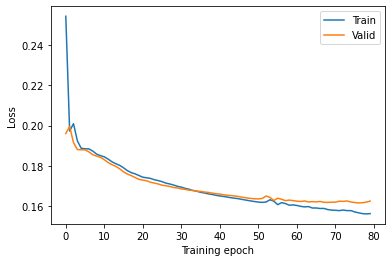

In [159]:
# Load Q_data_random
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float().to('cuda')
print('after scaling:', s_material_inputs_scaled)

# Train-validation split
s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
                                    s_step_inputs = s_step_inputs.to('cuda'), 
                                    a_elem_inputs = a_elem_inputs.to('cuda'),
                                    a_comp_inputs = a_comp_inputs.to('cuda'),
                                    Q_targets  = Q_targets.to('cuda'),
                                    en_targets = en_targets.to('cuda'),
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

# Initialize constraint network
dcn = DCN_pytorch().cuda()

# Train DCN on random data
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [160]:
# torch.save(dcn, './dcn_models/constrained_DQN_cuda/dcn_test_random_RF_constrained')

# Visualization of results

### Final reward of compounds generated from constrained model (DQN + DCN)

In [175]:
# # Earlier models
# dqn = torch.load('./dqn_models/dqn_test_500iter_RF_constrained') # Trained in constrained RL
# dqn = torch.load('./dqn_models/dqn_test_490iter_RF') # Trained in unconstrained RL
# dcn = torch.load('./dcn_models/dcn_test_random_RF_constrained') # Trained on random data

# Final constrained models
dqn = torch.load('./dqn_models/constrained_DQN_cuda/dqn_test_500iter_RF_constrained') # Trained in constrained RL
dcn = torch.load('./dcn_models/constrained_DQN_cuda/dcn_test_random_RF_constrained') # Trained on random data

# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0079, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0267, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0057, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0286, device='cuda:0', grad_fn=<MeanBackward0>))

In [178]:
# 1. Get final rewards from random policy
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
en_random = en_targets[0::5].reshape(-1) # find final en

# 2. Get final rewards from trained policy
Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = 0.4, stochastic_top_frac = 0.15)

# # Save compounds generated                                            
# with open('./training_data/constrained_DQN_cuda/final_compounds_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(final_compounds, f, pickle.HIGHEST_PROTOCOL)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


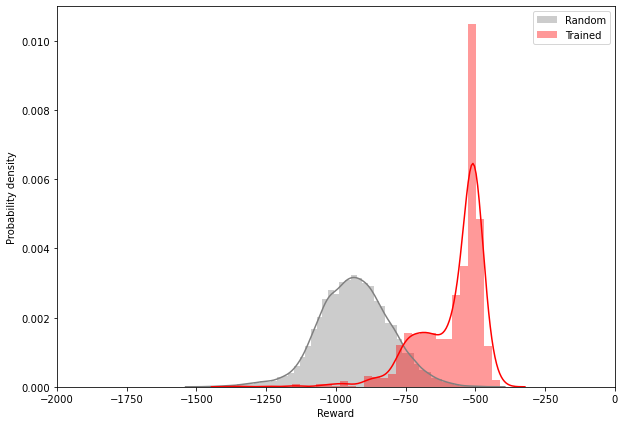

In [180]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained', color = 'red')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)   
plt.legend()
# plt.savefig(fname = 'plots/constrained_DQN_cuda/reward_dist_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Validity of compounds generated from constrained model (DQN + DCN)

In [181]:
# Validity of trained
count = 0
for target in en_targets_trained:
    if target.item() == 1.:
        count += 1
print('Trained policy: Fraction of en OK compounds = ' , count/len(en_targets_trained))

Trained policy: Fraction of en OK compounds =  0.393


In [182]:
# Validity of random
count = 0
for target in en_random:
    if target.item() == 1.:
        count += 1
print('Random policy: Fraction of en OK compounds = ' , count/len(en_random))

Random policy: Fraction of en OK compounds =  0.2661


### Experiment: Validity vs en_threshold

In [114]:
en_threshold_list  = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
en_good_ratio_vs_en_threshold = []

def evaluate_en_threshold(en_threshold):
    # 2. Get final rewards from trained policy
    Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
    generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = en_threshold, stochastic_top_frac = 0.15)
    # Validity of trained
    count = 0
    for target in en_targets_trained:
        if target.item() == 1.:
            count += 1
    ratio = count/len(en_targets_trained)
    return ratio

for en_threshold in en_threshold_list:
    en_good_ratio = evaluate_en_threshold(en_threshold = en_threshold)
    en_good_ratio_vs_en_threshold.append(en_good_ratio)

with open('./training_data/constrained_DQN_cuda/en_threshold_list_RF_constrained.pkl', 'wb') as f:
        pickle.dump(en_threshold_list, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN_cuda/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'wb') as f:
        pickle.dump(en_good_ratio_vs_en_threshold, f, pickle.HIGHEST_PROTOCOL)

Compound not valid
Compound not valid
Compound not valid
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 a

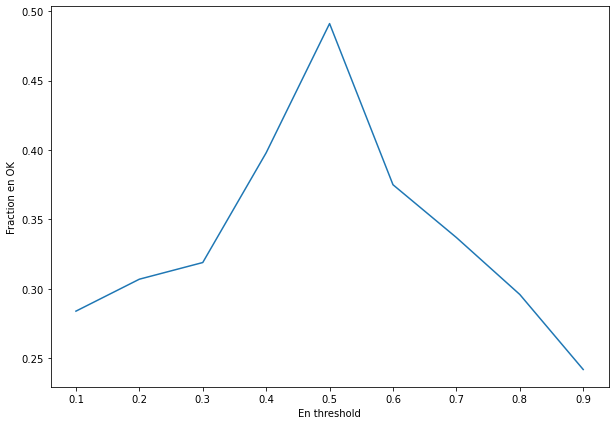

In [115]:
with open('./training_data/constrained_DQN_cuda/en_threshold_list_RF_constrained.pkl', 'rb') as f:
    en_threshold_list = pickle.load(f)

with open('./training_data/constrained_DQN_cuda/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'rb') as f:
    en_good_ratio_vs_en_threshold = pickle.load(f)

plt.figure(figsize=(10,7))
plt.plot(en_threshold_list, en_good_ratio_vs_en_threshold)
plt.ylabel('Fraction en OK')
plt.xlabel('En threshold')
# plt.savefig(fname = 'plots/en_good_ratio_vs_en_threshold_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Look at compounds

In [183]:
rf_regr = RandomForestRegressor()
rf_regr = joblib.load("rf_models/optimal_sinter_RF.joblib")

# Featurization for RF model
feature_calculators = MultipleFeaturizer([
    cf.element.Stoichiometry(),
    cf.composite.ElementProperty.from_preset("magpie"),
    cf.orbital.ValenceOrbital(props=["avg"]),
    cf.ion.IonProperty(fast=True)
])

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [184]:
# Load compounds generated
with open('./training_data/constrained_DQN_cuda/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
    final_compounds = pickle.load(f)

# For final compounds generated using constrained RL (DQN + DCN)
good, bad = check_both_multiple(final_compounds)

In [185]:
print('Fraction of en OK compounds:', len(good)/(len(good) + len(bad)))

Fraction of en OK compounds: 0.393


Compound: Ge9As3(Se2N)2          Sinter T: 773
Compound: Tl6Ag4Ge7As7N2         Sinter T: 724
Compound: Ge3Bi5As7Pb3           Sinter T: 515
Compound: Rb6Ag3Bi3S7N2          Sinter T: 763
Compound: Tl7As5N2               Sinter T: 718
Compound: Ge7Bi9N2               Sinter T: 647
Compound: Ag5Ge6Bi13             Sinter T: 565
Compound: Ag3Ge3Bi2P3            Sinter T: 646
Compound: Ag4Sn3Ge7(Te3I2)3      Sinter T: 484
Compound: Ge7Te5I7(Br2N)2        Sinter T: 764
Compound: Tb3Sn2Ge3Te9I7         Sinter T: 554
Compound: Tl7Fe3As3Se9N2         Sinter T: 753
Compound: Ag8SnN2                Sinter T: 753
Compound: Sn4Te5As6(Pb4N)2       Sinter T: 671
Compound: Tl2Sn5Ge6Te3Pb7        Sinter T: 545
Compound: Ag7Sn3Bi3I9N2          Sinter T: 640
Compound: AgSn9Ge7I6             Sinter T: 526
Compound: In7Ge10As7N2           Sinter T: 797
Compound: In9Fe3As3N2            Sinter T: 816
Compound: Ag7Sn6Ge6(BiP2)2       Sinter T: 599
Compound: Ge6BiSe2S3             Sinter T: 545
Compound: Ag4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


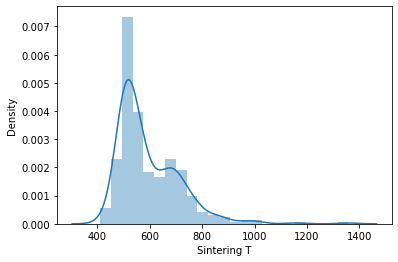

In [186]:
# Convert good ones to reduced formula
for idx in range(len(good)):
    good[idx] = Composition(good[idx]).reduced_formula

# Predict sintering T of valid compounds
max_len = 0
good_sinter_T = []
for compound in good:
    chemical = Composition(compound)
    features = feature_calculators.featurize(chemical) # No need to scale for RF model
    features = np.array(features).reshape(1, -1)
    # print(features)
    sinter_T_pred = rf_regr.predict(features)[0]
    good_sinter_T.append(sinter_T_pred)
    compound = Composition(compound).reduced_formula
    print('Compound:', compound, (18-len(compound)+3)*' ','Sinter T:', round(sinter_T_pred))

plt.figure()
sns.distplot(good_sinter_T)
plt.xlabel('Sintering T')
plt.show()

### Formation energy of generated compounds

In [187]:
predict_formation_energy('Ge2As6Pb7S14')

-0.5160053968429565

In [203]:
# RANDOM POLICY
# Save predicted formation energies of random policy                                
# with open('./training_data/form_e_random.pkl', 'wb') as f:
#         pickle.dump(form_e_random, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of random_policy
with open('./training_data/form_e_random.pkl', 'rb') as f: 
    form_e_random = pickle.load(f)

len([x for x in form_e_random if x <= 0])/len(form_e_random)

0.77

In [201]:
# # UNCONSTRAINED DQN (sintering T only)
# with open('./training_data/constrained_DQN_cuda/compounds_vs_iter_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)
# final_compounds = final_compounds[-1]

# form_e_unconstrained = []
# for compound in final_compounds:
#     form_e_unconstrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of UNconstrained DQN                                  
# with open('./training_data/form_e_500iter_RF.pkl', 'wb') as f:
#         pickle.dump(form_e_unconstrained, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of UNconstrained DQN
with open('./training_data/form_e_500iter_RF.pkl', 'rb') as f: 
    form_e_unconstrained = pickle.load(f)

len([x for x in form_e_unconstrained if x <= 0])/len(form_e_unconstrained)

0.81

In [202]:
# # CONSTRAINED DQN (sintering T + en constraint)
# # Load compounds generated
# with open('./training_data/constrained_DQN_cuda/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)

# form_e_constrained = []
# for compound in final_compounds:
#     form_e_constrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of constrained DQN                                  
# with open('./training_data/constrained_DQN_cuda/form_e_500iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(form_e_constrained, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of constrained DQN
with open('./training_data/constrained_DQN_cuda/form_e_500iter_RF_constrained.pkl', 'rb') as f: 
    form_e_constrained = pickle.load(f)

len([x for x in form_e_constrained if x <= 0])/len(form_e_constrained)

0.872

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


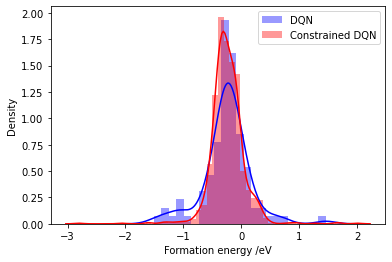

In [206]:
plt.figure()
# sns.distplot(form_e_random, bins = 30, hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(form_e_unconstrained, hist = True, norm_hist = True, label = 'DQN', color = 'blue')
sns.distplot(form_e_constrained, hist = True, norm_hist = True, label = 'Constrained DQN', color = 'red')
plt.xlabel('Formation energy /eV')
plt.legend()
# plt.savefig('plots/constrained_DQN_cuda/form_e_comparison.png', dpi = 300)
plt.show()

# Visualizing training data of unconstrained DQN

### Evolution of final rewards with iteration (unconstrained DQN only)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


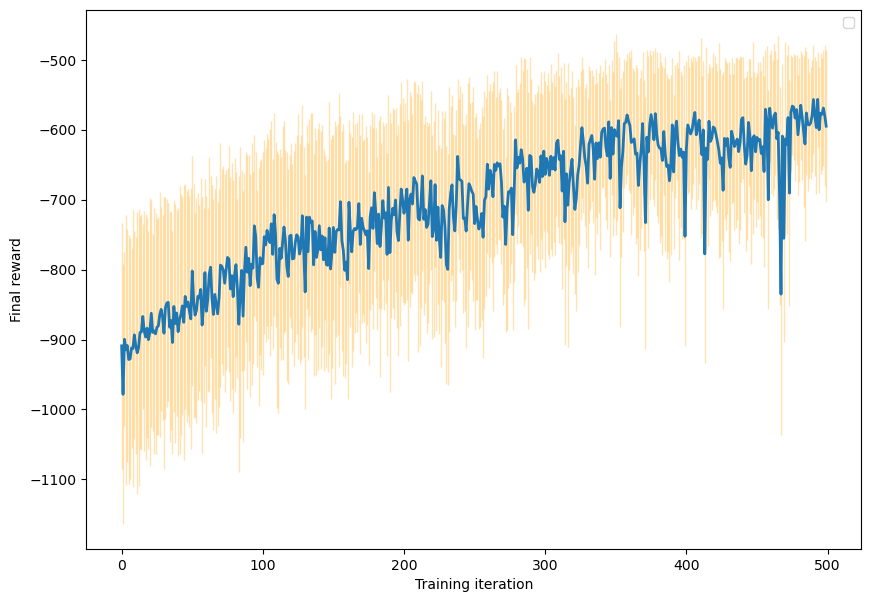

In [21]:
with open('./training_data/final_rewards_vs_iter_RF_constrained.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)
num_iter = 500
final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
plt.figure(figsize=(10,7))
markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
[bar.set_alpha(0.3) for bar in bars]
[bar.set_color('orange') for bar in bars]
plt.ylabel('Final reward')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/reward_vs_iter_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Evolution of compounds with iteration (unconstrained DQN only)

In [2]:
# with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# Load compound features
with open('./training_data/compound_features_vs_iter_RF.pkl', 'rb') as f:
    compound_features_vs_iter = pickle.load(f)

In [29]:
len(compound_features_vs_iter)

500

Standarizing data before PCA is important.

In [30]:
# Load scalar
scaler = StandardScaler() # Fit scaler
scaler.fit(s_material_inputs)

# Convert each compound features from list to np.array
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        compound_features_vs_iter[iteration][idx] = scaler.transform(np.array([compound_features_vs_iter[iteration][idx]]))[0] # Featurize using Magpie embeddings

100%|██████████| 500/500 [00:02<00:00, 243.93it/s]


In [32]:
features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    iteration_stack = []
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        iteration_stack.append(compound_features_vs_iter[iteration][idx])
    iteration_stack = np.stack(iteration_stack)
    features.append(iteration_stack)

100%|██████████| 500/500 [00:00<00:00, 6695.70it/s]


In [33]:
# Stack features into one big matrix
full_stack = [] 
for iteration in features:
    full_stack.append(iteration)
full_stack = np.vstack(full_stack)

### Dimensionality reduction using t-SNE

In [69]:
# Perform t-SNE
tsne_embeddings = TSNE(n_components = 2, 
                       perplexity = 30,
                       learning_rate='auto',
                       init='random' # random/pca initialization
                       ).fit_transform(full_stack)

# with open('training_data/tsne_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, tsne_embeddings)

In [97]:
# Load t-SNE embeddings
with open('training_data/tsne_embeddings_500iter_RF.npy', 'rb') as f:
    tsne_embeddings = np.load(f)

with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('tsne_embeddings: ', tsne_embeddings.shape)
print('final_rewards:', final_rewards.shape)

tsne_embeddings:  (50000, 2)
final_rewards: torch.Size([50000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


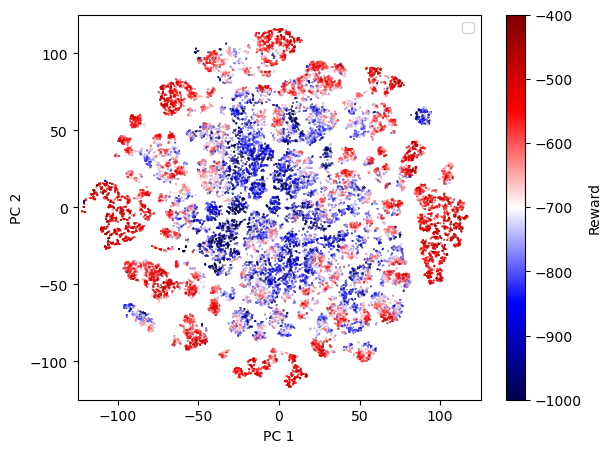

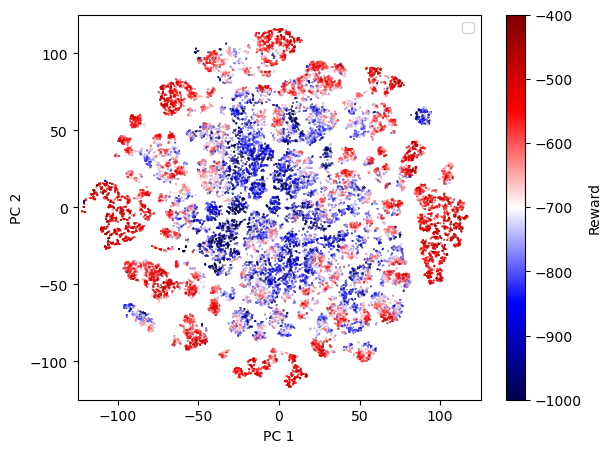

In [98]:
# Generate list of iterations for 50k compounds
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)
# Plot TSNE
def plot_TSNE(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = final_rewards, cmap = 'seismic') # For rewards
        # plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = iteration, cmap = 'seismic') # For iteration
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-125, 125)
    plt.xlim(-125, 125)
    plt.legend()
    # plt.text(20,100,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    cbar.set_label('Reward')
    # cbar.set_label('Iteration')
    plt.clim(-1000,-400) 
    # plt.savefig(fname = 'plots/TSNE_vs_iter_500iter_RF.png', dpi = 300) 
    plt.show()
    return fig
plot_TSNE()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_TSNE(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/TSNE_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Dimensionality reduction using singular value decomposition (SVD)

In [66]:
# Perform SVD
u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

# with open('training_data/SVD_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, u)

In [67]:
# Load SVD embeddings
with open('training_data/SVD_embeddings_500iter_RF.npy', 'rb') as f:
    u = np.load(f)

with open('training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('SVD_embeddings: ', u.shape)
print('final_rewards:', final_rewards.shape)

u_truncated = u[:, :2]
print('SVD_embeddings after truncation:', u_truncated.shape)

SVD_embeddings:  (50000, 50000)
final_rewards: torch.Size([50000])
SVD_embeddings after truncation: (50000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


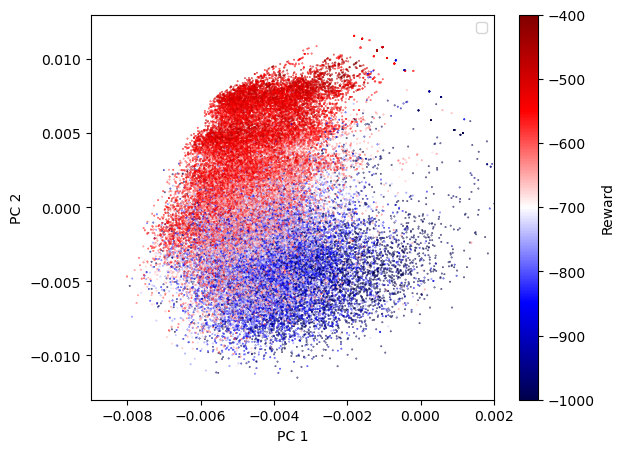

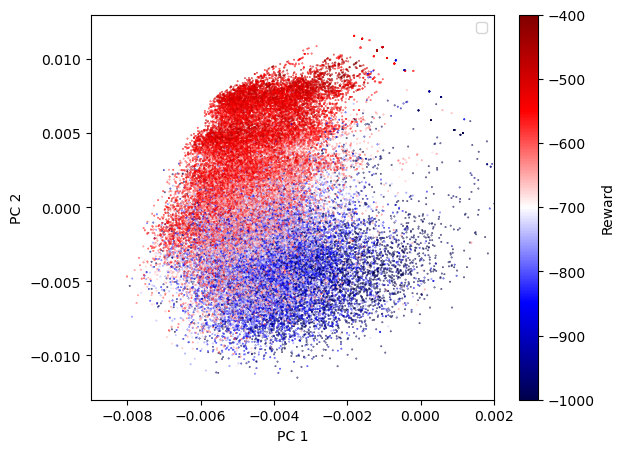

In [99]:
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)

# Plot SVD
def plot_SVD(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(u_truncated[:,0], u_truncated[:,1], c = final_rewards, s = 0.1, cmap = 'seismic') # For rewards
        # plt.scatter(u_truncated[:,0], u_truncated[:,1], c = iteration, s = 0.1, cmap = 'seismic') # For iterations
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-0.013, 0.013)
    plt.xlim(-0.009, .002)
    plt.legend()
    # plt.text(-0.002,0.010,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    plt.clim(-1000,-400)  
    # cbar.set_label('Iteration')
    cbar.set_label('Reward')
    # plt.savefig(fname = 'plots/SVD_reward_vs_iter_500iter_RF.png', dpi = 300)
    plt.show()
    return fig
plot_SVD()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_SVD(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/SVD_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Charge neutrality of generated compounds (unconstrained DQN)
From this point onwards, we start using dqn2 environment

In [36]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

good, bad = check_neutrality_multiple(compounds = compounds)
len(good), len(bad)

(45, 55)

In [37]:
# Check charge neutrality
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_neutrality_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

cn_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/cn_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, cn_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [41]:
# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


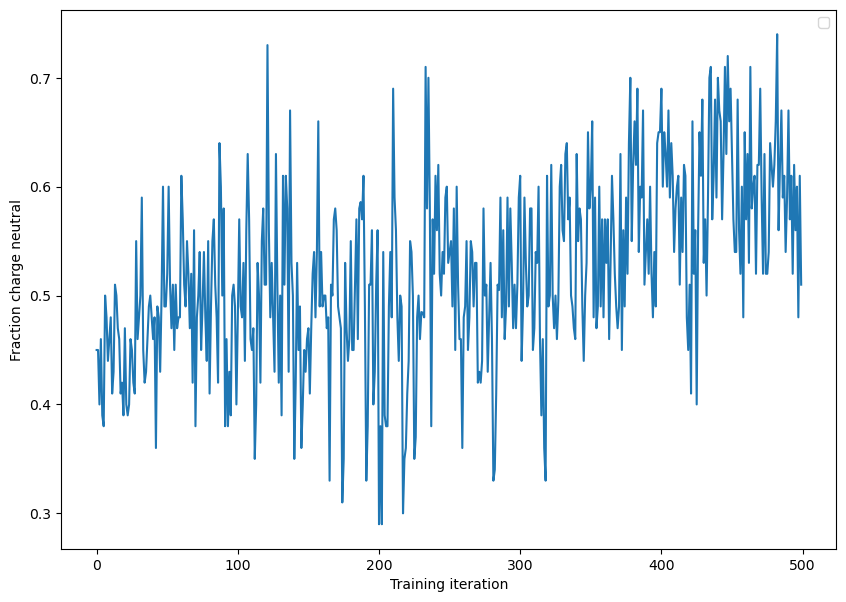

In [42]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio)
plt.ylabel('Fraction charge neutral')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/cn_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Electronegativity of generated compounds (unconstrained DQN)

In [35]:
with open('./training_data/compounds_vs_iter_RF_constrained.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

good, bad = check_electronegativity_multiple(compounds = compounds)
len(good), len(bad)

(20, 80)

In [39]:
# Check electronegativity
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_electronegativity_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

en_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

with open('training_data/en_good_ratio_500iter_RF_constrained.npy', 'wb') as f:
    np.save(f, en_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [31]:
# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF_constrained.npy', 'rb') as f:
    en_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


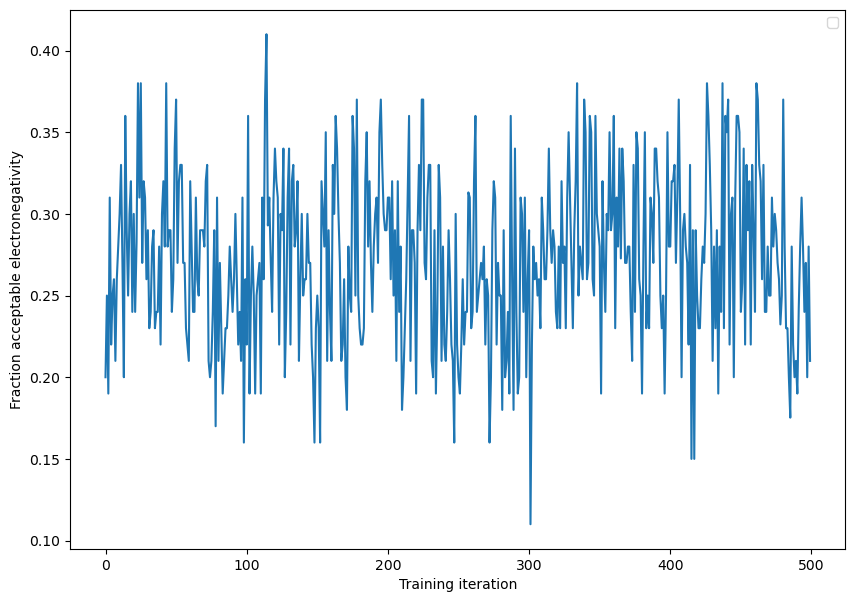

In [40]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), en_good_ratio)
plt.ylabel('Fraction acceptable electronegativity')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/en_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Check both charge neutrality and electronegativity (unconstrained DQN)

In [2]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)

In [49]:
# Efficient way
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    cn_good, cn_bad = check_neutrality_multiple(compounds = compounds)
    both_good, bad = check_electronegativity_multiple(compounds = cn_good)

    good_vs_iter.append(len(both_good))
    bad_vs_iter.append(len(cn_bad)+len(bad))

both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [38]:
# Inefficient way - To double check

# compounds = compounds_vs_iter[0]
# good, bad = check_both_multiple(compounds = compounds)

# Inefficient way - To double check
# good_vs_iter = []
# bad_vs_iter  = []
# for compounds in compounds_vs_iter:
#     good, bad = check_both_multiple(compounds = compounds)
#     good_vs_iter.append(len(good))
#     bad_vs_iter.append(len(bad))

# both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

In [9]:
# Load both
with open('training_data/both_good_ratio_500iter_RF.npy', 'rb') as f:
    both_good_ratio = np.load(f)

# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF.npy', 'rb') as f:
    en_good_ratio = np.load(f)

# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

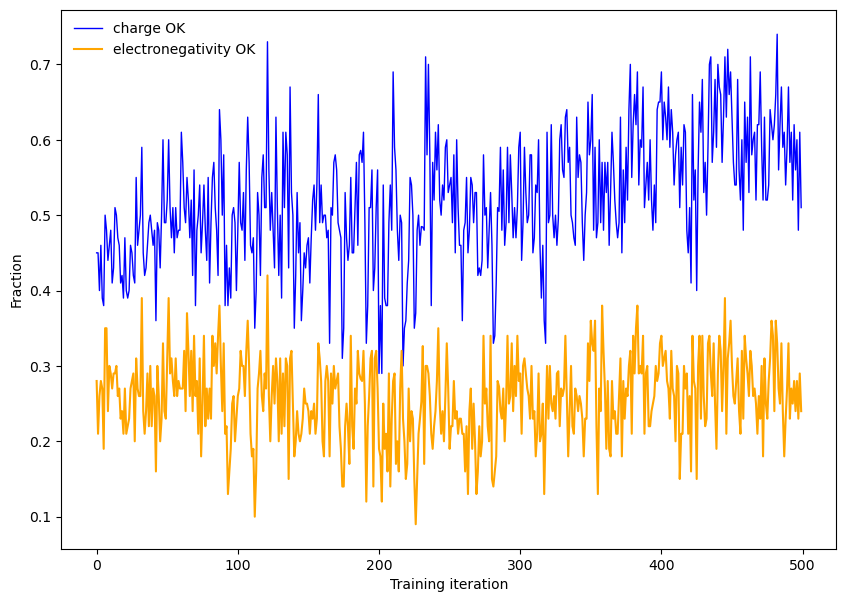

In [20]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio, label = 'charge OK', color = 'blue', linewidth = 1)
plt.plot(range(num_iter), en_good_ratio, label = 'electronegativity OK', color = 'orange')
# plt.plot(range(num_iter), both_good_ratio, label = 'both OK')
plt.ylabel('Fraction')
plt.xlabel('Training iteration')
plt.legend(frameon= False)
# plt.savefig(fname = 'plots/both_vs_iter_500iter_RF.png', dpi = 300)
plt.show()